## BP神经网络的卡尔曼滤波器实现（基于Dual-optimized adaptive Kalman filtering algorithm based on BP neural network and variance compensation for laser absorption spectroscopy)

## 所需要的一些modules

In [48]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import numpy as np
import torch
import torch.utils.data as Data
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Spectral_KF import SpectralKalmanFilter
from torch.utils.data import random_split
from FilterNet_utils import Data_set

In [49]:
def array_to_tensor(array):
    """
    因为numpy的ndarry和pytorch的tensor是两种不同的数据类型，将来在将读取的数据进行训练之前，
    需要先将ndarry转变为tensor.
    """
    tensor = torch.from_numpy(array)
    tensor = tensor.type(torch.cuda.FloatTensor)
    return tensor

In [67]:
class BpFilter(nn.Module):  # four hidden layer; seven hidden units in each layer (according to the original paper)
    """
    神经网络滤波器
    input -  layer 1 -  layer2 - layer3 - layer4 - output
    (1, 1) - (1, 7) -  (1, 7) - (1, 7) - (1, 7) - (1, 1)
    """
    def __init__(self):
        super(BpFilter, self).__init__()
        self.fc1 = nn.Linear(in_features=1, out_features=7)
        self.fc2 = nn.Linear(in_features=7, out_features=7)
        self.fc3 = nn.Linear(in_features=7, out_features=7)
        self.fc4 = nn.Linear(in_features=7, out_features=1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        return x

测试一下BpFilter,主要是查看输入输出的维度。

In [68]:
filter = BpFilter()
a = torch.randn(10, 1)
print(a.shape)
a_hat = filter(a)
print(a_hat.shape)

torch.Size([10, 1])
torch.Size([10, 1])


In [52]:
def Fit(model, train_loader, device, optimizer, criterion, epochs):
    """
    训练模型，输入模型，数据集，GPU设备，选择的优化器以及损失函数，在设置的epoch内进行模型优化。
    :param model: 输入的训练模型, untrained model
    :param train_loader: training data loader
    :param validation_loader: validation data loader
    :param device: GPU or  cpu
    :param optimizer: the chosen optimizer
    :param criterion: the loss function
    :param epochs: iteration running on models
    :return: trained loss & test loss
    """
    model.train()
    model.to(device)
    iteration_loss_list = []
    validation_error_list = []
    for e in range(epochs):
        for index, (train_x, train_y) in enumerate(train_loader):
            batch_x = train_x.to(device)
            batch_y = train_y.to(device)
            optimizer.zero_grad()
            prediction1 = model(batch_x)
            loss = criterion(prediction1, batch_y)
            iteration_loss_list.append(float(loss))
            loss.backward()
            optimizer.step()
            print("epoch: {} [{}/{} {:.2f}%] train loss: {} ".format(e, 
                                                                     index*len(batch_x),
                                                                     len(train_loader.dataset),
                                                                     100*index/len(train_loader),
                                                                     loss.item())
                  )
    return iteration_loss_list, validation_error_list

## 普通卡尔曼滤波器（无BP优化的），重点还是在process noise variance & measurement noise variance。可以根据具体实验计算出来。对于透射光谱（吸收光谱）系统，构建了state space equatoins.

In [69]:
def plain_kalman(index=500):
    process_var = 0.009858427**2  # process noise variance
    sensor_var = 0.009223176**2  # measurement noise variance
    Z = CH4_noisy_spectral[index]
    nk = np.arange(0, 1111)
    Z = np.vstack((Z, nk))  # (2, 1111) measurement matrix
    U = CH4_no_noise_spectral[index]
    ones = np.ones((1111,))
    U = np.vstack((U, ones))  # (2, 1111) control matrix
    KF_Filter = SpectralKalmanFilter(U, Z, process_var, sensor_var)  # KF类的实例
    CH4_KF = KF_Filter.filtering()
    CH4_KF = CH4_KF[0]  # (1111,)
    return CH4_KF

In [70]:
def weigth_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight.data)
        init.constant_(m.bias.data,0.1)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0,0.01)
        m.bias.data.zero_()

加载数据。使用的是模拟的无噪声甲烷（0-1000ppm）的吸收谱，以及模拟的有噪声（高斯白噪声和干涉噪声叠加的噪声）甲烷（0-1000ppm）的吸收谱。

In [71]:
if __name__ == "__main__":
    """模拟数据 （透射谱）"""
    no_noise_path = r"D:\PYHTON\python3.7\DeepLearningProgram\深度学习滤波器\1000组模拟数据\提供给模型的数据\模拟数据\CH_nonoise_spectral.npy"
    CH4_no_noise_spectral = np.load(no_noise_path)  # (1000, 1111) 透射谱（吸收谱）

    noisy_path = r"D:\PYHTON\python3.7\DeepLearningProgram\深度学习滤波器\1000组模拟数据\提供给模型的数据\模拟数据\CH_noisy_spectral.npy"
    CH4_noisy_spectral = np.load(noisy_path)  # (1000, 1111) 透射谱（吸收谱）

根据original paper,他们做的是先用kalman filter对噪声信号进行一次滤波，再次基础之上，使用BPNN对滤波后的信号进行二次优化（我阅读之后的理解，原文并没有对这个过程进行直接描述，因此可能有出入，在我们与作者进行邮件沟通之后，也没有得到明确的KF状态方程的表达，因此之后的BP-KF完全是基于我们对论文的理解进行构建的。）

In [72]:
    """plain KF滤波1次"""
    """对所有的噪声信号进行KF滤波，滤波后的信号可以作为BP神经网络的输入，而无噪声的信号即为label（ground truth）"""
    CH4_KF = np.zeros_like(CH4_no_noise_spectral)  # (1000, 1111)
    for i in range(1000):
        CH4_KF[i] = plain_kalman(index=i)
    print(CH4_KF.shape)  # (1000, 1111)

(1000, 1111)


## 值得注意的是，根据原文，状态方程中描述吸收谱的state vector是有透射率和波数组成的，在这里我们简化为只有透射率的输入，因此原文中的BPNN是一个2维的输入和2维的输出，在这里我们简化为1维（only transmittance）输入和1维输出（optimized transmittance）

In [73]:
    """KF滤波之后用BP再优化一次"""
    input_data = CH4_KF.reshape(-1, 1)  # (1111000, 1) 将它作为BpKF的input
    label_data = CH4_no_noise_spectral.reshape(-1, 1)  # label (1111000, 1)
    input_data = array_to_tensor(input_data)  # torch.cuda.FloatTensor size(1111, 1)
    label_data = array_to_tensor(label_data)  # torch.cuda.FloatTensor size(1111, 1)
    print("input data shape:", input_data.shape)
    print("label shape:", label_data.shape)

input data shape: torch.Size([1111000, 1])
label shape: torch.Size([1111000, 1])


In [58]:
    """进行数据分割 train-validation-test split"""
    train_data, test_data, train_label, test_label = train_test_split(input_data, label_data, test_size=0.2, random_state=2)
    train_loader = Data_set(train_data, train_label, 1111)

epoch: 0 [0/888800 0.00%] train loss: 0.44016897678375244 
epoch: 0 [1111/888800 0.12%] train loss: 0.43416857719421387 
epoch: 0 [2222/888800 0.25%] train loss: 0.4288434684276581 
epoch: 0 [3333/888800 0.38%] train loss: 0.423783540725708 
epoch: 0 [4444/888800 0.50%] train loss: 0.41786110401153564 
epoch: 0 [5555/888800 0.62%] train loss: 0.4122677445411682 
epoch: 0 [6666/888800 0.75%] train loss: 0.40661633014678955 
epoch: 0 [7777/888800 0.88%] train loss: 0.40153074264526367 
epoch: 0 [8888/888800 1.00%] train loss: 0.3953395485877991 
epoch: 0 [9999/888800 1.12%] train loss: 0.39021486043930054 
epoch: 0 [11110/888800 1.25%] train loss: 0.3851398527622223 
epoch: 0 [12221/888800 1.38%] train loss: 0.3796140253543854 
epoch: 0 [13332/888800 1.50%] train loss: 0.37402620911598206 
epoch: 0 [14443/888800 1.62%] train loss: 0.36865803599357605 
epoch: 0 [15554/888800 1.75%] train loss: 0.3628241717815399 
epoch: 0 [16665/888800 1.88%] train loss: 0.35746392607688904 
epoch: 0 [177

epoch: 0 [153318/888800 17.25%] train loss: 5.384725227486342e-05 
epoch: 0 [154429/888800 17.38%] train loss: 4.5004566345596686e-05 
epoch: 0 [155540/888800 17.50%] train loss: 4.781592360814102e-05 
epoch: 0 [156651/888800 17.62%] train loss: 5.497273741639219e-05 
epoch: 0 [157762/888800 17.75%] train loss: 4.9521684559294954e-05 
epoch: 0 [158873/888800 17.88%] train loss: 4.858481770497747e-05 
epoch: 0 [159984/888800 18.00%] train loss: 4.667239045375027e-05 
epoch: 0 [161095/888800 18.12%] train loss: 4.715123577625491e-05 
epoch: 0 [162206/888800 18.25%] train loss: 4.4735763367498294e-05 
epoch: 0 [163317/888800 18.38%] train loss: 4.8546808102400973e-05 
epoch: 0 [164428/888800 18.50%] train loss: 4.4487922423286363e-05 
epoch: 0 [165539/888800 18.62%] train loss: 5.32451958861202e-05 
epoch: 0 [166650/888800 18.75%] train loss: 4.9722264520823956e-05 
epoch: 0 [167761/888800 18.88%] train loss: 4.817529770662077e-05 
epoch: 0 [168872/888800 19.00%] train loss: 4.54520049970

epoch: 0 [299970/888800 33.75%] train loss: 4.27638842666056e-05 
epoch: 0 [301081/888800 33.88%] train loss: 4.7526689741062e-05 
epoch: 0 [302192/888800 34.00%] train loss: 4.1963729017879814e-05 
epoch: 0 [303303/888800 34.12%] train loss: 4.914661985822022e-05 
epoch: 0 [304414/888800 34.25%] train loss: 5.352546941139735e-05 
epoch: 0 [305525/888800 34.38%] train loss: 4.546366835711524e-05 
epoch: 0 [306636/888800 34.50%] train loss: 4.3489515519468114e-05 
epoch: 0 [307747/888800 34.62%] train loss: 4.4789510866394266e-05 
epoch: 0 [308858/888800 34.75%] train loss: 3.967072188970633e-05 
epoch: 0 [309969/888800 34.88%] train loss: 4.4972883188165724e-05 
epoch: 0 [311080/888800 35.00%] train loss: 5.352882362785749e-05 
epoch: 0 [312191/888800 35.12%] train loss: 3.881088923662901e-05 
epoch: 0 [313302/888800 35.25%] train loss: 4.601743057719432e-05 
epoch: 0 [314413/888800 35.38%] train loss: 3.815388117800467e-05 
epoch: 0 [315524/888800 35.50%] train loss: 4.617281956598162

epoch: 0 [445511/888800 50.12%] train loss: 5.266123480396345e-05 
epoch: 0 [446622/888800 50.25%] train loss: 5.0952276069438085e-05 
epoch: 0 [447733/888800 50.38%] train loss: 3.930352977477014e-05 
epoch: 0 [448844/888800 50.50%] train loss: 5.7350385759491473e-05 
epoch: 0 [449955/888800 50.62%] train loss: 4.0958464524010196e-05 
epoch: 0 [451066/888800 50.75%] train loss: 4.876236926065758e-05 
epoch: 0 [452177/888800 50.88%] train loss: 4.497465124586597e-05 
epoch: 0 [453288/888800 51.00%] train loss: 4.370041278889403e-05 
epoch: 0 [454399/888800 51.12%] train loss: 4.250213532941416e-05 
epoch: 0 [455510/888800 51.25%] train loss: 4.2877349187619984e-05 
epoch: 0 [456621/888800 51.38%] train loss: 4.531544982455671e-05 
epoch: 0 [457732/888800 51.50%] train loss: 4.808177618542686e-05 
epoch: 0 [458843/888800 51.62%] train loss: 4.5958953705849126e-05 
epoch: 0 [459954/888800 51.75%] train loss: 5.270282053970732e-05 
epoch: 0 [461065/888800 51.88%] train loss: 4.01198703912

epoch: 0 [588830/888800 66.25%] train loss: 4.492102380027063e-05 
epoch: 0 [589941/888800 66.38%] train loss: 4.346885179984383e-05 
epoch: 0 [591052/888800 66.50%] train loss: 4.278205960872583e-05 
epoch: 0 [592163/888800 66.62%] train loss: 4.413236820255406e-05 
epoch: 0 [593274/888800 66.75%] train loss: 4.7715195250930265e-05 
epoch: 0 [594385/888800 66.88%] train loss: 5.1496692321961746e-05 
epoch: 0 [595496/888800 67.00%] train loss: 4.475075184018351e-05 
epoch: 0 [596607/888800 67.12%] train loss: 4.463789809960872e-05 
epoch: 0 [597718/888800 67.25%] train loss: 5.36293737241067e-05 
epoch: 0 [598829/888800 67.38%] train loss: 4.354536213213578e-05 
epoch: 0 [599940/888800 67.50%] train loss: 4.4474334572441876e-05 
epoch: 0 [601051/888800 67.62%] train loss: 4.983128746971488e-05 
epoch: 0 [602162/888800 67.75%] train loss: 3.602662400226109e-05 
epoch: 0 [603273/888800 67.88%] train loss: 4.301243825466372e-05 
epoch: 0 [604384/888800 68.00%] train loss: 4.14950882259290

epoch: 0 [725483/888800 81.62%] train loss: 4.081115184817463e-05 
epoch: 0 [726594/888800 81.75%] train loss: 4.7353332774946466e-05 
epoch: 0 [727705/888800 81.88%] train loss: 4.0403640014119446e-05 
epoch: 0 [728816/888800 82.00%] train loss: 5.559494093176909e-05 
epoch: 0 [729927/888800 82.12%] train loss: 4.82995601487346e-05 
epoch: 0 [731038/888800 82.25%] train loss: 4.955697659170255e-05 
epoch: 0 [732149/888800 82.38%] train loss: 3.7879999581491575e-05 
epoch: 0 [733260/888800 82.50%] train loss: 5.05492789670825e-05 
epoch: 0 [734371/888800 82.62%] train loss: 4.566220741253346e-05 
epoch: 0 [735482/888800 82.75%] train loss: 4.784838165505789e-05 
epoch: 0 [736593/888800 82.88%] train loss: 4.5360149670159444e-05 
epoch: 0 [737704/888800 83.00%] train loss: 4.0623050153953955e-05 
epoch: 0 [738815/888800 83.12%] train loss: 4.215613807900809e-05 
epoch: 0 [739926/888800 83.25%] train loss: 4.205243749311194e-05 
epoch: 0 [741037/888800 83.38%] train loss: 3.8100024539744

epoch: 0 [864358/888800 97.25%] train loss: 4.423038990353234e-05 
epoch: 0 [865469/888800 97.38%] train loss: 4.8222547775367275e-05 
epoch: 0 [866580/888800 97.50%] train loss: 4.77964204037562e-05 
epoch: 0 [867691/888800 97.62%] train loss: 4.178200470050797e-05 
epoch: 0 [868802/888800 97.75%] train loss: 4.323145549278706e-05 
epoch: 0 [869913/888800 97.88%] train loss: 4.165662539890036e-05 
epoch: 0 [871024/888800 98.00%] train loss: 4.761098898597993e-05 
epoch: 0 [872135/888800 98.12%] train loss: 4.1563140257494524e-05 
epoch: 0 [873246/888800 98.25%] train loss: 4.085400723852217e-05 
epoch: 0 [874357/888800 98.38%] train loss: 3.923535768990405e-05 
epoch: 0 [875468/888800 98.50%] train loss: 3.8446396501967683e-05 
epoch: 0 [876579/888800 98.62%] train loss: 4.4331409299047664e-05 
epoch: 0 [877690/888800 98.75%] train loss: 4.428927059052512e-05 
epoch: 0 [878801/888800 98.88%] train loss: 4.884695226792246e-05 
epoch: 0 [879912/888800 99.00%] train loss: 5.2409257477847

epoch: 1 [121099/888800 13.62%] train loss: 4.6256969653768465e-05 
epoch: 1 [122210/888800 13.75%] train loss: 4.9991558626061305e-05 
epoch: 1 [123321/888800 13.88%] train loss: 6.172163557494059e-05 
epoch: 1 [124432/888800 14.00%] train loss: 4.555845953291282e-05 
epoch: 1 [125543/888800 14.12%] train loss: 4.215124135953374e-05 
epoch: 1 [126654/888800 14.25%] train loss: 5.080825576442294e-05 
epoch: 1 [127765/888800 14.38%] train loss: 4.909605559078045e-05 
epoch: 1 [128876/888800 14.50%] train loss: 4.563223774312064e-05 
epoch: 1 [129987/888800 14.62%] train loss: 3.876713162753731e-05 
epoch: 1 [131098/888800 14.75%] train loss: 4.705888204625808e-05 
epoch: 1 [132209/888800 14.88%] train loss: 4.062207881361246e-05 
epoch: 1 [133320/888800 15.00%] train loss: 4.7773861297173426e-05 
epoch: 1 [134431/888800 15.12%] train loss: 5.4859141528140754e-05 
epoch: 1 [135542/888800 15.25%] train loss: 3.760338950087316e-05 
epoch: 1 [136653/888800 15.38%] train loss: 5.366424011299

epoch: 1 [257752/888800 29.00%] train loss: 6.086635767132975e-05 
epoch: 1 [258863/888800 29.12%] train loss: 4.783663462148979e-05 
epoch: 1 [259974/888800 29.25%] train loss: 5.1760922360699624e-05 
epoch: 1 [261085/888800 29.38%] train loss: 4.509448990575038e-05 
epoch: 1 [262196/888800 29.50%] train loss: 4.676516618928872e-05 
epoch: 1 [263307/888800 29.62%] train loss: 4.089700451004319e-05 
epoch: 1 [264418/888800 29.75%] train loss: 4.3987773096887395e-05 
epoch: 1 [265529/888800 29.88%] train loss: 4.58249487564899e-05 
epoch: 1 [266640/888800 30.00%] train loss: 4.154500857111998e-05 
epoch: 1 [267751/888800 30.12%] train loss: 4.6349599870154634e-05 
epoch: 1 [268862/888800 30.25%] train loss: 4.9145975935971364e-05 
epoch: 1 [269973/888800 30.38%] train loss: 3.750235555344261e-05 
epoch: 1 [271084/888800 30.50%] train loss: 5.287278690957464e-05 
epoch: 1 [272195/888800 30.62%] train loss: 4.7836845624260604e-05 
epoch: 1 [273306/888800 30.75%] train loss: 4.774397893925

epoch: 1 [404404/888800 45.50%] train loss: 4.3211563024669886e-05 
epoch: 1 [405515/888800 45.62%] train loss: 4.532920866040513e-05 
epoch: 1 [406626/888800 45.75%] train loss: 4.31434455094859e-05 
epoch: 1 [407737/888800 45.88%] train loss: 4.7978523070923984e-05 
epoch: 1 [408848/888800 46.00%] train loss: 5.0962207751581445e-05 
epoch: 1 [409959/888800 46.12%] train loss: 4.464606536203064e-05 
epoch: 1 [411070/888800 46.25%] train loss: 4.12721092288848e-05 
epoch: 1 [412181/888800 46.38%] train loss: 4.026709575555287e-05 
epoch: 1 [413292/888800 46.50%] train loss: 3.849923814414069e-05 
epoch: 1 [414403/888800 46.62%] train loss: 5.1274972065584734e-05 
epoch: 1 [415514/888800 46.75%] train loss: 5.033093111705966e-05 
epoch: 1 [416625/888800 46.88%] train loss: 4.1433271690038964e-05 
epoch: 1 [417736/888800 47.00%] train loss: 4.735460242955014e-05 
epoch: 1 [418847/888800 47.12%] train loss: 3.805592859862372e-05 
epoch: 1 [419958/888800 47.25%] train loss: 4.0205639379564

epoch: 1 [539946/888800 60.75%] train loss: 4.440303018782288e-05 
epoch: 1 [541057/888800 60.88%] train loss: 4.996208008378744e-05 
epoch: 1 [542168/888800 61.00%] train loss: 4.552836617222056e-05 
epoch: 1 [543279/888800 61.12%] train loss: 4.657141471398063e-05 
epoch: 1 [544390/888800 61.25%] train loss: 4.319387880968861e-05 
epoch: 1 [545501/888800 61.38%] train loss: 5.163311288924888e-05 
epoch: 1 [546612/888800 61.50%] train loss: 5.5529908422613516e-05 
epoch: 1 [547723/888800 61.62%] train loss: 4.417543823365122e-05 
epoch: 1 [548834/888800 61.75%] train loss: 4.217581226839684e-05 
epoch: 1 [549945/888800 61.88%] train loss: 4.377830555313267e-05 
epoch: 1 [551056/888800 62.00%] train loss: 4.5050499466015026e-05 
epoch: 1 [552167/888800 62.12%] train loss: 4.488707782002166e-05 
epoch: 1 [553278/888800 62.25%] train loss: 4.93673505843617e-05 
epoch: 1 [554389/888800 62.38%] train loss: 4.471474312595092e-05 
epoch: 1 [555500/888800 62.50%] train loss: 3.410894714761525

epoch: 1 [683265/888800 76.88%] train loss: 3.6027689930051565e-05 
epoch: 1 [684376/888800 77.00%] train loss: 4.461437129066326e-05 
epoch: 1 [685487/888800 77.12%] train loss: 4.7419343900401145e-05 
epoch: 1 [686598/888800 77.25%] train loss: 6.094879427109845e-05 
epoch: 1 [687709/888800 77.38%] train loss: 3.953724808525294e-05 
epoch: 1 [688820/888800 77.50%] train loss: 3.866750921588391e-05 
epoch: 1 [689931/888800 77.62%] train loss: 4.811435428564437e-05 
epoch: 1 [691042/888800 77.75%] train loss: 4.296300176065415e-05 
epoch: 1 [692153/888800 77.88%] train loss: 4.6507961087627336e-05 
epoch: 1 [693264/888800 78.00%] train loss: 4.6535682486137375e-05 
epoch: 1 [694375/888800 78.12%] train loss: 5.499165126821026e-05 
epoch: 1 [695486/888800 78.25%] train loss: 5.171126394998282e-05 
epoch: 1 [696597/888800 78.38%] train loss: 3.977039159508422e-05 
epoch: 1 [697708/888800 78.50%] train loss: 3.850643406622112e-05 
epoch: 1 [698819/888800 78.62%] train loss: 3.960940739489

epoch: 1 [822140/888800 92.50%] train loss: 4.643175270757638e-05 
epoch: 1 [823251/888800 92.62%] train loss: 4.8336878535337746e-05 
epoch: 1 [824362/888800 92.75%] train loss: 4.39526884292718e-05 
epoch: 1 [825473/888800 92.88%] train loss: 4.3791293137473986e-05 
epoch: 1 [826584/888800 93.00%] train loss: 5.646976933348924e-05 
epoch: 1 [827695/888800 93.12%] train loss: 4.823760173167102e-05 
epoch: 1 [828806/888800 93.25%] train loss: 5.182709719520062e-05 
epoch: 1 [829917/888800 93.38%] train loss: 5.697728192899376e-05 
epoch: 1 [831028/888800 93.50%] train loss: 4.629609247785993e-05 
epoch: 1 [832139/888800 93.62%] train loss: 3.702207686728798e-05 
epoch: 1 [833250/888800 93.75%] train loss: 4.185253055766225e-05 
epoch: 1 [834361/888800 93.88%] train loss: 4.6838325943099335e-05 
epoch: 1 [835472/888800 94.00%] train loss: 4.1913390305126086e-05 
epoch: 1 [836583/888800 94.12%] train loss: 4.976694253855385e-05 
epoch: 1 [837694/888800 94.25%] train loss: 4.8902758862823

epoch: 2 [74437/888800 8.38%] train loss: 4.168429222772829e-05 
epoch: 2 [75548/888800 8.50%] train loss: 4.686515239882283e-05 
epoch: 2 [76659/888800 8.62%] train loss: 4.735209222417325e-05 
epoch: 2 [77770/888800 8.75%] train loss: 4.0799852285999805e-05 
epoch: 2 [78881/888800 8.88%] train loss: 4.940733560943045e-05 
epoch: 2 [79992/888800 9.00%] train loss: 4.092363815288991e-05 
epoch: 2 [81103/888800 9.12%] train loss: 4.9516427679918706e-05 
epoch: 2 [82214/888800 9.25%] train loss: 4.508392157731578e-05 
epoch: 2 [83325/888800 9.38%] train loss: 5.018832234782167e-05 
epoch: 2 [84436/888800 9.50%] train loss: 4.0169696148950607e-05 
epoch: 2 [85547/888800 9.62%] train loss: 4.763445394928567e-05 
epoch: 2 [86658/888800 9.75%] train loss: 3.909105362254195e-05 
epoch: 2 [87769/888800 9.88%] train loss: 4.610319956555031e-05 
epoch: 2 [88880/888800 10.00%] train loss: 4.329599687480368e-05 
epoch: 2 [89991/888800 10.12%] train loss: 4.102314051124267e-05 
epoch: 2 [91102/8888

epoch: 2 [216645/888800 24.38%] train loss: 4.59359071101062e-05 
epoch: 2 [217756/888800 24.50%] train loss: 4.251591599313542e-05 
epoch: 2 [218867/888800 24.62%] train loss: 5.772114309365861e-05 
epoch: 2 [219978/888800 24.75%] train loss: 4.8750851419754326e-05 
epoch: 2 [221089/888800 24.88%] train loss: 4.290963988751173e-05 
epoch: 2 [222200/888800 25.00%] train loss: 4.584031194099225e-05 
epoch: 2 [223311/888800 25.12%] train loss: 4.706075196736492e-05 
epoch: 2 [224422/888800 25.25%] train loss: 4.129710578126833e-05 
epoch: 2 [225533/888800 25.38%] train loss: 4.180911128059961e-05 
epoch: 2 [226644/888800 25.50%] train loss: 4.74524604214821e-05 
epoch: 2 [227755/888800 25.62%] train loss: 4.4898053602082655e-05 
epoch: 2 [228866/888800 25.75%] train loss: 4.088754212716594e-05 
epoch: 2 [229977/888800 25.88%] train loss: 5.0324724725214764e-05 
epoch: 2 [231088/888800 26.00%] train loss: 4.407385131344199e-05 
epoch: 2 [232199/888800 26.12%] train loss: 4.8311358114006e-

epoch: 2 [363297/888800 40.88%] train loss: 4.4073611206840724e-05 
epoch: 2 [364408/888800 41.00%] train loss: 4.4716922275256366e-05 
epoch: 2 [365519/888800 41.12%] train loss: 4.2103754822164774e-05 
epoch: 2 [366630/888800 41.25%] train loss: 5.5094260460464284e-05 
epoch: 2 [367741/888800 41.38%] train loss: 4.463765071704984e-05 
epoch: 2 [368852/888800 41.50%] train loss: 4.2257302993675694e-05 
epoch: 2 [369963/888800 41.62%] train loss: 4.3578515033004805e-05 
epoch: 2 [371074/888800 41.75%] train loss: 5.082410643808544e-05 
epoch: 2 [372185/888800 41.88%] train loss: 4.826420990866609e-05 
epoch: 2 [373296/888800 42.00%] train loss: 4.376280776341446e-05 
epoch: 2 [374407/888800 42.12%] train loss: 4.098323188372888e-05 
epoch: 2 [375518/888800 42.25%] train loss: 4.507592529989779e-05 
epoch: 2 [376629/888800 42.38%] train loss: 3.8241960282903165e-05 
epoch: 2 [377740/888800 42.50%] train loss: 4.4440523197408766e-05 
epoch: 2 [378851/888800 42.62%] train loss: 5.06358410

epoch: 2 [501061/888800 56.38%] train loss: 4.1296698327641934e-05 
epoch: 2 [502172/888800 56.50%] train loss: 3.4460572351235896e-05 
epoch: 2 [503283/888800 56.62%] train loss: 3.851297151413746e-05 
epoch: 2 [504394/888800 56.75%] train loss: 5.498361133504659e-05 
epoch: 2 [505505/888800 56.88%] train loss: 4.367079236544669e-05 
epoch: 2 [506616/888800 57.00%] train loss: 4.483501834329218e-05 
epoch: 2 [507727/888800 57.12%] train loss: 4.67056488560047e-05 
epoch: 2 [508838/888800 57.25%] train loss: 4.95685453643091e-05 
epoch: 2 [509949/888800 57.38%] train loss: 3.955195643357001e-05 
epoch: 2 [511060/888800 57.50%] train loss: 3.998326064902358e-05 
epoch: 2 [512171/888800 57.62%] train loss: 4.336499478085898e-05 
epoch: 2 [513282/888800 57.75%] train loss: 4.683690349338576e-05 
epoch: 2 [514393/888800 57.88%] train loss: 4.479836570681073e-05 
epoch: 2 [515504/888800 58.00%] train loss: 4.344931221567094e-05 
epoch: 2 [516615/888800 58.12%] train loss: 5.362143929232843e

epoch: 2 [647713/888800 72.88%] train loss: 4.3122399802086875e-05 
epoch: 2 [648824/888800 73.00%] train loss: 4.446218372322619e-05 
epoch: 2 [649935/888800 73.12%] train loss: 5.221821993472986e-05 
epoch: 2 [651046/888800 73.25%] train loss: 4.726495171780698e-05 
epoch: 2 [652157/888800 73.38%] train loss: 3.972306149080396e-05 
epoch: 2 [653268/888800 73.50%] train loss: 5.2400555432541296e-05 
epoch: 2 [654379/888800 73.62%] train loss: 4.378395533422008e-05 
epoch: 2 [655490/888800 73.75%] train loss: 4.691129652201198e-05 
epoch: 2 [656601/888800 73.88%] train loss: 5.3701707656728104e-05 
epoch: 2 [657712/888800 74.00%] train loss: 4.393327981233597e-05 
epoch: 2 [658823/888800 74.12%] train loss: 5.5923970649018884e-05 
epoch: 2 [659934/888800 74.25%] train loss: 3.918047877959907e-05 
epoch: 2 [661045/888800 74.38%] train loss: 4.286480907467194e-05 
epoch: 2 [662156/888800 74.50%] train loss: 4.90065649501048e-05 
epoch: 2 [663267/888800 74.62%] train loss: 4.6819302951917

epoch: 3 [34441/888800 3.88%] train loss: 4.106567575945519e-05 
epoch: 3 [35552/888800 4.00%] train loss: 4.011127384728752e-05 
epoch: 3 [36663/888800 4.12%] train loss: 3.8776932342443615e-05 
epoch: 3 [37774/888800 4.25%] train loss: 4.7175970394164324e-05 
epoch: 3 [38885/888800 4.38%] train loss: 3.810906855505891e-05 
epoch: 3 [39996/888800 4.50%] train loss: 4.4446729589253664e-05 
epoch: 3 [41107/888800 4.62%] train loss: 3.9647235098527744e-05 
epoch: 3 [42218/888800 4.75%] train loss: 3.713323894771747e-05 
epoch: 3 [43329/888800 4.88%] train loss: 4.747622733702883e-05 
epoch: 3 [44440/888800 5.00%] train loss: 3.830809146165848e-05 
epoch: 3 [45551/888800 5.12%] train loss: 4.5600183511851355e-05 
epoch: 3 [46662/888800 5.25%] train loss: 4.988356158719398e-05 
epoch: 3 [47773/888800 5.38%] train loss: 4.042796717840247e-05 
epoch: 3 [48884/888800 5.50%] train loss: 4.425428414833732e-05 
epoch: 3 [49995/888800 5.62%] train loss: 5.1477592933224514e-05 
epoch: 3 [51106/888

epoch: 3 [176649/888800 19.88%] train loss: 5.110791971674189e-05 
epoch: 3 [177760/888800 20.00%] train loss: 4.0902312321122736e-05 
epoch: 3 [178871/888800 20.12%] train loss: 4.535282641882077e-05 
epoch: 3 [179982/888800 20.25%] train loss: 4.408032327773981e-05 
epoch: 3 [181093/888800 20.38%] train loss: 4.230115155223757e-05 
epoch: 3 [182204/888800 20.50%] train loss: 4.311896918807179e-05 
epoch: 3 [183315/888800 20.62%] train loss: 4.2658652091631666e-05 
epoch: 3 [184426/888800 20.75%] train loss: 4.775193883688189e-05 
epoch: 3 [185537/888800 20.88%] train loss: 4.1818984755082056e-05 
epoch: 3 [186648/888800 21.00%] train loss: 3.632251900853589e-05 
epoch: 3 [187759/888800 21.12%] train loss: 4.33925524703227e-05 
epoch: 3 [188870/888800 21.25%] train loss: 4.085906039108522e-05 
epoch: 3 [189981/888800 21.38%] train loss: 4.378367157187313e-05 
epoch: 3 [191092/888800 21.50%] train loss: 4.0114609873853624e-05 
epoch: 3 [192203/888800 21.62%] train loss: 4.1069873986998

epoch: 3 [318857/888800 35.88%] train loss: 4.039816849399358e-05 
epoch: 3 [319968/888800 36.00%] train loss: 4.60340925201308e-05 
epoch: 3 [321079/888800 36.12%] train loss: 4.6347122406587005e-05 
epoch: 3 [322190/888800 36.25%] train loss: 4.4078649807488546e-05 
epoch: 3 [323301/888800 36.38%] train loss: 5.6139710068237036e-05 
epoch: 3 [324412/888800 36.50%] train loss: 4.432912464835681e-05 
epoch: 3 [325523/888800 36.62%] train loss: 4.205292134429328e-05 
epoch: 3 [326634/888800 36.75%] train loss: 5.003848855267279e-05 
epoch: 3 [327745/888800 36.88%] train loss: 4.0535087464377284e-05 
epoch: 3 [328856/888800 37.00%] train loss: 4.326908310758881e-05 
epoch: 3 [329967/888800 37.12%] train loss: 4.546025229501538e-05 
epoch: 3 [331078/888800 37.25%] train loss: 4.573726619128138e-05 
epoch: 3 [332189/888800 37.38%] train loss: 4.299850115785375e-05 
epoch: 3 [333300/888800 37.50%] train loss: 4.774333137902431e-05 
epoch: 3 [334411/888800 37.62%] train loss: 4.2137937271036

epoch: 3 [458843/888800 51.62%] train loss: 4.275630635675043e-05 
epoch: 3 [459954/888800 51.75%] train loss: 4.826451186090708e-05 
epoch: 3 [461065/888800 51.88%] train loss: 4.986647400073707e-05 
epoch: 3 [462176/888800 52.00%] train loss: 3.7589914427371696e-05 
epoch: 3 [463287/888800 52.12%] train loss: 4.019338666694239e-05 
epoch: 3 [464398/888800 52.25%] train loss: 4.286877083359286e-05 
epoch: 3 [465509/888800 52.38%] train loss: 4.15133181377314e-05 
epoch: 3 [466620/888800 52.50%] train loss: 4.803084084414877e-05 
epoch: 3 [467731/888800 52.62%] train loss: 4.163159246672876e-05 
epoch: 3 [468842/888800 52.75%] train loss: 4.4013428123435006e-05 
epoch: 3 [469953/888800 52.88%] train loss: 4.267357871867716e-05 
epoch: 3 [471064/888800 53.00%] train loss: 4.365831409813836e-05 
epoch: 3 [472175/888800 53.12%] train loss: 4.9902071623364463e-05 
epoch: 3 [473286/888800 53.25%] train loss: 5.187021452002227e-05 
epoch: 3 [474397/888800 53.38%] train loss: 4.29303618147969

epoch: 3 [604384/888800 68.00%] train loss: 3.491768802632578e-05 
epoch: 3 [605495/888800 68.12%] train loss: 3.8259746361291036e-05 
epoch: 3 [606606/888800 68.25%] train loss: 4.43550270574633e-05 
epoch: 3 [607717/888800 68.38%] train loss: 4.813888517674059e-05 
epoch: 3 [608828/888800 68.50%] train loss: 4.092547169420868e-05 
epoch: 3 [609939/888800 68.62%] train loss: 4.025624002679251e-05 
epoch: 3 [611050/888800 68.75%] train loss: 4.8545491154072806e-05 
epoch: 3 [612161/888800 68.88%] train loss: 4.020463893539272e-05 
epoch: 3 [613272/888800 69.00%] train loss: 3.9044676668709144e-05 
epoch: 3 [614383/888800 69.12%] train loss: 4.429291220731102e-05 
epoch: 3 [615494/888800 69.25%] train loss: 4.0358409023610875e-05 
epoch: 3 [616605/888800 69.38%] train loss: 4.899860141449608e-05 
epoch: 3 [617716/888800 69.50%] train loss: 4.176836955593899e-05 
epoch: 3 [618827/888800 69.62%] train loss: 4.451218410395086e-05 
epoch: 3 [619938/888800 69.75%] train loss: 3.8448652048828

epoch: 3 [744370/888800 83.75%] train loss: 3.7905268982285634e-05 
epoch: 3 [745481/888800 83.88%] train loss: 4.501889998209663e-05 
epoch: 3 [746592/888800 84.00%] train loss: 4.7125031414907426e-05 
epoch: 3 [747703/888800 84.12%] train loss: 3.722853944054805e-05 
epoch: 3 [748814/888800 84.25%] train loss: 3.870627915603109e-05 
epoch: 3 [749925/888800 84.38%] train loss: 4.503336094785482e-05 
epoch: 3 [751036/888800 84.50%] train loss: 4.010445991298184e-05 
epoch: 3 [752147/888800 84.62%] train loss: 3.9147609641077e-05 
epoch: 3 [753258/888800 84.75%] train loss: 4.776463902089745e-05 
epoch: 3 [754369/888800 84.88%] train loss: 4.3470088712638244e-05 
epoch: 3 [755480/888800 85.00%] train loss: 4.415737930685282e-05 
epoch: 3 [756591/888800 85.12%] train loss: 4.2007282900158316e-05 
epoch: 3 [757702/888800 85.25%] train loss: 4.4530537707032636e-05 
epoch: 3 [758813/888800 85.38%] train loss: 4.248700133757666e-05 
epoch: 3 [759924/888800 85.50%] train loss: 4.3449002987472

epoch: 4 [0/888800 0.00%] train loss: 4.43295793957077e-05 
epoch: 4 [1111/888800 0.12%] train loss: 3.6884142900817096e-05 
epoch: 4 [2222/888800 0.25%] train loss: 5.143274029251188e-05 
epoch: 4 [3333/888800 0.38%] train loss: 4.818979141418822e-05 
epoch: 4 [4444/888800 0.50%] train loss: 4.759045987157151e-05 
epoch: 4 [5555/888800 0.62%] train loss: 3.857401679852046e-05 
epoch: 4 [6666/888800 0.75%] train loss: 3.9199872844619676e-05 
epoch: 4 [7777/888800 0.88%] train loss: 4.6126875531626865e-05 
epoch: 4 [8888/888800 1.00%] train loss: 4.7565623390255496e-05 
epoch: 4 [9999/888800 1.12%] train loss: 4.67216013930738e-05 
epoch: 4 [11110/888800 1.25%] train loss: 4.09195308748167e-05 
epoch: 4 [12221/888800 1.38%] train loss: 4.868562609772198e-05 
epoch: 4 [13332/888800 1.50%] train loss: 4.4984990381635725e-05 
epoch: 4 [14443/888800 1.62%] train loss: 4.259323759470135e-05 
epoch: 4 [15554/888800 1.75%] train loss: 4.719072603620589e-05 
epoch: 4 [16665/888800 1.88%] train 

epoch: 4 [141097/888800 15.88%] train loss: 4.442843055585399e-05 
epoch: 4 [142208/888800 16.00%] train loss: 3.790269329329021e-05 
epoch: 4 [143319/888800 16.12%] train loss: 4.1129675082629547e-05 
epoch: 4 [144430/888800 16.25%] train loss: 4.196993904770352e-05 
epoch: 4 [145541/888800 16.38%] train loss: 3.765931251109578e-05 
epoch: 4 [146652/888800 16.50%] train loss: 3.5913519241148606e-05 
epoch: 4 [147763/888800 16.62%] train loss: 3.904016921296716e-05 
epoch: 4 [148874/888800 16.75%] train loss: 5.12991682626307e-05 
epoch: 4 [149985/888800 16.88%] train loss: 4.312217788537964e-05 
epoch: 4 [151096/888800 17.00%] train loss: 3.365562952239998e-05 
epoch: 4 [152207/888800 17.12%] train loss: 5.037777009420097e-05 
epoch: 4 [153318/888800 17.25%] train loss: 4.4727854401571676e-05 
epoch: 4 [154429/888800 17.38%] train loss: 3.868697240250185e-05 
epoch: 4 [155540/888800 17.50%] train loss: 4.6931556425988674e-05 
epoch: 4 [156651/888800 17.62%] train loss: 3.7647343560820

epoch: 4 [277750/888800 31.25%] train loss: 4.653547512134537e-05 
epoch: 4 [278861/888800 31.38%] train loss: 4.318234641687013e-05 
epoch: 4 [279972/888800 31.50%] train loss: 4.4164225982967764e-05 
epoch: 4 [281083/888800 31.62%] train loss: 4.19843454437796e-05 
epoch: 4 [282194/888800 31.75%] train loss: 3.2636984542477876e-05 
epoch: 4 [283305/888800 31.88%] train loss: 4.211398845654912e-05 
epoch: 4 [284416/888800 32.00%] train loss: 3.5241824662080035e-05 
epoch: 4 [285527/888800 32.12%] train loss: 3.6376004572957754e-05 
epoch: 4 [286638/888800 32.25%] train loss: 3.8478290662169456e-05 
epoch: 4 [287749/888800 32.38%] train loss: 4.5669985411223024e-05 
epoch: 4 [288860/888800 32.50%] train loss: 3.6583416658686474e-05 
epoch: 4 [289971/888800 32.62%] train loss: 4.775563138537109e-05 
epoch: 4 [291082/888800 32.75%] train loss: 4.384401108836755e-05 
epoch: 4 [292193/888800 32.88%] train loss: 4.055380850331858e-05 
epoch: 4 [293304/888800 33.00%] train loss: 4.6223573008

epoch: 4 [418847/888800 47.12%] train loss: 3.577365350793116e-05 
epoch: 4 [419958/888800 47.25%] train loss: 3.7261703255353495e-05 
epoch: 4 [421069/888800 47.38%] train loss: 4.727130726678297e-05 
epoch: 4 [422180/888800 47.50%] train loss: 3.62298778782133e-05 
epoch: 4 [423291/888800 47.62%] train loss: 4.625419023795985e-05 
epoch: 4 [424402/888800 47.75%] train loss: 5.4739139159210026e-05 
epoch: 4 [425513/888800 47.88%] train loss: 4.127107240492478e-05 
epoch: 4 [426624/888800 48.00%] train loss: 4.6912140533095226e-05 
epoch: 4 [427735/888800 48.12%] train loss: 3.700086381286383e-05 
epoch: 4 [428846/888800 48.25%] train loss: 4.249129779054783e-05 
epoch: 4 [429957/888800 48.38%] train loss: 4.319050640333444e-05 
epoch: 4 [431068/888800 48.50%] train loss: 3.801761340582743e-05 
epoch: 4 [432179/888800 48.62%] train loss: 4.464049925445579e-05 
epoch: 4 [433290/888800 48.75%] train loss: 4.4023512600688264e-05 
epoch: 4 [434401/888800 48.88%] train loss: 3.5561755794333

epoch: 4 [559944/888800 63.00%] train loss: 4.272045043762773e-05 
epoch: 4 [561055/888800 63.12%] train loss: 4.060979699715972e-05 
epoch: 4 [562166/888800 63.25%] train loss: 3.6700435884995386e-05 
epoch: 4 [563277/888800 63.38%] train loss: 3.5292072425363585e-05 
epoch: 4 [564388/888800 63.50%] train loss: 3.530910180415958e-05 
epoch: 4 [565499/888800 63.62%] train loss: 3.5329150705365464e-05 
epoch: 4 [566610/888800 63.75%] train loss: 4.244664160069078e-05 
epoch: 4 [567721/888800 63.88%] train loss: 3.936628854717128e-05 
epoch: 4 [568832/888800 64.00%] train loss: 4.095403346582316e-05 
epoch: 4 [569943/888800 64.12%] train loss: 4.287537376512773e-05 
epoch: 4 [571054/888800 64.25%] train loss: 4.615570287569426e-05 
epoch: 4 [572165/888800 64.38%] train loss: 3.9101916627259925e-05 
epoch: 4 [573276/888800 64.50%] train loss: 4.093893585377373e-05 
epoch: 4 [574387/888800 64.62%] train loss: 4.005654773209244e-05 
epoch: 4 [575498/888800 64.75%] train loss: 4.716115654446

epoch: 4 [702152/888800 79.00%] train loss: 4.30613654316403e-05 
epoch: 4 [703263/888800 79.12%] train loss: 5.1044731662841514e-05 
epoch: 4 [704374/888800 79.25%] train loss: 3.8825419323984534e-05 
epoch: 4 [705485/888800 79.38%] train loss: 4.374457785161212e-05 
epoch: 4 [706596/888800 79.50%] train loss: 3.055385241168551e-05 
epoch: 4 [707707/888800 79.62%] train loss: 4.112107853870839e-05 
epoch: 4 [708818/888800 79.75%] train loss: 3.6413817724678665e-05 
epoch: 4 [709929/888800 79.88%] train loss: 3.661116352304816e-05 
epoch: 4 [711040/888800 80.00%] train loss: 4.815061402041465e-05 
epoch: 4 [712151/888800 80.12%] train loss: 4.395799624035135e-05 
epoch: 4 [713262/888800 80.25%] train loss: 4.0517697925679386e-05 
epoch: 4 [714373/888800 80.38%] train loss: 4.2276325984857976e-05 
epoch: 4 [715484/888800 80.50%] train loss: 4.236374661559239e-05 
epoch: 4 [716595/888800 80.62%] train loss: 4.256872125552036e-05 
epoch: 4 [717706/888800 80.75%] train loss: 3.723757981788

epoch: 4 [842138/888800 94.75%] train loss: 4.890194395557046e-05 
epoch: 4 [843249/888800 94.88%] train loss: 3.511372779030353e-05 
epoch: 4 [844360/888800 95.00%] train loss: 4.615390571416356e-05 
epoch: 4 [845471/888800 95.12%] train loss: 4.247003380442038e-05 
epoch: 4 [846582/888800 95.25%] train loss: 3.7711692129960284e-05 
epoch: 4 [847693/888800 95.38%] train loss: 4.0802155126584694e-05 
epoch: 4 [848804/888800 95.50%] train loss: 4.1546201828168705e-05 
epoch: 4 [849915/888800 95.62%] train loss: 3.822948201559484e-05 
epoch: 4 [851026/888800 95.75%] train loss: 3.632341031334363e-05 
epoch: 4 [852137/888800 95.88%] train loss: 4.377203367766924e-05 
epoch: 4 [853248/888800 96.00%] train loss: 3.699240551213734e-05 
epoch: 4 [854359/888800 96.12%] train loss: 4.3100510083604604e-05 
epoch: 4 [855470/888800 96.25%] train loss: 3.802610808634199e-05 
epoch: 4 [856581/888800 96.38%] train loss: 3.905252378899604e-05 
epoch: 4 [857692/888800 96.50%] train loss: 3.613699664128

epoch: 5 [101101/888800 11.38%] train loss: 3.930689854314551e-05 
epoch: 5 [102212/888800 11.50%] train loss: 3.565080260159448e-05 
epoch: 5 [103323/888800 11.62%] train loss: 4.7671350330347195e-05 
epoch: 5 [104434/888800 11.75%] train loss: 3.3627922675805166e-05 
epoch: 5 [105545/888800 11.88%] train loss: 4.5396162022370845e-05 
epoch: 5 [106656/888800 12.00%] train loss: 3.681717498693615e-05 
epoch: 5 [107767/888800 12.12%] train loss: 4.161245306022465e-05 
epoch: 5 [108878/888800 12.25%] train loss: 3.655716136563569e-05 
epoch: 5 [109989/888800 12.38%] train loss: 3.417790503590368e-05 
epoch: 5 [111100/888800 12.50%] train loss: 3.790703703998588e-05 
epoch: 5 [112211/888800 12.62%] train loss: 4.547784192254767e-05 
epoch: 5 [113322/888800 12.75%] train loss: 4.308525240048766e-05 
epoch: 5 [114433/888800 12.88%] train loss: 4.332748721935786e-05 
epoch: 5 [115544/888800 13.00%] train loss: 4.25208818342071e-05 
epoch: 5 [116655/888800 13.12%] train loss: 3.85589301004074

epoch: 5 [237754/888800 26.75%] train loss: 3.927951547666453e-05 
epoch: 5 [238865/888800 26.88%] train loss: 3.6509463825495914e-05 
epoch: 5 [239976/888800 27.00%] train loss: 4.20106589444913e-05 
epoch: 5 [241087/888800 27.12%] train loss: 3.639133137767203e-05 
epoch: 5 [242198/888800 27.25%] train loss: 4.098051431355998e-05 
epoch: 5 [243309/888800 27.38%] train loss: 3.984556678915396e-05 
epoch: 5 [244420/888800 27.50%] train loss: 3.241478043491952e-05 
epoch: 5 [245531/888800 27.62%] train loss: 3.913039108738303e-05 
epoch: 5 [246642/888800 27.75%] train loss: 3.330802428536117e-05 
epoch: 5 [247753/888800 27.88%] train loss: 4.0927607187768444e-05 
epoch: 5 [248864/888800 28.00%] train loss: 4.083019666722976e-05 
epoch: 5 [249975/888800 28.12%] train loss: 4.220228947815485e-05 
epoch: 5 [251086/888800 28.25%] train loss: 3.4238277294207364e-05 
epoch: 5 [252197/888800 28.38%] train loss: 4.432878995430656e-05 
epoch: 5 [253308/888800 28.50%] train loss: 4.03319063480012

epoch: 5 [381073/888800 42.88%] train loss: 3.514692434691824e-05 
epoch: 5 [382184/888800 43.00%] train loss: 3.2227751944446936e-05 
epoch: 5 [383295/888800 43.12%] train loss: 4.246844764566049e-05 
epoch: 5 [384406/888800 43.25%] train loss: 3.175622259732336e-05 
epoch: 5 [385517/888800 43.38%] train loss: 4.4399796024663374e-05 
epoch: 5 [386628/888800 43.50%] train loss: 4.107468339498155e-05 
epoch: 5 [387739/888800 43.62%] train loss: 3.2985284633468837e-05 
epoch: 5 [388850/888800 43.75%] train loss: 3.6672267015092075e-05 
epoch: 5 [389961/888800 43.88%] train loss: 4.1782433982007205e-05 
epoch: 5 [391072/888800 44.00%] train loss: 4.679652920458466e-05 
epoch: 5 [392183/888800 44.12%] train loss: 3.459537765593268e-05 
epoch: 5 [393294/888800 44.25%] train loss: 4.05912687710952e-05 
epoch: 5 [394405/888800 44.38%] train loss: 4.3865820771316066e-05 
epoch: 5 [395516/888800 44.50%] train loss: 3.637840200099163e-05 
epoch: 5 [396627/888800 44.62%] train loss: 3.83592705475

epoch: 5 [522170/888800 58.75%] train loss: 4.047920083394274e-05 
epoch: 5 [523281/888800 58.88%] train loss: 3.927314901375212e-05 
epoch: 5 [524392/888800 59.00%] train loss: 3.896248381352052e-05 
epoch: 5 [525503/888800 59.12%] train loss: 3.510161695885472e-05 
epoch: 5 [526614/888800 59.25%] train loss: 3.410123463254422e-05 
epoch: 5 [527725/888800 59.38%] train loss: 3.7770707422168925e-05 
epoch: 5 [528836/888800 59.50%] train loss: 3.895747067872435e-05 
epoch: 5 [529947/888800 59.62%] train loss: 4.204874494462274e-05 
epoch: 5 [531058/888800 59.75%] train loss: 3.504922642605379e-05 
epoch: 5 [532169/888800 59.88%] train loss: 3.559312244760804e-05 
epoch: 5 [533280/888800 60.00%] train loss: 4.076290497323498e-05 
epoch: 5 [534391/888800 60.12%] train loss: 3.284612103016116e-05 
epoch: 5 [535502/888800 60.25%] train loss: 4.3481857574079186e-05 
epoch: 5 [536613/888800 60.38%] train loss: 4.032509241369553e-05 
epoch: 5 [537724/888800 60.50%] train loss: 3.73878465325105

epoch: 5 [664378/888800 74.75%] train loss: 3.36332232109271e-05 
epoch: 5 [665489/888800 74.88%] train loss: 4.058745616930537e-05 
epoch: 5 [666600/888800 75.00%] train loss: 3.3090676879510283e-05 
epoch: 5 [667711/888800 75.12%] train loss: 3.686155832838267e-05 
epoch: 5 [668822/888800 75.25%] train loss: 3.506724169710651e-05 
epoch: 5 [669933/888800 75.38%] train loss: 4.5501074055209756e-05 
epoch: 5 [671044/888800 75.50%] train loss: 4.049570998176932e-05 
epoch: 5 [672155/888800 75.62%] train loss: 4.2727464460767806e-05 
epoch: 5 [673266/888800 75.75%] train loss: 3.901593663613312e-05 
epoch: 5 [674377/888800 75.88%] train loss: 3.820626807282679e-05 
epoch: 5 [675488/888800 76.00%] train loss: 3.2988889870466664e-05 
epoch: 5 [676599/888800 76.12%] train loss: 3.521949838614091e-05 
epoch: 5 [677710/888800 76.25%] train loss: 4.020376945845783e-05 
epoch: 5 [678821/888800 76.38%] train loss: 4.4958160287933424e-05 
epoch: 5 [679932/888800 76.50%] train loss: 3.806902168435

epoch: 5 [803253/888800 90.38%] train loss: 3.5395722079556435e-05 
epoch: 5 [804364/888800 90.50%] train loss: 3.673419269034639e-05 
epoch: 5 [805475/888800 90.62%] train loss: 3.7300127587514e-05 
epoch: 5 [806586/888800 90.75%] train loss: 3.823090810328722e-05 
epoch: 5 [807697/888800 90.88%] train loss: 3.8730111555196345e-05 
epoch: 5 [808808/888800 91.00%] train loss: 4.345230263425037e-05 
epoch: 5 [809919/888800 91.12%] train loss: 4.0934373828349635e-05 
epoch: 5 [811030/888800 91.25%] train loss: 3.073786501772702e-05 
epoch: 5 [812141/888800 91.38%] train loss: 4.167807855992578e-05 
epoch: 5 [813252/888800 91.50%] train loss: 3.4858559956774116e-05 
epoch: 5 [814363/888800 91.62%] train loss: 3.784637010539882e-05 
epoch: 5 [815474/888800 91.75%] train loss: 3.238091812818311e-05 
epoch: 5 [816585/888800 91.88%] train loss: 3.4851782402256504e-05 
epoch: 5 [817696/888800 92.00%] train loss: 4.04466554755345e-05 
epoch: 5 [818807/888800 92.12%] train loss: 3.66496096830815

epoch: 6 [57772/888800 6.50%] train loss: 3.148940595565364e-05 
epoch: 6 [58883/888800 6.62%] train loss: 3.57528988388367e-05 
epoch: 6 [59994/888800 6.75%] train loss: 4.1365958168171346e-05 
epoch: 6 [61105/888800 6.88%] train loss: 3.958907473133877e-05 
epoch: 6 [62216/888800 7.00%] train loss: 3.6153644032310694e-05 
epoch: 6 [63327/888800 7.12%] train loss: 3.596683745854534e-05 
epoch: 6 [64438/888800 7.25%] train loss: 3.537879092618823e-05 
epoch: 6 [65549/888800 7.38%] train loss: 3.4363514714641497e-05 
epoch: 6 [66660/888800 7.50%] train loss: 3.319228198961355e-05 
epoch: 6 [67771/888800 7.62%] train loss: 3.8609025068581104e-05 
epoch: 6 [68882/888800 7.75%] train loss: 4.029666160931811e-05 
epoch: 6 [69993/888800 7.88%] train loss: 3.2185736927203834e-05 
epoch: 6 [71104/888800 8.00%] train loss: 3.873970854328945e-05 
epoch: 6 [72215/888800 8.12%] train loss: 3.069701051572338e-05 
epoch: 6 [73326/888800 8.25%] train loss: 3.79856355721131e-05 
epoch: 6 [74437/888800

epoch: 6 [194425/888800 21.88%] train loss: 4.271082070772536e-05 
epoch: 6 [195536/888800 22.00%] train loss: 3.6799759982386604e-05 
epoch: 6 [196647/888800 22.12%] train loss: 3.9413978811353445e-05 
epoch: 6 [197758/888800 22.25%] train loss: 3.9562124584335834e-05 
epoch: 6 [198869/888800 22.38%] train loss: 4.000357512268238e-05 
epoch: 6 [199980/888800 22.50%] train loss: 3.014912363141775e-05 
epoch: 6 [201091/888800 22.62%] train loss: 3.914230182999745e-05 
epoch: 6 [202202/888800 22.75%] train loss: 3.8452071748906747e-05 
epoch: 6 [203313/888800 22.88%] train loss: 4.1328334191348404e-05 
epoch: 6 [204424/888800 23.00%] train loss: 3.77491487597581e-05 
epoch: 6 [205535/888800 23.12%] train loss: 3.5082546673947945e-05 
epoch: 6 [206646/888800 23.25%] train loss: 3.543690763763152e-05 
epoch: 6 [207757/888800 23.38%] train loss: 3.777598249143921e-05 
epoch: 6 [208868/888800 23.50%] train loss: 3.707371433847584e-05 
epoch: 6 [209979/888800 23.62%] train loss: 3.65406085620

epoch: 6 [336633/888800 37.88%] train loss: 3.2523978006793186e-05 
epoch: 6 [337744/888800 38.00%] train loss: 3.330179606564343e-05 
epoch: 6 [338855/888800 38.12%] train loss: 3.838372867903672e-05 
epoch: 6 [339966/888800 38.25%] train loss: 3.6047214962309226e-05 
epoch: 6 [341077/888800 38.38%] train loss: 3.69885383406654e-05 
epoch: 6 [342188/888800 38.50%] train loss: 3.450591248110868e-05 
epoch: 6 [343299/888800 38.62%] train loss: 3.117797677987255e-05 
epoch: 6 [344410/888800 38.75%] train loss: 3.647506673587486e-05 
epoch: 6 [345521/888800 38.88%] train loss: 4.082973100594245e-05 
epoch: 6 [346632/888800 39.00%] train loss: 3.2998985261656344e-05 
epoch: 6 [347743/888800 39.12%] train loss: 3.9125334296841174e-05 
epoch: 6 [348854/888800 39.25%] train loss: 3.862187440972775e-05 
epoch: 6 [349965/888800 39.38%] train loss: 3.906017082044855e-05 
epoch: 6 [351076/888800 39.50%] train loss: 3.2618045224808156e-05 
epoch: 6 [352187/888800 39.62%] train loss: 3.137682870146

epoch: 6 [478841/888800 53.88%] train loss: 3.8235040847212076e-05 
epoch: 6 [479952/888800 54.00%] train loss: 4.0754806832410395e-05 
epoch: 6 [481063/888800 54.12%] train loss: 3.727449802681804e-05 
epoch: 6 [482174/888800 54.25%] train loss: 3.4172768209828064e-05 
epoch: 6 [483285/888800 54.38%] train loss: 3.357414243509993e-05 
epoch: 6 [484396/888800 54.50%] train loss: 3.869560896418989e-05 
epoch: 6 [485507/888800 54.62%] train loss: 3.433037272770889e-05 
epoch: 6 [486618/888800 54.75%] train loss: 3.1474613933824e-05 
epoch: 6 [487729/888800 54.88%] train loss: 3.1887921068118885e-05 
epoch: 6 [488840/888800 55.00%] train loss: 3.235799158574082e-05 
epoch: 6 [489951/888800 55.12%] train loss: 4.059199636685662e-05 
epoch: 6 [491062/888800 55.25%] train loss: 3.6003722925670445e-05 
epoch: 6 [492173/888800 55.38%] train loss: 3.5501110687619075e-05 
epoch: 6 [493284/888800 55.50%] train loss: 3.443665264057927e-05 
epoch: 6 [494395/888800 55.62%] train loss: 3.389492485439

epoch: 6 [618827/888800 69.62%] train loss: 3.470924639259465e-05 
epoch: 6 [619938/888800 69.75%] train loss: 3.0990813684184104e-05 
epoch: 6 [621049/888800 69.88%] train loss: 3.621591895353049e-05 
epoch: 6 [622160/888800 70.00%] train loss: 3.338660826557316e-05 
epoch: 6 [623271/888800 70.12%] train loss: 3.2712141546653584e-05 
epoch: 6 [624382/888800 70.25%] train loss: 3.103769267909229e-05 
epoch: 6 [625493/888800 70.38%] train loss: 2.933899304480292e-05 
epoch: 6 [626604/888800 70.50%] train loss: 3.663285679067485e-05 
epoch: 6 [627715/888800 70.62%] train loss: 3.1102055800147355e-05 
epoch: 6 [628826/888800 70.75%] train loss: 3.696937346830964e-05 
epoch: 6 [629937/888800 70.88%] train loss: 3.1816420232644305e-05 
epoch: 6 [631048/888800 71.00%] train loss: 3.204544191248715e-05 
epoch: 6 [632159/888800 71.12%] train loss: 3.884921170538291e-05 
epoch: 6 [633270/888800 71.25%] train loss: 3.337774978717789e-05 
epoch: 6 [634381/888800 71.38%] train loss: 3.160879714414

epoch: 6 [756591/888800 85.12%] train loss: 3.4928874811157584e-05 
epoch: 6 [757702/888800 85.25%] train loss: 3.18474521918688e-05 
epoch: 6 [758813/888800 85.38%] train loss: 4.066483961651102e-05 
epoch: 6 [759924/888800 85.50%] train loss: 3.0482744477922097e-05 
epoch: 6 [761035/888800 85.62%] train loss: 3.507748988340609e-05 
epoch: 6 [762146/888800 85.75%] train loss: 2.8892725822515786e-05 
epoch: 6 [763257/888800 85.88%] train loss: 3.074505366384983e-05 
epoch: 6 [764368/888800 86.00%] train loss: 3.268911314080469e-05 
epoch: 6 [765479/888800 86.12%] train loss: 2.9791146516799927e-05 
epoch: 6 [766590/888800 86.25%] train loss: 3.164961526636034e-05 
epoch: 6 [767701/888800 86.38%] train loss: 3.5009881685255095e-05 
epoch: 6 [768812/888800 86.50%] train loss: 3.180786006851122e-05 
epoch: 6 [769923/888800 86.62%] train loss: 3.822789221885614e-05 
epoch: 6 [771034/888800 86.75%] train loss: 3.296259819762781e-05 
epoch: 6 [772145/888800 86.88%] train loss: 3.098391971434

epoch: 7 [4444/888800 0.50%] train loss: 3.065783312194981e-05 
epoch: 7 [5555/888800 0.62%] train loss: 3.5518100048648193e-05 
epoch: 7 [6666/888800 0.75%] train loss: 3.017898961843457e-05 
epoch: 7 [7777/888800 0.88%] train loss: 3.3632390113780275e-05 
epoch: 7 [8888/888800 1.00%] train loss: 2.779183523671236e-05 
epoch: 7 [9999/888800 1.12%] train loss: 3.0782350222580135e-05 
epoch: 7 [11110/888800 1.25%] train loss: 3.6610061215469614e-05 
epoch: 7 [12221/888800 1.38%] train loss: 2.64907084783772e-05 
epoch: 7 [13332/888800 1.50%] train loss: 3.1156418117461726e-05 
epoch: 7 [14443/888800 1.62%] train loss: 3.826171450782567e-05 
epoch: 7 [15554/888800 1.75%] train loss: 3.049295992241241e-05 
epoch: 7 [16665/888800 1.88%] train loss: 3.596163878683001e-05 
epoch: 7 [17776/888800 2.00%] train loss: 3.843141166726127e-05 
epoch: 7 [18887/888800 2.12%] train loss: 2.947435677924659e-05 
epoch: 7 [19998/888800 2.25%] train loss: 2.5926112357410602e-05 
epoch: 7 [21109/888800 2.3

epoch: 7 [147763/888800 16.62%] train loss: 3.6359328078106046e-05 
epoch: 7 [148874/888800 16.75%] train loss: 2.7625317670754157e-05 
epoch: 7 [149985/888800 16.88%] train loss: 3.2256550184683874e-05 
epoch: 7 [151096/888800 17.00%] train loss: 3.11604562739376e-05 
epoch: 7 [152207/888800 17.12%] train loss: 2.9985247238073498e-05 
epoch: 7 [153318/888800 17.25%] train loss: 3.014372123288922e-05 
epoch: 7 [154429/888800 17.38%] train loss: 2.99248695228016e-05 
epoch: 7 [155540/888800 17.50%] train loss: 3.072522667935118e-05 
epoch: 7 [156651/888800 17.62%] train loss: 3.2003867090679705e-05 
epoch: 7 [157762/888800 17.75%] train loss: 2.6186533432337455e-05 
epoch: 7 [158873/888800 17.88%] train loss: 2.9509443265851587e-05 
epoch: 7 [159984/888800 18.00%] train loss: 2.7682890504365787e-05 
epoch: 7 [161095/888800 18.12%] train loss: 3.186805042787455e-05 
epoch: 7 [162206/888800 18.25%] train loss: 3.1715997465653345e-05 
epoch: 7 [163317/888800 18.38%] train loss: 2.781709190

epoch: 7 [291082/888800 32.75%] train loss: 3.365174779901281e-05 
epoch: 7 [292193/888800 32.88%] train loss: 3.070648745051585e-05 
epoch: 7 [293304/888800 33.00%] train loss: 2.4985540221678093e-05 
epoch: 7 [294415/888800 33.12%] train loss: 2.8032642148900777e-05 
epoch: 7 [295526/888800 33.25%] train loss: 3.264846600359306e-05 
epoch: 7 [296637/888800 33.38%] train loss: 2.9063494366710074e-05 
epoch: 7 [297748/888800 33.50%] train loss: 3.576538438210264e-05 
epoch: 7 [298859/888800 33.62%] train loss: 2.8188886062707752e-05 
epoch: 7 [299970/888800 33.75%] train loss: 3.0964842153480276e-05 
epoch: 7 [301081/888800 33.88%] train loss: 2.8506290618679486e-05 
epoch: 7 [302192/888800 34.00%] train loss: 3.079356247326359e-05 
epoch: 7 [303303/888800 34.12%] train loss: 3.3736028854036704e-05 
epoch: 7 [304414/888800 34.25%] train loss: 3.3462347346358e-05 
epoch: 7 [305525/888800 34.38%] train loss: 2.994150054291822e-05 
epoch: 7 [306636/888800 34.50%] train loss: 3.20610961352

epoch: 7 [432179/888800 48.62%] train loss: 2.9234499379526824e-05 
epoch: 7 [433290/888800 48.75%] train loss: 3.405637835385278e-05 
epoch: 7 [434401/888800 48.88%] train loss: 3.3817159419413656e-05 
epoch: 7 [435512/888800 49.00%] train loss: 3.178645056323148e-05 
epoch: 7 [436623/888800 49.12%] train loss: 2.4299057258758694e-05 
epoch: 7 [437734/888800 49.25%] train loss: 3.040028786926996e-05 
epoch: 7 [438845/888800 49.38%] train loss: 3.2900989026529714e-05 
epoch: 7 [439956/888800 49.50%] train loss: 2.5199631636496633e-05 
epoch: 7 [441067/888800 49.62%] train loss: 3.123076749034226e-05 
epoch: 7 [442178/888800 49.75%] train loss: 3.368286706972867e-05 
epoch: 7 [443289/888800 49.88%] train loss: 3.0762148526264355e-05 
epoch: 7 [444400/888800 50.00%] train loss: 3.0324366889544763e-05 
epoch: 7 [445511/888800 50.12%] train loss: 3.2225740142166615e-05 
epoch: 7 [446622/888800 50.25%] train loss: 2.6867675842368044e-05 
epoch: 7 [447733/888800 50.38%] train loss: 3.0213774

epoch: 7 [571054/888800 64.25%] train loss: 3.1441526516573504e-05 
epoch: 7 [572165/888800 64.38%] train loss: 2.868370938813314e-05 
epoch: 7 [573276/888800 64.50%] train loss: 3.052893225685693e-05 
epoch: 7 [574387/888800 64.62%] train loss: 3.0433071515290067e-05 
epoch: 7 [575498/888800 64.75%] train loss: 2.6385610908619128e-05 
epoch: 7 [576609/888800 64.88%] train loss: 2.157812923542224e-05 
epoch: 7 [577720/888800 65.00%] train loss: 3.060997187276371e-05 
epoch: 7 [578831/888800 65.12%] train loss: 2.7079653591499664e-05 
epoch: 7 [579942/888800 65.25%] train loss: 3.676167398225516e-05 
epoch: 7 [581053/888800 65.38%] train loss: 2.955124364234507e-05 
epoch: 7 [582164/888800 65.50%] train loss: 3.2821219065226614e-05 
epoch: 7 [583275/888800 65.62%] train loss: 2.981900433951523e-05 
epoch: 7 [584386/888800 65.75%] train loss: 3.471872696536593e-05 
epoch: 7 [585497/888800 65.88%] train loss: 2.8458629458327778e-05 
epoch: 7 [586608/888800 66.00%] train loss: 2.7501491786

epoch: 7 [709929/888800 79.88%] train loss: 2.8293476134422235e-05 
epoch: 7 [711040/888800 80.00%] train loss: 2.7615191356744617e-05 
epoch: 7 [712151/888800 80.12%] train loss: 2.5702036509756e-05 
epoch: 7 [713262/888800 80.25%] train loss: 2.841679634002503e-05 
epoch: 7 [714373/888800 80.38%] train loss: 2.927666537289042e-05 
epoch: 7 [715484/888800 80.50%] train loss: 2.8757705877069384e-05 
epoch: 7 [716595/888800 80.62%] train loss: 3.0513565434375778e-05 
epoch: 7 [717706/888800 80.75%] train loss: 2.467942249495536e-05 
epoch: 7 [718817/888800 80.88%] train loss: 2.65746839431813e-05 
epoch: 7 [719928/888800 81.00%] train loss: 3.550855763023719e-05 
epoch: 7 [721039/888800 81.12%] train loss: 2.6284940759069286e-05 
epoch: 7 [722150/888800 81.25%] train loss: 3.2051801099441946e-05 
epoch: 7 [723261/888800 81.38%] train loss: 3.1721465347800404e-05 
epoch: 7 [724372/888800 81.50%] train loss: 2.9117107260390185e-05 
epoch: 7 [725483/888800 81.62%] train loss: 2.65814651356

epoch: 7 [854359/888800 96.12%] train loss: 2.935781958512962e-05 
epoch: 7 [855470/888800 96.25%] train loss: 2.6871750378631987e-05 
epoch: 7 [856581/888800 96.38%] train loss: 2.4776147256488912e-05 
epoch: 7 [857692/888800 96.50%] train loss: 3.081105387536809e-05 
epoch: 7 [858803/888800 96.62%] train loss: 2.664592284418177e-05 
epoch: 7 [859914/888800 96.75%] train loss: 3.1087456591194496e-05 
epoch: 7 [861025/888800 96.88%] train loss: 2.667413718882017e-05 
epoch: 7 [862136/888800 97.00%] train loss: 2.8252052288735285e-05 
epoch: 7 [863247/888800 97.12%] train loss: 2.739824958553072e-05 
epoch: 7 [864358/888800 97.25%] train loss: 2.4586932340753265e-05 
epoch: 7 [865469/888800 97.38%] train loss: 2.7142885301145725e-05 
epoch: 7 [866580/888800 97.50%] train loss: 2.2648193407803774e-05 
epoch: 7 [867691/888800 97.62%] train loss: 2.724377191043459e-05 
epoch: 7 [868802/888800 97.75%] train loss: 2.579994179541245e-05 
epoch: 7 [869913/888800 97.88%] train loss: 3.236144038

epoch: 8 [104434/888800 11.75%] train loss: 2.9092861950630322e-05 
epoch: 8 [105545/888800 11.88%] train loss: 2.794512693071738e-05 
epoch: 8 [106656/888800 12.00%] train loss: 2.7031064746552147e-05 
epoch: 8 [107767/888800 12.12%] train loss: 2.6852459996007383e-05 
epoch: 8 [108878/888800 12.25%] train loss: 2.8475009457906708e-05 
epoch: 8 [109989/888800 12.38%] train loss: 2.3335574951488525e-05 
epoch: 8 [111100/888800 12.50%] train loss: 2.8010263122268952e-05 
epoch: 8 [112211/888800 12.62%] train loss: 3.0325727493618615e-05 
epoch: 8 [113322/888800 12.75%] train loss: 2.5860448658932e-05 
epoch: 8 [114433/888800 12.88%] train loss: 2.569594835222233e-05 
epoch: 8 [115544/888800 13.00%] train loss: 2.3400874852086417e-05 
epoch: 8 [116655/888800 13.12%] train loss: 2.8143538656877354e-05 
epoch: 8 [117766/888800 13.25%] train loss: 2.6733776394394226e-05 
epoch: 8 [118877/888800 13.38%] train loss: 2.630705239425879e-05 
epoch: 8 [119988/888800 13.50%] train loss: 2.18131008

epoch: 8 [248864/888800 28.00%] train loss: 2.4138327717082575e-05 
epoch: 8 [249975/888800 28.12%] train loss: 2.4150614990503527e-05 
epoch: 8 [251086/888800 28.25%] train loss: 2.6235242330585606e-05 
epoch: 8 [252197/888800 28.38%] train loss: 2.7140793463331647e-05 
epoch: 8 [253308/888800 28.50%] train loss: 2.9193086447776295e-05 
epoch: 8 [254419/888800 28.62%] train loss: 2.6696141503634863e-05 
epoch: 8 [255530/888800 28.75%] train loss: 2.185979792557191e-05 
epoch: 8 [256641/888800 28.88%] train loss: 2.4674509404576384e-05 
epoch: 8 [257752/888800 29.00%] train loss: 2.6624851670931093e-05 
epoch: 8 [258863/888800 29.12%] train loss: 2.1626779926009476e-05 
epoch: 8 [259974/888800 29.25%] train loss: 2.499931724742055e-05 
epoch: 8 [261085/888800 29.38%] train loss: 2.8858908990514465e-05 
epoch: 8 [262196/888800 29.50%] train loss: 2.499122274457477e-05 
epoch: 8 [263307/888800 29.62%] train loss: 2.733766996243503e-05 
epoch: 8 [264418/888800 29.75%] train loss: 2.994861

epoch: 8 [394405/888800 44.38%] train loss: 2.4764802219578996e-05 
epoch: 8 [395516/888800 44.50%] train loss: 2.6018959033535793e-05 
epoch: 8 [396627/888800 44.62%] train loss: 2.4133967599482276e-05 
epoch: 8 [397738/888800 44.75%] train loss: 2.9009308491367847e-05 
epoch: 8 [398849/888800 44.88%] train loss: 2.4838374883984216e-05 
epoch: 8 [399960/888800 45.00%] train loss: 2.642209074110724e-05 
epoch: 8 [401071/888800 45.12%] train loss: 2.4953405954875052e-05 
epoch: 8 [402182/888800 45.25%] train loss: 3.102271512034349e-05 
epoch: 8 [403293/888800 45.38%] train loss: 2.4303593818331137e-05 
epoch: 8 [404404/888800 45.50%] train loss: 2.3979999241419137e-05 
epoch: 8 [405515/888800 45.62%] train loss: 2.2819049263489433e-05 
epoch: 8 [406626/888800 45.75%] train loss: 2.8697706511593424e-05 
epoch: 8 [407737/888800 45.88%] train loss: 2.414114169368986e-05 
epoch: 8 [408848/888800 46.00%] train loss: 2.4363953343709e-05 
epoch: 8 [409959/888800 46.12%] train loss: 2.71521366

epoch: 8 [539946/888800 60.75%] train loss: 2.8903159545734525e-05 
epoch: 8 [541057/888800 60.88%] train loss: 2.4162936824723147e-05 
epoch: 8 [542168/888800 61.00%] train loss: 3.082418697886169e-05 
epoch: 8 [543279/888800 61.12%] train loss: 2.4178207240765914e-05 
epoch: 8 [544390/888800 61.25%] train loss: 2.409169974271208e-05 
epoch: 8 [545501/888800 61.38%] train loss: 2.2527119654114358e-05 
epoch: 8 [546612/888800 61.50%] train loss: 2.720038355619181e-05 
epoch: 8 [547723/888800 61.62%] train loss: 2.1698633645428345e-05 
epoch: 8 [548834/888800 61.75%] train loss: 2.2147012714412995e-05 
epoch: 8 [549945/888800 61.88%] train loss: 2.913495700340718e-05 
epoch: 8 [551056/888800 62.00%] train loss: 2.608034628792666e-05 
epoch: 8 [552167/888800 62.12%] train loss: 2.461105577822309e-05 
epoch: 8 [553278/888800 62.25%] train loss: 2.695478906389326e-05 
epoch: 8 [554389/888800 62.38%] train loss: 2.5490784537396394e-05 
epoch: 8 [555500/888800 62.50%] train loss: 2.717336610

epoch: 8 [683265/888800 76.88%] train loss: 2.2530884962179698e-05 
epoch: 8 [684376/888800 77.00%] train loss: 2.094402225338854e-05 
epoch: 8 [685487/888800 77.12%] train loss: 2.5219635062967427e-05 
epoch: 8 [686598/888800 77.25%] train loss: 2.020631291088648e-05 
epoch: 8 [687709/888800 77.38%] train loss: 2.0652303646784276e-05 
epoch: 8 [688820/888800 77.50%] train loss: 2.7367394068278372e-05 
epoch: 8 [689931/888800 77.62%] train loss: 2.6867794076679274e-05 
epoch: 8 [691042/888800 77.75%] train loss: 2.3879050786490552e-05 
epoch: 8 [692153/888800 77.88%] train loss: 2.131036490027327e-05 
epoch: 8 [693264/888800 78.00%] train loss: 2.5138366254395805e-05 
epoch: 8 [694375/888800 78.12%] train loss: 2.6027870262623765e-05 
epoch: 8 [695486/888800 78.25%] train loss: 2.150183354387991e-05 
epoch: 8 [696597/888800 78.38%] train loss: 2.7470803615869954e-05 
epoch: 8 [697708/888800 78.50%] train loss: 2.6997011445928365e-05 
epoch: 8 [698819/888800 78.62%] train loss: 2.443570

epoch: 8 [819918/888800 92.25%] train loss: 2.481606679793913e-05 
epoch: 8 [821029/888800 92.38%] train loss: 2.5363826352986507e-05 
epoch: 8 [822140/888800 92.50%] train loss: 2.119236705766525e-05 
epoch: 8 [823251/888800 92.62%] train loss: 2.4594297428848222e-05 
epoch: 8 [824362/888800 92.75%] train loss: 2.0115141524001956e-05 
epoch: 8 [825473/888800 92.88%] train loss: 2.1316249330993742e-05 
epoch: 8 [826584/888800 93.00%] train loss: 2.4409226170973852e-05 
epoch: 8 [827695/888800 93.12%] train loss: 2.6383049771538936e-05 
epoch: 8 [828806/888800 93.25%] train loss: 2.538548687880393e-05 
epoch: 8 [829917/888800 93.38%] train loss: 2.2822128812549636e-05 
epoch: 8 [831028/888800 93.50%] train loss: 2.2400541638489813e-05 
epoch: 8 [832139/888800 93.62%] train loss: 2.183475407946389e-05 
epoch: 8 [833250/888800 93.75%] train loss: 2.2829888621345162e-05 
epoch: 8 [834361/888800 93.88%] train loss: 1.9465178411337547e-05 
epoch: 8 [835472/888800 94.00%] train loss: 2.106570

epoch: 9 [78881/888800 8.88%] train loss: 2.128583400917705e-05 
epoch: 9 [79992/888800 9.00%] train loss: 2.2512282157549635e-05 
epoch: 9 [81103/888800 9.12%] train loss: 2.2953914594836533e-05 
epoch: 9 [82214/888800 9.25%] train loss: 2.341678919037804e-05 
epoch: 9 [83325/888800 9.38%] train loss: 2.3235070329974405e-05 
epoch: 9 [84436/888800 9.50%] train loss: 2.3343674911302514e-05 
epoch: 9 [85547/888800 9.62%] train loss: 2.4127186406985857e-05 
epoch: 9 [86658/888800 9.75%] train loss: 2.246414078399539e-05 
epoch: 9 [87769/888800 9.88%] train loss: 2.358044366701506e-05 
epoch: 9 [88880/888800 10.00%] train loss: 2.6722798793343827e-05 
epoch: 9 [89991/888800 10.12%] train loss: 2.4926943297032267e-05 
epoch: 9 [91102/888800 10.25%] train loss: 2.3473226974601857e-05 
epoch: 9 [92213/888800 10.38%] train loss: 2.1492825908353552e-05 
epoch: 9 [93324/888800 10.50%] train loss: 2.652670991665218e-05 
epoch: 9 [94435/888800 10.62%] train loss: 1.9482578863971867e-05 
epoch: 9 

epoch: 9 [214423/888800 24.12%] train loss: 2.317242069693748e-05 
epoch: 9 [215534/888800 24.25%] train loss: 1.983327092602849e-05 
epoch: 9 [216645/888800 24.38%] train loss: 2.255760227853898e-05 
epoch: 9 [217756/888800 24.50%] train loss: 2.1996525902068242e-05 
epoch: 9 [218867/888800 24.62%] train loss: 2.2194592020241544e-05 
epoch: 9 [219978/888800 24.75%] train loss: 2.0672609025496058e-05 
epoch: 9 [221089/888800 24.88%] train loss: 2.035524812527001e-05 
epoch: 9 [222200/888800 25.00%] train loss: 1.9139173673465848e-05 
epoch: 9 [223311/888800 25.12%] train loss: 2.361435144848656e-05 
epoch: 9 [224422/888800 25.25%] train loss: 1.760824852681253e-05 
epoch: 9 [225533/888800 25.38%] train loss: 2.0502047846093774e-05 
epoch: 9 [226644/888800 25.50%] train loss: 1.6739875718485564e-05 
epoch: 9 [227755/888800 25.62%] train loss: 2.4754157493589446e-05 
epoch: 9 [228866/888800 25.75%] train loss: 2.019689964072313e-05 
epoch: 9 [229977/888800 25.88%] train loss: 1.966748641

epoch: 9 [359964/888800 40.50%] train loss: 1.946362499438692e-05 
epoch: 9 [361075/888800 40.62%] train loss: 1.8107586583937518e-05 
epoch: 9 [362186/888800 40.75%] train loss: 2.218518784502521e-05 
epoch: 9 [363297/888800 40.88%] train loss: 1.939134017447941e-05 
epoch: 9 [364408/888800 41.00%] train loss: 1.8345752323511988e-05 
epoch: 9 [365519/888800 41.12%] train loss: 1.953236096596811e-05 
epoch: 9 [366630/888800 41.25%] train loss: 1.937767956405878e-05 
epoch: 9 [367741/888800 41.38%] train loss: 2.1262347217998467e-05 
epoch: 9 [368852/888800 41.50%] train loss: 2.2315905880532227e-05 
epoch: 9 [369963/888800 41.62%] train loss: 1.9943716324632987e-05 
epoch: 9 [371074/888800 41.75%] train loss: 2.3024429538054392e-05 
epoch: 9 [372185/888800 41.88%] train loss: 2.1871070202905685e-05 
epoch: 9 [373296/888800 42.00%] train loss: 2.1994041162543e-05 
epoch: 9 [374407/888800 42.12%] train loss: 2.3593916921527125e-05 
epoch: 9 [375518/888800 42.25%] train loss: 2.6215529942

epoch: 9 [504394/888800 56.75%] train loss: 1.8115975763066672e-05 
epoch: 9 [505505/888800 56.88%] train loss: 2.219784801127389e-05 
epoch: 9 [506616/888800 57.00%] train loss: 2.3699714802205563e-05 
epoch: 9 [507727/888800 57.12%] train loss: 2.2468231691163965e-05 
epoch: 9 [508838/888800 57.25%] train loss: 1.732837154122535e-05 
epoch: 9 [509949/888800 57.38%] train loss: 1.9692790374392644e-05 
epoch: 9 [511060/888800 57.50%] train loss: 2.049352042376995e-05 
epoch: 9 [512171/888800 57.62%] train loss: 2.436063005006872e-05 
epoch: 9 [513282/888800 57.75%] train loss: 1.9962864826084115e-05 
epoch: 9 [514393/888800 57.88%] train loss: 2.0241910533513874e-05 
epoch: 9 [515504/888800 58.00%] train loss: 2.159843461413402e-05 
epoch: 9 [516615/888800 58.12%] train loss: 1.7644390027271584e-05 
epoch: 9 [517726/888800 58.25%] train loss: 1.8832244677469134e-05 
epoch: 9 [518837/888800 58.38%] train loss: 2.0988436517654918e-05 
epoch: 9 [519948/888800 58.50%] train loss: 1.9184471

epoch: 9 [645491/888800 72.62%] train loss: 2.3536853404948488e-05 
epoch: 9 [646602/888800 72.75%] train loss: 1.8011305655818433e-05 
epoch: 9 [647713/888800 72.88%] train loss: 2.1713278329116292e-05 
epoch: 9 [648824/888800 73.00%] train loss: 2.1428191757877357e-05 
epoch: 9 [649935/888800 73.12%] train loss: 1.8753362382994965e-05 
epoch: 9 [651046/888800 73.25%] train loss: 1.9845430870191194e-05 
epoch: 9 [652157/888800 73.38%] train loss: 1.632859493838623e-05 
epoch: 9 [653268/888800 73.50%] train loss: 2.306777059857268e-05 
epoch: 9 [654379/888800 73.62%] train loss: 2.033774580922909e-05 
epoch: 9 [655490/888800 73.75%] train loss: 1.9352197341504507e-05 
epoch: 9 [656601/888800 73.88%] train loss: 1.8863838704419322e-05 
epoch: 9 [657712/888800 74.00%] train loss: 2.151163607777562e-05 
epoch: 9 [658823/888800 74.12%] train loss: 2.075666816381272e-05 
epoch: 9 [659934/888800 74.25%] train loss: 2.0090152247576043e-05 
epoch: 9 [661045/888800 74.38%] train loss: 2.0175559

epoch: 9 [785477/888800 88.38%] train loss: 2.172421955037862e-05 
epoch: 9 [786588/888800 88.50%] train loss: 2.1753099645138718e-05 
epoch: 9 [787699/888800 88.62%] train loss: 2.0161027350695804e-05 
epoch: 9 [788810/888800 88.75%] train loss: 1.9124896425637417e-05 
epoch: 9 [789921/888800 88.88%] train loss: 1.863437137217261e-05 
epoch: 9 [791032/888800 89.00%] train loss: 2.3019299987936392e-05 
epoch: 9 [792143/888800 89.12%] train loss: 1.7951630070456304e-05 
epoch: 9 [793254/888800 89.25%] train loss: 1.8892353182309307e-05 
epoch: 9 [794365/888800 89.38%] train loss: 2.046041117864661e-05 
epoch: 9 [795476/888800 89.50%] train loss: 1.6393494661315344e-05 
epoch: 9 [796587/888800 89.62%] train loss: 1.853682624641806e-05 
epoch: 9 [797698/888800 89.75%] train loss: 2.0042076357640326e-05 
epoch: 9 [798809/888800 89.88%] train loss: 1.850420085247606e-05 
epoch: 9 [799920/888800 90.00%] train loss: 1.9332497686264105e-05 
epoch: 9 [801031/888800 90.12%] train loss: 1.9195382

epoch: 10 [44440/888800 5.00%] train loss: 1.825384606490843e-05 
epoch: 10 [45551/888800 5.12%] train loss: 1.9034645447391085e-05 
epoch: 10 [46662/888800 5.25%] train loss: 1.8092923710355535e-05 
epoch: 10 [47773/888800 5.38%] train loss: 1.754215372784529e-05 
epoch: 10 [48884/888800 5.50%] train loss: 1.9229664758313447e-05 
epoch: 10 [49995/888800 5.62%] train loss: 2.137639057764318e-05 
epoch: 10 [51106/888800 5.75%] train loss: 1.8870174244511873e-05 
epoch: 10 [52217/888800 5.88%] train loss: 1.8778504454530776e-05 
epoch: 10 [53328/888800 6.00%] train loss: 1.915748907777015e-05 
epoch: 10 [54439/888800 6.12%] train loss: 2.0403434973559342e-05 
epoch: 10 [55550/888800 6.25%] train loss: 1.4213200302037876e-05 
epoch: 10 [56661/888800 6.38%] train loss: 1.8449689378030598e-05 
epoch: 10 [57772/888800 6.50%] train loss: 1.6936219253693707e-05 
epoch: 10 [58883/888800 6.62%] train loss: 1.8201299099018797e-05 
epoch: 10 [59994/888800 6.75%] train loss: 1.8576451111584902e-05 

epoch: 10 [188870/888800 21.25%] train loss: 1.833740680012852e-05 
epoch: 10 [189981/888800 21.38%] train loss: 1.7129568732343614e-05 
epoch: 10 [191092/888800 21.50%] train loss: 2.0349039914435707e-05 
epoch: 10 [192203/888800 21.62%] train loss: 1.8613987776916474e-05 
epoch: 10 [193314/888800 21.75%] train loss: 1.6892425264813937e-05 
epoch: 10 [194425/888800 21.88%] train loss: 1.7111840861616656e-05 
epoch: 10 [195536/888800 22.00%] train loss: 1.674119266681373e-05 
epoch: 10 [196647/888800 22.12%] train loss: 1.9664539649966173e-05 
epoch: 10 [197758/888800 22.25%] train loss: 1.7577995095052756e-05 
epoch: 10 [198869/888800 22.38%] train loss: 1.792496732377913e-05 
epoch: 10 [199980/888800 22.50%] train loss: 1.7848842617240734e-05 
epoch: 10 [201091/888800 22.62%] train loss: 1.7704944184515625e-05 
epoch: 10 [202202/888800 22.75%] train loss: 2.058775135083124e-05 
epoch: 10 [203313/888800 22.88%] train loss: 1.9884402718162164e-05 
epoch: 10 [204424/888800 23.00%] train

epoch: 10 [329967/888800 37.12%] train loss: 1.7552811186760664e-05 
epoch: 10 [331078/888800 37.25%] train loss: 1.8049164282274432e-05 
epoch: 10 [332189/888800 37.38%] train loss: 1.648217767069582e-05 
epoch: 10 [333300/888800 37.50%] train loss: 1.7650290828896686e-05 
epoch: 10 [334411/888800 37.62%] train loss: 1.5235731552820653e-05 
epoch: 10 [335522/888800 37.75%] train loss: 1.864392834249884e-05 
epoch: 10 [336633/888800 37.88%] train loss: 1.5748317309771664e-05 
epoch: 10 [337744/888800 38.00%] train loss: 1.9117078409180976e-05 
epoch: 10 [338855/888800 38.12%] train loss: 1.6932708604144864e-05 
epoch: 10 [339966/888800 38.25%] train loss: 1.6518668417120352e-05 
epoch: 10 [341077/888800 38.38%] train loss: 1.7257329091080464e-05 
epoch: 10 [342188/888800 38.50%] train loss: 1.589780003996566e-05 
epoch: 10 [343299/888800 38.62%] train loss: 1.6378362488467246e-05 
epoch: 10 [344410/888800 38.75%] train loss: 1.7398813724867068e-05 
epoch: 10 [345521/888800 38.88%] trai

epoch: 10 [463287/888800 52.12%] train loss: 1.899207018141169e-05 
epoch: 10 [464398/888800 52.25%] train loss: 1.4453684343607165e-05 
epoch: 10 [465509/888800 52.38%] train loss: 1.7058073353837244e-05 
epoch: 10 [466620/888800 52.50%] train loss: 1.654688639973756e-05 
epoch: 10 [467731/888800 52.62%] train loss: 1.657893335504923e-05 
epoch: 10 [468842/888800 52.75%] train loss: 1.6720459825592116e-05 
epoch: 10 [469953/888800 52.88%] train loss: 1.6732985386624932e-05 
epoch: 10 [471064/888800 53.00%] train loss: 1.5642990547348745e-05 
epoch: 10 [472175/888800 53.12%] train loss: 1.6075220628408715e-05 
epoch: 10 [473286/888800 53.25%] train loss: 1.5439927665283903e-05 
epoch: 10 [474397/888800 53.38%] train loss: 1.6649846656946465e-05 
epoch: 10 [475508/888800 53.50%] train loss: 1.8054352040053345e-05 
epoch: 10 [476619/888800 53.62%] train loss: 1.5046786757011432e-05 
epoch: 10 [477730/888800 53.75%] train loss: 1.6320922441082075e-05 
epoch: 10 [478841/888800 53.88%] trai

epoch: 10 [603273/888800 67.88%] train loss: 1.8016691683442332e-05 
epoch: 10 [604384/888800 68.00%] train loss: 1.6729030903661624e-05 
epoch: 10 [605495/888800 68.12%] train loss: 1.7561249478603713e-05 
epoch: 10 [606606/888800 68.25%] train loss: 1.639376932871528e-05 
epoch: 10 [607717/888800 68.38%] train loss: 1.667386641202029e-05 
epoch: 10 [608828/888800 68.50%] train loss: 1.5323945262935013e-05 
epoch: 10 [609939/888800 68.62%] train loss: 1.6672001947881654e-05 
epoch: 10 [611050/888800 68.75%] train loss: 1.6004547433112748e-05 
epoch: 10 [612161/888800 68.88%] train loss: 1.4806561011937447e-05 
epoch: 10 [613272/888800 69.00%] train loss: 1.5913561583147384e-05 
epoch: 10 [614383/888800 69.12%] train loss: 1.530795998405665e-05 
epoch: 10 [615494/888800 69.25%] train loss: 1.5171437553362921e-05 
epoch: 10 [616605/888800 69.38%] train loss: 1.6403155314037576e-05 
epoch: 10 [617716/888800 69.50%] train loss: 1.6571080777794123e-05 
epoch: 10 [618827/888800 69.62%] trai

epoch: 10 [741037/888800 83.38%] train loss: 1.5650199202354997e-05 
epoch: 10 [742148/888800 83.50%] train loss: 1.5851828720769845e-05 
epoch: 10 [743259/888800 83.62%] train loss: 1.6302530639222823e-05 
epoch: 10 [744370/888800 83.75%] train loss: 1.604439239599742e-05 
epoch: 10 [745481/888800 83.88%] train loss: 1.6011255866033025e-05 
epoch: 10 [746592/888800 84.00%] train loss: 1.851582419476472e-05 
epoch: 10 [747703/888800 84.12%] train loss: 1.4762817954760976e-05 
epoch: 10 [748814/888800 84.25%] train loss: 1.6122487068059854e-05 
epoch: 10 [749925/888800 84.38%] train loss: 1.5608944522682577e-05 
epoch: 10 [751036/888800 84.50%] train loss: 1.7286236470681615e-05 
epoch: 10 [752147/888800 84.62%] train loss: 1.62998512678314e-05 
epoch: 10 [753258/888800 84.75%] train loss: 1.814545066736173e-05 
epoch: 10 [754369/888800 84.88%] train loss: 1.657138273003511e-05 
epoch: 10 [755480/888800 85.00%] train loss: 1.4386692782863975e-05 
epoch: 10 [756591/888800 85.12%] train l

epoch: 10 [883245/888800 99.38%] train loss: 1.7927817680174485e-05 
epoch: 10 [884356/888800 99.50%] train loss: 1.8896587789640762e-05 
epoch: 10 [885467/888800 99.62%] train loss: 1.739017534418963e-05 
epoch: 10 [886578/888800 99.75%] train loss: 1.608155798749067e-05 
epoch: 10 [887689/888800 99.88%] train loss: 1.4859335351502523e-05 
epoch: 11 [0/888800 0.00%] train loss: 1.5598548998241313e-05 
epoch: 11 [1111/888800 0.12%] train loss: 1.4949672731745522e-05 
epoch: 11 [2222/888800 0.25%] train loss: 1.5330742826336063e-05 
epoch: 11 [3333/888800 0.38%] train loss: 1.5763251212774776e-05 
epoch: 11 [4444/888800 0.50%] train loss: 1.4649719560111407e-05 
epoch: 11 [5555/888800 0.62%] train loss: 1.6074141967692412e-05 
epoch: 11 [6666/888800 0.75%] train loss: 1.5784007700858638e-05 
epoch: 11 [7777/888800 0.88%] train loss: 1.6289459381368943e-05 
epoch: 11 [8888/888800 1.00%] train loss: 1.538950346002821e-05 
epoch: 11 [9999/888800 1.12%] train loss: 1.5413883375003934e-05 
e

epoch: 11 [131098/888800 14.75%] train loss: 1.77001602423843e-05 
epoch: 11 [132209/888800 14.88%] train loss: 1.5505289411521517e-05 
epoch: 11 [133320/888800 15.00%] train loss: 1.6816296920296736e-05 
epoch: 11 [134431/888800 15.12%] train loss: 1.3856654732080642e-05 
epoch: 11 [135542/888800 15.25%] train loss: 1.4083264431974385e-05 
epoch: 11 [136653/888800 15.38%] train loss: 1.5661156794521958e-05 
epoch: 11 [137764/888800 15.50%] train loss: 1.5907176930340938e-05 
epoch: 11 [138875/888800 15.62%] train loss: 1.632620842428878e-05 
epoch: 11 [139986/888800 15.75%] train loss: 1.4634271792601794e-05 
epoch: 11 [141097/888800 15.88%] train loss: 1.6499310731887817e-05 
epoch: 11 [142208/888800 16.00%] train loss: 1.3778400898445398e-05 
epoch: 11 [143319/888800 16.12%] train loss: 1.545396662550047e-05 
epoch: 11 [144430/888800 16.25%] train loss: 1.617236739548389e-05 
epoch: 11 [145541/888800 16.38%] train loss: 1.4801849829382263e-05 
epoch: 11 [146652/888800 16.50%] train 

epoch: 11 [266640/888800 30.00%] train loss: 1.557200630486477e-05 
epoch: 11 [267751/888800 30.12%] train loss: 1.5487268683500588e-05 
epoch: 11 [268862/888800 30.25%] train loss: 1.4938713320589159e-05 
epoch: 11 [269973/888800 30.38%] train loss: 1.4998012375144754e-05 
epoch: 11 [271084/888800 30.50%] train loss: 1.5003880434960593e-05 
epoch: 11 [272195/888800 30.62%] train loss: 1.4858067515888251e-05 
epoch: 11 [273306/888800 30.75%] train loss: 1.5074432667461224e-05 
epoch: 11 [274417/888800 30.88%] train loss: 1.4580793504137546e-05 
epoch: 11 [275528/888800 31.00%] train loss: 1.6247611711150967e-05 
epoch: 11 [276639/888800 31.12%] train loss: 1.518882709206082e-05 
epoch: 11 [277750/888800 31.25%] train loss: 1.5780302419443615e-05 
epoch: 11 [278861/888800 31.38%] train loss: 1.4388845556823071e-05 
epoch: 11 [279972/888800 31.50%] train loss: 1.6112457160488702e-05 
epoch: 11 [281083/888800 31.62%] train loss: 1.616964436834678e-05 
epoch: 11 [282194/888800 31.75%] trai

epoch: 11 [405515/888800 45.62%] train loss: 1.4327988537843339e-05 
epoch: 11 [406626/888800 45.75%] train loss: 1.378277829644503e-05 
epoch: 11 [407737/888800 45.88%] train loss: 1.4862269381410442e-05 
epoch: 11 [408848/888800 46.00%] train loss: 1.4717166777700186e-05 
epoch: 11 [409959/888800 46.12%] train loss: 1.528153552499134e-05 
epoch: 11 [411070/888800 46.25%] train loss: 1.5088864529388957e-05 
epoch: 11 [412181/888800 46.38%] train loss: 1.5234821148624178e-05 
epoch: 11 [413292/888800 46.50%] train loss: 1.5248555428115651e-05 
epoch: 11 [414403/888800 46.62%] train loss: 1.5574849385302514e-05 
epoch: 11 [415514/888800 46.75%] train loss: 1.6056870663305745e-05 
epoch: 11 [416625/888800 46.88%] train loss: 1.4265935533330776e-05 
epoch: 11 [417736/888800 47.00%] train loss: 1.4587529221898876e-05 
epoch: 11 [418847/888800 47.12%] train loss: 1.5408206309075467e-05 
epoch: 11 [419958/888800 47.25%] train loss: 1.5274210454663262e-05 
epoch: 11 [421069/888800 47.38%] tra

epoch: 11 [545501/888800 61.38%] train loss: 1.6585378034505993e-05 
epoch: 11 [546612/888800 61.50%] train loss: 1.4463224943028763e-05 
epoch: 11 [547723/888800 61.62%] train loss: 1.697741936368402e-05 
epoch: 11 [548834/888800 61.75%] train loss: 1.4387279406946618e-05 
epoch: 11 [549945/888800 61.88%] train loss: 1.5026490473246668e-05 
epoch: 11 [551056/888800 62.00%] train loss: 1.546066596347373e-05 
epoch: 11 [552167/888800 62.12%] train loss: 1.552561661810614e-05 
epoch: 11 [553278/888800 62.25%] train loss: 1.5323719708248973e-05 
epoch: 11 [554389/888800 62.38%] train loss: 1.5714895198470913e-05 
epoch: 11 [555500/888800 62.50%] train loss: 1.5501178495469503e-05 
epoch: 11 [556611/888800 62.62%] train loss: 1.51848671521293e-05 
epoch: 11 [557722/888800 62.75%] train loss: 1.4740511687705293e-05 
epoch: 11 [558833/888800 62.88%] train loss: 1.6817963114590384e-05 
epoch: 11 [559944/888800 63.00%] train loss: 1.4543681572831701e-05 
epoch: 11 [561055/888800 63.12%] train 

epoch: 11 [688820/888800 77.50%] train loss: 1.4426752386498265e-05 
epoch: 11 [689931/888800 77.62%] train loss: 1.3694177141587716e-05 
epoch: 11 [691042/888800 77.75%] train loss: 1.3892400602344424e-05 
epoch: 11 [692153/888800 77.88%] train loss: 1.445920679543633e-05 
epoch: 11 [693264/888800 78.00%] train loss: 1.5280802472261712e-05 
epoch: 11 [694375/888800 78.12%] train loss: 1.628389145480469e-05 
epoch: 11 [695486/888800 78.25%] train loss: 1.596072434040252e-05 
epoch: 11 [696597/888800 78.38%] train loss: 1.661261558183469e-05 
epoch: 11 [697708/888800 78.50%] train loss: 1.5284242181223817e-05 
epoch: 11 [698819/888800 78.62%] train loss: 1.51694257510826e-05 
epoch: 11 [699930/888800 78.75%] train loss: 1.4683136214443948e-05 
epoch: 11 [701041/888800 78.88%] train loss: 1.580392381583806e-05 
epoch: 11 [702152/888800 79.00%] train loss: 1.5179766705841757e-05 
epoch: 11 [703263/888800 79.12%] train loss: 1.500637699791696e-05 
epoch: 11 [704374/888800 79.25%] train los

epoch: 11 [827695/888800 93.12%] train loss: 1.4495810319203883e-05 
epoch: 11 [828806/888800 93.25%] train loss: 1.4708214621350635e-05 
epoch: 11 [829917/888800 93.38%] train loss: 1.502959548815852e-05 
epoch: 11 [831028/888800 93.50%] train loss: 1.4136810023046564e-05 
epoch: 11 [832139/888800 93.62%] train loss: 1.608322600077372e-05 
epoch: 11 [833250/888800 93.75%] train loss: 1.4045227544556838e-05 
epoch: 11 [834361/888800 93.88%] train loss: 1.5005436580395326e-05 
epoch: 11 [835472/888800 94.00%] train loss: 1.642399001866579e-05 
epoch: 11 [836583/888800 94.12%] train loss: 1.5639829143765382e-05 
epoch: 11 [837694/888800 94.25%] train loss: 1.4062767149880528e-05 
epoch: 11 [838805/888800 94.38%] train loss: 1.4943933820177335e-05 
epoch: 11 [839916/888800 94.50%] train loss: 1.4412727978196926e-05 
epoch: 11 [841027/888800 94.62%] train loss: 1.4926034964446444e-05 
epoch: 11 [842138/888800 94.75%] train loss: 1.3666648555954453e-05 
epoch: 11 [843249/888800 94.88%] trai

epoch: 12 [85547/888800 9.62%] train loss: 1.4680702406622004e-05 
epoch: 12 [86658/888800 9.75%] train loss: 1.4605398064304609e-05 
epoch: 12 [87769/888800 9.88%] train loss: 1.4726221706951037e-05 
epoch: 12 [88880/888800 10.00%] train loss: 1.403269652655581e-05 
epoch: 12 [89991/888800 10.12%] train loss: 1.5333600458689034e-05 
epoch: 12 [91102/888800 10.25%] train loss: 1.4605200703954324e-05 
epoch: 12 [92213/888800 10.38%] train loss: 1.538417927804403e-05 
epoch: 12 [93324/888800 10.50%] train loss: 1.4845201803836972e-05 
epoch: 12 [94435/888800 10.62%] train loss: 1.3653539099323098e-05 
epoch: 12 [95546/888800 10.75%] train loss: 1.3552643395087216e-05 
epoch: 12 [96657/888800 10.88%] train loss: 1.2672078810282983e-05 
epoch: 12 [97768/888800 11.00%] train loss: 1.3748129276791587e-05 
epoch: 12 [98879/888800 11.12%] train loss: 1.566437458677683e-05 
epoch: 12 [99990/888800 11.25%] train loss: 1.577127113705501e-05 
epoch: 12 [101101/888800 11.38%] train loss: 1.32739251

epoch: 12 [227755/888800 25.62%] train loss: 1.5132500266190618e-05 
epoch: 12 [228866/888800 25.75%] train loss: 1.4315449334389996e-05 
epoch: 12 [229977/888800 25.88%] train loss: 1.4359190572577063e-05 
epoch: 12 [231088/888800 26.00%] train loss: 1.4081061635806691e-05 
epoch: 12 [232199/888800 26.12%] train loss: 1.5242454537656158e-05 
epoch: 12 [233310/888800 26.25%] train loss: 1.578112096467521e-05 
epoch: 12 [234421/888800 26.38%] train loss: 1.3982114069222007e-05 
epoch: 12 [235532/888800 26.50%] train loss: 1.543724829389248e-05 
epoch: 12 [236643/888800 26.62%] train loss: 1.3800504348182585e-05 
epoch: 12 [237754/888800 26.75%] train loss: 1.6013778804335743e-05 
epoch: 12 [238865/888800 26.88%] train loss: 1.5200535926851444e-05 
epoch: 12 [239976/888800 27.00%] train loss: 1.518838598713046e-05 
epoch: 12 [241087/888800 27.12%] train loss: 1.3652899724547751e-05 
epoch: 12 [242198/888800 27.25%] train loss: 1.4987625945650507e-05 
epoch: 12 [243309/888800 27.38%] trai

epoch: 12 [362186/888800 40.75%] train loss: 1.602777592779603e-05 
epoch: 12 [363297/888800 40.88%] train loss: 1.6265423255390488e-05 
epoch: 12 [364408/888800 41.00%] train loss: 1.643206451262813e-05 
epoch: 12 [365519/888800 41.12%] train loss: 1.4414457837119699e-05 
epoch: 12 [366630/888800 41.25%] train loss: 1.5109782907529734e-05 
epoch: 12 [367741/888800 41.38%] train loss: 1.3452749954012688e-05 
epoch: 12 [368852/888800 41.50%] train loss: 1.4994577213656157e-05 
epoch: 12 [369963/888800 41.62%] train loss: 1.5694920875830576e-05 
epoch: 12 [371074/888800 41.75%] train loss: 1.5476345652132295e-05 
epoch: 12 [372185/888800 41.88%] train loss: 1.3900028534408193e-05 
epoch: 12 [373296/888800 42.00%] train loss: 1.4648190699517727e-05 
epoch: 12 [374407/888800 42.12%] train loss: 1.5200871530396398e-05 
epoch: 12 [375518/888800 42.25%] train loss: 1.6062738723121583e-05 
epoch: 12 [376629/888800 42.38%] train loss: 1.542068275739439e-05 
epoch: 12 [377740/888800 42.50%] trai

epoch: 12 [504394/888800 56.75%] train loss: 1.2726111890515313e-05 
epoch: 12 [505505/888800 56.88%] train loss: 1.436183629266452e-05 
epoch: 12 [506616/888800 57.00%] train loss: 1.4878610272717196e-05 
epoch: 12 [507727/888800 57.12%] train loss: 1.4458160876529291e-05 
epoch: 12 [508838/888800 57.25%] train loss: 1.4018460205988958e-05 
epoch: 12 [509949/888800 57.38%] train loss: 1.305849764321465e-05 
epoch: 12 [511060/888800 57.50%] train loss: 1.3632607078761794e-05 
epoch: 12 [512171/888800 57.62%] train loss: 1.442976645193994e-05 
epoch: 12 [513282/888800 57.75%] train loss: 1.3643658348883037e-05 
epoch: 12 [514393/888800 57.88%] train loss: 1.4633534192398656e-05 
epoch: 12 [515504/888800 58.00%] train loss: 1.5138594790187199e-05 
epoch: 12 [516615/888800 58.12%] train loss: 1.3237421626399737e-05 
epoch: 12 [517726/888800 58.25%] train loss: 1.2559352398966439e-05 
epoch: 12 [518837/888800 58.38%] train loss: 1.4114830264588818e-05 
epoch: 12 [519948/888800 58.50%] trai

epoch: 12 [645491/888800 72.62%] train loss: 1.378536853735568e-05 
epoch: 12 [646602/888800 72.75%] train loss: 1.410635195497889e-05 
epoch: 12 [647713/888800 72.88%] train loss: 1.3396444046520628e-05 
epoch: 12 [648824/888800 73.00%] train loss: 1.468610753363464e-05 
epoch: 12 [649935/888800 73.12%] train loss: 1.5207986507448368e-05 
epoch: 12 [651046/888800 73.25%] train loss: 1.4650033335783519e-05 
epoch: 12 [652157/888800 73.38%] train loss: 1.462794443796156e-05 
epoch: 12 [653268/888800 73.50%] train loss: 1.4161094441078603e-05 
epoch: 12 [654379/888800 73.62%] train loss: 1.4910547179169953e-05 
epoch: 12 [655490/888800 73.75%] train loss: 1.5190035810519475e-05 
epoch: 12 [656601/888800 73.88%] train loss: 1.3823722838424146e-05 
epoch: 12 [657712/888800 74.00%] train loss: 1.4810391803621314e-05 
epoch: 12 [658823/888800 74.12%] train loss: 1.5033860108815134e-05 
epoch: 12 [659934/888800 74.25%] train loss: 1.4183959137881175e-05 
epoch: 12 [661045/888800 74.38%] train

epoch: 12 [785477/888800 88.38%] train loss: 1.3637826668855269e-05 
epoch: 12 [786588/888800 88.50%] train loss: 1.520721343695186e-05 
epoch: 12 [787699/888800 88.62%] train loss: 1.5133668966882396e-05 
epoch: 12 [788810/888800 88.75%] train loss: 1.3791307537758257e-05 
epoch: 12 [789921/888800 88.88%] train loss: 1.3762388334725983e-05 
epoch: 12 [791032/888800 89.00%] train loss: 1.4272539374360349e-05 
epoch: 12 [792143/888800 89.12%] train loss: 1.4197635209711734e-05 
epoch: 12 [793254/888800 89.25%] train loss: 1.412411165802041e-05 
epoch: 12 [794365/888800 89.38%] train loss: 1.285458893107716e-05 
epoch: 12 [795476/888800 89.50%] train loss: 1.5004001397755928e-05 
epoch: 12 [796587/888800 89.62%] train loss: 1.4231447494239546e-05 
epoch: 12 [797698/888800 89.75%] train loss: 1.5034531315905042e-05 
epoch: 12 [798809/888800 89.88%] train loss: 1.4238925359677523e-05 
epoch: 12 [799920/888800 90.00%] train loss: 1.5650974091840908e-05 
epoch: 12 [801031/888800 90.12%] trai

epoch: 13 [33330/888800 3.75%] train loss: 1.3688611034012865e-05 
epoch: 13 [34441/888800 3.88%] train loss: 1.3965936886961572e-05 
epoch: 13 [35552/888800 4.00%] train loss: 1.4356989595398773e-05 
epoch: 13 [36663/888800 4.12%] train loss: 1.4741798622708302e-05 
epoch: 13 [37774/888800 4.25%] train loss: 1.4988680959504563e-05 
epoch: 13 [38885/888800 4.38%] train loss: 1.5048070963530336e-05 
epoch: 13 [39996/888800 4.50%] train loss: 1.4125057532510255e-05 
epoch: 13 [41107/888800 4.62%] train loss: 1.341120878350921e-05 
epoch: 13 [42218/888800 4.75%] train loss: 1.4944446775189135e-05 
epoch: 13 [43329/888800 4.88%] train loss: 1.3512691111827735e-05 
epoch: 13 [44440/888800 5.00%] train loss: 1.4011159692017827e-05 
epoch: 13 [45551/888800 5.12%] train loss: 1.5310504750232212e-05 
epoch: 13 [46662/888800 5.25%] train loss: 1.445354337192839e-05 
epoch: 13 [47773/888800 5.38%] train loss: 1.4671809367428068e-05 
epoch: 13 [48884/888800 5.50%] train loss: 1.5485986295971088e-0

epoch: 13 [176649/888800 19.88%] train loss: 1.4648878277512267e-05 
epoch: 13 [177760/888800 20.00%] train loss: 1.5309269656427205e-05 
epoch: 13 [178871/888800 20.12%] train loss: 1.5086085113580339e-05 
epoch: 13 [179982/888800 20.25%] train loss: 1.3659532669407781e-05 
epoch: 13 [181093/888800 20.38%] train loss: 1.3643714737554546e-05 
epoch: 13 [182204/888800 20.50%] train loss: 1.3311980183061678e-05 
epoch: 13 [183315/888800 20.62%] train loss: 1.4106400158198085e-05 
epoch: 13 [184426/888800 20.75%] train loss: 1.4268982340581715e-05 
epoch: 13 [185537/888800 20.88%] train loss: 1.4627146811108105e-05 
epoch: 13 [186648/888800 21.00%] train loss: 1.3927458894613665e-05 
epoch: 13 [187759/888800 21.12%] train loss: 1.6005295037757605e-05 
epoch: 13 [188870/888800 21.25%] train loss: 1.3463517461786978e-05 
epoch: 13 [189981/888800 21.38%] train loss: 1.4265816389524844e-05 
epoch: 13 [191092/888800 21.50%] train loss: 1.403648275299929e-05 
epoch: 13 [192203/888800 21.62%] tr

epoch: 13 [309969/888800 34.88%] train loss: 1.5267913113348186e-05 
epoch: 13 [311080/888800 35.00%] train loss: 1.5888595953583717e-05 
epoch: 13 [312191/888800 35.12%] train loss: 1.3669172403751872e-05 
epoch: 13 [313302/888800 35.25%] train loss: 1.659693407418672e-05 
epoch: 13 [314413/888800 35.38%] train loss: 1.4373568774317391e-05 
epoch: 13 [315524/888800 35.50%] train loss: 1.4670729797217064e-05 
epoch: 13 [316635/888800 35.62%] train loss: 1.50081423271331e-05 
epoch: 13 [317746/888800 35.75%] train loss: 1.4020843991602305e-05 
epoch: 13 [318857/888800 35.88%] train loss: 1.5940126104396768e-05 
epoch: 13 [319968/888800 36.00%] train loss: 1.4967878087190911e-05 
epoch: 13 [321079/888800 36.12%] train loss: 1.2998320926271845e-05 
epoch: 13 [322190/888800 36.25%] train loss: 1.4639885193901137e-05 
epoch: 13 [323301/888800 36.38%] train loss: 1.4203254977473989e-05 
epoch: 13 [324412/888800 36.50%] train loss: 1.4272115549829323e-05 
epoch: 13 [325523/888800 36.62%] trai

epoch: 13 [445511/888800 50.12%] train loss: 1.5218122825899627e-05 
epoch: 13 [446622/888800 50.25%] train loss: 1.4108369214227423e-05 
epoch: 13 [447733/888800 50.38%] train loss: 1.3872706404072233e-05 
epoch: 13 [448844/888800 50.50%] train loss: 1.3557143574871588e-05 
epoch: 13 [449955/888800 50.62%] train loss: 1.5277935744961724e-05 
epoch: 13 [451066/888800 50.75%] train loss: 1.4293902495410293e-05 
epoch: 13 [452177/888800 50.88%] train loss: 1.4518370335281361e-05 
epoch: 13 [453288/888800 51.00%] train loss: 1.598964081495069e-05 
epoch: 13 [454399/888800 51.12%] train loss: 1.4696911421197001e-05 
epoch: 13 [455510/888800 51.25%] train loss: 1.3593155017588288e-05 
epoch: 13 [456621/888800 51.38%] train loss: 1.456429254176328e-05 
epoch: 13 [457732/888800 51.50%] train loss: 1.393521779391449e-05 
epoch: 13 [458843/888800 51.62%] train loss: 1.4067028132558335e-05 
epoch: 13 [459954/888800 51.75%] train loss: 1.4171966540743597e-05 
epoch: 13 [461065/888800 51.88%] trai

epoch: 13 [588830/888800 66.25%] train loss: 1.6118443454615772e-05 
epoch: 13 [589941/888800 66.38%] train loss: 1.4539656149281655e-05 
epoch: 13 [591052/888800 66.50%] train loss: 1.4994518096500542e-05 
epoch: 13 [592163/888800 66.62%] train loss: 1.413305744790705e-05 
epoch: 13 [593274/888800 66.75%] train loss: 1.2301613423915114e-05 
epoch: 13 [594385/888800 66.88%] train loss: 1.5074178008944727e-05 
epoch: 13 [595496/888800 67.00%] train loss: 1.3648515050590504e-05 
epoch: 13 [596607/888800 67.12%] train loss: 1.6620677342871204e-05 
epoch: 13 [597718/888800 67.25%] train loss: 1.4311526683741249e-05 
epoch: 13 [598829/888800 67.38%] train loss: 1.40518259286182e-05 
epoch: 13 [599940/888800 67.50%] train loss: 1.4381969776877668e-05 
epoch: 13 [601051/888800 67.62%] train loss: 1.3411119653028436e-05 
epoch: 13 [602162/888800 67.75%] train loss: 1.3974824469187297e-05 
epoch: 13 [603273/888800 67.88%] train loss: 1.4131492207525298e-05 
epoch: 13 [604384/888800 68.00%] trai

epoch: 13 [725483/888800 81.62%] train loss: 1.407352010573959e-05 
epoch: 13 [726594/888800 81.75%] train loss: 1.4626576557930093e-05 
epoch: 13 [727705/888800 81.88%] train loss: 1.5272338714567013e-05 
epoch: 13 [728816/888800 82.00%] train loss: 1.3565411791205406e-05 
epoch: 13 [729927/888800 82.12%] train loss: 1.3751462574873585e-05 
epoch: 13 [731038/888800 82.25%] train loss: 1.4271676263888367e-05 
epoch: 13 [732149/888800 82.38%] train loss: 1.415830683981767e-05 
epoch: 13 [733260/888800 82.50%] train loss: 1.6225209037656896e-05 
epoch: 13 [734371/888800 82.62%] train loss: 1.2661836990446318e-05 
epoch: 13 [735482/888800 82.75%] train loss: 1.459113718738081e-05 
epoch: 13 [736593/888800 82.88%] train loss: 1.4802382793277502e-05 
epoch: 13 [737704/888800 83.00%] train loss: 1.6212128684855998e-05 
epoch: 13 [738815/888800 83.12%] train loss: 1.4317514796857722e-05 
epoch: 13 [739926/888800 83.25%] train loss: 1.4528822248394135e-05 
epoch: 13 [741037/888800 83.38%] trai

epoch: 13 [868802/888800 97.75%] train loss: 1.3848701200913638e-05 
epoch: 13 [869913/888800 97.88%] train loss: 1.398239783156896e-05 
epoch: 13 [871024/888800 98.00%] train loss: 1.3238502106105443e-05 
epoch: 13 [872135/888800 98.12%] train loss: 1.552613866806496e-05 
epoch: 13 [873246/888800 98.25%] train loss: 1.4524830476148054e-05 
epoch: 13 [874357/888800 98.38%] train loss: 1.3976457921671681e-05 
epoch: 13 [875468/888800 98.50%] train loss: 1.4288297279563267e-05 
epoch: 13 [876579/888800 98.62%] train loss: 1.3635710274684243e-05 
epoch: 13 [877690/888800 98.75%] train loss: 1.4231300156097859e-05 
epoch: 13 [878801/888800 98.88%] train loss: 1.4814279893471394e-05 
epoch: 13 [879912/888800 99.00%] train loss: 1.408125081070466e-05 
epoch: 13 [881023/888800 99.12%] train loss: 1.4104234651313163e-05 
epoch: 13 [882134/888800 99.25%] train loss: 1.362298644380644e-05 
epoch: 13 [883245/888800 99.38%] train loss: 1.392859576299088e-05 
epoch: 13 [884356/888800 99.50%] train 

epoch: 14 [117766/888800 13.25%] train loss: 1.539538789074868e-05 
epoch: 14 [118877/888800 13.38%] train loss: 1.2998735655855853e-05 
epoch: 14 [119988/888800 13.50%] train loss: 1.3433550520858262e-05 
epoch: 14 [121099/888800 13.62%] train loss: 1.4641917005064897e-05 
epoch: 14 [122210/888800 13.75%] train loss: 1.3602342733065598e-05 
epoch: 14 [123321/888800 13.88%] train loss: 1.4973454199207481e-05 
epoch: 14 [124432/888800 14.00%] train loss: 1.4591975741495844e-05 
epoch: 14 [125543/888800 14.12%] train loss: 1.3591482456831727e-05 
epoch: 14 [126654/888800 14.25%] train loss: 1.590214014868252e-05 
epoch: 14 [127765/888800 14.38%] train loss: 1.4580686183762737e-05 
epoch: 14 [128876/888800 14.50%] train loss: 1.2971036994713359e-05 
epoch: 14 [129987/888800 14.62%] train loss: 1.3811244571115822e-05 
epoch: 14 [131098/888800 14.75%] train loss: 1.4540290976583492e-05 
epoch: 14 [132209/888800 14.88%] train loss: 1.5136649381020106e-05 
epoch: 14 [133320/888800 15.00%] tra

epoch: 14 [259974/888800 29.25%] train loss: 1.367666573059978e-05 
epoch: 14 [261085/888800 29.38%] train loss: 1.4293553249444813e-05 
epoch: 14 [262196/888800 29.50%] train loss: 1.3688879334949888e-05 
epoch: 14 [263307/888800 29.62%] train loss: 1.397751930198865e-05 
epoch: 14 [264418/888800 29.75%] train loss: 1.3535394828068092e-05 
epoch: 14 [265529/888800 29.88%] train loss: 1.4528592146234587e-05 
epoch: 14 [266640/888800 30.00%] train loss: 1.431843156751711e-05 
epoch: 14 [267751/888800 30.12%] train loss: 1.3770464647677727e-05 
epoch: 14 [268862/888800 30.25%] train loss: 1.472892654419411e-05 
epoch: 14 [269973/888800 30.38%] train loss: 1.4553420442098286e-05 
epoch: 14 [271084/888800 30.50%] train loss: 1.4279547940532211e-05 
epoch: 14 [272195/888800 30.62%] train loss: 1.3730407772527542e-05 
epoch: 14 [273306/888800 30.75%] train loss: 1.358522513328353e-05 
epoch: 14 [274417/888800 30.88%] train loss: 1.4262122022046242e-05 
epoch: 14 [275528/888800 31.00%] train 

epoch: 14 [398849/888800 44.88%] train loss: 1.4862423086015042e-05 
epoch: 14 [399960/888800 45.00%] train loss: 1.3033937648287974e-05 
epoch: 14 [401071/888800 45.12%] train loss: 1.5325582353398204e-05 
epoch: 14 [402182/888800 45.25%] train loss: 1.4858568647468928e-05 
epoch: 14 [403293/888800 45.38%] train loss: 1.3397328984865453e-05 
epoch: 14 [404404/888800 45.50%] train loss: 1.3982538803247735e-05 
epoch: 14 [405515/888800 45.62%] train loss: 1.2906726624350995e-05 
epoch: 14 [406626/888800 45.75%] train loss: 1.3173848856240511e-05 
epoch: 14 [407737/888800 45.88%] train loss: 1.3746734111919068e-05 
epoch: 14 [408848/888800 46.00%] train loss: 1.3707215657632332e-05 
epoch: 14 [409959/888800 46.12%] train loss: 1.4690167517983355e-05 
epoch: 14 [411070/888800 46.25%] train loss: 1.4952138371882029e-05 
epoch: 14 [412181/888800 46.38%] train loss: 1.497339235356776e-05 
epoch: 14 [413292/888800 46.50%] train loss: 1.4087854651734233e-05 
epoch: 14 [414403/888800 46.62%] tr

epoch: 14 [533280/888800 60.00%] train loss: 1.4286116311268415e-05 
epoch: 14 [534391/888800 60.12%] train loss: 1.5131740838114638e-05 
epoch: 14 [535502/888800 60.25%] train loss: 1.4370519238582347e-05 
epoch: 14 [536613/888800 60.38%] train loss: 1.4535579794028308e-05 
epoch: 14 [537724/888800 60.50%] train loss: 1.5371473637060262e-05 
epoch: 14 [538835/888800 60.62%] train loss: 1.6239027900155634e-05 
epoch: 14 [539946/888800 60.75%] train loss: 1.3653134374180809e-05 
epoch: 14 [541057/888800 60.88%] train loss: 1.4227893188945018e-05 
epoch: 14 [542168/888800 61.00%] train loss: 1.6434514691354707e-05 
epoch: 14 [543279/888800 61.12%] train loss: 1.5594005162711255e-05 
epoch: 14 [544390/888800 61.25%] train loss: 1.4242167708289344e-05 
epoch: 14 [545501/888800 61.38%] train loss: 1.6235293514910154e-05 
epoch: 14 [546612/888800 61.50%] train loss: 1.4969917174312286e-05 
epoch: 14 [547723/888800 61.62%] train loss: 1.5024709682620596e-05 
epoch: 14 [548834/888800 61.75%] t

epoch: 14 [676599/888800 76.12%] train loss: 1.4046709111426026e-05 
epoch: 14 [677710/888800 76.25%] train loss: 1.4888993064232636e-05 
epoch: 14 [678821/888800 76.38%] train loss: 1.4725078472110908e-05 
epoch: 14 [679932/888800 76.50%] train loss: 1.4111546079220716e-05 
epoch: 14 [681043/888800 76.62%] train loss: 1.5404253645101562e-05 
epoch: 14 [682154/888800 76.75%] train loss: 1.378270644636359e-05 
epoch: 14 [683265/888800 76.88%] train loss: 1.3428639249468688e-05 
epoch: 14 [684376/888800 77.00%] train loss: 1.4909742276358884e-05 
epoch: 14 [685487/888800 77.12%] train loss: 1.4909708625054918e-05 
epoch: 14 [686598/888800 77.25%] train loss: 1.3975157344248146e-05 
epoch: 14 [687709/888800 77.38%] train loss: 1.388030796078965e-05 
epoch: 14 [688820/888800 77.50%] train loss: 1.4912350707163569e-05 
epoch: 14 [689931/888800 77.62%] train loss: 1.4074408682063222e-05 
epoch: 14 [691042/888800 77.75%] train loss: 1.431979126209626e-05 
epoch: 14 [692153/888800 77.88%] trai

epoch: 14 [815474/888800 91.75%] train loss: 1.4003644537297077e-05 
epoch: 14 [816585/888800 91.88%] train loss: 1.3659426258527674e-05 
epoch: 14 [817696/888800 92.00%] train loss: 1.4089061551203486e-05 
epoch: 14 [818807/888800 92.12%] train loss: 1.2804417565348558e-05 
epoch: 14 [819918/888800 92.25%] train loss: 1.4255100722948555e-05 
epoch: 14 [821029/888800 92.38%] train loss: 1.3952386325399857e-05 
epoch: 14 [822140/888800 92.50%] train loss: 1.3774281796941068e-05 
epoch: 14 [823251/888800 92.62%] train loss: 1.4483499398920685e-05 
epoch: 14 [824362/888800 92.75%] train loss: 1.5247654118866194e-05 
epoch: 14 [825473/888800 92.88%] train loss: 1.4508795175061096e-05 
epoch: 14 [826584/888800 93.00%] train loss: 1.5226187315420248e-05 
epoch: 14 [827695/888800 93.12%] train loss: 1.4452627510763705e-05 
epoch: 14 [828806/888800 93.25%] train loss: 1.4163641026243567e-05 
epoch: 14 [829917/888800 93.38%] train loss: 1.6002231859602034e-05 
epoch: 14 [831028/888800 93.50%] t

epoch: 15 [73326/888800 8.25%] train loss: 1.4941713743610308e-05 
epoch: 15 [74437/888800 8.38%] train loss: 1.3238335668575019e-05 
epoch: 15 [75548/888800 8.50%] train loss: 1.4488096894638147e-05 
epoch: 15 [76659/888800 8.62%] train loss: 1.4299428585218266e-05 
epoch: 15 [77770/888800 8.75%] train loss: 1.432561930414522e-05 
epoch: 15 [78881/888800 8.88%] train loss: 1.4826253391220234e-05 
epoch: 15 [79992/888800 9.00%] train loss: 1.5078443539096043e-05 
epoch: 15 [81103/888800 9.12%] train loss: 1.3234650396043435e-05 
epoch: 15 [82214/888800 9.25%] train loss: 1.5007245565357152e-05 
epoch: 15 [83325/888800 9.38%] train loss: 1.4700879546580836e-05 
epoch: 15 [84436/888800 9.50%] train loss: 1.3003737876715604e-05 
epoch: 15 [85547/888800 9.62%] train loss: 1.4682953406008892e-05 
epoch: 15 [86658/888800 9.75%] train loss: 1.4820017895544879e-05 
epoch: 15 [87769/888800 9.88%] train loss: 1.4645306691818405e-05 
epoch: 15 [88880/888800 10.00%] train loss: 1.3616521755466238e

epoch: 15 [206646/888800 23.25%] train loss: 1.4892701983626466e-05 
epoch: 15 [207757/888800 23.38%] train loss: 1.5048063687572721e-05 
epoch: 15 [208868/888800 23.50%] train loss: 1.4177484445099253e-05 
epoch: 15 [209979/888800 23.62%] train loss: 1.4664465197711252e-05 
epoch: 15 [211090/888800 23.75%] train loss: 1.4808733794779982e-05 
epoch: 15 [212201/888800 23.88%] train loss: 1.3669954569195397e-05 
epoch: 15 [213312/888800 24.00%] train loss: 1.5183098184934352e-05 
epoch: 15 [214423/888800 24.12%] train loss: 1.4094007383391727e-05 
epoch: 15 [215534/888800 24.25%] train loss: 1.2686326954280958e-05 
epoch: 15 [216645/888800 24.38%] train loss: 1.3577805475506466e-05 
epoch: 15 [217756/888800 24.50%] train loss: 1.544155202282127e-05 
epoch: 15 [218867/888800 24.62%] train loss: 1.533866634417791e-05 
epoch: 15 [219978/888800 24.75%] train loss: 1.4750061382073909e-05 
epoch: 15 [221089/888800 24.88%] train loss: 1.4165465472615324e-05 
epoch: 15 [222200/888800 25.00%] tra

epoch: 15 [343299/888800 38.62%] train loss: 1.4670874406874646e-05 
epoch: 15 [344410/888800 38.75%] train loss: 1.4284178178058937e-05 
epoch: 15 [345521/888800 38.88%] train loss: 1.3571289855462965e-05 
epoch: 15 [346632/888800 39.00%] train loss: 1.4530161934089847e-05 
epoch: 15 [347743/888800 39.12%] train loss: 1.4609854588343296e-05 
epoch: 15 [348854/888800 39.25%] train loss: 1.5177603927440941e-05 
epoch: 15 [349965/888800 39.38%] train loss: 1.4073603779252153e-05 
epoch: 15 [351076/888800 39.50%] train loss: 1.3306304936122615e-05 
epoch: 15 [352187/888800 39.62%] train loss: 1.463146327296272e-05 
epoch: 15 [353298/888800 39.75%] train loss: 1.4188103705237154e-05 
epoch: 15 [354409/888800 39.88%] train loss: 1.3243244211480487e-05 
epoch: 15 [355520/888800 40.00%] train loss: 1.499285008321749e-05 
epoch: 15 [356631/888800 40.12%] train loss: 1.3359753211261705e-05 
epoch: 15 [357742/888800 40.25%] train loss: 1.4970339179853909e-05 
epoch: 15 [358853/888800 40.38%] tra

epoch: 15 [488840/888800 55.00%] train loss: 1.4644557268184144e-05 
epoch: 15 [489951/888800 55.12%] train loss: 1.4621246918977704e-05 
epoch: 15 [491062/888800 55.25%] train loss: 1.2599255569512025e-05 
epoch: 15 [492173/888800 55.38%] train loss: 1.4125503184914123e-05 
epoch: 15 [493284/888800 55.50%] train loss: 1.5097728464752436e-05 
epoch: 15 [494395/888800 55.62%] train loss: 1.3626020518131554e-05 
epoch: 15 [495506/888800 55.75%] train loss: 1.3797131941828411e-05 
epoch: 15 [496617/888800 55.88%] train loss: 1.4514734175463673e-05 
epoch: 15 [497728/888800 56.00%] train loss: 1.5563415217911825e-05 
epoch: 15 [498839/888800 56.12%] train loss: 1.3318913261173293e-05 
epoch: 15 [499950/888800 56.25%] train loss: 1.5286917914636433e-05 
epoch: 15 [501061/888800 56.38%] train loss: 1.3737667359237093e-05 
epoch: 15 [502172/888800 56.50%] train loss: 1.3779264918412082e-05 
epoch: 15 [503283/888800 56.62%] train loss: 1.377764783683233e-05 
epoch: 15 [504394/888800 56.75%] tr

epoch: 15 [627715/888800 70.62%] train loss: 1.4741519407834858e-05 
epoch: 15 [628826/888800 70.75%] train loss: 1.372374299535295e-05 
epoch: 15 [629937/888800 70.88%] train loss: 1.4043660485185683e-05 
epoch: 15 [631048/888800 71.00%] train loss: 1.4558692782884464e-05 
epoch: 15 [632159/888800 71.12%] train loss: 1.3460357877193019e-05 
epoch: 15 [633270/888800 71.25%] train loss: 1.4876504792482592e-05 
epoch: 15 [634381/888800 71.38%] train loss: 1.4710882169310935e-05 
epoch: 15 [635492/888800 71.50%] train loss: 1.4713314158143476e-05 
epoch: 15 [636603/888800 71.62%] train loss: 1.5273315511876717e-05 
epoch: 15 [637714/888800 71.75%] train loss: 1.4426126654143445e-05 
epoch: 15 [638825/888800 71.88%] train loss: 1.4841615666227881e-05 
epoch: 15 [639936/888800 72.00%] train loss: 1.5384739526780322e-05 
epoch: 15 [641047/888800 72.12%] train loss: 1.4259246199799236e-05 
epoch: 15 [642158/888800 72.25%] train loss: 1.3609055713459384e-05 
epoch: 15 [643269/888800 72.38%] tr

epoch: 15 [764368/888800 86.00%] train loss: 1.399184202455217e-05 
epoch: 15 [765479/888800 86.12%] train loss: 1.4481127436738461e-05 
epoch: 15 [766590/888800 86.25%] train loss: 1.4283033124229405e-05 
epoch: 15 [767701/888800 86.38%] train loss: 1.415570113749709e-05 
epoch: 15 [768812/888800 86.50%] train loss: 1.2731015885947272e-05 
epoch: 15 [769923/888800 86.62%] train loss: 1.5148868442338426e-05 
epoch: 15 [771034/888800 86.75%] train loss: 1.3106372534821276e-05 
epoch: 15 [772145/888800 86.88%] train loss: 1.3769946235697716e-05 
epoch: 15 [773256/888800 87.00%] train loss: 1.4268354789237492e-05 
epoch: 15 [774367/888800 87.12%] train loss: 1.4677865692647174e-05 
epoch: 15 [775478/888800 87.25%] train loss: 1.4254506822908297e-05 
epoch: 15 [776589/888800 87.38%] train loss: 1.4280808500188868e-05 
epoch: 15 [777700/888800 87.50%] train loss: 1.4717730664415285e-05 
epoch: 15 [778811/888800 87.62%] train loss: 1.3714406122744549e-05 
epoch: 15 [779922/888800 87.75%] tra

epoch: 16 [11110/888800 1.25%] train loss: 1.5108496882021427e-05 
epoch: 16 [12221/888800 1.38%] train loss: 1.3111533917253837e-05 
epoch: 16 [13332/888800 1.50%] train loss: 1.3302560546435416e-05 
epoch: 16 [14443/888800 1.62%] train loss: 1.445209636585787e-05 
epoch: 16 [15554/888800 1.75%] train loss: 1.3215146282163914e-05 
epoch: 16 [16665/888800 1.88%] train loss: 1.4504548744298518e-05 
epoch: 16 [17776/888800 2.00%] train loss: 1.3460468835546635e-05 
epoch: 16 [18887/888800 2.12%] train loss: 1.4116798411123455e-05 
epoch: 16 [19998/888800 2.25%] train loss: 1.3843097804056015e-05 
epoch: 16 [21109/888800 2.38%] train loss: 1.536535273771733e-05 
epoch: 16 [22220/888800 2.50%] train loss: 1.3543330169341061e-05 
epoch: 16 [23331/888800 2.62%] train loss: 1.4713079508510418e-05 
epoch: 16 [24442/888800 2.75%] train loss: 1.4818544514128007e-05 
epoch: 16 [25553/888800 2.88%] train loss: 1.447781778551871e-05 
epoch: 16 [26664/888800 3.00%] train loss: 1.4555406778526958e-05

epoch: 16 [152207/888800 17.12%] train loss: 1.4847891179670114e-05 
epoch: 16 [153318/888800 17.25%] train loss: 1.502273153164424e-05 
epoch: 16 [154429/888800 17.38%] train loss: 1.482010065956274e-05 
epoch: 16 [155540/888800 17.50%] train loss: 1.4290801118477248e-05 
epoch: 16 [156651/888800 17.62%] train loss: 1.3490714991348796e-05 
epoch: 16 [157762/888800 17.75%] train loss: 1.4412759810511488e-05 
epoch: 16 [158873/888800 17.88%] train loss: 1.5106458704394754e-05 
epoch: 16 [159984/888800 18.00%] train loss: 1.394134869769914e-05 
epoch: 16 [161095/888800 18.12%] train loss: 1.4179082427290268e-05 
epoch: 16 [162206/888800 18.25%] train loss: 1.3255984413262922e-05 
epoch: 16 [163317/888800 18.38%] train loss: 1.4378397281689104e-05 
epoch: 16 [164428/888800 18.50%] train loss: 1.3397897419054061e-05 
epoch: 16 [165539/888800 18.62%] train loss: 1.5165880540735088e-05 
epoch: 16 [166650/888800 18.75%] train loss: 1.4896799257257953e-05 
epoch: 16 [167761/888800 18.88%] trai

epoch: 16 [293304/888800 33.00%] train loss: 1.4306312550615985e-05 
epoch: 16 [294415/888800 33.12%] train loss: 1.3370664419198874e-05 
epoch: 16 [295526/888800 33.25%] train loss: 1.4095496226218529e-05 
epoch: 16 [296637/888800 33.38%] train loss: 1.4461342288996093e-05 
epoch: 16 [297748/888800 33.50%] train loss: 1.5251836884999648e-05 
epoch: 16 [298859/888800 33.62%] train loss: 1.4789980923524126e-05 
epoch: 16 [299970/888800 33.75%] train loss: 1.449138653697446e-05 
epoch: 16 [301081/888800 33.88%] train loss: 1.4546149031957611e-05 
epoch: 16 [302192/888800 34.00%] train loss: 1.6002566553652287e-05 
epoch: 16 [303303/888800 34.12%] train loss: 1.4336850654217415e-05 
epoch: 16 [304414/888800 34.25%] train loss: 1.4178472156345379e-05 
epoch: 16 [305525/888800 34.38%] train loss: 1.308552691625664e-05 
epoch: 16 [306636/888800 34.50%] train loss: 1.4216467207006644e-05 
epoch: 16 [307747/888800 34.62%] train loss: 1.4689292584080249e-05 
epoch: 16 [308858/888800 34.75%] tra

epoch: 16 [428846/888800 48.25%] train loss: 1.4964381080062594e-05 
epoch: 16 [429957/888800 48.38%] train loss: 1.514833184046438e-05 
epoch: 16 [431068/888800 48.50%] train loss: 1.3592155482911039e-05 
epoch: 16 [432179/888800 48.62%] train loss: 1.403614896844374e-05 
epoch: 16 [433290/888800 48.75%] train loss: 1.4262547665566672e-05 
epoch: 16 [434401/888800 48.88%] train loss: 1.5051744412630796e-05 
epoch: 16 [435512/888800 49.00%] train loss: 1.3004596439714078e-05 
epoch: 16 [436623/888800 49.12%] train loss: 1.530814370198641e-05 
epoch: 16 [437734/888800 49.25%] train loss: 1.327311747445492e-05 
epoch: 16 [438845/888800 49.38%] train loss: 1.3772929378319532e-05 
epoch: 16 [439956/888800 49.50%] train loss: 1.4144198758003768e-05 
epoch: 16 [441067/888800 49.62%] train loss: 1.445928410248598e-05 
epoch: 16 [442178/888800 49.75%] train loss: 1.3983861208544113e-05 
epoch: 16 [443289/888800 49.88%] train loss: 1.2738768418785185e-05 
epoch: 16 [444400/888800 50.00%] train 

epoch: 16 [572165/888800 64.38%] train loss: 1.386852454743348e-05 
epoch: 16 [573276/888800 64.50%] train loss: 1.3719611160922796e-05 
epoch: 16 [574387/888800 64.62%] train loss: 1.3760243746219203e-05 
epoch: 16 [575498/888800 64.75%] train loss: 1.4238931726140436e-05 
epoch: 16 [576609/888800 64.88%] train loss: 1.3087110346532427e-05 
epoch: 16 [577720/888800 65.00%] train loss: 1.3455426596920006e-05 
epoch: 16 [578831/888800 65.12%] train loss: 1.4785227904212661e-05 
epoch: 16 [579942/888800 65.25%] train loss: 1.4970943084335886e-05 
epoch: 16 [581053/888800 65.38%] train loss: 1.3821275388181675e-05 
epoch: 16 [582164/888800 65.50%] train loss: 1.506632543168962e-05 
epoch: 16 [583275/888800 65.62%] train loss: 1.3822865184920374e-05 
epoch: 16 [584386/888800 65.75%] train loss: 1.3474940715241246e-05 
epoch: 16 [585497/888800 65.88%] train loss: 1.3785314877168275e-05 
epoch: 16 [586608/888800 66.00%] train loss: 1.5047222404973581e-05 
epoch: 16 [587719/888800 66.12%] tra

epoch: 16 [707707/888800 79.62%] train loss: 1.3147889148967806e-05 
epoch: 16 [708818/888800 79.75%] train loss: 1.6303274605888873e-05 
epoch: 16 [709929/888800 79.88%] train loss: 1.4763090803171508e-05 
epoch: 16 [711040/888800 80.00%] train loss: 1.6667579984641634e-05 
epoch: 16 [712151/888800 80.12%] train loss: 1.603551208972931e-05 
epoch: 16 [713262/888800 80.25%] train loss: 1.5088065083546098e-05 
epoch: 16 [714373/888800 80.38%] train loss: 1.6581720046815462e-05 
epoch: 16 [715484/888800 80.50%] train loss: 1.3693795153812971e-05 
epoch: 16 [716595/888800 80.62%] train loss: 1.5955867638695054e-05 
epoch: 16 [717706/888800 80.75%] train loss: 1.3009176655032206e-05 
epoch: 16 [718817/888800 80.88%] train loss: 1.544658880447969e-05 
epoch: 16 [719928/888800 81.00%] train loss: 1.6034418877097778e-05 
epoch: 16 [721039/888800 81.12%] train loss: 1.417262956238119e-05 
epoch: 16 [722150/888800 81.25%] train loss: 1.4789937267778441e-05 
epoch: 16 [723261/888800 81.38%] trai

epoch: 16 [844360/888800 95.00%] train loss: 1.3496619430952705e-05 
epoch: 16 [845471/888800 95.12%] train loss: 1.451366097171558e-05 
epoch: 16 [846582/888800 95.25%] train loss: 1.5101408280315809e-05 
epoch: 16 [847693/888800 95.38%] train loss: 1.4248127627070062e-05 
epoch: 16 [848804/888800 95.50%] train loss: 1.3570524970418774e-05 
epoch: 16 [849915/888800 95.62%] train loss: 1.4760968952032272e-05 
epoch: 16 [851026/888800 95.75%] train loss: 1.4835085494269151e-05 
epoch: 16 [852137/888800 95.88%] train loss: 1.3993551874591503e-05 
epoch: 16 [853248/888800 96.00%] train loss: 1.3629241038870532e-05 
epoch: 16 [854359/888800 96.12%] train loss: 1.29278641907149e-05 
epoch: 16 [855470/888800 96.25%] train loss: 1.2944248737767339e-05 
epoch: 16 [856581/888800 96.38%] train loss: 1.3586607565230224e-05 
epoch: 16 [857692/888800 96.50%] train loss: 1.2973213415534701e-05 
epoch: 16 [858803/888800 96.62%] train loss: 1.51954345710692e-05 
epoch: 16 [859914/888800 96.75%] train 

epoch: 17 [93324/888800 10.50%] train loss: 1.4730278053320944e-05 
epoch: 17 [94435/888800 10.62%] train loss: 1.3238342944532633e-05 
epoch: 17 [95546/888800 10.75%] train loss: 1.552385583636351e-05 
epoch: 17 [96657/888800 10.88%] train loss: 1.397716005158145e-05 
epoch: 17 [97768/888800 11.00%] train loss: 1.3981957636133302e-05 
epoch: 17 [98879/888800 11.12%] train loss: 1.3690363630303182e-05 
epoch: 17 [99990/888800 11.25%] train loss: 1.5403164070448838e-05 
epoch: 17 [101101/888800 11.38%] train loss: 1.3792299796477892e-05 
epoch: 17 [102212/888800 11.50%] train loss: 1.4494189599645324e-05 
epoch: 17 [103323/888800 11.62%] train loss: 1.6784675608505495e-05 
epoch: 17 [104434/888800 11.75%] train loss: 1.3194550774642266e-05 
epoch: 17 [105545/888800 11.88%] train loss: 1.608173261047341e-05 
epoch: 17 [106656/888800 12.00%] train loss: 1.600496398168616e-05 
epoch: 17 [107767/888800 12.12%] train loss: 1.6381925888708793e-05 
epoch: 17 [108878/888800 12.25%] train loss: 

epoch: 17 [227755/888800 25.62%] train loss: 1.4246903447201476e-05 
epoch: 17 [228866/888800 25.75%] train loss: 1.3552084965340327e-05 
epoch: 17 [229977/888800 25.88%] train loss: 1.3786774616164621e-05 
epoch: 17 [231088/888800 26.00%] train loss: 1.4413614735531155e-05 
epoch: 17 [232199/888800 26.12%] train loss: 1.4800434655626304e-05 
epoch: 17 [233310/888800 26.25%] train loss: 1.4011608982400503e-05 
epoch: 17 [234421/888800 26.38%] train loss: 1.5245819668052718e-05 
epoch: 17 [235532/888800 26.50%] train loss: 1.2903714377898723e-05 
epoch: 17 [236643/888800 26.62%] train loss: 1.3838945960742421e-05 
epoch: 17 [237754/888800 26.75%] train loss: 1.4756750715605449e-05 
epoch: 17 [238865/888800 26.88%] train loss: 1.327324025623966e-05 
epoch: 17 [239976/888800 27.00%] train loss: 1.3008914720558096e-05 
epoch: 17 [241087/888800 27.12%] train loss: 1.4122572792985011e-05 
epoch: 17 [242198/888800 27.25%] train loss: 1.4346361240313854e-05 
epoch: 17 [243309/888800 27.38%] tr

epoch: 17 [369963/888800 41.62%] train loss: 1.2937159226567019e-05 
epoch: 17 [371074/888800 41.75%] train loss: 1.4113667930359952e-05 
epoch: 17 [372185/888800 41.88%] train loss: 1.3962103366793599e-05 
epoch: 17 [373296/888800 42.00%] train loss: 1.42036706165527e-05 
epoch: 17 [374407/888800 42.12%] train loss: 1.5292362149921246e-05 
epoch: 17 [375518/888800 42.25%] train loss: 1.4470074347627815e-05 
epoch: 17 [376629/888800 42.38%] train loss: 1.3720792594540399e-05 
epoch: 17 [377740/888800 42.50%] train loss: 1.452163269277662e-05 
epoch: 17 [378851/888800 42.62%] train loss: 1.379759851261042e-05 
epoch: 17 [379962/888800 42.75%] train loss: 1.571658685861621e-05 
epoch: 17 [381073/888800 42.88%] train loss: 1.3304215826792642e-05 
epoch: 17 [382184/888800 43.00%] train loss: 1.4069075405132025e-05 
epoch: 17 [383295/888800 43.12%] train loss: 1.4502095837087836e-05 
epoch: 17 [384406/888800 43.25%] train loss: 1.4804476450080983e-05 
epoch: 17 [385517/888800 43.38%] train 

epoch: 17 [505505/888800 56.88%] train loss: 1.4362814908963628e-05 
epoch: 17 [506616/888800 57.00%] train loss: 1.3289009075378999e-05 
epoch: 17 [507727/888800 57.12%] train loss: 1.4660957276646513e-05 
epoch: 17 [508838/888800 57.25%] train loss: 1.42959579534363e-05 
epoch: 17 [509949/888800 57.38%] train loss: 1.4607423509005457e-05 
epoch: 17 [511060/888800 57.50%] train loss: 1.4842906239209697e-05 
epoch: 17 [512171/888800 57.62%] train loss: 1.3664155630976893e-05 
epoch: 17 [513282/888800 57.75%] train loss: 1.6492344002472237e-05 
epoch: 17 [514393/888800 57.88%] train loss: 1.4390293472388294e-05 
epoch: 17 [515504/888800 58.00%] train loss: 1.4667421964986715e-05 
epoch: 17 [516615/888800 58.12%] train loss: 1.4306281627796125e-05 
epoch: 17 [517726/888800 58.25%] train loss: 1.432564931747038e-05 
epoch: 17 [518837/888800 58.38%] train loss: 1.4136255231278483e-05 
epoch: 17 [519948/888800 58.50%] train loss: 1.3875246622774284e-05 
epoch: 17 [521059/888800 58.62%] trai

epoch: 17 [649935/888800 73.12%] train loss: 1.4843823919363786e-05 
epoch: 17 [651046/888800 73.25%] train loss: 1.443681503587868e-05 
epoch: 17 [652157/888800 73.38%] train loss: 1.57231479533948e-05 
epoch: 17 [653268/888800 73.50%] train loss: 1.3891467460780405e-05 
epoch: 17 [654379/888800 73.62%] train loss: 1.5256395272444934e-05 
epoch: 17 [655490/888800 73.75%] train loss: 1.550809247419238e-05 
epoch: 17 [656601/888800 73.88%] train loss: 1.4246325008571148e-05 
epoch: 17 [657712/888800 74.00%] train loss: 1.683415030129254e-05 
epoch: 17 [658823/888800 74.12%] train loss: 1.3511051292880438e-05 
epoch: 17 [659934/888800 74.25%] train loss: 1.6100428183563054e-05 
epoch: 17 [661045/888800 74.38%] train loss: 1.593159140611533e-05 
epoch: 17 [662156/888800 74.50%] train loss: 1.47152759382152e-05 
epoch: 17 [663267/888800 74.62%] train loss: 1.6366388081223704e-05 
epoch: 17 [664378/888800 74.75%] train loss: 1.605106626811903e-05 
epoch: 17 [665489/888800 74.88%] train loss

epoch: 17 [788810/888800 88.75%] train loss: 1.4210782865120564e-05 
epoch: 17 [789921/888800 88.88%] train loss: 1.4068514246901032e-05 
epoch: 17 [791032/888800 89.00%] train loss: 1.4516018381982576e-05 
epoch: 17 [792143/888800 89.12%] train loss: 1.3201790352468379e-05 
epoch: 17 [793254/888800 89.25%] train loss: 1.4914114217390306e-05 
epoch: 17 [794365/888800 89.38%] train loss: 1.4729918802913744e-05 
epoch: 17 [795476/888800 89.50%] train loss: 1.4156744327920023e-05 
epoch: 17 [796587/888800 89.62%] train loss: 1.4076672414375935e-05 
epoch: 17 [797698/888800 89.75%] train loss: 1.5685987818869762e-05 
epoch: 17 [798809/888800 89.88%] train loss: 1.6962523659458384e-05 
epoch: 17 [799920/888800 90.00%] train loss: 1.4909001038176939e-05 
epoch: 17 [801031/888800 90.12%] train loss: 1.6355030311387964e-05 
epoch: 17 [802142/888800 90.25%] train loss: 1.364735362585634e-05 
epoch: 17 [803253/888800 90.38%] train loss: 1.54378740262473e-05 
epoch: 17 [804364/888800 90.50%] trai

epoch: 18 [38885/888800 4.38%] train loss: 1.6022104318835773e-05 
epoch: 18 [39996/888800 4.50%] train loss: 1.2985667126486078e-05 
epoch: 18 [41107/888800 4.62%] train loss: 1.7024687622324564e-05 
epoch: 18 [42218/888800 4.75%] train loss: 1.2899892681161873e-05 
epoch: 18 [43329/888800 4.88%] train loss: 1.3400182979239617e-05 
epoch: 18 [44440/888800 5.00%] train loss: 1.4604068383050617e-05 
epoch: 18 [45551/888800 5.12%] train loss: 1.3499471606337465e-05 
epoch: 18 [46662/888800 5.25%] train loss: 1.4653635844297241e-05 
epoch: 18 [47773/888800 5.38%] train loss: 1.4550659216183703e-05 
epoch: 18 [48884/888800 5.50%] train loss: 1.4659864064014982e-05 
epoch: 18 [49995/888800 5.62%] train loss: 1.4477264812740032e-05 
epoch: 18 [51106/888800 5.75%] train loss: 1.4426404959522188e-05 
epoch: 18 [52217/888800 5.88%] train loss: 1.384248480462702e-05 
epoch: 18 [53328/888800 6.00%] train loss: 1.424020592821762e-05 
epoch: 18 [54439/888800 6.12%] train loss: 1.4627394193666987e-0

epoch: 18 [179982/888800 20.25%] train loss: 1.3370285159908235e-05 
epoch: 18 [181093/888800 20.38%] train loss: 1.4577798538084608e-05 
epoch: 18 [182204/888800 20.50%] train loss: 1.3851417861587834e-05 
epoch: 18 [183315/888800 20.62%] train loss: 1.4307302990346216e-05 
epoch: 18 [184426/888800 20.75%] train loss: 1.424956280970946e-05 
epoch: 18 [185537/888800 20.88%] train loss: 1.5135422472667415e-05 
epoch: 18 [186648/888800 21.00%] train loss: 1.3834392120770644e-05 
epoch: 18 [187759/888800 21.12%] train loss: 1.384273582516471e-05 
epoch: 18 [188870/888800 21.25%] train loss: 1.3888082321500406e-05 
epoch: 18 [189981/888800 21.38%] train loss: 1.4520614968205336e-05 
epoch: 18 [191092/888800 21.50%] train loss: 1.4649031982116867e-05 
epoch: 18 [192203/888800 21.62%] train loss: 1.352706294710515e-05 
epoch: 18 [193314/888800 21.75%] train loss: 1.391594014421571e-05 
epoch: 18 [194425/888800 21.88%] train loss: 1.3890591617382597e-05 
epoch: 18 [195536/888800 22.00%] train

epoch: 18 [318857/888800 35.88%] train loss: 1.332492411165731e-05 
epoch: 18 [319968/888800 36.00%] train loss: 1.5014491509646177e-05 
epoch: 18 [321079/888800 36.12%] train loss: 1.5205990166577976e-05 
epoch: 18 [322190/888800 36.25%] train loss: 1.4975181329646148e-05 
epoch: 18 [323301/888800 36.38%] train loss: 1.482952939113602e-05 
epoch: 18 [324412/888800 36.50%] train loss: 1.4531637134496123e-05 
epoch: 18 [325523/888800 36.62%] train loss: 1.5549683666904457e-05 
epoch: 18 [326634/888800 36.75%] train loss: 1.3404982382780872e-05 
epoch: 18 [327745/888800 36.88%] train loss: 1.4191938134899829e-05 
epoch: 18 [328856/888800 37.00%] train loss: 1.5203171642497182e-05 
epoch: 18 [329967/888800 37.12%] train loss: 1.430212432751432e-05 
epoch: 18 [331078/888800 37.25%] train loss: 1.5872692529228516e-05 
epoch: 18 [332189/888800 37.38%] train loss: 1.461696683691116e-05 
epoch: 18 [333300/888800 37.50%] train loss: 1.3621035577671137e-05 
epoch: 18 [334411/888800 37.62%] train

epoch: 18 [462176/888800 52.00%] train loss: 1.4213352187653072e-05 
epoch: 18 [463287/888800 52.12%] train loss: 1.3201367437432054e-05 
epoch: 18 [464398/888800 52.25%] train loss: 1.472662825108273e-05 
epoch: 18 [465509/888800 52.38%] train loss: 1.4836938134976663e-05 
epoch: 18 [466620/888800 52.50%] train loss: 1.3214777027314994e-05 
epoch: 18 [467731/888800 52.62%] train loss: 1.429901567462366e-05 
epoch: 18 [468842/888800 52.75%] train loss: 1.4013988220540341e-05 
epoch: 18 [469953/888800 52.88%] train loss: 1.515969506726833e-05 
epoch: 18 [471064/888800 53.00%] train loss: 1.444084136892343e-05 
epoch: 18 [472175/888800 53.12%] train loss: 1.4807682418904733e-05 
epoch: 18 [473286/888800 53.25%] train loss: 1.4072567864786834e-05 
epoch: 18 [474397/888800 53.38%] train loss: 1.445417910872493e-05 
epoch: 18 [475508/888800 53.50%] train loss: 1.3164104530005716e-05 
epoch: 18 [476619/888800 53.62%] train loss: 1.5209747289191e-05 
epoch: 18 [477730/888800 53.75%] train los

epoch: 18 [599940/888800 67.50%] train loss: 1.4677144463348668e-05 
epoch: 18 [601051/888800 67.62%] train loss: 1.5611314665875398e-05 
epoch: 18 [602162/888800 67.75%] train loss: 1.4816208931733854e-05 
epoch: 18 [603273/888800 67.88%] train loss: 1.3410624887910672e-05 
epoch: 18 [604384/888800 68.00%] train loss: 1.5072509995661676e-05 
epoch: 18 [605495/888800 68.12%] train loss: 1.606612750038039e-05 
epoch: 18 [606606/888800 68.25%] train loss: 1.570820495544467e-05 
epoch: 18 [607717/888800 68.38%] train loss: 1.4112949429545552e-05 
epoch: 18 [608828/888800 68.50%] train loss: 1.7127031242125668e-05 
epoch: 18 [609939/888800 68.62%] train loss: 1.3056103853159584e-05 
epoch: 18 [611050/888800 68.75%] train loss: 1.5119647287065163e-05 
epoch: 18 [612161/888800 68.88%] train loss: 1.684014750935603e-05 
epoch: 18 [613272/888800 69.00%] train loss: 1.4148035916150548e-05 
epoch: 18 [614383/888800 69.12%] train loss: 1.4932311387383379e-05 
epoch: 18 [615494/888800 69.25%] trai

epoch: 18 [737704/888800 83.00%] train loss: 1.4374159036378842e-05 
epoch: 18 [738815/888800 83.12%] train loss: 1.4158275007503107e-05 
epoch: 18 [739926/888800 83.25%] train loss: 1.4897221262799576e-05 
epoch: 18 [741037/888800 83.38%] train loss: 1.5160322618612554e-05 
epoch: 18 [742148/888800 83.50%] train loss: 1.3770792975265067e-05 
epoch: 18 [743259/888800 83.62%] train loss: 1.4877427929604892e-05 
epoch: 18 [744370/888800 83.75%] train loss: 1.304005036217859e-05 
epoch: 18 [745481/888800 83.88%] train loss: 1.53387136379024e-05 
epoch: 18 [746592/888800 84.00%] train loss: 1.5853995137149468e-05 
epoch: 18 [747703/888800 84.12%] train loss: 1.577314833411947e-05 
epoch: 18 [748814/888800 84.25%] train loss: 1.3986653357278556e-05 
epoch: 18 [749925/888800 84.38%] train loss: 1.4205326806404628e-05 
epoch: 18 [751036/888800 84.50%] train loss: 1.4011070561537053e-05 
epoch: 18 [752147/888800 84.62%] train loss: 1.3652456800627988e-05 
epoch: 18 [753258/888800 84.75%] train

epoch: 18 [877690/888800 98.75%] train loss: 1.4144719898467883e-05 
epoch: 18 [878801/888800 98.88%] train loss: 1.4824187928752508e-05 
epoch: 18 [879912/888800 99.00%] train loss: 1.4661126442661043e-05 
epoch: 18 [881023/888800 99.12%] train loss: 1.3811184544465505e-05 
epoch: 18 [882134/888800 99.25%] train loss: 1.5334380805143155e-05 
epoch: 18 [883245/888800 99.38%] train loss: 1.5294281183741987e-05 
epoch: 18 [884356/888800 99.50%] train loss: 1.5496978448936716e-05 
epoch: 18 [885467/888800 99.62%] train loss: 1.4992402611824218e-05 
epoch: 18 [886578/888800 99.75%] train loss: 1.3211985788075253e-05 
epoch: 18 [887689/888800 99.88%] train loss: 1.5120072021090891e-05 
epoch: 19 [0/888800 0.00%] train loss: 1.4207274944055825e-05 
epoch: 19 [1111/888800 0.12%] train loss: 1.4843541976006236e-05 
epoch: 19 [2222/888800 0.25%] train loss: 1.5010848073870875e-05 
epoch: 19 [3333/888800 0.38%] train loss: 1.3974922694615088e-05 
epoch: 19 [4444/888800 0.50%] train loss: 1.33972

epoch: 19 [131098/888800 14.75%] train loss: 1.3113855857227463e-05 
epoch: 19 [132209/888800 14.88%] train loss: 1.4247177205106709e-05 
epoch: 19 [133320/888800 15.00%] train loss: 1.282458924833918e-05 
epoch: 19 [134431/888800 15.12%] train loss: 1.4660992746939883e-05 
epoch: 19 [135542/888800 15.25%] train loss: 1.5215594430628698e-05 
epoch: 19 [136653/888800 15.38%] train loss: 1.3819641935697291e-05 
epoch: 19 [137764/888800 15.50%] train loss: 1.3766052688879427e-05 
epoch: 19 [138875/888800 15.62%] train loss: 1.4763823855901137e-05 
epoch: 19 [139986/888800 15.75%] train loss: 1.3293431948113721e-05 
epoch: 19 [141097/888800 15.88%] train loss: 1.407995296176523e-05 
epoch: 19 [142208/888800 16.00%] train loss: 1.4712134543515276e-05 
epoch: 19 [143319/888800 16.12%] train loss: 1.577122020535171e-05 
epoch: 19 [144430/888800 16.25%] train loss: 1.5037639059301e-05 
epoch: 19 [145541/888800 16.38%] train loss: 1.5053066817927174e-05 
epoch: 19 [146652/888800 16.50%] train l

epoch: 19 [276639/888800 31.12%] train loss: 1.4976106285757851e-05 
epoch: 19 [277750/888800 31.25%] train loss: 1.499004883953603e-05 
epoch: 19 [278861/888800 31.38%] train loss: 1.3321583537617698e-05 
epoch: 19 [279972/888800 31.50%] train loss: 1.3570057490142062e-05 
epoch: 19 [281083/888800 31.62%] train loss: 1.3898735232942272e-05 
epoch: 19 [282194/888800 31.75%] train loss: 1.3861538718629163e-05 
epoch: 19 [283305/888800 31.88%] train loss: 1.4406866284844e-05 
epoch: 19 [284416/888800 32.00%] train loss: 1.352976050839061e-05 
epoch: 19 [285527/888800 32.12%] train loss: 1.4768090295547154e-05 
epoch: 19 [286638/888800 32.25%] train loss: 1.3886467968404759e-05 
epoch: 19 [287749/888800 32.38%] train loss: 1.5231727047648747e-05 
epoch: 19 [288860/888800 32.50%] train loss: 1.3976915397506673e-05 
epoch: 19 [289971/888800 32.62%] train loss: 1.494844036642462e-05 
epoch: 19 [291082/888800 32.75%] train loss: 1.5059796169225592e-05 
epoch: 19 [292193/888800 32.88%] train l

epoch: 19 [415514/888800 46.75%] train loss: 1.3697449503524695e-05 
epoch: 19 [416625/888800 46.88%] train loss: 1.3728017620451283e-05 
epoch: 19 [417736/888800 47.00%] train loss: 1.587277074577287e-05 
epoch: 19 [418847/888800 47.12%] train loss: 1.5073508620844223e-05 
epoch: 19 [419958/888800 47.25%] train loss: 1.4472870134341065e-05 
epoch: 19 [421069/888800 47.38%] train loss: 1.5908730347291566e-05 
epoch: 19 [422180/888800 47.50%] train loss: 1.3859866157872602e-05 
epoch: 19 [423291/888800 47.62%] train loss: 1.4914446182956453e-05 
epoch: 19 [424402/888800 47.75%] train loss: 1.4208480934030376e-05 
epoch: 19 [425513/888800 47.88%] train loss: 1.4101404303801246e-05 
epoch: 19 [426624/888800 48.00%] train loss: 1.6024214346543886e-05 
epoch: 19 [427735/888800 48.12%] train loss: 1.416595114278607e-05 
epoch: 19 [428846/888800 48.25%] train loss: 1.3803334695694502e-05 
epoch: 19 [429957/888800 48.38%] train loss: 1.534383227408398e-05 
epoch: 19 [431068/888800 48.50%] trai

epoch: 19 [557722/888800 62.75%] train loss: 1.363215415040031e-05 
epoch: 19 [558833/888800 62.88%] train loss: 1.5389579857583158e-05 
epoch: 19 [559944/888800 63.00%] train loss: 1.3617230251838919e-05 
epoch: 19 [561055/888800 63.12%] train loss: 1.2718141078948975e-05 
epoch: 19 [562166/888800 63.25%] train loss: 1.4228666259441525e-05 
epoch: 19 [563277/888800 63.38%] train loss: 1.4140107850835193e-05 
epoch: 19 [564388/888800 63.50%] train loss: 1.514846553618554e-05 
epoch: 19 [565499/888800 63.62%] train loss: 1.439704738004366e-05 
epoch: 19 [566610/888800 63.75%] train loss: 1.404342310706852e-05 
epoch: 19 [567721/888800 63.88%] train loss: 1.4298680071078707e-05 
epoch: 19 [568832/888800 64.00%] train loss: 1.4075964827497955e-05 
epoch: 19 [569943/888800 64.12%] train loss: 1.2667548617173452e-05 
epoch: 19 [571054/888800 64.25%] train loss: 1.3876642697141506e-05 
epoch: 19 [572165/888800 64.38%] train loss: 1.4508804270008113e-05 
epoch: 19 [573276/888800 64.50%] train

epoch: 19 [702152/888800 79.00%] train loss: 1.4788598491577432e-05 
epoch: 19 [703263/888800 79.12%] train loss: 1.5191355487331748e-05 
epoch: 19 [704374/888800 79.25%] train loss: 1.5323366824304685e-05 
epoch: 19 [705485/888800 79.38%] train loss: 1.408689422532916e-05 
epoch: 19 [706596/888800 79.50%] train loss: 1.6491532733198255e-05 
epoch: 19 [707707/888800 79.62%] train loss: 1.5007612091721967e-05 
epoch: 19 [708818/888800 79.75%] train loss: 1.633486863283906e-05 
epoch: 19 [709929/888800 79.88%] train loss: 1.3710792700294405e-05 
epoch: 19 [711040/888800 80.00%] train loss: 1.7392867448506877e-05 
epoch: 19 [712151/888800 80.12%] train loss: 1.516395241196733e-05 
epoch: 19 [713262/888800 80.25%] train loss: 1.603581949893851e-05 
epoch: 19 [714373/888800 80.38%] train loss: 1.3042250429862179e-05 
epoch: 19 [715484/888800 80.50%] train loss: 1.5020184946479276e-05 
epoch: 19 [716595/888800 80.62%] train loss: 1.5072060705279e-05 
epoch: 19 [717706/888800 80.75%] train lo

epoch: 19 [837694/888800 94.25%] train loss: 1.537631942483131e-05 
epoch: 19 [838805/888800 94.38%] train loss: 1.4915873180143535e-05 
epoch: 19 [839916/888800 94.50%] train loss: 1.4078328604227863e-05 
epoch: 19 [841027/888800 94.62%] train loss: 1.5355941286543384e-05 
epoch: 19 [842138/888800 94.75%] train loss: 1.3216938896221109e-05 
epoch: 19 [843249/888800 94.88%] train loss: 1.6318361304001883e-05 
epoch: 19 [844360/888800 95.00%] train loss: 1.2117521691834554e-05 
epoch: 19 [845471/888800 95.12%] train loss: 1.5262219676515087e-05 
epoch: 19 [846582/888800 95.25%] train loss: 1.4255938367568888e-05 
epoch: 19 [847693/888800 95.38%] train loss: 1.6617044821032323e-05 
epoch: 19 [848804/888800 95.50%] train loss: 1.3984043107484467e-05 
epoch: 19 [849915/888800 95.62%] train loss: 1.4785231542191468e-05 
epoch: 19 [851026/888800 95.75%] train loss: 1.3778341781289782e-05 
epoch: 19 [852137/888800 95.88%] train loss: 1.3687052160094026e-05 
epoch: 19 [853248/888800 96.00%] tr

epoch: 20 [89991/888800 10.12%] train loss: 1.4663334695796948e-05 
epoch: 20 [91102/888800 10.25%] train loss: 1.4708491107739974e-05 
epoch: 20 [92213/888800 10.38%] train loss: 1.4508790627587587e-05 
epoch: 20 [93324/888800 10.50%] train loss: 1.5217804502754007e-05 
epoch: 20 [94435/888800 10.62%] train loss: 1.4278703019954264e-05 
epoch: 20 [95546/888800 10.75%] train loss: 1.4305641343526077e-05 
epoch: 20 [96657/888800 10.88%] train loss: 1.4232427020033356e-05 
epoch: 20 [97768/888800 11.00%] train loss: 1.5477111446671188e-05 
epoch: 20 [98879/888800 11.12%] train loss: 1.3151665370969567e-05 
epoch: 20 [99990/888800 11.25%] train loss: 1.5245859685819596e-05 
epoch: 20 [101101/888800 11.38%] train loss: 1.3819009836879559e-05 
epoch: 20 [102212/888800 11.50%] train loss: 1.3975297406432219e-05 
epoch: 20 [103323/888800 11.62%] train loss: 1.404304384777788e-05 
epoch: 20 [104434/888800 11.75%] train loss: 1.484045060351491e-05 
epoch: 20 [105545/888800 11.88%] train loss: 1

epoch: 20 [229977/888800 25.88%] train loss: 1.4809719687036704e-05 
epoch: 20 [231088/888800 26.00%] train loss: 1.4471980648522731e-05 
epoch: 20 [232199/888800 26.12%] train loss: 1.4558379916707054e-05 
epoch: 20 [233310/888800 26.25%] train loss: 1.4236577953852247e-05 
epoch: 20 [234421/888800 26.38%] train loss: 1.3714035048906226e-05 
epoch: 20 [235532/888800 26.50%] train loss: 1.608464117452968e-05 
epoch: 20 [236643/888800 26.62%] train loss: 1.4061101865081582e-05 
epoch: 20 [237754/888800 26.75%] train loss: 1.3615058378491085e-05 
epoch: 20 [238865/888800 26.88%] train loss: 1.4814586393185891e-05 
epoch: 20 [239976/888800 27.00%] train loss: 1.4597129847970791e-05 
epoch: 20 [241087/888800 27.12%] train loss: 1.2887378034065478e-05 
epoch: 20 [242198/888800 27.25%] train loss: 1.452956803404959e-05 
epoch: 20 [243309/888800 27.38%] train loss: 1.3678562936547678e-05 
epoch: 20 [244420/888800 27.50%] train loss: 1.478831018175697e-05 
epoch: 20 [245531/888800 27.62%] trai

epoch: 20 [364408/888800 41.00%] train loss: 1.3931579815107398e-05 
epoch: 20 [365519/888800 41.12%] train loss: 1.7529477190691978e-05 
epoch: 20 [366630/888800 41.25%] train loss: 1.3546862646762747e-05 
epoch: 20 [367741/888800 41.38%] train loss: 1.525027892057551e-05 
epoch: 20 [368852/888800 41.50%] train loss: 1.3938956726633478e-05 
epoch: 20 [369963/888800 41.62%] train loss: 1.449131468689302e-05 
epoch: 20 [371074/888800 41.75%] train loss: 1.4720060789841227e-05 
epoch: 20 [372185/888800 41.88%] train loss: 1.4883165931678377e-05 
epoch: 20 [373296/888800 42.00%] train loss: 1.4943739188311156e-05 
epoch: 20 [374407/888800 42.12%] train loss: 1.4660189663118217e-05 
epoch: 20 [375518/888800 42.25%] train loss: 1.4398751773114782e-05 
epoch: 20 [376629/888800 42.38%] train loss: 1.4504969840345439e-05 
epoch: 20 [377740/888800 42.50%] train loss: 1.535613955638837e-05 
epoch: 20 [378851/888800 42.62%] train loss: 1.4470694623014424e-05 
epoch: 20 [379962/888800 42.75%] trai

epoch: 20 [505505/888800 56.88%] train loss: 1.4720796571054962e-05 
epoch: 20 [506616/888800 57.00%] train loss: 1.4641621419286821e-05 
epoch: 20 [507727/888800 57.12%] train loss: 1.4222298887034412e-05 
epoch: 20 [508838/888800 57.25%] train loss: 1.5092868125066161e-05 
epoch: 20 [509949/888800 57.38%] train loss: 1.3620785466628149e-05 
epoch: 20 [511060/888800 57.50%] train loss: 1.4698985069117043e-05 
epoch: 20 [512171/888800 57.62%] train loss: 1.5233075828291476e-05 
epoch: 20 [513282/888800 57.75%] train loss: 1.468236223445274e-05 
epoch: 20 [514393/888800 57.88%] train loss: 1.3817864783050027e-05 
epoch: 20 [515504/888800 58.00%] train loss: 1.4640589142800309e-05 
epoch: 20 [516615/888800 58.12%] train loss: 1.376408454234479e-05 
epoch: 20 [517726/888800 58.25%] train loss: 1.643303403398022e-05 
epoch: 20 [518837/888800 58.38%] train loss: 1.407996842317516e-05 
epoch: 20 [519948/888800 58.50%] train loss: 1.2949145457241684e-05 
epoch: 20 [521059/888800 58.62%] train

epoch: 20 [644380/888800 72.50%] train loss: 1.4500003999273758e-05 
epoch: 20 [645491/888800 72.62%] train loss: 1.488445013819728e-05 
epoch: 20 [646602/888800 72.75%] train loss: 1.2583107491082046e-05 
epoch: 20 [647713/888800 72.88%] train loss: 1.4704619388794526e-05 
epoch: 20 [648824/888800 73.00%] train loss: 1.4874437511025462e-05 
epoch: 20 [649935/888800 73.12%] train loss: 1.3681875316251535e-05 
epoch: 20 [651046/888800 73.25%] train loss: 1.4756733435206115e-05 
epoch: 20 [652157/888800 73.38%] train loss: 1.4561324860551395e-05 
epoch: 20 [653268/888800 73.50%] train loss: 1.4855113477096893e-05 
epoch: 20 [654379/888800 73.62%] train loss: 1.4214281691238284e-05 
epoch: 20 [655490/888800 73.75%] train loss: 1.537066236778628e-05 
epoch: 20 [656601/888800 73.88%] train loss: 1.3060495803074446e-05 
epoch: 20 [657712/888800 74.00%] train loss: 1.4012137398822233e-05 
epoch: 20 [658823/888800 74.12%] train loss: 1.52969550981652e-05 
epoch: 20 [659934/888800 74.25%] train

epoch: 20 [788810/888800 88.75%] train loss: 1.3539161045628134e-05 
epoch: 20 [789921/888800 88.88%] train loss: 1.3347812455322128e-05 
epoch: 20 [791032/888800 89.00%] train loss: 1.4941861081751995e-05 
epoch: 20 [792143/888800 89.12%] train loss: 1.4308944628282916e-05 
epoch: 20 [793254/888800 89.25%] train loss: 1.4732658200955484e-05 
epoch: 20 [794365/888800 89.38%] train loss: 1.4412155906029511e-05 
epoch: 20 [795476/888800 89.50%] train loss: 1.4080948858463671e-05 
epoch: 20 [796587/888800 89.62%] train loss: 1.527496351627633e-05 
epoch: 20 [797698/888800 89.75%] train loss: 1.2918500033265445e-05 
epoch: 20 [798809/888800 89.88%] train loss: 1.4378711966855917e-05 
epoch: 20 [799920/888800 90.00%] train loss: 1.2735568816424347e-05 
epoch: 20 [801031/888800 90.12%] train loss: 1.4824074241914786e-05 
epoch: 20 [802142/888800 90.25%] train loss: 1.43918359754025e-05 
epoch: 20 [803253/888800 90.38%] train loss: 1.5457144399988465e-05 
epoch: 20 [804364/888800 90.50%] trai

epoch: 21 [38885/888800 4.38%] train loss: 1.461325791751733e-05 
epoch: 21 [39996/888800 4.50%] train loss: 1.3257389582577161e-05 
epoch: 21 [41107/888800 4.62%] train loss: 1.367564527754439e-05 
epoch: 21 [42218/888800 4.75%] train loss: 1.490221984568052e-05 
epoch: 21 [43329/888800 4.88%] train loss: 1.413998870702926e-05 
epoch: 21 [44440/888800 5.00%] train loss: 1.5400413758470677e-05 
epoch: 21 [45551/888800 5.12%] train loss: 1.3453499377646949e-05 
epoch: 21 [46662/888800 5.25%] train loss: 1.4387466762855183e-05 
epoch: 21 [47773/888800 5.38%] train loss: 1.4170997928886209e-05 
epoch: 21 [48884/888800 5.50%] train loss: 1.5109047126316e-05 
epoch: 21 [49995/888800 5.62%] train loss: 1.447189333703136e-05 
epoch: 21 [51106/888800 5.75%] train loss: 1.4604343959945254e-05 
epoch: 21 [52217/888800 5.88%] train loss: 1.4615388863603584e-05 
epoch: 21 [53328/888800 6.00%] train loss: 1.4549357729265466e-05 
epoch: 21 [54439/888800 6.12%] train loss: 1.3668088286067359e-05 
epo

epoch: 21 [174427/888800 19.62%] train loss: 1.4201919839251786e-05 
epoch: 21 [175538/888800 19.75%] train loss: 1.3572999705502298e-05 
epoch: 21 [176649/888800 19.88%] train loss: 1.35985992528731e-05 
epoch: 21 [177760/888800 20.00%] train loss: 1.3014632713748142e-05 
epoch: 21 [178871/888800 20.12%] train loss: 1.3670673070009798e-05 
epoch: 21 [179982/888800 20.25%] train loss: 1.4022352843312547e-05 
epoch: 21 [181093/888800 20.38%] train loss: 1.4998314327385742e-05 
epoch: 21 [182204/888800 20.50%] train loss: 1.4458418263529893e-05 
epoch: 21 [183315/888800 20.62%] train loss: 1.423016692569945e-05 
epoch: 21 [184426/888800 20.75%] train loss: 1.2563099517137744e-05 
epoch: 21 [185537/888800 20.88%] train loss: 1.4388987437996548e-05 
epoch: 21 [186648/888800 21.00%] train loss: 1.5167690435191616e-05 
epoch: 21 [187759/888800 21.12%] train loss: 1.3851048606738914e-05 
epoch: 21 [188870/888800 21.25%] train loss: 1.3732652405451518e-05 
epoch: 21 [189981/888800 21.38%] trai

epoch: 21 [308858/888800 34.75%] train loss: 1.509944377175998e-05 
epoch: 21 [309969/888800 34.88%] train loss: 1.485443954152288e-05 
epoch: 21 [311080/888800 35.00%] train loss: 1.4416347767109983e-05 
epoch: 21 [312191/888800 35.12%] train loss: 1.4300621842266992e-05 
epoch: 21 [313302/888800 35.25%] train loss: 1.407863510394236e-05 
epoch: 21 [314413/888800 35.38%] train loss: 1.338276888418477e-05 
epoch: 21 [315524/888800 35.50%] train loss: 1.4657362953585107e-05 
epoch: 21 [316635/888800 35.62%] train loss: 1.4605300748371519e-05 
epoch: 21 [317746/888800 35.75%] train loss: 1.388523196510505e-05 
epoch: 21 [318857/888800 35.88%] train loss: 1.381051060889149e-05 
epoch: 21 [319968/888800 36.00%] train loss: 1.6061421774793416e-05 
epoch: 21 [321079/888800 36.12%] train loss: 1.544153201393783e-05 
epoch: 21 [322190/888800 36.25%] train loss: 1.5662631994928233e-05 
epoch: 21 [323301/888800 36.38%] train loss: 1.467874608351849e-05 
epoch: 21 [324412/888800 36.50%] train los

epoch: 21 [446622/888800 50.25%] train loss: 1.531189809611533e-05 
epoch: 21 [447733/888800 50.38%] train loss: 1.4649860531790182e-05 
epoch: 21 [448844/888800 50.50%] train loss: 1.5321777027565986e-05 
epoch: 21 [449955/888800 50.62%] train loss: 1.5286221241694875e-05 
epoch: 21 [451066/888800 50.75%] train loss: 1.4974004443502054e-05 
epoch: 21 [452177/888800 50.88%] train loss: 1.3533914170693606e-05 
epoch: 21 [453288/888800 51.00%] train loss: 1.4509801985695958e-05 
epoch: 21 [454399/888800 51.12%] train loss: 1.2956030332134105e-05 
epoch: 21 [455510/888800 51.25%] train loss: 1.4027550605533179e-05 
epoch: 21 [456621/888800 51.38%] train loss: 1.388906912325183e-05 
epoch: 21 [457732/888800 51.50%] train loss: 1.5195792911981698e-05 
epoch: 21 [458843/888800 51.62%] train loss: 1.3928199223300908e-05 
epoch: 21 [459954/888800 51.75%] train loss: 1.3890587069909088e-05 
epoch: 21 [461065/888800 51.88%] train loss: 1.445244015485514e-05 
epoch: 21 [462176/888800 52.00%] trai

epoch: 21 [587719/888800 66.12%] train loss: 1.5002029613242485e-05 
epoch: 21 [588830/888800 66.25%] train loss: 1.483891173847951e-05 
epoch: 21 [589941/888800 66.38%] train loss: 1.5444997188751586e-05 
epoch: 21 [591052/888800 66.50%] train loss: 1.5020028513390571e-05 
epoch: 21 [592163/888800 66.62%] train loss: 1.4189266948960721e-05 
epoch: 21 [593274/888800 66.75%] train loss: 1.3700347153644543e-05 
epoch: 21 [594385/888800 66.88%] train loss: 1.3283037333167158e-05 
epoch: 21 [595496/888800 67.00%] train loss: 1.495247215643758e-05 
epoch: 21 [596607/888800 67.12%] train loss: 1.4197013115335722e-05 
epoch: 21 [597718/888800 67.25%] train loss: 1.3467838471115101e-05 
epoch: 21 [598829/888800 67.38%] train loss: 1.3668401152244769e-05 
epoch: 21 [599940/888800 67.50%] train loss: 1.45637895911932e-05 
epoch: 21 [601051/888800 67.62%] train loss: 1.4434471268032212e-05 
epoch: 21 [602162/888800 67.75%] train loss: 1.5700137737439945e-05 
epoch: 21 [603273/888800 67.88%] train

epoch: 21 [729927/888800 82.12%] train loss: 1.4109792573435698e-05 
epoch: 21 [731038/888800 82.25%] train loss: 1.4214685506885871e-05 
epoch: 21 [732149/888800 82.38%] train loss: 1.4523056051984895e-05 
epoch: 21 [733260/888800 82.50%] train loss: 1.443640940124169e-05 
epoch: 21 [734371/888800 82.62%] train loss: 1.5717208952992223e-05 
epoch: 21 [735482/888800 82.75%] train loss: 1.420950866304338e-05 
epoch: 21 [736593/888800 82.88%] train loss: 1.449239243811462e-05 
epoch: 21 [737704/888800 83.00%] train loss: 1.4354755876411218e-05 
epoch: 21 [738815/888800 83.12%] train loss: 1.437533774151234e-05 
epoch: 21 [739926/888800 83.25%] train loss: 1.496179356763605e-05 
epoch: 21 [741037/888800 83.38%] train loss: 1.3991535524837673e-05 
epoch: 21 [742148/888800 83.50%] train loss: 1.4562109754479025e-05 
epoch: 21 [743259/888800 83.62%] train loss: 1.440124378859764e-05 
epoch: 21 [744370/888800 83.75%] train loss: 1.510568745288765e-05 
epoch: 21 [745481/888800 83.88%] train lo

epoch: 21 [874357/888800 98.38%] train loss: 1.4428323083848227e-05 
epoch: 21 [875468/888800 98.50%] train loss: 1.4331823877000716e-05 
epoch: 21 [876579/888800 98.62%] train loss: 1.3839349776390009e-05 
epoch: 21 [877690/888800 98.75%] train loss: 1.3896381460654084e-05 
epoch: 21 [878801/888800 98.88%] train loss: 1.2619330846064258e-05 
epoch: 21 [879912/888800 99.00%] train loss: 1.475068802392343e-05 
epoch: 21 [881023/888800 99.12%] train loss: 1.4089520846027881e-05 
epoch: 21 [882134/888800 99.25%] train loss: 1.3618803677672986e-05 
epoch: 21 [883245/888800 99.38%] train loss: 1.5287474525393918e-05 
epoch: 21 [884356/888800 99.50%] train loss: 1.5009291928436141e-05 
epoch: 21 [885467/888800 99.62%] train loss: 1.4892032595525961e-05 
epoch: 21 [886578/888800 99.75%] train loss: 1.5528055882896297e-05 
epoch: 21 [887689/888800 99.88%] train loss: 1.38073864945909e-05 
epoch: 22 [0/888800 0.00%] train loss: 1.2306152711971663e-05 
epoch: 22 [1111/888800 0.12%] train loss: 1

epoch: 22 [132209/888800 14.88%] train loss: 1.3904108527640346e-05 
epoch: 22 [133320/888800 15.00%] train loss: 1.5072984751896001e-05 
epoch: 22 [134431/888800 15.12%] train loss: 1.3149023288860917e-05 
epoch: 22 [135542/888800 15.25%] train loss: 1.5459370843018405e-05 
epoch: 22 [136653/888800 15.38%] train loss: 1.4175048818287905e-05 
epoch: 22 [137764/888800 15.50%] train loss: 1.4325431948236655e-05 
epoch: 22 [138875/888800 15.62%] train loss: 1.5773306586197577e-05 
epoch: 22 [139986/888800 15.75%] train loss: 1.30824801090057e-05 
epoch: 22 [141097/888800 15.88%] train loss: 1.4056212421564851e-05 
epoch: 22 [142208/888800 16.00%] train loss: 1.4541266864398494e-05 
epoch: 22 [143319/888800 16.12%] train loss: 1.5157323105086107e-05 
epoch: 22 [144430/888800 16.25%] train loss: 1.3112948181515094e-05 
epoch: 22 [145541/888800 16.38%] train loss: 1.4239424672268797e-05 
epoch: 22 [146652/888800 16.50%] train loss: 1.4399268366105389e-05 
epoch: 22 [147763/888800 16.62%] tra

epoch: 22 [269973/888800 30.38%] train loss: 1.2902605703857262e-05 
epoch: 22 [271084/888800 30.50%] train loss: 1.4331978491100017e-05 
epoch: 22 [272195/888800 30.62%] train loss: 1.4223654943634756e-05 
epoch: 22 [273306/888800 30.75%] train loss: 1.4772938811802305e-05 
epoch: 22 [274417/888800 30.88%] train loss: 1.4512333109450992e-05 
epoch: 22 [275528/888800 31.00%] train loss: 1.3433998901746236e-05 
epoch: 22 [276639/888800 31.12%] train loss: 1.3936056348029524e-05 
epoch: 22 [277750/888800 31.25%] train loss: 1.3316405784280505e-05 
epoch: 22 [278861/888800 31.38%] train loss: 1.4315472981252242e-05 
epoch: 22 [279972/888800 31.50%] train loss: 1.3782120731775649e-05 
epoch: 22 [281083/888800 31.62%] train loss: 1.40018091769889e-05 
epoch: 22 [282194/888800 31.75%] train loss: 1.3099110219627619e-05 
epoch: 22 [283305/888800 31.88%] train loss: 1.4003799151396379e-05 
epoch: 22 [284416/888800 32.00%] train loss: 1.4405641195480712e-05 
epoch: 22 [285527/888800 32.12%] tra

epoch: 22 [406626/888800 45.75%] train loss: 1.5460098438779823e-05 
epoch: 22 [407737/888800 45.88%] train loss: 1.4542053577315528e-05 
epoch: 22 [408848/888800 46.00%] train loss: 1.5121050637389999e-05 
epoch: 22 [409959/888800 46.12%] train loss: 1.567796425661072e-05 
epoch: 22 [411070/888800 46.25%] train loss: 1.2918245374748949e-05 
epoch: 22 [412181/888800 46.38%] train loss: 1.4316584383777808e-05 
epoch: 22 [413292/888800 46.50%] train loss: 1.543719736218918e-05 
epoch: 22 [414403/888800 46.62%] train loss: 1.4361806279339362e-05 
epoch: 22 [415514/888800 46.75%] train loss: 1.3744070201937575e-05 
epoch: 22 [416625/888800 46.88%] train loss: 1.4591221770388074e-05 
epoch: 22 [417736/888800 47.00%] train loss: 1.3896384189138189e-05 
epoch: 22 [418847/888800 47.12%] train loss: 1.303816225117771e-05 
epoch: 22 [419958/888800 47.25%] train loss: 1.2478590178943705e-05 
epoch: 22 [421069/888800 47.38%] train loss: 1.4411656593438238e-05 
epoch: 22 [422180/888800 47.50%] trai

epoch: 22 [544390/888800 61.25%] train loss: 1.4341073438117746e-05 
epoch: 22 [545501/888800 61.38%] train loss: 1.5201008864096366e-05 
epoch: 22 [546612/888800 61.50%] train loss: 1.4357399777509272e-05 
epoch: 22 [547723/888800 61.62%] train loss: 1.6576666894252412e-05 
epoch: 22 [548834/888800 61.75%] train loss: 1.6959851564024575e-05 
epoch: 22 [549945/888800 61.88%] train loss: 1.3146503079042304e-05 
epoch: 22 [551056/888800 62.00%] train loss: 1.980433262360748e-05 
epoch: 22 [552167/888800 62.12%] train loss: 1.5057597011036705e-05 
epoch: 22 [553278/888800 62.25%] train loss: 1.5946701751090586e-05 
epoch: 22 [554389/888800 62.38%] train loss: 1.5612016795785166e-05 
epoch: 22 [555500/888800 62.50%] train loss: 1.50357918755617e-05 
epoch: 22 [556611/888800 62.62%] train loss: 1.5519655789830722e-05 
epoch: 22 [557722/888800 62.75%] train loss: 1.4160616956360172e-05 
epoch: 22 [558833/888800 62.88%] train loss: 1.5644123777747154e-05 
epoch: 22 [559944/888800 63.00%] trai

epoch: 22 [679932/888800 76.50%] train loss: 1.4706976799061522e-05 
epoch: 22 [681043/888800 76.62%] train loss: 1.3406255675363354e-05 
epoch: 22 [682154/888800 76.75%] train loss: 1.564079684612807e-05 
epoch: 22 [683265/888800 76.88%] train loss: 1.4835685760772321e-05 
epoch: 22 [684376/888800 77.00%] train loss: 1.558590156491846e-05 
epoch: 22 [685487/888800 77.12%] train loss: 1.5756895663798787e-05 
epoch: 22 [686598/888800 77.25%] train loss: 1.5545347196166404e-05 
epoch: 22 [687709/888800 77.38%] train loss: 1.5649788110749796e-05 
epoch: 22 [688820/888800 77.50%] train loss: 1.5536612409050576e-05 
epoch: 22 [689931/888800 77.62%] train loss: 1.505550153524382e-05 
epoch: 22 [691042/888800 77.75%] train loss: 1.3921983736508992e-05 
epoch: 22 [692153/888800 77.88%] train loss: 1.5406747479573824e-05 
epoch: 22 [693264/888800 78.00%] train loss: 1.3302304068929516e-05 
epoch: 22 [694375/888800 78.12%] train loss: 1.5136701222218107e-05 
epoch: 22 [695486/888800 78.25%] trai

epoch: 22 [821029/888800 92.38%] train loss: 1.4802573787164874e-05 
epoch: 22 [822140/888800 92.50%] train loss: 1.5451008948730305e-05 
epoch: 22 [823251/888800 92.62%] train loss: 1.4375147657119669e-05 
epoch: 22 [824362/888800 92.75%] train loss: 1.4213832400855608e-05 
epoch: 22 [825473/888800 92.88%] train loss: 1.530770350655075e-05 
epoch: 22 [826584/888800 93.00%] train loss: 1.466159119445365e-05 
epoch: 22 [827695/888800 93.12%] train loss: 1.387017073284369e-05 
epoch: 22 [828806/888800 93.25%] train loss: 1.507205524831079e-05 
epoch: 22 [829917/888800 93.38%] train loss: 1.4715131328557618e-05 
epoch: 22 [831028/888800 93.50%] train loss: 1.3963307537778746e-05 
epoch: 22 [832139/888800 93.62%] train loss: 1.4265788195189089e-05 
epoch: 22 [833250/888800 93.75%] train loss: 1.4172627743391786e-05 
epoch: 22 [834361/888800 93.88%] train loss: 1.3708537153434008e-05 
epoch: 22 [835472/888800 94.00%] train loss: 1.3996546840644442e-05 
epoch: 22 [836583/888800 94.12%] train

epoch: 23 [71104/888800 8.00%] train loss: 1.4464389096247032e-05 
epoch: 23 [72215/888800 8.12%] train loss: 1.5248268937284593e-05 
epoch: 23 [73326/888800 8.25%] train loss: 1.4043606824998278e-05 
epoch: 23 [74437/888800 8.38%] train loss: 1.5199833796941675e-05 
epoch: 23 [75548/888800 8.50%] train loss: 1.4296892913989723e-05 
epoch: 23 [76659/888800 8.62%] train loss: 1.3396008398558479e-05 
epoch: 23 [77770/888800 8.75%] train loss: 1.2857381989306305e-05 
epoch: 23 [78881/888800 8.88%] train loss: 1.4223352991393767e-05 
epoch: 23 [79992/888800 9.00%] train loss: 1.4211845154932234e-05 
epoch: 23 [81103/888800 9.12%] train loss: 1.3804766240355093e-05 
epoch: 23 [82214/888800 9.25%] train loss: 1.5106797036423814e-05 
epoch: 23 [83325/888800 9.38%] train loss: 1.3596642929769587e-05 
epoch: 23 [84436/888800 9.50%] train loss: 1.3318694982444867e-05 
epoch: 23 [85547/888800 9.62%] train loss: 1.3022748134972062e-05 
epoch: 23 [86658/888800 9.75%] train loss: 1.4843919416307472e

epoch: 23 [207757/888800 23.38%] train loss: 1.5345738574978895e-05 
epoch: 23 [208868/888800 23.50%] train loss: 1.3686230886378326e-05 
epoch: 23 [209979/888800 23.62%] train loss: 1.519826128060231e-05 
epoch: 23 [211090/888800 23.75%] train loss: 1.3556988051277585e-05 
epoch: 23 [212201/888800 23.88%] train loss: 1.4715195902681444e-05 
epoch: 23 [213312/888800 24.00%] train loss: 1.3732731531490572e-05 
epoch: 23 [214423/888800 24.12%] train loss: 1.595159847056493e-05 
epoch: 23 [215534/888800 24.25%] train loss: 1.4025471500644926e-05 
epoch: 23 [216645/888800 24.38%] train loss: 1.4605656360799912e-05 
epoch: 23 [217756/888800 24.50%] train loss: 1.4585068129235879e-05 
epoch: 23 [218867/888800 24.62%] train loss: 1.2987059562874492e-05 
epoch: 23 [219978/888800 24.75%] train loss: 1.4298520000011194e-05 
epoch: 23 [221089/888800 24.88%] train loss: 1.3251018572191242e-05 
epoch: 23 [222200/888800 25.00%] train loss: 1.3440675502351951e-05 
epoch: 23 [223311/888800 25.12%] tra

epoch: 23 [344410/888800 38.75%] train loss: 1.2680640793405473e-05 
epoch: 23 [345521/888800 38.88%] train loss: 1.4399252904695459e-05 
epoch: 23 [346632/888800 39.00%] train loss: 1.4186433872964699e-05 
epoch: 23 [347743/888800 39.12%] train loss: 1.373723443975905e-05 
epoch: 23 [348854/888800 39.25%] train loss: 1.4227141946321353e-05 
epoch: 23 [349965/888800 39.38%] train loss: 1.3800105989503209e-05 
epoch: 23 [351076/888800 39.50%] train loss: 1.4414154065889306e-05 
epoch: 23 [352187/888800 39.62%] train loss: 1.317418173130136e-05 
epoch: 23 [353298/888800 39.75%] train loss: 1.4065023606235627e-05 
epoch: 23 [354409/888800 39.88%] train loss: 1.2834427252528258e-05 
epoch: 23 [355520/888800 40.00%] train loss: 1.4679100786452182e-05 
epoch: 23 [356631/888800 40.12%] train loss: 1.485843131376896e-05 
epoch: 23 [357742/888800 40.25%] train loss: 1.4530654880218208e-05 
epoch: 23 [358853/888800 40.38%] train loss: 1.4570407074643299e-05 
epoch: 23 [359964/888800 40.50%] trai

epoch: 23 [481063/888800 54.12%] train loss: 1.3151265193300787e-05 
epoch: 23 [482174/888800 54.25%] train loss: 1.5347954104072414e-05 
epoch: 23 [483285/888800 54.38%] train loss: 1.4047776858205907e-05 
epoch: 23 [484396/888800 54.50%] train loss: 1.5429472114192322e-05 
epoch: 23 [485507/888800 54.62%] train loss: 1.3578177458839491e-05 
epoch: 23 [486618/888800 54.75%] train loss: 1.500576672697207e-05 
epoch: 23 [487729/888800 54.88%] train loss: 1.367079767078394e-05 
epoch: 23 [488840/888800 55.00%] train loss: 1.4327287317428272e-05 
epoch: 23 [489951/888800 55.12%] train loss: 1.520623300166335e-05 
epoch: 23 [491062/888800 55.25%] train loss: 1.3791984201816376e-05 
epoch: 23 [492173/888800 55.38%] train loss: 1.4740170627192128e-05 
epoch: 23 [493284/888800 55.50%] train loss: 1.3758063687419053e-05 
epoch: 23 [494395/888800 55.62%] train loss: 1.4862270290905144e-05 
epoch: 23 [495506/888800 55.75%] train loss: 1.3812106772093102e-05 
epoch: 23 [496617/888800 55.88%] trai

epoch: 23 [618827/888800 69.62%] train loss: 1.4591952094633598e-05 
epoch: 23 [619938/888800 69.75%] train loss: 1.4893139450578019e-05 
epoch: 23 [621049/888800 69.88%] train loss: 1.519952820672188e-05 
epoch: 23 [622160/888800 70.00%] train loss: 1.4741726772626862e-05 
epoch: 23 [623271/888800 70.12%] train loss: 1.5384212019853294e-05 
epoch: 23 [624382/888800 70.25%] train loss: 1.4185045984049793e-05 
epoch: 23 [625493/888800 70.38%] train loss: 1.33564681163989e-05 
epoch: 23 [626604/888800 70.50%] train loss: 1.4208763786882628e-05 
epoch: 23 [627715/888800 70.62%] train loss: 1.3954972018836997e-05 
epoch: 23 [628826/888800 70.75%] train loss: 1.5123197044886183e-05 
epoch: 23 [629937/888800 70.88%] train loss: 1.4231883142201696e-05 
epoch: 23 [631048/888800 71.00%] train loss: 1.4454414667852689e-05 
epoch: 23 [632159/888800 71.12%] train loss: 1.416496616002405e-05 
epoch: 23 [633270/888800 71.25%] train loss: 1.4422228559851646e-05 
epoch: 23 [634381/888800 71.38%] train

epoch: 23 [763257/888800 85.88%] train loss: 1.355664153379621e-05 
epoch: 23 [764368/888800 86.00%] train loss: 1.4505486433336046e-05 
epoch: 23 [765479/888800 86.12%] train loss: 1.4447231478698086e-05 
epoch: 23 [766590/888800 86.25%] train loss: 1.517483815405285e-05 
epoch: 23 [767701/888800 86.38%] train loss: 1.3844327440892812e-05 
epoch: 23 [768812/888800 86.50%] train loss: 1.4244749763747677e-05 
epoch: 23 [769923/888800 86.62%] train loss: 1.4733737771166489e-05 
epoch: 23 [771034/888800 86.75%] train loss: 1.1343168807798065e-05 
epoch: 23 [772145/888800 86.88%] train loss: 1.4202088095771614e-05 
epoch: 23 [773256/888800 87.00%] train loss: 1.3567561836680397e-05 
epoch: 23 [774367/888800 87.12%] train loss: 1.3968628081784118e-05 
epoch: 23 [775478/888800 87.25%] train loss: 1.3740935173700564e-05 
epoch: 23 [776589/888800 87.38%] train loss: 1.4135367564449552e-05 
epoch: 23 [777700/888800 87.50%] train loss: 1.3749971003562678e-05 
epoch: 23 [778811/888800 87.62%] tra

epoch: 24 [11110/888800 1.25%] train loss: 1.3207252777647227e-05 
epoch: 24 [12221/888800 1.38%] train loss: 1.3742020200879779e-05 
epoch: 24 [13332/888800 1.50%] train loss: 1.436023012502119e-05 
epoch: 24 [14443/888800 1.62%] train loss: 1.4184334759193007e-05 
epoch: 24 [15554/888800 1.75%] train loss: 1.3608582776214462e-05 
epoch: 24 [16665/888800 1.88%] train loss: 1.405687908118125e-05 
epoch: 24 [17776/888800 2.00%] train loss: 1.538036303827539e-05 
epoch: 24 [18887/888800 2.12%] train loss: 1.4409213690669276e-05 
epoch: 24 [19998/888800 2.25%] train loss: 1.5759178495500237e-05 
epoch: 24 [21109/888800 2.38%] train loss: 1.4826833648839965e-05 
epoch: 24 [22220/888800 2.50%] train loss: 1.3730009413848165e-05 
epoch: 24 [23331/888800 2.62%] train loss: 1.4633881619374733e-05 
epoch: 24 [24442/888800 2.75%] train loss: 1.3733260857407004e-05 
epoch: 24 [25553/888800 2.88%] train loss: 1.5041116057545878e-05 
epoch: 24 [26664/888800 3.00%] train loss: 1.5631998394383118e-05

epoch: 24 [158873/888800 17.88%] train loss: 1.4407583876163699e-05 
epoch: 24 [159984/888800 18.00%] train loss: 1.4056374311621767e-05 
epoch: 24 [161095/888800 18.12%] train loss: 1.4948215721233282e-05 
epoch: 24 [162206/888800 18.25%] train loss: 1.4503848433378153e-05 
epoch: 24 [163317/888800 18.38%] train loss: 1.4880435628583655e-05 
epoch: 24 [164428/888800 18.50%] train loss: 1.3055831914243754e-05 
epoch: 24 [165539/888800 18.62%] train loss: 1.3710135135625023e-05 
epoch: 24 [166650/888800 18.75%] train loss: 1.3928726730227936e-05 
epoch: 24 [167761/888800 18.88%] train loss: 1.3687174941878766e-05 
epoch: 24 [168872/888800 19.00%] train loss: 1.3150200175005011e-05 
epoch: 24 [169983/888800 19.12%] train loss: 1.2720066479232628e-05 
epoch: 24 [171094/888800 19.25%] train loss: 1.444047757104272e-05 
epoch: 24 [172205/888800 19.38%] train loss: 1.3706497156817932e-05 
epoch: 24 [173316/888800 19.50%] train loss: 1.4787256986892316e-05 
epoch: 24 [174427/888800 19.62%] tr

epoch: 24 [295526/888800 33.25%] train loss: 1.3960998330730945e-05 
epoch: 24 [296637/888800 33.38%] train loss: 1.3749383469985332e-05 
epoch: 24 [297748/888800 33.50%] train loss: 1.4631331396230962e-05 
epoch: 24 [298859/888800 33.62%] train loss: 1.3697572285309434e-05 
epoch: 24 [299970/888800 33.75%] train loss: 1.3647272680827882e-05 
epoch: 24 [301081/888800 33.88%] train loss: 1.3767034943157341e-05 
epoch: 24 [302192/888800 34.00%] train loss: 1.4184566680341959e-05 
epoch: 24 [303303/888800 34.12%] train loss: 1.3982492419017944e-05 
epoch: 24 [304414/888800 34.25%] train loss: 1.3914655028202105e-05 
epoch: 24 [305525/888800 34.38%] train loss: 1.4027995348442346e-05 
epoch: 24 [306636/888800 34.50%] train loss: 1.3951484106655698e-05 
epoch: 24 [307747/888800 34.62%] train loss: 1.5412340871989727e-05 
epoch: 24 [308858/888800 34.75%] train loss: 1.341424558631843e-05 
epoch: 24 [309969/888800 34.88%] train loss: 1.449241244699806e-05 
epoch: 24 [311080/888800 35.00%] tra

epoch: 24 [431068/888800 48.50%] train loss: 1.3096454495098442e-05 
epoch: 24 [432179/888800 48.62%] train loss: 1.4833580280537717e-05 
epoch: 24 [433290/888800 48.75%] train loss: 1.345844520983519e-05 
epoch: 24 [434401/888800 48.88%] train loss: 1.4740856386197265e-05 
epoch: 24 [435512/888800 49.00%] train loss: 1.3395327187026851e-05 
epoch: 24 [436623/888800 49.12%] train loss: 1.3674127330887131e-05 
epoch: 24 [437734/888800 49.25%] train loss: 1.4232230569177773e-05 
epoch: 24 [438845/888800 49.38%] train loss: 1.450544277759036e-05 
epoch: 24 [439956/888800 49.50%] train loss: 1.454181892768247e-05 
epoch: 24 [441067/888800 49.62%] train loss: 1.2668386261793785e-05 
epoch: 24 [442178/888800 49.75%] train loss: 1.3834597666573245e-05 
epoch: 24 [443289/888800 49.88%] train loss: 1.424783386028139e-05 
epoch: 24 [444400/888800 50.00%] train loss: 1.4390793694474269e-05 
epoch: 24 [445511/888800 50.12%] train loss: 1.5113623703655321e-05 
epoch: 24 [446622/888800 50.25%] train

epoch: 24 [573276/888800 64.50%] train loss: 1.3275432138470933e-05 
epoch: 24 [574387/888800 64.62%] train loss: 1.4840007679595146e-05 
epoch: 24 [575498/888800 64.75%] train loss: 1.4463347724813502e-05 
epoch: 24 [576609/888800 64.88%] train loss: 1.328231974184746e-05 
epoch: 24 [577720/888800 65.00%] train loss: 1.4474261661234777e-05 
epoch: 24 [578831/888800 65.12%] train loss: 1.5026426808617543e-05 
epoch: 24 [579942/888800 65.25%] train loss: 1.3197995940572582e-05 
epoch: 24 [581053/888800 65.38%] train loss: 1.3369960470299702e-05 
epoch: 24 [582164/888800 65.50%] train loss: 1.4940842447686009e-05 
epoch: 24 [583275/888800 65.62%] train loss: 1.3890879017708357e-05 
epoch: 24 [584386/888800 65.75%] train loss: 1.5401730706798844e-05 
epoch: 24 [585497/888800 65.88%] train loss: 1.4033986190042924e-05 
epoch: 24 [586608/888800 66.00%] train loss: 1.4497451957140584e-05 
epoch: 24 [587719/888800 66.12%] train loss: 1.3652624147653114e-05 
epoch: 24 [588830/888800 66.25%] tr

epoch: 24 [708818/888800 79.75%] train loss: 1.4271711734181736e-05 
epoch: 24 [709929/888800 79.88%] train loss: 1.4652546269644517e-05 
epoch: 24 [711040/888800 80.00%] train loss: 1.5042648556118365e-05 
epoch: 24 [712151/888800 80.12%] train loss: 1.4959745385567658e-05 
epoch: 24 [713262/888800 80.25%] train loss: 1.4431229828915093e-05 
epoch: 24 [714373/888800 80.38%] train loss: 1.5090899978531525e-05 
epoch: 24 [715484/888800 80.50%] train loss: 1.552399407955818e-05 
epoch: 24 [716595/888800 80.62%] train loss: 1.54310509969946e-05 
epoch: 24 [717706/888800 80.75%] train loss: 1.518914541520644e-05 
epoch: 24 [718817/888800 80.88%] train loss: 1.544211045256816e-05 
epoch: 24 [719928/888800 81.00%] train loss: 1.475902354286518e-05 
epoch: 24 [721039/888800 81.12%] train loss: 1.3999489965499379e-05 
epoch: 24 [722150/888800 81.25%] train loss: 1.3549658433475997e-05 
epoch: 24 [723261/888800 81.38%] train loss: 1.3608168956125155e-05 
epoch: 24 [724372/888800 81.50%] train l

epoch: 24 [845471/888800 95.12%] train loss: 1.4872139217914082e-05 
epoch: 24 [846582/888800 95.25%] train loss: 1.3537777704186738e-05 
epoch: 24 [847693/888800 95.38%] train loss: 1.4379884305526502e-05 
epoch: 24 [848804/888800 95.50%] train loss: 1.534433613414876e-05 
epoch: 24 [849915/888800 95.62%] train loss: 1.4810580978519283e-05 
epoch: 24 [851026/888800 95.75%] train loss: 1.4613130588259082e-05 
epoch: 24 [852137/888800 95.88%] train loss: 1.4390072465175763e-05 
epoch: 24 [853248/888800 96.00%] train loss: 1.3836250218446366e-05 
epoch: 24 [854359/888800 96.12%] train loss: 1.337612047791481e-05 
epoch: 24 [855470/888800 96.25%] train loss: 1.3797573956253473e-05 
epoch: 24 [856581/888800 96.38%] train loss: 1.4386174370883964e-05 
epoch: 24 [857692/888800 96.50%] train loss: 1.455891106161289e-05 
epoch: 24 [858803/888800 96.62%] train loss: 1.3920430319558363e-05 
epoch: 24 [859914/888800 96.75%] train loss: 1.4212636415322777e-05 
epoch: 24 [861025/888800 96.88%] trai

epoch: 25 [92213/888800 10.38%] train loss: 1.3926726751378737e-05 
epoch: 25 [93324/888800 10.50%] train loss: 1.373394115944393e-05 
epoch: 25 [94435/888800 10.62%] train loss: 1.5526635252172127e-05 
epoch: 25 [95546/888800 10.75%] train loss: 1.2807430721295532e-05 
epoch: 25 [96657/888800 10.88%] train loss: 1.6093526937766e-05 
epoch: 25 [97768/888800 11.00%] train loss: 1.3005063919990789e-05 
epoch: 25 [98879/888800 11.12%] train loss: 1.4213444956112653e-05 
epoch: 25 [99990/888800 11.25%] train loss: 1.5343051927629858e-05 
epoch: 25 [101101/888800 11.38%] train loss: 1.4312407984107267e-05 
epoch: 25 [102212/888800 11.50%] train loss: 1.543528924230486e-05 
epoch: 25 [103323/888800 11.62%] train loss: 1.5169023754424416e-05 
epoch: 25 [104434/888800 11.75%] train loss: 1.4857944734103512e-05 
epoch: 25 [105545/888800 11.88%] train loss: 1.553516813146416e-05 
epoch: 25 [106656/888800 12.00%] train loss: 1.5311168681364506e-05 
epoch: 25 [107767/888800 12.12%] train loss: 1.4

epoch: 25 [233310/888800 26.25%] train loss: 1.6909405530896038e-05 
epoch: 25 [234421/888800 26.38%] train loss: 1.423555841029156e-05 
epoch: 25 [235532/888800 26.50%] train loss: 1.4445418855757453e-05 
epoch: 25 [236643/888800 26.62%] train loss: 1.4499497410724871e-05 
epoch: 25 [237754/888800 26.75%] train loss: 1.542090467410162e-05 
epoch: 25 [238865/888800 26.88%] train loss: 1.407909167028265e-05 
epoch: 25 [239976/888800 27.00%] train loss: 1.3177176697354298e-05 
epoch: 25 [241087/888800 27.12%] train loss: 1.3187323020247277e-05 
epoch: 25 [242198/888800 27.25%] train loss: 1.5141390576900449e-05 
epoch: 25 [243309/888800 27.38%] train loss: 1.4554605513694696e-05 
epoch: 25 [244420/888800 27.50%] train loss: 1.5128612176340539e-05 
epoch: 25 [245531/888800 27.62%] train loss: 1.393979891872732e-05 
epoch: 25 [246642/888800 27.75%] train loss: 1.4661682143923827e-05 
epoch: 25 [247753/888800 27.88%] train loss: 1.4128024304227438e-05 
epoch: 25 [248864/888800 28.00%] train

epoch: 25 [374407/888800 42.12%] train loss: 1.469538710807683e-05 
epoch: 25 [375518/888800 42.25%] train loss: 1.5467885532416403e-05 
epoch: 25 [376629/888800 42.38%] train loss: 1.4283064956543967e-05 
epoch: 25 [377740/888800 42.50%] train loss: 1.4151231880532578e-05 
epoch: 25 [378851/888800 42.62%] train loss: 1.5195309060800355e-05 
epoch: 25 [379962/888800 42.75%] train loss: 1.3813067198498175e-05 
epoch: 25 [381073/888800 42.88%] train loss: 1.3188241609896068e-05 
epoch: 25 [382184/888800 43.00%] train loss: 1.3663758181792218e-05 
epoch: 25 [383295/888800 43.12%] train loss: 1.3437123016046826e-05 
epoch: 25 [384406/888800 43.25%] train loss: 1.3231517186795827e-05 
epoch: 25 [385517/888800 43.38%] train loss: 1.4742768144060392e-05 
epoch: 25 [386628/888800 43.50%] train loss: 1.2693401004071347e-05 
epoch: 25 [387739/888800 43.62%] train loss: 1.4286109944805503e-05 
epoch: 25 [388850/888800 43.75%] train loss: 1.3927467989560682e-05 
epoch: 25 [389961/888800 43.88%] tr

epoch: 25 [508838/888800 57.25%] train loss: 1.3306360415299423e-05 
epoch: 25 [509949/888800 57.38%] train loss: 1.4428701433644164e-05 
epoch: 25 [511060/888800 57.50%] train loss: 1.4018442016094923e-05 
epoch: 25 [512171/888800 57.62%] train loss: 1.4557909707946237e-05 
epoch: 25 [513282/888800 57.75%] train loss: 1.3573469004768413e-05 
epoch: 25 [514393/888800 57.88%] train loss: 1.4352249309013132e-05 
epoch: 25 [515504/888800 58.00%] train loss: 1.4191083209880162e-05 
epoch: 25 [516615/888800 58.12%] train loss: 1.3947086699772626e-05 
epoch: 25 [517726/888800 58.25%] train loss: 1.4337185348267667e-05 
epoch: 25 [518837/888800 58.38%] train loss: 1.4759417354071047e-05 
epoch: 25 [519948/888800 58.50%] train loss: 1.511391565145459e-05 
epoch: 25 [521059/888800 58.62%] train loss: 1.402608359057922e-05 
epoch: 25 [522170/888800 58.75%] train loss: 1.3782697351416573e-05 
epoch: 25 [523281/888800 58.88%] train loss: 1.4536009075527545e-05 
epoch: 25 [524392/888800 59.00%] tra

epoch: 25 [644380/888800 72.50%] train loss: 1.465031618863577e-05 
epoch: 25 [645491/888800 72.62%] train loss: 1.4656955499958713e-05 
epoch: 25 [646602/888800 72.75%] train loss: 1.3170246347726788e-05 
epoch: 25 [647713/888800 72.88%] train loss: 1.488689213147154e-05 
epoch: 25 [648824/888800 73.00%] train loss: 1.4145239219942596e-05 
epoch: 25 [649935/888800 73.12%] train loss: 1.4048313460079953e-05 
epoch: 25 [651046/888800 73.25%] train loss: 1.3752486665907782e-05 
epoch: 25 [652157/888800 73.38%] train loss: 1.4491275578620844e-05 
epoch: 25 [653268/888800 73.50%] train loss: 1.3777989806840196e-05 
epoch: 25 [654379/888800 73.62%] train loss: 1.446659371140413e-05 
epoch: 25 [655490/888800 73.75%] train loss: 1.2821176824218128e-05 
epoch: 25 [656601/888800 73.88%] train loss: 1.3790388038614765e-05 
epoch: 25 [657712/888800 74.00%] train loss: 1.4237347386369947e-05 
epoch: 25 [658823/888800 74.12%] train loss: 1.3657011550094467e-05 
epoch: 25 [659934/888800 74.25%] trai

epoch: 25 [778811/888800 87.62%] train loss: 1.4827755876467563e-05 
epoch: 25 [779922/888800 87.75%] train loss: 1.4035198546480387e-05 
epoch: 25 [781033/888800 87.88%] train loss: 1.430085194442654e-05 
epoch: 25 [782144/888800 88.00%] train loss: 1.4296534573077224e-05 
epoch: 25 [783255/888800 88.12%] train loss: 1.4022322829987388e-05 
epoch: 25 [784366/888800 88.25%] train loss: 1.539820004836656e-05 
epoch: 25 [785477/888800 88.38%] train loss: 1.3353316717257258e-05 
epoch: 25 [786588/888800 88.50%] train loss: 1.4353020560520235e-05 
epoch: 25 [787699/888800 88.62%] train loss: 1.503843395767035e-05 
epoch: 25 [788810/888800 88.75%] train loss: 1.4072044905333314e-05 
epoch: 25 [789921/888800 88.88%] train loss: 1.4480417121376377e-05 
epoch: 25 [791032/888800 89.00%] train loss: 1.3584164662461262e-05 
epoch: 25 [792143/888800 89.12%] train loss: 1.558706753712613e-05 
epoch: 25 [793254/888800 89.25%] train loss: 1.4022359209775459e-05 
epoch: 25 [794365/888800 89.38%] train

epoch: 26 [25553/888800 2.88%] train loss: 1.3830921488988679e-05 
epoch: 26 [26664/888800 3.00%] train loss: 1.361062368232524e-05 
epoch: 26 [27775/888800 3.12%] train loss: 1.5457764675375074e-05 
epoch: 26 [28886/888800 3.25%] train loss: 1.4516903320327401e-05 
epoch: 26 [29997/888800 3.38%] train loss: 1.3721092727791984e-05 
epoch: 26 [31108/888800 3.50%] train loss: 1.4117018508841284e-05 
epoch: 26 [32219/888800 3.62%] train loss: 1.3317997400008608e-05 
epoch: 26 [33330/888800 3.75%] train loss: 1.3861000297765713e-05 
epoch: 26 [34441/888800 3.88%] train loss: 1.3095213944325224e-05 
epoch: 26 [35552/888800 4.00%] train loss: 1.5693613022449426e-05 
epoch: 26 [36663/888800 4.12%] train loss: 1.5513449397985823e-05 
epoch: 26 [37774/888800 4.25%] train loss: 1.4829291103524156e-05 
epoch: 26 [38885/888800 4.38%] train loss: 1.5310466551454738e-05 
epoch: 26 [39996/888800 4.50%] train loss: 1.4481360267382115e-05 
epoch: 26 [41107/888800 4.62%] train loss: 1.49384777614614e-05

epoch: 26 [163317/888800 18.38%] train loss: 1.3948528248874936e-05 
epoch: 26 [164428/888800 18.50%] train loss: 1.4814900168858003e-05 
epoch: 26 [165539/888800 18.62%] train loss: 1.3476878848450724e-05 
epoch: 26 [166650/888800 18.75%] train loss: 1.351968603557907e-05 
epoch: 26 [167761/888800 18.88%] train loss: 1.4190693946147803e-05 
epoch: 26 [168872/888800 19.00%] train loss: 1.3405019672063645e-05 
epoch: 26 [169983/888800 19.12%] train loss: 1.3477926586347166e-05 
epoch: 26 [171094/888800 19.25%] train loss: 1.505817363067763e-05 
epoch: 26 [172205/888800 19.38%] train loss: 1.4389879652298987e-05 
epoch: 26 [173316/888800 19.50%] train loss: 1.4044884665054269e-05 
epoch: 26 [174427/888800 19.62%] train loss: 1.4924379684089217e-05 
epoch: 26 [175538/888800 19.75%] train loss: 1.3432619198283646e-05 
epoch: 26 [176649/888800 19.88%] train loss: 1.4745935004611965e-05 
epoch: 26 [177760/888800 20.00%] train loss: 1.4616701264458243e-05 
epoch: 26 [178871/888800 20.12%] tra

epoch: 26 [303303/888800 34.12%] train loss: 1.3756422958977055e-05 
epoch: 26 [304414/888800 34.25%] train loss: 1.350366983388085e-05 
epoch: 26 [305525/888800 34.38%] train loss: 1.5313342373701744e-05 
epoch: 26 [306636/888800 34.50%] train loss: 1.3712393410969526e-05 
epoch: 26 [307747/888800 34.62%] train loss: 1.4077211744734086e-05 
epoch: 26 [308858/888800 34.75%] train loss: 1.3329179637366906e-05 
epoch: 26 [309969/888800 34.88%] train loss: 1.4515002476400696e-05 
epoch: 26 [311080/888800 35.00%] train loss: 1.4241939425119199e-05 
epoch: 26 [312191/888800 35.12%] train loss: 1.434942168998532e-05 
epoch: 26 [313302/888800 35.25%] train loss: 1.3500812201527879e-05 
epoch: 26 [314413/888800 35.38%] train loss: 1.4026348253537435e-05 
epoch: 26 [315524/888800 35.50%] train loss: 1.5193801118584815e-05 
epoch: 26 [316635/888800 35.62%] train loss: 1.461422743886942e-05 
epoch: 26 [317746/888800 35.75%] train loss: 1.4678938896395266e-05 
epoch: 26 [318857/888800 35.88%] trai

epoch: 26 [444400/888800 50.00%] train loss: 1.448819057259243e-05 
epoch: 26 [445511/888800 50.12%] train loss: 1.4303534044302069e-05 
epoch: 26 [446622/888800 50.25%] train loss: 1.3306901564646978e-05 
epoch: 26 [447733/888800 50.38%] train loss: 1.4445405213336926e-05 
epoch: 26 [448844/888800 50.50%] train loss: 1.4794529306527693e-05 
epoch: 26 [449955/888800 50.62%] train loss: 1.4753316463611554e-05 
epoch: 26 [451066/888800 50.75%] train loss: 1.4616569387726486e-05 
epoch: 26 [452177/888800 50.88%] train loss: 1.4256161193770822e-05 
epoch: 26 [453288/888800 51.00%] train loss: 1.4702048247272614e-05 
epoch: 26 [454399/888800 51.12%] train loss: 1.3947308616479859e-05 
epoch: 26 [455510/888800 51.25%] train loss: 1.5695632100687362e-05 
epoch: 26 [456621/888800 51.38%] train loss: 1.4330447811516933e-05 
epoch: 26 [457732/888800 51.50%] train loss: 1.4264257515606005e-05 
epoch: 26 [458843/888800 51.62%] train loss: 1.4253188965085428e-05 
epoch: 26 [459954/888800 51.75%] tr

epoch: 26 [577720/888800 65.00%] train loss: 1.4575130080629606e-05 
epoch: 26 [578831/888800 65.12%] train loss: 1.3449925972963683e-05 
epoch: 26 [579942/888800 65.25%] train loss: 1.4058517081139144e-05 
epoch: 26 [581053/888800 65.38%] train loss: 1.582564800628461e-05 
epoch: 26 [582164/888800 65.50%] train loss: 1.2738618352159392e-05 
epoch: 26 [583275/888800 65.62%] train loss: 1.3937617040937766e-05 
epoch: 26 [584386/888800 65.75%] train loss: 1.3336659321794286e-05 
epoch: 26 [585497/888800 65.88%] train loss: 1.4104306501394603e-05 
epoch: 26 [586608/888800 66.00%] train loss: 1.3966659935249481e-05 
epoch: 26 [587719/888800 66.12%] train loss: 1.4467542314378079e-05 
epoch: 26 [588830/888800 66.25%] train loss: 1.4404277862922754e-05 
epoch: 26 [589941/888800 66.38%] train loss: 1.5506577256019227e-05 
epoch: 26 [591052/888800 66.50%] train loss: 1.5630714187864214e-05 
epoch: 26 [592163/888800 66.62%] train loss: 1.4665610251540784e-05 
epoch: 26 [593274/888800 66.75%] tr

epoch: 26 [717706/888800 80.75%] train loss: 1.3976553418615367e-05 
epoch: 26 [718817/888800 80.88%] train loss: 1.4335520972963423e-05 
epoch: 26 [719928/888800 81.00%] train loss: 1.4064158676774241e-05 
epoch: 26 [721039/888800 81.12%] train loss: 1.401083318341989e-05 
epoch: 26 [722150/888800 81.25%] train loss: 1.3318352102942299e-05 
epoch: 26 [723261/888800 81.38%] train loss: 1.3606691936729476e-05 
epoch: 26 [724372/888800 81.50%] train loss: 1.4676353202958126e-05 
epoch: 26 [725483/888800 81.62%] train loss: 1.521765716461232e-05 
epoch: 26 [726594/888800 81.75%] train loss: 1.3657347153639421e-05 
epoch: 26 [727705/888800 81.88%] train loss: 1.4364909475261811e-05 
epoch: 26 [728816/888800 82.00%] train loss: 1.4589514648832846e-05 
epoch: 26 [729927/888800 82.12%] train loss: 1.4188995919539593e-05 
epoch: 26 [731038/888800 82.25%] train loss: 1.559496195113752e-05 
epoch: 26 [732149/888800 82.38%] train loss: 1.5617915778420866e-05 
epoch: 26 [733260/888800 82.50%] trai

epoch: 26 [859914/888800 96.75%] train loss: 1.6035222870414145e-05 
epoch: 26 [861025/888800 96.88%] train loss: 1.4385544091055635e-05 
epoch: 26 [862136/888800 97.00%] train loss: 1.5569490642519668e-05 
epoch: 26 [863247/888800 97.12%] train loss: 1.492711999162566e-05 
epoch: 26 [864358/888800 97.25%] train loss: 1.4713166820001788e-05 
epoch: 26 [865469/888800 97.38%] train loss: 1.3307290828379337e-05 
epoch: 26 [866580/888800 97.50%] train loss: 1.4211500456440262e-05 
epoch: 26 [867691/888800 97.62%] train loss: 1.3699494957108982e-05 
epoch: 26 [868802/888800 97.75%] train loss: 1.4767845641472377e-05 
epoch: 26 [869913/888800 97.88%] train loss: 1.3994492292113137e-05 
epoch: 26 [871024/888800 98.00%] train loss: 1.5967729268595576e-05 
epoch: 26 [872135/888800 98.12%] train loss: 1.4815865142736584e-05 
epoch: 26 [873246/888800 98.25%] train loss: 1.4585636563424487e-05 
epoch: 26 [874357/888800 98.38%] train loss: 1.516695829195669e-05 
epoch: 26 [875468/888800 98.50%] tra

epoch: 27 [107767/888800 12.12%] train loss: 1.5529296433669515e-05 
epoch: 27 [108878/888800 12.25%] train loss: 1.460574731027009e-05 
epoch: 27 [109989/888800 12.38%] train loss: 1.3565868357545696e-05 
epoch: 27 [111100/888800 12.50%] train loss: 1.575343412696384e-05 
epoch: 27 [112211/888800 12.62%] train loss: 1.3284298802318517e-05 
epoch: 27 [113322/888800 12.75%] train loss: 1.575773421791382e-05 
epoch: 27 [114433/888800 12.88%] train loss: 1.5111347238416784e-05 
epoch: 27 [115544/888800 13.00%] train loss: 1.4004454897076357e-05 
epoch: 27 [116655/888800 13.12%] train loss: 1.4013970940141007e-05 
epoch: 27 [117766/888800 13.25%] train loss: 1.351823902950855e-05 
epoch: 27 [118877/888800 13.38%] train loss: 1.3183799637772609e-05 
epoch: 27 [119988/888800 13.50%] train loss: 1.3497643521986902e-05 
epoch: 27 [121099/888800 13.62%] train loss: 1.3966959159006365e-05 
epoch: 27 [122210/888800 13.75%] train loss: 1.5249531315930653e-05 
epoch: 27 [123321/888800 13.88%] train

epoch: 27 [246642/888800 27.75%] train loss: 1.4149325579637662e-05 
epoch: 27 [247753/888800 27.88%] train loss: 1.2437529221642762e-05 
epoch: 27 [248864/888800 28.00%] train loss: 1.4585387361876201e-05 
epoch: 27 [249975/888800 28.12%] train loss: 1.382466325594578e-05 
epoch: 27 [251086/888800 28.25%] train loss: 1.5955600247252733e-05 
epoch: 27 [252197/888800 28.38%] train loss: 1.4305722288554534e-05 
epoch: 27 [253308/888800 28.50%] train loss: 1.4317645764094777e-05 
epoch: 27 [254419/888800 28.62%] train loss: 1.5292762327590026e-05 
epoch: 27 [255530/888800 28.75%] train loss: 1.5145515135372989e-05 
epoch: 27 [256641/888800 28.88%] train loss: 1.5751826140331104e-05 
epoch: 27 [257752/888800 29.00%] train loss: 1.4267429833125789e-05 
epoch: 27 [258863/888800 29.12%] train loss: 1.3552601558330934e-05 
epoch: 27 [259974/888800 29.25%] train loss: 1.5244058886310086e-05 
epoch: 27 [261085/888800 29.38%] train loss: 1.3796827261103317e-05 
epoch: 27 [262196/888800 29.50%] tr

epoch: 27 [391072/888800 44.00%] train loss: 1.540398625365924e-05 
epoch: 27 [392183/888800 44.12%] train loss: 1.556799907120876e-05 
epoch: 27 [393294/888800 44.25%] train loss: 1.5428709957632236e-05 
epoch: 27 [394405/888800 44.38%] train loss: 1.4124811968940776e-05 
epoch: 27 [395516/888800 44.50%] train loss: 1.630972110433504e-05 
epoch: 27 [396627/888800 44.62%] train loss: 1.4141483916318975e-05 
epoch: 27 [397738/888800 44.75%] train loss: 1.5219913620967418e-05 
epoch: 27 [398849/888800 44.88%] train loss: 1.4451318747887854e-05 
epoch: 27 [399960/888800 45.00%] train loss: 1.5572644770145416e-05 
epoch: 27 [401071/888800 45.12%] train loss: 1.459738086850848e-05 
epoch: 27 [402182/888800 45.25%] train loss: 1.4241426470107399e-05 
epoch: 27 [403293/888800 45.38%] train loss: 1.5554318451904692e-05 
epoch: 27 [404404/888800 45.50%] train loss: 1.4401221960724797e-05 
epoch: 27 [405515/888800 45.62%] train loss: 1.5771649486850947e-05 
epoch: 27 [406626/888800 45.75%] train

epoch: 27 [532169/888800 59.88%] train loss: 1.3563410902861506e-05 
epoch: 27 [533280/888800 60.00%] train loss: 1.539338154543657e-05 
epoch: 27 [534391/888800 60.12%] train loss: 1.5153535969147924e-05 
epoch: 27 [535502/888800 60.25%] train loss: 1.2996681107324548e-05 
epoch: 27 [536613/888800 60.38%] train loss: 1.491540842835093e-05 
epoch: 27 [537724/888800 60.50%] train loss: 1.3915799172536936e-05 
epoch: 27 [538835/888800 60.62%] train loss: 1.3638034033647273e-05 
epoch: 27 [539946/888800 60.75%] train loss: 1.4449633454205468e-05 
epoch: 27 [541057/888800 60.88%] train loss: 1.564579906698782e-05 
epoch: 27 [542168/888800 61.00%] train loss: 1.4138301594357472e-05 
epoch: 27 [543279/888800 61.12%] train loss: 1.662085014686454e-05 
epoch: 27 [544390/888800 61.25%] train loss: 1.5638303011655807e-05 
epoch: 27 [545501/888800 61.38%] train loss: 1.2502905519795604e-05 
epoch: 27 [546612/888800 61.50%] train loss: 1.5666491890442558e-05 
epoch: 27 [547723/888800 61.62%] train

epoch: 27 [675488/888800 76.00%] train loss: 1.4106184607953764e-05 
epoch: 27 [676599/888800 76.12%] train loss: 1.4888862096995581e-05 
epoch: 27 [677710/888800 76.25%] train loss: 1.4277337868406903e-05 
epoch: 27 [678821/888800 76.38%] train loss: 1.4894994819769636e-05 
epoch: 27 [679932/888800 76.50%] train loss: 1.4668825315311551e-05 
epoch: 27 [681043/888800 76.62%] train loss: 1.3680311894859187e-05 
epoch: 27 [682154/888800 76.75%] train loss: 1.5510904631810263e-05 
epoch: 27 [683265/888800 76.88%] train loss: 1.5326690117944963e-05 
epoch: 27 [684376/888800 77.00%] train loss: 1.477174555475358e-05 
epoch: 27 [685487/888800 77.12%] train loss: 1.3854663848178461e-05 
epoch: 27 [686598/888800 77.25%] train loss: 1.6180167222046293e-05 
epoch: 27 [687709/888800 77.38%] train loss: 1.3382490578806028e-05 
epoch: 27 [688820/888800 77.50%] train loss: 1.6636631698929705e-05 
epoch: 27 [689931/888800 77.62%] train loss: 1.39888816192979e-05 
epoch: 27 [691042/888800 77.75%] trai

epoch: 27 [814363/888800 91.62%] train loss: 1.3951127584732603e-05 
epoch: 27 [815474/888800 91.75%] train loss: 1.4255610039981548e-05 
epoch: 27 [816585/888800 91.88%] train loss: 1.338927359029185e-05 
epoch: 27 [817696/888800 92.00%] train loss: 1.4707265108881984e-05 
epoch: 27 [818807/888800 92.12%] train loss: 1.4652432582806796e-05 
epoch: 27 [819918/888800 92.25%] train loss: 1.4873113286739681e-05 
epoch: 27 [821029/888800 92.38%] train loss: 1.3980119547341019e-05 
epoch: 27 [822140/888800 92.50%] train loss: 1.388308828609297e-05 
epoch: 27 [823251/888800 92.62%] train loss: 1.425726804882288e-05 
epoch: 27 [824362/888800 92.75%] train loss: 1.462010641262168e-05 
epoch: 27 [825473/888800 92.88%] train loss: 1.383155267831171e-05 
epoch: 27 [826584/888800 93.00%] train loss: 1.5027506378828548e-05 
epoch: 27 [827695/888800 93.12%] train loss: 1.4069997632759623e-05 
epoch: 27 [828806/888800 93.25%] train loss: 1.4856501366011798e-05 
epoch: 27 [829917/888800 93.38%] train 

epoch: 28 [66660/888800 7.50%] train loss: 1.3863680578651838e-05 
epoch: 28 [67771/888800 7.62%] train loss: 1.4541520613420289e-05 
epoch: 28 [68882/888800 7.75%] train loss: 1.4527677194564603e-05 
epoch: 28 [69993/888800 7.88%] train loss: 1.4780104720557574e-05 
epoch: 28 [71104/888800 8.00%] train loss: 1.4682171240565367e-05 
epoch: 28 [72215/888800 8.12%] train loss: 1.4108224604569841e-05 
epoch: 28 [73326/888800 8.25%] train loss: 1.3944073543825652e-05 
epoch: 28 [74437/888800 8.38%] train loss: 1.2919012078782544e-05 
epoch: 28 [75548/888800 8.50%] train loss: 1.3655985640070867e-05 
epoch: 28 [76659/888800 8.62%] train loss: 1.36863200168591e-05 
epoch: 28 [77770/888800 8.75%] train loss: 1.3487558135238942e-05 
epoch: 28 [78881/888800 8.88%] train loss: 1.4986528185545467e-05 
epoch: 28 [79992/888800 9.00%] train loss: 1.5615318261552602e-05 
epoch: 28 [81103/888800 9.12%] train loss: 1.5095776689122431e-05 
epoch: 28 [82214/888800 9.25%] train loss: 1.3709953236684669e-0

epoch: 28 [201091/888800 22.62%] train loss: 1.3603606930701062e-05 
epoch: 28 [202202/888800 22.75%] train loss: 1.3796093298878986e-05 
epoch: 28 [203313/888800 22.88%] train loss: 1.3467385542753618e-05 
epoch: 28 [204424/888800 23.00%] train loss: 1.403796522936318e-05 
epoch: 28 [205535/888800 23.12%] train loss: 1.4163388186716475e-05 
epoch: 28 [206646/888800 23.25%] train loss: 1.4657141946372576e-05 
epoch: 28 [207757/888800 23.38%] train loss: 1.4574206034012605e-05 
epoch: 28 [208868/888800 23.50%] train loss: 1.4224784536054358e-05 
epoch: 28 [209979/888800 23.62%] train loss: 1.4048856428416912e-05 
epoch: 28 [211090/888800 23.75%] train loss: 1.5221378816931974e-05 
epoch: 28 [212201/888800 23.88%] train loss: 1.3993858374306e-05 
epoch: 28 [213312/888800 24.00%] train loss: 1.3584752196038608e-05 
epoch: 28 [214423/888800 24.12%] train loss: 1.397075266140746e-05 
epoch: 28 [215534/888800 24.25%] train loss: 1.3043356375419535e-05 
epoch: 28 [216645/888800 24.38%] train 

epoch: 28 [344410/888800 38.75%] train loss: 1.4394978279597126e-05 
epoch: 28 [345521/888800 38.88%] train loss: 1.3248622963146772e-05 
epoch: 28 [346632/888800 39.00%] train loss: 1.3312526789377443e-05 
epoch: 28 [347743/888800 39.12%] train loss: 1.3853155905962922e-05 
epoch: 28 [348854/888800 39.25%] train loss: 1.421376146026887e-05 
epoch: 28 [349965/888800 39.38%] train loss: 1.3901505553803872e-05 
epoch: 28 [351076/888800 39.50%] train loss: 1.474401869927533e-05 
epoch: 28 [352187/888800 39.62%] train loss: 1.5152734704315662e-05 
epoch: 28 [353298/888800 39.75%] train loss: 1.4267324331740383e-05 
epoch: 28 [354409/888800 39.88%] train loss: 1.3237692655820865e-05 
epoch: 28 [355520/888800 40.00%] train loss: 1.4544541045324877e-05 
epoch: 28 [356631/888800 40.12%] train loss: 1.4368827578437049e-05 
epoch: 28 [357742/888800 40.25%] train loss: 1.5195798368949909e-05 
epoch: 28 [358853/888800 40.38%] train loss: 1.4721174011356197e-05 
epoch: 28 [359964/888800 40.50%] tra

epoch: 28 [484396/888800 54.50%] train loss: 1.364064337394666e-05 
epoch: 28 [485507/888800 54.62%] train loss: 1.4523165191349108e-05 
epoch: 28 [486618/888800 54.75%] train loss: 1.3937775293015875e-05 
epoch: 28 [487729/888800 54.88%] train loss: 1.469466951675713e-05 
epoch: 28 [488840/888800 55.00%] train loss: 1.4358141015691217e-05 
epoch: 28 [489951/888800 55.12%] train loss: 1.4356645806401502e-05 
epoch: 28 [491062/888800 55.25%] train loss: 1.3406373909674585e-05 
epoch: 28 [492173/888800 55.38%] train loss: 1.492044157203054e-05 
epoch: 28 [493284/888800 55.50%] train loss: 1.3821364518662449e-05 
epoch: 28 [494395/888800 55.62%] train loss: 1.4617358829127625e-05 
epoch: 28 [495506/888800 55.75%] train loss: 1.3983609278511722e-05 
epoch: 28 [496617/888800 55.88%] train loss: 1.3741955626755953e-05 
epoch: 28 [497728/888800 56.00%] train loss: 1.432933277101256e-05 
epoch: 28 [498839/888800 56.12%] train loss: 1.2855500244768336e-05 
epoch: 28 [499950/888800 56.25%] train

epoch: 28 [624382/888800 70.25%] train loss: 1.4118651051830966e-05 
epoch: 28 [625493/888800 70.38%] train loss: 1.4993653167039156e-05 
epoch: 28 [626604/888800 70.50%] train loss: 1.4145942259347066e-05 
epoch: 28 [627715/888800 70.62%] train loss: 1.418583906342974e-05 
epoch: 28 [628826/888800 70.75%] train loss: 1.5305726265069097e-05 
epoch: 28 [629937/888800 70.88%] train loss: 1.326973688264843e-05 
epoch: 28 [631048/888800 71.00%] train loss: 1.3171126738598105e-05 
epoch: 28 [632159/888800 71.12%] train loss: 1.395083381794393e-05 
epoch: 28 [633270/888800 71.25%] train loss: 1.3250878510007169e-05 
epoch: 28 [634381/888800 71.38%] train loss: 1.2837030226364732e-05 
epoch: 28 [635492/888800 71.50%] train loss: 1.450065610697493e-05 
epoch: 28 [636603/888800 71.62%] train loss: 1.3511321412806865e-05 
epoch: 28 [637714/888800 71.75%] train loss: 1.4191478840075433e-05 
epoch: 28 [638825/888800 71.88%] train loss: 1.5636787793482654e-05 
epoch: 28 [639936/888800 72.00%] train

epoch: 28 [764368/888800 86.00%] train loss: 1.872058965091128e-05 
epoch: 28 [765479/888800 86.12%] train loss: 1.4296623703557998e-05 
epoch: 28 [766590/888800 86.25%] train loss: 1.6596650311839767e-05 
epoch: 28 [767701/888800 86.38%] train loss: 1.63078020705143e-05 
epoch: 28 [768812/888800 86.50%] train loss: 1.557674477226101e-05 
epoch: 28 [769923/888800 86.62%] train loss: 1.6407653674832545e-05 
epoch: 28 [771034/888800 86.75%] train loss: 1.4699438906973228e-05 
epoch: 28 [772145/888800 86.88%] train loss: 1.7695125279715285e-05 
epoch: 28 [773256/888800 87.00%] train loss: 1.293848890782101e-05 
epoch: 28 [774367/888800 87.12%] train loss: 1.6902806237339973e-05 
epoch: 28 [775478/888800 87.25%] train loss: 1.3388194020080846e-05 
epoch: 28 [776589/888800 87.38%] train loss: 1.5448527847183868e-05 
epoch: 28 [777700/888800 87.50%] train loss: 1.3788336218567565e-05 
epoch: 28 [778811/888800 87.62%] train loss: 1.7161230061901733e-05 
epoch: 28 [779922/888800 87.75%] train 

epoch: 29 [153318/888800 17.25%] train loss: 1.3091491382510867e-05 
epoch: 29 [154429/888800 17.38%] train loss: 1.5175100998021662e-05 
epoch: 29 [155540/888800 17.50%] train loss: 1.3603464140032884e-05 
epoch: 29 [156651/888800 17.62%] train loss: 1.5065198567754123e-05 
epoch: 29 [157762/888800 17.75%] train loss: 1.5416444512084126e-05 
epoch: 29 [158873/888800 17.88%] train loss: 1.230167799803894e-05 
epoch: 29 [159984/888800 18.00%] train loss: 1.4755970369151328e-05 
epoch: 29 [161095/888800 18.12%] train loss: 1.4337713764689397e-05 
epoch: 29 [162206/888800 18.25%] train loss: 1.358289682684699e-05 
epoch: 29 [163317/888800 18.38%] train loss: 1.4659223779744934e-05 
epoch: 29 [164428/888800 18.50%] train loss: 1.5404953956021927e-05 
epoch: 29 [165539/888800 18.62%] train loss: 1.5619274563505314e-05 
epoch: 29 [166650/888800 18.75%] train loss: 1.544268525321968e-05 
epoch: 29 [167761/888800 18.88%] train loss: 1.4695147001475561e-05 
epoch: 29 [168872/888800 19.00%] trai

epoch: 29 [294415/888800 33.12%] train loss: 1.4765002561034635e-05 
epoch: 29 [295526/888800 33.25%] train loss: 1.4372956684383098e-05 
epoch: 29 [296637/888800 33.38%] train loss: 1.543631515232846e-05 
epoch: 29 [297748/888800 33.50%] train loss: 1.5249080206558574e-05 
epoch: 29 [298859/888800 33.62%] train loss: 1.3323755410965532e-05 
epoch: 29 [299970/888800 33.75%] train loss: 1.4509472748613916e-05 
epoch: 29 [301081/888800 33.88%] train loss: 1.5685829566791654e-05 
epoch: 29 [302192/888800 34.00%] train loss: 1.4538813957187813e-05 
epoch: 29 [303303/888800 34.12%] train loss: 1.3806768947688397e-05 
epoch: 29 [304414/888800 34.25%] train loss: 1.4727035704709124e-05 
epoch: 29 [305525/888800 34.38%] train loss: 1.3950923857919406e-05 
epoch: 29 [306636/888800 34.50%] train loss: 1.4617750821344089e-05 
epoch: 29 [307747/888800 34.62%] train loss: 1.4855832887405995e-05 
epoch: 29 [308858/888800 34.75%] train loss: 1.5088999134604819e-05 
epoch: 29 [309969/888800 34.88%] tr

epoch: 29 [435512/888800 49.00%] train loss: 1.3324917745194398e-05 
epoch: 29 [436623/888800 49.12%] train loss: 1.4382303561433218e-05 
epoch: 29 [437734/888800 49.25%] train loss: 1.2641625289688818e-05 
epoch: 29 [438845/888800 49.38%] train loss: 1.3753314306086395e-05 
epoch: 29 [439956/888800 49.50%] train loss: 1.3176321772334632e-05 
epoch: 29 [441067/888800 49.62%] train loss: 1.3457064596877899e-05 
epoch: 29 [442178/888800 49.75%] train loss: 1.445381531084422e-05 
epoch: 29 [443289/888800 49.88%] train loss: 1.3905407286074478e-05 
epoch: 29 [444400/888800 50.00%] train loss: 1.401377267029602e-05 
epoch: 29 [445511/888800 50.12%] train loss: 1.4005388948135078e-05 
epoch: 29 [446622/888800 50.25%] train loss: 1.2807909115508664e-05 
epoch: 29 [447733/888800 50.38%] train loss: 1.3130247680237517e-05 
epoch: 29 [448844/888800 50.50%] train loss: 1.2814381989301182e-05 
epoch: 29 [449955/888800 50.62%] train loss: 1.4656265193480067e-05 
epoch: 29 [451066/888800 50.75%] tra

epoch: 29 [575498/888800 64.75%] train loss: 1.4529487998515833e-05 
epoch: 29 [576609/888800 64.88%] train loss: 1.3425035831460264e-05 
epoch: 29 [577720/888800 65.00%] train loss: 1.5119124327611644e-05 
epoch: 29 [578831/888800 65.12%] train loss: 1.3149398000678048e-05 
epoch: 29 [579942/888800 65.25%] train loss: 1.528323809907306e-05 
epoch: 29 [581053/888800 65.38%] train loss: 1.5366909792646766e-05 
epoch: 29 [582164/888800 65.50%] train loss: 1.4191481568559539e-05 
epoch: 29 [583275/888800 65.62%] train loss: 1.418123792973347e-05 
epoch: 29 [584386/888800 65.75%] train loss: 1.496516870247433e-05 
epoch: 29 [585497/888800 65.88%] train loss: 1.545115446788259e-05 
epoch: 29 [586608/888800 66.00%] train loss: 1.6401481843786314e-05 
epoch: 29 [587719/888800 66.12%] train loss: 1.4503260899800807e-05 
epoch: 29 [588830/888800 66.25%] train loss: 1.6102789231808856e-05 
epoch: 29 [589941/888800 66.38%] train loss: 1.4029827070771717e-05 
epoch: 29 [591052/888800 66.50%] train

epoch: 29 [714373/888800 80.38%] train loss: 1.4510378605336882e-05 
epoch: 29 [715484/888800 80.50%] train loss: 1.4249902960727923e-05 
epoch: 29 [716595/888800 80.62%] train loss: 1.4938979802536778e-05 
epoch: 29 [717706/888800 80.75%] train loss: 1.487054760218598e-05 
epoch: 29 [718817/888800 80.88%] train loss: 1.4214558177627623e-05 
epoch: 29 [719928/888800 81.00%] train loss: 1.3961443073640112e-05 
epoch: 29 [721039/888800 81.12%] train loss: 1.4643100257671904e-05 
epoch: 29 [722150/888800 81.25%] train loss: 1.4294472748588305e-05 
epoch: 29 [723261/888800 81.38%] train loss: 1.5586894733132794e-05 
epoch: 29 [724372/888800 81.50%] train loss: 1.3334923096408602e-05 
epoch: 29 [725483/888800 81.62%] train loss: 1.383473863825202e-05 
epoch: 29 [726594/888800 81.75%] train loss: 1.2883524505014066e-05 
epoch: 29 [727705/888800 81.88%] train loss: 1.453735058021266e-05 
epoch: 29 [728816/888800 82.00%] train loss: 1.3513685189536773e-05 
epoch: 29 [729927/888800 82.12%] trai

epoch: 29 [849915/888800 95.62%] train loss: 1.4568645383405965e-05 
epoch: 29 [851026/888800 95.75%] train loss: 1.4839501091046259e-05 
epoch: 29 [852137/888800 95.88%] train loss: 1.3762480193690863e-05 
epoch: 29 [853248/888800 96.00%] train loss: 1.5726720448583364e-05 
epoch: 29 [854359/888800 96.12%] train loss: 1.5319872545660473e-05 
epoch: 29 [855470/888800 96.25%] train loss: 1.4523172467306722e-05 
epoch: 29 [856581/888800 96.38%] train loss: 1.4351106074173003e-05 
epoch: 29 [857692/888800 96.50%] train loss: 1.4388647286978085e-05 
epoch: 29 [858803/888800 96.62%] train loss: 1.4082454072195105e-05 
epoch: 29 [859914/888800 96.75%] train loss: 1.4426024790736847e-05 
epoch: 29 [861025/888800 96.88%] train loss: 1.4010578524903394e-05 
epoch: 29 [862136/888800 97.00%] train loss: 1.4399755855265539e-05 
epoch: 29 [863247/888800 97.12%] train loss: 1.489421720179962e-05 
epoch: 29 [864358/888800 97.25%] train loss: 1.41129739859025e-05 
epoch: 29 [865469/888800 97.38%] trai

epoch: 30 [99990/888800 11.25%] train loss: 1.5431103747687303e-05 
epoch: 30 [101101/888800 11.38%] train loss: 1.4022056348039769e-05 
epoch: 30 [102212/888800 11.50%] train loss: 1.546360545034986e-05 
epoch: 30 [103323/888800 11.62%] train loss: 1.3598807527159806e-05 
epoch: 30 [104434/888800 11.75%] train loss: 1.4215431292541325e-05 
epoch: 30 [105545/888800 11.88%] train loss: 1.4553066648659296e-05 
epoch: 30 [106656/888800 12.00%] train loss: 1.4149980415822938e-05 
epoch: 30 [107767/888800 12.12%] train loss: 1.2963268090970814e-05 
epoch: 30 [108878/888800 12.25%] train loss: 1.4765766536584124e-05 
epoch: 30 [109989/888800 12.38%] train loss: 1.3416620276984759e-05 
epoch: 30 [111100/888800 12.50%] train loss: 1.4075414583203383e-05 
epoch: 30 [112211/888800 12.62%] train loss: 1.373821487504756e-05 
epoch: 30 [113322/888800 12.75%] train loss: 1.5163209354795981e-05 
epoch: 30 [114433/888800 12.88%] train loss: 1.3257200407679193e-05 
epoch: 30 [115544/888800 13.00%] trai

epoch: 30 [238865/888800 26.88%] train loss: 1.3203240996517707e-05 
epoch: 30 [239976/888800 27.00%] train loss: 1.4515154362015892e-05 
epoch: 30 [241087/888800 27.12%] train loss: 1.5541170796495862e-05 
epoch: 30 [242198/888800 27.25%] train loss: 1.597070695424918e-05 
epoch: 30 [243309/888800 27.38%] train loss: 1.2122403859393671e-05 
epoch: 30 [244420/888800 27.50%] train loss: 1.5128162885957863e-05 
epoch: 30 [245531/888800 27.62%] train loss: 1.4429610928345937e-05 
epoch: 30 [246642/888800 27.75%] train loss: 1.4985709640313871e-05 
epoch: 30 [247753/888800 27.88%] train loss: 1.4223432117432822e-05 
epoch: 30 [248864/888800 28.00%] train loss: 1.4376807484950405e-05 
epoch: 30 [249975/888800 28.12%] train loss: 1.4638986613135785e-05 
epoch: 30 [251086/888800 28.25%] train loss: 1.5319623344112188e-05 
epoch: 30 [252197/888800 28.38%] train loss: 1.3676315575139597e-05 
epoch: 30 [253308/888800 28.50%] train loss: 1.3577365280070808e-05 
epoch: 30 [254419/888800 28.62%] tr

epoch: 30 [373296/888800 42.00%] train loss: 1.4794662092754152e-05 
epoch: 30 [374407/888800 42.12%] train loss: 1.4110923984844703e-05 
epoch: 30 [375518/888800 42.25%] train loss: 1.4659981388831511e-05 
epoch: 30 [376629/888800 42.38%] train loss: 1.4523934623866808e-05 
epoch: 30 [377740/888800 42.50%] train loss: 1.338143465545727e-05 
epoch: 30 [378851/888800 42.62%] train loss: 1.4954737707739696e-05 
epoch: 30 [379962/888800 42.75%] train loss: 1.4069727512833197e-05 
epoch: 30 [381073/888800 42.88%] train loss: 1.3608687368105166e-05 
epoch: 30 [382184/888800 43.00%] train loss: 1.4327315511764027e-05 
epoch: 30 [383295/888800 43.12%] train loss: 1.55845373228658e-05 
epoch: 30 [384406/888800 43.25%] train loss: 1.3350333574635442e-05 
epoch: 30 [385517/888800 43.38%] train loss: 1.6001144103938714e-05 
epoch: 30 [386628/888800 43.50%] train loss: 1.4884325537423138e-05 
epoch: 30 [387739/888800 43.62%] train loss: 1.4388087038241792e-05 
epoch: 30 [388850/888800 43.75%] trai

epoch: 30 [506616/888800 57.00%] train loss: 1.338088077318389e-05 
epoch: 30 [507727/888800 57.12%] train loss: 1.401752706442494e-05 
epoch: 30 [508838/888800 57.25%] train loss: 1.5602714483975433e-05 
epoch: 30 [509949/888800 57.38%] train loss: 1.459886334487237e-05 
epoch: 30 [511060/888800 57.50%] train loss: 1.3556745216192212e-05 
epoch: 30 [512171/888800 57.62%] train loss: 1.5255959624482784e-05 
epoch: 30 [513282/888800 57.75%] train loss: 1.4894911146257073e-05 
epoch: 30 [514393/888800 57.88%] train loss: 1.4040326277608983e-05 
epoch: 30 [515504/888800 58.00%] train loss: 1.4124453628028277e-05 
epoch: 30 [516615/888800 58.12%] train loss: 1.4739378457306884e-05 
epoch: 30 [517726/888800 58.25%] train loss: 1.3291008144733496e-05 
epoch: 30 [518837/888800 58.38%] train loss: 1.4438856851484161e-05 
epoch: 30 [519948/888800 58.50%] train loss: 1.3657822819368448e-05 
epoch: 30 [521059/888800 58.62%] train loss: 1.5079328477440868e-05 
epoch: 30 [522170/888800 58.75%] trai

epoch: 30 [648824/888800 73.00%] train loss: 1.3581294297182467e-05 
epoch: 30 [649935/888800 73.12%] train loss: 1.3371483873925172e-05 
epoch: 30 [651046/888800 73.25%] train loss: 1.5619065379723907e-05 
epoch: 30 [652157/888800 73.38%] train loss: 1.403619990014704e-05 
epoch: 30 [653268/888800 73.50%] train loss: 1.455356596125057e-05 
epoch: 30 [654379/888800 73.62%] train loss: 1.3294891687110066e-05 
epoch: 30 [655490/888800 73.75%] train loss: 1.5017240912129637e-05 
epoch: 30 [656601/888800 73.88%] train loss: 1.5274754332494922e-05 
epoch: 30 [657712/888800 74.00%] train loss: 1.3887237400922459e-05 
epoch: 30 [658823/888800 74.12%] train loss: 1.528822940599639e-05 
epoch: 30 [659934/888800 74.25%] train loss: 1.5705159967183135e-05 
epoch: 30 [661045/888800 74.38%] train loss: 1.4412310520128813e-05 
epoch: 30 [662156/888800 74.50%] train loss: 1.5517558495048434e-05 
epoch: 30 [663267/888800 74.62%] train loss: 1.5032217561383732e-05 
epoch: 30 [664378/888800 74.75%] trai

epoch: 30 [787699/888800 88.62%] train loss: 1.4846992598904762e-05 
epoch: 30 [788810/888800 88.75%] train loss: 1.3652243978867773e-05 
epoch: 30 [789921/888800 88.88%] train loss: 1.5175116459431592e-05 
epoch: 30 [791032/888800 89.00%] train loss: 1.3981912161398213e-05 
epoch: 30 [792143/888800 89.12%] train loss: 1.4769520930713043e-05 
epoch: 30 [793254/888800 89.25%] train loss: 1.4699762687087059e-05 
epoch: 30 [794365/888800 89.38%] train loss: 1.336301374976756e-05 
epoch: 30 [795476/888800 89.50%] train loss: 1.546472412883304e-05 
epoch: 30 [796587/888800 89.62%] train loss: 1.3514092643163167e-05 
epoch: 30 [797698/888800 89.75%] train loss: 1.4970842130423989e-05 
epoch: 30 [798809/888800 89.88%] train loss: 1.4632458260166459e-05 
epoch: 30 [799920/888800 90.00%] train loss: 1.3294387827045284e-05 
epoch: 30 [801031/888800 90.12%] train loss: 1.4253499102778733e-05 
epoch: 30 [802142/888800 90.25%] train loss: 1.5639594494132325e-05 
epoch: 30 [803253/888800 90.38%] tra

epoch: 31 [34441/888800 3.88%] train loss: 1.4281987205322366e-05 
epoch: 31 [35552/888800 4.00%] train loss: 1.457749749533832e-05 
epoch: 31 [36663/888800 4.12%] train loss: 1.4827956874796655e-05 
epoch: 31 [37774/888800 4.25%] train loss: 1.3965822290629148e-05 
epoch: 31 [38885/888800 4.38%] train loss: 1.4216122508514673e-05 
epoch: 31 [39996/888800 4.50%] train loss: 1.3757649867329746e-05 
epoch: 31 [41107/888800 4.62%] train loss: 1.4175351680023596e-05 
epoch: 31 [42218/888800 4.75%] train loss: 1.588313352840487e-05 
epoch: 31 [43329/888800 4.88%] train loss: 1.475294993724674e-05 
epoch: 31 [44440/888800 5.00%] train loss: 1.458494079997763e-05 
epoch: 31 [45551/888800 5.12%] train loss: 1.5854469893383794e-05 
epoch: 31 [46662/888800 5.25%] train loss: 1.3812347788189072e-05 
epoch: 31 [47773/888800 5.38%] train loss: 1.5151478692132514e-05 
epoch: 31 [48884/888800 5.50%] train loss: 1.3854604731022846e-05 
epoch: 31 [49995/888800 5.62%] train loss: 1.6652720660204068e-05 

epoch: 31 [175538/888800 19.75%] train loss: 1.4281026778917294e-05 
epoch: 31 [176649/888800 19.88%] train loss: 1.5049438843561802e-05 
epoch: 31 [177760/888800 20.00%] train loss: 1.5499628716497682e-05 
epoch: 31 [178871/888800 20.12%] train loss: 1.454719495086465e-05 
epoch: 31 [179982/888800 20.25%] train loss: 1.578129558765795e-05 
epoch: 31 [181093/888800 20.38%] train loss: 1.3405159734247718e-05 
epoch: 31 [182204/888800 20.50%] train loss: 1.539388540550135e-05 
epoch: 31 [183315/888800 20.62%] train loss: 1.6852000044309534e-05 
epoch: 31 [184426/888800 20.75%] train loss: 1.4027354154677596e-05 
epoch: 31 [185537/888800 20.88%] train loss: 1.5663608792237937e-05 
epoch: 31 [186648/888800 21.00%] train loss: 1.4029114026925527e-05 
epoch: 31 [187759/888800 21.12%] train loss: 1.5237711522786412e-05 
epoch: 31 [188870/888800 21.25%] train loss: 1.4380982065631542e-05 
epoch: 31 [189981/888800 21.38%] train loss: 1.6623929695924744e-05 
epoch: 31 [191092/888800 21.50%] trai

epoch: 31 [317746/888800 35.75%] train loss: 1.3984974430059083e-05 
epoch: 31 [318857/888800 35.88%] train loss: 1.4147693946142681e-05 
epoch: 31 [319968/888800 36.00%] train loss: 1.3581112398242112e-05 
epoch: 31 [321079/888800 36.12%] train loss: 1.3466460586641915e-05 
epoch: 31 [322190/888800 36.25%] train loss: 1.3680748452316038e-05 
epoch: 31 [323301/888800 36.38%] train loss: 1.3823800145473797e-05 
epoch: 31 [324412/888800 36.50%] train loss: 1.4635190382250585e-05 
epoch: 31 [325523/888800 36.62%] train loss: 1.4557573194906581e-05 
epoch: 31 [326634/888800 36.75%] train loss: 1.4813204870733898e-05 
epoch: 31 [327745/888800 36.88%] train loss: 1.4365128663484938e-05 
epoch: 31 [328856/888800 37.00%] train loss: 1.591626823937986e-05 
epoch: 31 [329967/888800 37.12%] train loss: 1.3934548405813985e-05 
epoch: 31 [331078/888800 37.25%] train loss: 1.7447386198909953e-05 
epoch: 31 [332189/888800 37.38%] train loss: 1.540670018584933e-05 
epoch: 31 [333300/888800 37.50%] tra

epoch: 31 [588830/888800 66.25%] train loss: 1.339367008768022e-05 
epoch: 31 [589941/888800 66.38%] train loss: 1.3783646863885224e-05 
epoch: 31 [591052/888800 66.50%] train loss: 1.4874950466037262e-05 
epoch: 31 [592163/888800 66.62%] train loss: 1.3427568774204701e-05 
epoch: 31 [593274/888800 66.75%] train loss: 1.5543830159003846e-05 
epoch: 31 [594385/888800 66.88%] train loss: 1.4645539522462059e-05 
epoch: 31 [595496/888800 67.00%] train loss: 1.4499043572868686e-05 
epoch: 31 [596607/888800 67.12%] train loss: 1.4117174032435287e-05 
epoch: 31 [597718/888800 67.25%] train loss: 1.3635915820486844e-05 
epoch: 31 [598829/888800 67.38%] train loss: 1.3714772649109364e-05 
epoch: 31 [599940/888800 67.50%] train loss: 1.5732393876533024e-05 
epoch: 31 [601051/888800 67.62%] train loss: 1.4489522072835825e-05 
epoch: 31 [602162/888800 67.75%] train loss: 1.4275504327088129e-05 
epoch: 31 [603273/888800 67.88%] train loss: 1.5411498679895885e-05 
epoch: 31 [604384/888800 68.00%] tr

epoch: 31 [728816/888800 82.00%] train loss: 1.3254352779767942e-05 
epoch: 31 [729927/888800 82.12%] train loss: 1.5739131413283758e-05 
epoch: 31 [731038/888800 82.25%] train loss: 1.3666193808603566e-05 
epoch: 31 [732149/888800 82.38%] train loss: 1.5800462279003114e-05 
epoch: 31 [733260/888800 82.50%] train loss: 1.4663491128885653e-05 
epoch: 31 [734371/888800 82.62%] train loss: 1.311467985942727e-05 
epoch: 31 [735482/888800 82.75%] train loss: 1.5003749467723537e-05 
epoch: 31 [736593/888800 82.88%] train loss: 1.3687302271137014e-05 
epoch: 31 [737704/888800 83.00%] train loss: 1.2937846804561559e-05 
epoch: 31 [738815/888800 83.12%] train loss: 1.4170524991641287e-05 
epoch: 31 [739926/888800 83.25%] train loss: 1.4188046407070942e-05 
epoch: 31 [741037/888800 83.38%] train loss: 1.3728020348935388e-05 
epoch: 31 [742148/888800 83.50%] train loss: 1.4137192010821309e-05 
epoch: 31 [743259/888800 83.62%] train loss: 1.447187787562143e-05 
epoch: 31 [744370/888800 83.75%] tra

epoch: 31 [862136/888800 97.00%] train loss: 1.3768554708804004e-05 
epoch: 31 [863247/888800 97.12%] train loss: 1.3065110579191241e-05 
epoch: 31 [864358/888800 97.25%] train loss: 1.5263627574313432e-05 
epoch: 31 [865469/888800 97.38%] train loss: 1.3823400877299719e-05 
epoch: 31 [866580/888800 97.50%] train loss: 1.4383379493665416e-05 
epoch: 31 [867691/888800 97.62%] train loss: 1.3361194760364015e-05 
epoch: 31 [868802/888800 97.75%] train loss: 1.4030600141268224e-05 
epoch: 31 [869913/888800 97.88%] train loss: 1.3561580090026837e-05 
epoch: 31 [871024/888800 98.00%] train loss: 1.379689001623774e-05 
epoch: 31 [872135/888800 98.12%] train loss: 1.5182741663011257e-05 
epoch: 31 [873246/888800 98.25%] train loss: 1.4829726751486305e-05 
epoch: 31 [874357/888800 98.38%] train loss: 1.4618693057855126e-05 
epoch: 31 [875468/888800 98.50%] train loss: 1.4648218893853482e-05 
epoch: 31 [876579/888800 98.62%] train loss: 1.4982614629843738e-05 
epoch: 31 [877690/888800 98.75%] tr

epoch: 32 [115544/888800 13.00%] train loss: 1.5442483345395885e-05 
epoch: 32 [116655/888800 13.12%] train loss: 1.5594052456435747e-05 
epoch: 32 [117766/888800 13.25%] train loss: 1.489847545599332e-05 
epoch: 32 [118877/888800 13.38%] train loss: 1.509730464022141e-05 
epoch: 32 [119988/888800 13.50%] train loss: 1.5978568626451306e-05 
epoch: 32 [121099/888800 13.62%] train loss: 1.3828251212544274e-05 
epoch: 32 [122210/888800 13.75%] train loss: 1.2735335985780694e-05 
epoch: 32 [123321/888800 13.88%] train loss: 1.5070107110659592e-05 
epoch: 32 [124432/888800 14.00%] train loss: 1.4316632586997002e-05 
epoch: 32 [125543/888800 14.12%] train loss: 1.450641684641596e-05 
epoch: 32 [126654/888800 14.25%] train loss: 1.4710723917232826e-05 
epoch: 32 [127765/888800 14.38%] train loss: 1.3871510418539401e-05 
epoch: 32 [128876/888800 14.50%] train loss: 1.5161963347054552e-05 
epoch: 32 [129987/888800 14.62%] train loss: 1.4227254723664373e-05 
epoch: 32 [131098/888800 14.75%] trai

epoch: 32 [249975/888800 28.12%] train loss: 1.3902860700909514e-05 
epoch: 32 [251086/888800 28.25%] train loss: 1.4980795640440192e-05 
epoch: 32 [252197/888800 28.38%] train loss: 1.4261820069805253e-05 
epoch: 32 [253308/888800 28.50%] train loss: 1.3928088264947291e-05 
epoch: 32 [254419/888800 28.62%] train loss: 1.3544475223170593e-05 
epoch: 32 [255530/888800 28.75%] train loss: 1.405771490681218e-05 
epoch: 32 [256641/888800 28.88%] train loss: 1.376414638798451e-05 
epoch: 32 [257752/888800 29.00%] train loss: 1.3345103070605546e-05 
epoch: 32 [258863/888800 29.12%] train loss: 1.4469432244368363e-05 
epoch: 32 [259974/888800 29.25%] train loss: 1.4018444744579028e-05 
epoch: 32 [261085/888800 29.38%] train loss: 1.3243454304756597e-05 
epoch: 32 [262196/888800 29.50%] train loss: 1.2792613233614247e-05 
epoch: 32 [263307/888800 29.62%] train loss: 1.386965323035838e-05 
epoch: 32 [264418/888800 29.75%] train loss: 1.528340180811938e-05 
epoch: 32 [265529/888800 29.88%] train

epoch: 32 [387739/888800 43.62%] train loss: 1.4463888874161057e-05 
epoch: 32 [388850/888800 43.75%] train loss: 1.2999583304917905e-05 
epoch: 32 [389961/888800 43.88%] train loss: 1.392066496919142e-05 
epoch: 32 [391072/888800 44.00%] train loss: 1.4168103916745167e-05 
epoch: 32 [392183/888800 44.12%] train loss: 1.4954696780478116e-05 
epoch: 32 [393294/888800 44.25%] train loss: 1.3381462849793024e-05 
epoch: 32 [394405/888800 44.38%] train loss: 1.465945206291508e-05 
epoch: 32 [395516/888800 44.50%] train loss: 1.3923678125138395e-05 
epoch: 32 [396627/888800 44.62%] train loss: 1.4370210010383744e-05 
epoch: 32 [397738/888800 44.75%] train loss: 1.3684398254554253e-05 
epoch: 32 [398849/888800 44.88%] train loss: 1.4387498595169745e-05 
epoch: 32 [399960/888800 45.00%] train loss: 1.3626403415401e-05 
epoch: 32 [401071/888800 45.12%] train loss: 1.392624108120799e-05 
epoch: 32 [402182/888800 45.25%] train loss: 1.4307593119156081e-05 
epoch: 32 [403293/888800 45.38%] train l

epoch: 32 [526614/888800 59.25%] train loss: 1.4544113582815044e-05 
epoch: 32 [527725/888800 59.38%] train loss: 1.3726627003052272e-05 
epoch: 32 [528836/888800 59.50%] train loss: 1.3222303095972165e-05 
epoch: 32 [529947/888800 59.62%] train loss: 1.460261864849599e-05 
epoch: 32 [531058/888800 59.75%] train loss: 1.388794589729514e-05 
epoch: 32 [532169/888800 59.88%] train loss: 1.3947821571491659e-05 
epoch: 32 [533280/888800 60.00%] train loss: 1.3815396414429415e-05 
epoch: 32 [534391/888800 60.12%] train loss: 1.3874549040338024e-05 
epoch: 32 [535502/888800 60.25%] train loss: 1.3987058991915546e-05 
epoch: 32 [536613/888800 60.38%] train loss: 1.442777102056425e-05 
epoch: 32 [537724/888800 60.50%] train loss: 1.3190847312216647e-05 
epoch: 32 [538835/888800 60.62%] train loss: 1.5341494872700423e-05 
epoch: 32 [539946/888800 60.75%] train loss: 1.4243515579437371e-05 
epoch: 32 [541057/888800 60.88%] train loss: 1.4157271834847052e-05 
epoch: 32 [542168/888800 61.00%] trai

epoch: 32 [659934/888800 74.25%] train loss: 1.5325565982493572e-05 
epoch: 32 [661045/888800 74.38%] train loss: 1.4500265024253167e-05 
epoch: 32 [662156/888800 74.50%] train loss: 1.3043351827946026e-05 
epoch: 32 [663267/888800 74.62%] train loss: 1.3677901733899489e-05 
epoch: 32 [664378/888800 74.75%] train loss: 1.3870373550162185e-05 
epoch: 32 [665489/888800 74.88%] train loss: 1.526507912785746e-05 
epoch: 32 [666600/888800 75.00%] train loss: 1.3167880752007477e-05 
epoch: 32 [667711/888800 75.12%] train loss: 1.4443277905229479e-05 
epoch: 32 [668822/888800 75.25%] train loss: 1.538127071398776e-05 
epoch: 32 [669933/888800 75.38%] train loss: 1.4146156900096685e-05 
epoch: 32 [671044/888800 75.50%] train loss: 1.4327054486784618e-05 
epoch: 32 [672155/888800 75.62%] train loss: 1.424894708179636e-05 
epoch: 32 [673266/888800 75.75%] train loss: 1.3744752322963905e-05 
epoch: 32 [674377/888800 75.88%] train loss: 1.4886362805555109e-05 
epoch: 32 [675488/888800 76.00%] trai

epoch: 32 [797698/888800 89.75%] train loss: 1.5002306099631824e-05 
epoch: 32 [798809/888800 89.88%] train loss: 1.5520961824222468e-05 
epoch: 32 [799920/888800 90.00%] train loss: 1.4530621228914242e-05 
epoch: 32 [801031/888800 90.12%] train loss: 1.4288943020801526e-05 
epoch: 32 [802142/888800 90.25%] train loss: 1.379404329782119e-05 
epoch: 32 [803253/888800 90.38%] train loss: 1.525805510027567e-05 
epoch: 32 [804364/888800 90.50%] train loss: 1.2883943782071583e-05 
epoch: 32 [805475/888800 90.62%] train loss: 1.363423143629916e-05 
epoch: 32 [806586/888800 90.75%] train loss: 1.4886602002661675e-05 
epoch: 32 [807697/888800 90.88%] train loss: 1.5020143109722994e-05 
epoch: 32 [808808/888800 91.00%] train loss: 1.4205608749762177e-05 
epoch: 32 [809919/888800 91.12%] train loss: 1.3991309060656931e-05 
epoch: 32 [811030/888800 91.25%] train loss: 1.2964823326910846e-05 
epoch: 32 [812141/888800 91.38%] train loss: 1.4260532225307543e-05 
epoch: 32 [813252/888800 91.50%] trai

epoch: 33 [51106/888800 5.75%] train loss: 1.4126731912256218e-05 
epoch: 33 [52217/888800 5.88%] train loss: 1.3708628102904186e-05 
epoch: 33 [53328/888800 6.00%] train loss: 1.4832155102340039e-05 
epoch: 33 [54439/888800 6.12%] train loss: 1.541738492960576e-05 
epoch: 33 [55550/888800 6.25%] train loss: 1.493361469329102e-05 
epoch: 33 [56661/888800 6.38%] train loss: 1.4629815268563107e-05 
epoch: 33 [57772/888800 6.50%] train loss: 1.5474803149118088e-05 
epoch: 33 [58883/888800 6.62%] train loss: 1.4579438357031904e-05 
epoch: 33 [59994/888800 6.75%] train loss: 1.629700454941485e-05 
epoch: 33 [61105/888800 6.88%] train loss: 1.37553179229144e-05 
epoch: 33 [62216/888800 7.00%] train loss: 1.4554887457052246e-05 
epoch: 33 [63327/888800 7.12%] train loss: 1.4747073691978585e-05 
epoch: 33 [64438/888800 7.25%] train loss: 1.3978505194245372e-05 
epoch: 33 [65549/888800 7.38%] train loss: 1.4008895050210413e-05 
epoch: 33 [66660/888800 7.50%] train loss: 1.4069381904846523e-05 


epoch: 33 [191092/888800 21.50%] train loss: 1.477926161896903e-05 
epoch: 33 [192203/888800 21.62%] train loss: 1.454228004149627e-05 
epoch: 33 [193314/888800 21.75%] train loss: 1.3633479284180794e-05 
epoch: 33 [194425/888800 21.88%] train loss: 1.547633837617468e-05 
epoch: 33 [195536/888800 22.00%] train loss: 1.4055541214474943e-05 
epoch: 33 [196647/888800 22.12%] train loss: 1.6524803868378513e-05 
epoch: 33 [197758/888800 22.25%] train loss: 1.5743004041723907e-05 
epoch: 33 [198869/888800 22.38%] train loss: 1.5375266229966655e-05 
epoch: 33 [199980/888800 22.50%] train loss: 1.4777975593460724e-05 
epoch: 33 [201091/888800 22.62%] train loss: 1.349652393400902e-05 
epoch: 33 [202202/888800 22.75%] train loss: 1.7064143321476877e-05 
epoch: 33 [203313/888800 22.88%] train loss: 1.3328822205949109e-05 
epoch: 33 [204424/888800 23.00%] train loss: 1.4855942026770208e-05 
epoch: 33 [205535/888800 23.12%] train loss: 1.4093566278461367e-05 
epoch: 33 [206646/888800 23.25%] train

epoch: 33 [327745/888800 36.88%] train loss: 1.4422888853005134e-05 
epoch: 33 [328856/888800 37.00%] train loss: 1.3847036825609393e-05 
epoch: 33 [329967/888800 37.12%] train loss: 1.4889770682202652e-05 
epoch: 33 [331078/888800 37.25%] train loss: 1.4589561942557339e-05 
epoch: 33 [332189/888800 37.38%] train loss: 1.5055293260957114e-05 
epoch: 33 [333300/888800 37.50%] train loss: 1.425005029886961e-05 
epoch: 33 [334411/888800 37.62%] train loss: 1.4168365851219278e-05 
epoch: 33 [335522/888800 37.75%] train loss: 1.4969400581321679e-05 
epoch: 33 [336633/888800 37.88%] train loss: 1.4156653378449846e-05 
epoch: 33 [337744/888800 38.00%] train loss: 1.4698864106321707e-05 
epoch: 33 [338855/888800 38.12%] train loss: 1.3820644198858645e-05 
epoch: 33 [339966/888800 38.25%] train loss: 1.3566069355874788e-05 
epoch: 33 [341077/888800 38.38%] train loss: 1.311966116190888e-05 
epoch: 33 [342188/888800 38.50%] train loss: 1.450897707400145e-05 
epoch: 33 [343299/888800 38.62%] trai

epoch: 33 [466620/888800 52.50%] train loss: 1.4723603271704633e-05 
epoch: 33 [467731/888800 52.62%] train loss: 1.435498234059196e-05 
epoch: 33 [468842/888800 52.75%] train loss: 1.3664360267284792e-05 
epoch: 33 [469953/888800 52.88%] train loss: 1.3118816241330933e-05 
epoch: 33 [471064/888800 53.00%] train loss: 1.4593796549888793e-05 
epoch: 33 [472175/888800 53.12%] train loss: 1.4364166418090463e-05 
epoch: 33 [473286/888800 53.25%] train loss: 1.3946890248917043e-05 
epoch: 33 [474397/888800 53.38%] train loss: 1.38477071232046e-05 
epoch: 33 [475508/888800 53.50%] train loss: 1.463790704292478e-05 
epoch: 33 [476619/888800 53.62%] train loss: 1.5044496649352368e-05 
epoch: 33 [477730/888800 53.75%] train loss: 1.418484953319421e-05 
epoch: 33 [478841/888800 53.88%] train loss: 1.6259999028989114e-05 
epoch: 33 [479952/888800 54.00%] train loss: 1.4155868484522216e-05 
epoch: 33 [481063/888800 54.12%] train loss: 1.4716631994815543e-05 
epoch: 33 [482174/888800 54.25%] train 

epoch: 33 [605495/888800 68.12%] train loss: 1.381021775159752e-05 
epoch: 33 [606606/888800 68.25%] train loss: 1.4771151654713321e-05 
epoch: 33 [607717/888800 68.38%] train loss: 1.4679163541586604e-05 
epoch: 33 [608828/888800 68.50%] train loss: 1.58020975504769e-05 
epoch: 33 [609939/888800 68.62%] train loss: 1.4578366972273216e-05 
epoch: 33 [611050/888800 68.75%] train loss: 1.3499221495294478e-05 
epoch: 33 [612161/888800 68.88%] train loss: 1.3441323062579613e-05 
epoch: 33 [613272/888800 69.00%] train loss: 1.4900454516464379e-05 
epoch: 33 [614383/888800 69.12%] train loss: 1.431969940313138e-05 
epoch: 33 [615494/888800 69.25%] train loss: 1.4000098417454865e-05 
epoch: 33 [616605/888800 69.38%] train loss: 1.4809018466621637e-05 
epoch: 33 [617716/888800 69.50%] train loss: 1.4273773558670655e-05 
epoch: 33 [618827/888800 69.62%] train loss: 1.3377820323512424e-05 
epoch: 33 [619938/888800 69.75%] train loss: 1.4478262528427877e-05 
epoch: 33 [621049/888800 69.88%] train

epoch: 33 [751036/888800 84.50%] train loss: 1.5286939742509276e-05 
epoch: 33 [752147/888800 84.62%] train loss: 1.2702994354185648e-05 
epoch: 33 [753258/888800 84.75%] train loss: 1.443886685592588e-05 
epoch: 33 [754369/888800 84.88%] train loss: 1.3671745364263188e-05 
epoch: 33 [755480/888800 85.00%] train loss: 1.4492949048872106e-05 
epoch: 33 [756591/888800 85.12%] train loss: 1.3898851648264099e-05 
epoch: 33 [757702/888800 85.25%] train loss: 1.4288138117990457e-05 
epoch: 33 [758813/888800 85.38%] train loss: 1.3964214303996414e-05 
epoch: 33 [759924/888800 85.50%] train loss: 1.3999622751725838e-05 
epoch: 33 [761035/888800 85.62%] train loss: 1.3107161976222415e-05 
epoch: 33 [762146/888800 85.75%] train loss: 1.3448038771457504e-05 
epoch: 33 [763257/888800 85.88%] train loss: 1.434118803445017e-05 
epoch: 33 [764368/888800 86.00%] train loss: 1.5160164366534445e-05 
epoch: 33 [765479/888800 86.12%] train loss: 1.4074338650971185e-05 
epoch: 33 [766590/888800 86.25%] tra

epoch: 34 [0/888800 0.00%] train loss: 1.5221247849694919e-05 
epoch: 34 [1111/888800 0.12%] train loss: 1.6224830687860958e-05 
epoch: 34 [2222/888800 0.25%] train loss: 1.5039533536764793e-05 
epoch: 34 [3333/888800 0.38%] train loss: 1.3980749827169348e-05 
epoch: 34 [4444/888800 0.50%] train loss: 1.4875223314447794e-05 
epoch: 34 [5555/888800 0.62%] train loss: 1.3415628927759826e-05 
epoch: 34 [6666/888800 0.75%] train loss: 1.5800766050233506e-05 
epoch: 34 [7777/888800 0.88%] train loss: 1.4048914636077825e-05 
epoch: 34 [8888/888800 1.00%] train loss: 1.5527466530329548e-05 
epoch: 34 [9999/888800 1.12%] train loss: 1.4632005331804976e-05 
epoch: 34 [11110/888800 1.25%] train loss: 1.5374702343251556e-05 
epoch: 34 [12221/888800 1.38%] train loss: 1.4671452845504973e-05 
epoch: 34 [13332/888800 1.50%] train loss: 1.5487457858398557e-05 
epoch: 34 [14443/888800 1.62%] train loss: 1.45718440762721e-05 
epoch: 34 [15554/888800 1.75%] train loss: 1.451229582016822e-05 
epoch: 34 [

epoch: 34 [141097/888800 15.88%] train loss: 1.4658802683698013e-05 
epoch: 34 [142208/888800 16.00%] train loss: 1.3793147445539944e-05 
epoch: 34 [143319/888800 16.12%] train loss: 1.4323847608466167e-05 
epoch: 34 [144430/888800 16.25%] train loss: 1.448200418963097e-05 
epoch: 34 [145541/888800 16.38%] train loss: 1.3594819392892532e-05 
epoch: 34 [146652/888800 16.50%] train loss: 1.3187318472773768e-05 
epoch: 34 [147763/888800 16.62%] train loss: 1.4453249605139717e-05 
epoch: 34 [148874/888800 16.75%] train loss: 1.4829482097411528e-05 
epoch: 34 [149985/888800 16.88%] train loss: 1.4572102372767404e-05 
epoch: 34 [151096/888800 17.00%] train loss: 1.5722338503110223e-05 
epoch: 34 [152207/888800 17.12%] train loss: 1.3731691979046445e-05 
epoch: 34 [153318/888800 17.25%] train loss: 1.5047812667035032e-05 
epoch: 34 [154429/888800 17.38%] train loss: 1.5409816114697605e-05 
epoch: 34 [155540/888800 17.50%] train loss: 1.4587894838768989e-05 
epoch: 34 [156651/888800 17.62%] tr

epoch: 34 [274417/888800 30.88%] train loss: 1.3672251952812076e-05 
epoch: 34 [275528/888800 31.00%] train loss: 1.5738996808067895e-05 
epoch: 34 [276639/888800 31.12%] train loss: 1.4464373634837102e-05 
epoch: 34 [277750/888800 31.25%] train loss: 1.3210631550464313e-05 
epoch: 34 [278861/888800 31.38%] train loss: 1.3602547369373497e-05 
epoch: 34 [279972/888800 31.50%] train loss: 1.4411490155907813e-05 
epoch: 34 [281083/888800 31.62%] train loss: 1.3861245861335192e-05 
epoch: 34 [282194/888800 31.75%] train loss: 1.4004156582814176e-05 
epoch: 34 [283305/888800 31.88%] train loss: 1.4766054846404586e-05 
epoch: 34 [284416/888800 32.00%] train loss: 1.4280902178143151e-05 
epoch: 34 [285527/888800 32.12%] train loss: 1.3164853953639977e-05 
epoch: 34 [286638/888800 32.25%] train loss: 1.5000151506683324e-05 
epoch: 34 [287749/888800 32.38%] train loss: 1.464854631194612e-05 
epoch: 34 [288860/888800 32.50%] train loss: 1.5635681847925298e-05 
epoch: 34 [289971/888800 32.62%] tr

epoch: 34 [416625/888800 46.88%] train loss: 1.4187156921252608e-05 
epoch: 34 [417736/888800 47.00%] train loss: 1.3341998055693693e-05 
epoch: 34 [418847/888800 47.12%] train loss: 1.4704262866871431e-05 
epoch: 34 [419958/888800 47.25%] train loss: 1.438836261513643e-05 
epoch: 34 [421069/888800 47.38%] train loss: 1.4951944649510551e-05 
epoch: 34 [422180/888800 47.50%] train loss: 1.416943359799916e-05 
epoch: 34 [423291/888800 47.62%] train loss: 1.4875936358293984e-05 
epoch: 34 [424402/888800 47.75%] train loss: 1.487764802732272e-05 
epoch: 34 [425513/888800 47.88%] train loss: 1.3541782209358644e-05 
epoch: 34 [426624/888800 48.00%] train loss: 1.5007230103947222e-05 
epoch: 34 [427735/888800 48.12%] train loss: 1.3802879948343616e-05 
epoch: 34 [428846/888800 48.25%] train loss: 1.4045098396309186e-05 
epoch: 34 [429957/888800 48.38%] train loss: 1.450312356610084e-05 
epoch: 34 [431068/888800 48.50%] train loss: 1.4502463272947352e-05 
epoch: 34 [432179/888800 48.62%] train

epoch: 34 [561055/888800 63.12%] train loss: 1.6094612874439918e-05 
epoch: 34 [562166/888800 63.25%] train loss: 1.4125749657978304e-05 
epoch: 34 [563277/888800 63.38%] train loss: 1.74573106050957e-05 
epoch: 34 [564388/888800 63.50%] train loss: 1.4974103578424547e-05 
epoch: 34 [565499/888800 63.62%] train loss: 1.5760331734782085e-05 
epoch: 34 [566610/888800 63.75%] train loss: 1.5005808563728351e-05 
epoch: 34 [567721/888800 63.88%] train loss: 1.532730857434217e-05 
epoch: 34 [568832/888800 64.00%] train loss: 1.6057460015872493e-05 
epoch: 34 [569943/888800 64.12%] train loss: 1.4869062397337984e-05 
epoch: 34 [571054/888800 64.25%] train loss: 1.6606416465947405e-05 
epoch: 34 [572165/888800 64.38%] train loss: 1.403040369041264e-05 
epoch: 34 [573276/888800 64.50%] train loss: 1.4801584256929345e-05 
epoch: 34 [574387/888800 64.62%] train loss: 1.3776466403214727e-05 
epoch: 34 [575498/888800 64.75%] train loss: 1.5666455510654487e-05 
epoch: 34 [576609/888800 64.88%] train

epoch: 34 [702152/888800 79.00%] train loss: 1.3615985153592192e-05 
epoch: 34 [703263/888800 79.12%] train loss: 1.4199178622220643e-05 
epoch: 34 [704374/888800 79.25%] train loss: 1.5168819118116517e-05 
epoch: 34 [705485/888800 79.38%] train loss: 1.4446884051722009e-05 
epoch: 34 [706596/888800 79.50%] train loss: 1.3859513273928314e-05 
epoch: 34 [707707/888800 79.62%] train loss: 1.572281507833395e-05 
epoch: 34 [708818/888800 79.75%] train loss: 1.4152478797768708e-05 
epoch: 34 [709929/888800 79.88%] train loss: 1.3944479178462643e-05 
epoch: 34 [711040/888800 80.00%] train loss: 1.4120014384388924e-05 
epoch: 34 [712151/888800 80.12%] train loss: 1.4758124962099828e-05 
epoch: 34 [713262/888800 80.25%] train loss: 1.450155923521379e-05 
epoch: 34 [714373/888800 80.38%] train loss: 1.4857286259939428e-05 
epoch: 34 [715484/888800 80.50%] train loss: 1.440903088223422e-05 
epoch: 34 [716595/888800 80.62%] train loss: 1.3707098332815804e-05 
epoch: 34 [717706/888800 80.75%] trai

epoch: 34 [846582/888800 95.25%] train loss: 1.3923659025749657e-05 
epoch: 34 [847693/888800 95.38%] train loss: 1.4065482901060022e-05 
epoch: 34 [848804/888800 95.50%] train loss: 1.3641776604345068e-05 
epoch: 34 [849915/888800 95.62%] train loss: 1.4333632861962542e-05 
epoch: 34 [851026/888800 95.75%] train loss: 1.2901270565635059e-05 
epoch: 34 [852137/888800 95.88%] train loss: 1.4485303836409003e-05 
epoch: 34 [853248/888800 96.00%] train loss: 1.3520136235456448e-05 
epoch: 34 [854359/888800 96.12%] train loss: 1.5533769328612834e-05 
epoch: 34 [855470/888800 96.25%] train loss: 1.2893549865111709e-05 
epoch: 34 [856581/888800 96.38%] train loss: 1.4784607628826052e-05 
epoch: 34 [857692/888800 96.50%] train loss: 1.4019837180967443e-05 
epoch: 34 [858803/888800 96.62%] train loss: 1.4767049833608326e-05 
epoch: 34 [859914/888800 96.75%] train loss: 1.3930384739069268e-05 
epoch: 34 [861025/888800 96.88%] train loss: 1.3669383406522684e-05 
epoch: 34 [862136/888800 97.00%] t

epoch: 35 [102212/888800 11.50%] train loss: 1.4526178347296081e-05 
epoch: 35 [103323/888800 11.62%] train loss: 1.3932361980550922e-05 
epoch: 35 [104434/888800 11.75%] train loss: 1.4430199371417984e-05 
epoch: 35 [105545/888800 11.88%] train loss: 1.4421787454921287e-05 
epoch: 35 [106656/888800 12.00%] train loss: 1.3471802049025428e-05 
epoch: 35 [107767/888800 12.12%] train loss: 1.4716959412908182e-05 
epoch: 35 [108878/888800 12.25%] train loss: 1.4693618140881881e-05 
epoch: 35 [109989/888800 12.38%] train loss: 1.4299458598543424e-05 
epoch: 35 [111100/888800 12.50%] train loss: 1.3030100490141194e-05 
epoch: 35 [112211/888800 12.62%] train loss: 1.498411347711226e-05 
epoch: 35 [113322/888800 12.75%] train loss: 1.4188633940648288e-05 
epoch: 35 [114433/888800 12.88%] train loss: 1.4159392776491586e-05 
epoch: 35 [115544/888800 13.00%] train loss: 1.3511651559383608e-05 
epoch: 35 [116655/888800 13.12%] train loss: 1.3622139704239089e-05 
epoch: 35 [117766/888800 13.25%] tr

epoch: 35 [246642/888800 27.75%] train loss: 1.3873755051463377e-05 
epoch: 35 [247753/888800 27.88%] train loss: 1.4776216630707495e-05 
epoch: 35 [248864/888800 28.00%] train loss: 1.3191402103984728e-05 
epoch: 35 [249975/888800 28.12%] train loss: 1.403416354150977e-05 
epoch: 35 [251086/888800 28.25%] train loss: 1.380755566060543e-05 
epoch: 35 [252197/888800 28.38%] train loss: 1.4588679732696619e-05 
epoch: 35 [253308/888800 28.50%] train loss: 1.4401067346625496e-05 
epoch: 35 [254419/888800 28.62%] train loss: 1.4737711353518534e-05 
epoch: 35 [255530/888800 28.75%] train loss: 1.37805564008886e-05 
epoch: 35 [256641/888800 28.88%] train loss: 1.4329833902593236e-05 
epoch: 35 [257752/888800 29.00%] train loss: 1.303490989812417e-05 
epoch: 35 [258863/888800 29.12%] train loss: 1.4941110748623032e-05 
epoch: 35 [259974/888800 29.25%] train loss: 1.439323114027502e-05 
epoch: 35 [261085/888800 29.38%] train loss: 1.426790731784422e-05 
epoch: 35 [262196/888800 29.50%] train lo

epoch: 35 [388850/888800 43.75%] train loss: 1.3922216567152645e-05 
epoch: 35 [389961/888800 43.88%] train loss: 1.4277838090492878e-05 
epoch: 35 [391072/888800 44.00%] train loss: 1.4075652870815247e-05 
epoch: 35 [392183/888800 44.12%] train loss: 1.4992050637374632e-05 
epoch: 35 [393294/888800 44.25%] train loss: 1.4785744497203268e-05 
epoch: 35 [394405/888800 44.38%] train loss: 1.5974719644873403e-05 
epoch: 35 [395516/888800 44.50%] train loss: 1.3444606338453013e-05 
epoch: 35 [396627/888800 44.62%] train loss: 1.4172878763929475e-05 
epoch: 35 [397738/888800 44.75%] train loss: 1.4364005437528249e-05 
epoch: 35 [398849/888800 44.88%] train loss: 1.4300329894467723e-05 
epoch: 35 [399960/888800 45.00%] train loss: 1.4122961147222668e-05 
epoch: 35 [401071/888800 45.12%] train loss: 1.4641613233834505e-05 
epoch: 35 [402182/888800 45.25%] train loss: 1.5720001101726666e-05 
epoch: 35 [403293/888800 45.38%] train loss: 1.4367794392455835e-05 
epoch: 35 [404404/888800 45.50%] t

epoch: 35 [529947/888800 59.62%] train loss: 1.3244549336377531e-05 
epoch: 35 [531058/888800 59.75%] train loss: 1.3847470654582139e-05 
epoch: 35 [532169/888800 59.88%] train loss: 1.354458618152421e-05 
epoch: 35 [533280/888800 60.00%] train loss: 1.5243257621477824e-05 
epoch: 35 [534391/888800 60.12%] train loss: 1.4210150766302831e-05 
epoch: 35 [535502/888800 60.25%] train loss: 1.422734021616634e-05 
epoch: 35 [536613/888800 60.38%] train loss: 1.2890869584225584e-05 
epoch: 35 [537724/888800 60.50%] train loss: 1.4253182598622516e-05 
epoch: 35 [538835/888800 60.62%] train loss: 1.5854015146032907e-05 
epoch: 35 [539946/888800 60.75%] train loss: 1.3243792636785656e-05 
epoch: 35 [541057/888800 60.88%] train loss: 1.4895424101268873e-05 
epoch: 35 [542168/888800 61.00%] train loss: 1.3878243407816626e-05 
epoch: 35 [543279/888800 61.12%] train loss: 1.499534846516326e-05 
epoch: 35 [544390/888800 61.25%] train loss: 1.4100725820753723e-05 
epoch: 35 [545501/888800 61.38%] trai

epoch: 35 [666600/888800 75.00%] train loss: 1.5697552953497507e-05 
epoch: 35 [667711/888800 75.12%] train loss: 1.4043190276424866e-05 
epoch: 35 [668822/888800 75.25%] train loss: 1.3813197256240528e-05 
epoch: 35 [669933/888800 75.38%] train loss: 1.345504915661877e-05 
epoch: 35 [671044/888800 75.50%] train loss: 1.4617851775255986e-05 
epoch: 35 [672155/888800 75.62%] train loss: 1.464182605559472e-05 
epoch: 35 [673266/888800 75.75%] train loss: 1.4661995010101236e-05 
epoch: 35 [674377/888800 75.88%] train loss: 1.3768020835414063e-05 
epoch: 35 [675488/888800 76.00%] train loss: 1.330972918367479e-05 
epoch: 35 [676599/888800 76.12%] train loss: 1.3369180123845581e-05 
epoch: 35 [677710/888800 76.25%] train loss: 1.4624551113229245e-05 
epoch: 35 [678821/888800 76.38%] train loss: 1.453545246477006e-05 
epoch: 35 [679932/888800 76.50%] train loss: 1.4032528270035982e-05 
epoch: 35 [681043/888800 76.62%] train loss: 1.436113871022826e-05 
epoch: 35 [682154/888800 76.75%] train 

epoch: 35 [806586/888800 90.75%] train loss: 1.3962789125798736e-05 
epoch: 35 [807697/888800 90.88%] train loss: 1.4089886462897994e-05 
epoch: 35 [808808/888800 91.00%] train loss: 1.4511734661937226e-05 
epoch: 35 [809919/888800 91.12%] train loss: 1.609873288543895e-05 
epoch: 35 [811030/888800 91.25%] train loss: 1.3895098163629882e-05 
epoch: 35 [812141/888800 91.38%] train loss: 1.582316508574877e-05 
epoch: 35 [813252/888800 91.50%] train loss: 1.4120406376605388e-05 
epoch: 35 [814363/888800 91.62%] train loss: 1.3261791536933742e-05 
epoch: 35 [815474/888800 91.75%] train loss: 1.5249580428644549e-05 
epoch: 35 [816585/888800 91.88%] train loss: 1.4067742995393928e-05 
epoch: 35 [817696/888800 92.00%] train loss: 1.5110659660422243e-05 
epoch: 35 [818807/888800 92.12%] train loss: 1.3638927157444414e-05 
epoch: 35 [819918/888800 92.25%] train loss: 1.435448484699009e-05 
epoch: 35 [821029/888800 92.38%] train loss: 1.4243116311263293e-05 
epoch: 35 [822140/888800 92.50%] trai

epoch: 36 [59994/888800 6.75%] train loss: 1.507658544142032e-05 
epoch: 36 [61105/888800 6.88%] train loss: 1.4179541722114664e-05 
epoch: 36 [62216/888800 7.00%] train loss: 1.5237736988638062e-05 
epoch: 36 [63327/888800 7.12%] train loss: 1.3991412743052933e-05 
epoch: 36 [64438/888800 7.25%] train loss: 1.2584553587657865e-05 
epoch: 36 [65549/888800 7.38%] train loss: 1.3624819985125214e-05 
epoch: 36 [66660/888800 7.50%] train loss: 1.4407391063286923e-05 
epoch: 36 [67771/888800 7.62%] train loss: 1.4309889593278058e-05 
epoch: 36 [68882/888800 7.75%] train loss: 1.4447242392634507e-05 
epoch: 36 [69993/888800 7.88%] train loss: 1.456857626180863e-05 
epoch: 36 [71104/888800 8.00%] train loss: 1.4758876204723492e-05 
epoch: 36 [72215/888800 8.12%] train loss: 1.3754156498180237e-05 
epoch: 36 [73326/888800 8.25%] train loss: 1.4515084330923855e-05 
epoch: 36 [74437/888800 8.38%] train loss: 1.396655170537997e-05 
epoch: 36 [75548/888800 8.50%] train loss: 1.4398183338926174e-05

epoch: 36 [202202/888800 22.75%] train loss: 1.5429730410687625e-05 
epoch: 36 [203313/888800 22.88%] train loss: 1.4901463146088645e-05 
epoch: 36 [204424/888800 23.00%] train loss: 1.6044670701376162e-05 
epoch: 36 [205535/888800 23.12%] train loss: 1.4545596059178934e-05 
epoch: 36 [206646/888800 23.25%] train loss: 1.571076427353546e-05 
epoch: 36 [207757/888800 23.38%] train loss: 1.3467491044139024e-05 
epoch: 36 [208868/888800 23.50%] train loss: 1.5980787793523632e-05 
epoch: 36 [209979/888800 23.62%] train loss: 1.378172601107508e-05 
epoch: 36 [211090/888800 23.75%] train loss: 1.5624011211912148e-05 
epoch: 36 [212201/888800 23.88%] train loss: 1.4870021004753653e-05 
epoch: 36 [213312/888800 24.00%] train loss: 1.4963421563152224e-05 
epoch: 36 [214423/888800 24.12%] train loss: 1.6191663235076703e-05 
epoch: 36 [215534/888800 24.25%] train loss: 1.4794482922297902e-05 
epoch: 36 [216645/888800 24.38%] train loss: 1.5915416952339e-05 
epoch: 36 [217756/888800 24.50%] train 

epoch: 36 [339966/888800 38.25%] train loss: 1.4169029782351572e-05 
epoch: 36 [341077/888800 38.38%] train loss: 1.5019378224678803e-05 
epoch: 36 [342188/888800 38.50%] train loss: 1.4985814232204575e-05 
epoch: 36 [343299/888800 38.62%] train loss: 1.3202222362451721e-05 
epoch: 36 [344410/888800 38.75%] train loss: 1.3148426660336554e-05 
epoch: 36 [345521/888800 38.88%] train loss: 1.3821586435369682e-05 
epoch: 36 [346632/888800 39.00%] train loss: 1.440437335986644e-05 
epoch: 36 [347743/888800 39.12%] train loss: 1.3732154911849648e-05 
epoch: 36 [348854/888800 39.25%] train loss: 1.3348426364245825e-05 
epoch: 36 [349965/888800 39.38%] train loss: 1.3632885384140536e-05 
epoch: 36 [351076/888800 39.50%] train loss: 1.3671557098859921e-05 
epoch: 36 [352187/888800 39.62%] train loss: 1.2678176062763669e-05 
epoch: 36 [353298/888800 39.75%] train loss: 1.3102630873618182e-05 
epoch: 36 [354409/888800 39.88%] train loss: 1.4749920410395134e-05 
epoch: 36 [355520/888800 40.00%] tr

epoch: 36 [477730/888800 53.75%] train loss: 1.4396477126865648e-05 
epoch: 36 [478841/888800 53.88%] train loss: 1.3800125088891946e-05 
epoch: 36 [479952/888800 54.00%] train loss: 1.3946848412160762e-05 
epoch: 36 [481063/888800 54.12%] train loss: 1.384830738970777e-05 
epoch: 36 [482174/888800 54.25%] train loss: 1.3382962606556248e-05 
epoch: 36 [483285/888800 54.38%] train loss: 1.4070297766011208e-05 
epoch: 36 [484396/888800 54.50%] train loss: 1.445285579393385e-05 
epoch: 36 [485507/888800 54.62%] train loss: 1.663518742134329e-05 
epoch: 36 [486618/888800 54.75%] train loss: 1.418583906342974e-05 
epoch: 36 [487729/888800 54.88%] train loss: 1.4114397345110774e-05 
epoch: 36 [488840/888800 55.00%] train loss: 1.3406365724222269e-05 
epoch: 36 [489951/888800 55.12%] train loss: 1.5048492059577256e-05 
epoch: 36 [491062/888800 55.25%] train loss: 1.4477574950433336e-05 
epoch: 36 [492173/888800 55.38%] train loss: 1.520753085060278e-05 
epoch: 36 [493284/888800 55.50%] train 

epoch: 36 [613272/888800 69.00%] train loss: 1.5039178833831102e-05 
epoch: 36 [614383/888800 69.12%] train loss: 1.5023222658783197e-05 
epoch: 36 [615494/888800 69.25%] train loss: 1.3131483683537226e-05 
epoch: 36 [616605/888800 69.38%] train loss: 1.4028345503902528e-05 
epoch: 36 [617716/888800 69.50%] train loss: 1.4211258530849591e-05 
epoch: 36 [618827/888800 69.62%] train loss: 1.4257680959417485e-05 
epoch: 36 [619938/888800 69.75%] train loss: 1.4788668522669468e-05 
epoch: 36 [621049/888800 69.88%] train loss: 1.4230042324925307e-05 
epoch: 36 [622160/888800 70.00%] train loss: 1.3594823940366041e-05 
epoch: 36 [623271/888800 70.12%] train loss: 1.3491275240085088e-05 
epoch: 36 [624382/888800 70.25%] train loss: 1.5163546777330339e-05 
epoch: 36 [625493/888800 70.38%] train loss: 1.4911140169715509e-05 
epoch: 36 [626604/888800 70.50%] train loss: 1.3248073628346901e-05 
epoch: 36 [627715/888800 70.62%] train loss: 1.304734541918151e-05 
epoch: 36 [628826/888800 70.75%] tr

epoch: 36 [746592/888800 84.00%] train loss: 1.265980699827196e-05 
epoch: 36 [747703/888800 84.12%] train loss: 1.385366795148002e-05 
epoch: 36 [748814/888800 84.25%] train loss: 1.3213500096753705e-05 
epoch: 36 [749925/888800 84.38%] train loss: 1.394502669427311e-05 
epoch: 36 [751036/888800 84.50%] train loss: 1.5960264136083424e-05 
epoch: 36 [752147/888800 84.62%] train loss: 1.3954922906123102e-05 
epoch: 36 [753258/888800 84.75%] train loss: 1.4040450878383126e-05 
epoch: 36 [754369/888800 84.88%] train loss: 1.4646731870016083e-05 
epoch: 36 [755480/888800 85.00%] train loss: 1.5772131519042887e-05 
epoch: 36 [756591/888800 85.12%] train loss: 1.4552915672538802e-05 
epoch: 36 [757702/888800 85.25%] train loss: 1.343802796327509e-05 
epoch: 36 [758813/888800 85.38%] train loss: 1.3988546925247647e-05 
epoch: 36 [759924/888800 85.50%] train loss: 1.4110288248048164e-05 
epoch: 36 [761035/888800 85.62%] train loss: 1.5152667401707731e-05 
epoch: 36 [762146/888800 85.75%] train

epoch: 36 [879912/888800 99.00%] train loss: 1.4305832337413449e-05 
epoch: 36 [881023/888800 99.12%] train loss: 1.3631202818942256e-05 
epoch: 36 [882134/888800 99.25%] train loss: 1.3877001038054004e-05 
epoch: 36 [883245/888800 99.38%] train loss: 1.352549315924989e-05 
epoch: 36 [884356/888800 99.50%] train loss: 1.424129914084915e-05 
epoch: 36 [885467/888800 99.62%] train loss: 1.267086645384552e-05 
epoch: 36 [886578/888800 99.75%] train loss: 1.5078305295901373e-05 
epoch: 36 [887689/888800 99.88%] train loss: 1.4197239579516463e-05 
epoch: 37 [0/888800 0.00%] train loss: 1.4610478501708712e-05 
epoch: 37 [1111/888800 0.12%] train loss: 1.4860609553579707e-05 
epoch: 37 [2222/888800 0.25%] train loss: 1.6018211681512184e-05 
epoch: 37 [3333/888800 0.38%] train loss: 1.3722815310757142e-05 
epoch: 37 [4444/888800 0.50%] train loss: 1.4711674339196179e-05 
epoch: 37 [5555/888800 0.62%] train loss: 1.4363316040544305e-05 
epoch: 37 [6666/888800 0.75%] train loss: 1.57790727826068

epoch: 37 [138875/888800 15.62%] train loss: 1.4296108929556794e-05 
epoch: 37 [139986/888800 15.75%] train loss: 1.3806752576783765e-05 
epoch: 37 [141097/888800 15.88%] train loss: 1.4627437849412672e-05 
epoch: 37 [142208/888800 16.00%] train loss: 1.4167363588057924e-05 
epoch: 37 [143319/888800 16.12%] train loss: 1.4679513697046787e-05 
epoch: 37 [144430/888800 16.25%] train loss: 1.4632269994763192e-05 
epoch: 37 [145541/888800 16.38%] train loss: 1.2931717719766311e-05 
epoch: 37 [146652/888800 16.50%] train loss: 1.353866173303686e-05 
epoch: 37 [147763/888800 16.62%] train loss: 1.5026748769741971e-05 
epoch: 37 [148874/888800 16.75%] train loss: 1.4611618098570034e-05 
epoch: 37 [149985/888800 16.88%] train loss: 1.497599259892013e-05 
epoch: 37 [151096/888800 17.00%] train loss: 1.3945553291705437e-05 
epoch: 37 [152207/888800 17.12%] train loss: 1.4540672054863535e-05 
epoch: 37 [153318/888800 17.25%] train loss: 1.3985006262373645e-05 
epoch: 37 [154429/888800 17.38%] tra

epoch: 37 [273306/888800 30.75%] train loss: 1.2765681276505347e-05 
epoch: 37 [274417/888800 30.88%] train loss: 1.613951644685585e-05 
epoch: 37 [275528/888800 31.00%] train loss: 1.4125441339274403e-05 
epoch: 37 [276639/888800 31.12%] train loss: 1.6236084775300696e-05 
epoch: 37 [277750/888800 31.25%] train loss: 1.3743156159762293e-05 
epoch: 37 [278861/888800 31.38%] train loss: 1.4503048078040592e-05 
epoch: 37 [279972/888800 31.50%] train loss: 1.441133917978732e-05 
epoch: 37 [281083/888800 31.62%] train loss: 1.3766154552286025e-05 
epoch: 37 [282194/888800 31.75%] train loss: 1.4934736100258306e-05 
epoch: 37 [283305/888800 31.88%] train loss: 1.489676196797518e-05 
epoch: 37 [284416/888800 32.00%] train loss: 1.5173228348430712e-05 
epoch: 37 [285527/888800 32.12%] train loss: 1.4273695342126302e-05 
epoch: 37 [286638/888800 32.25%] train loss: 1.4746610759175383e-05 
epoch: 37 [287749/888800 32.38%] train loss: 1.4262007425713819e-05 
epoch: 37 [288860/888800 32.50%] trai

epoch: 37 [412181/888800 46.38%] train loss: 1.4763078979740385e-05 
epoch: 37 [413292/888800 46.50%] train loss: 1.5413810615427792e-05 
epoch: 37 [414403/888800 46.62%] train loss: 1.5518000509473495e-05 
epoch: 37 [415514/888800 46.75%] train loss: 1.5030725080578122e-05 
epoch: 37 [416625/888800 46.88%] train loss: 1.5760224414407276e-05 
epoch: 37 [417736/888800 47.00%] train loss: 1.4819999705650844e-05 
epoch: 37 [418847/888800 47.12%] train loss: 1.4692401236970909e-05 
epoch: 37 [419958/888800 47.25%] train loss: 1.4584518794436008e-05 
epoch: 37 [421069/888800 47.38%] train loss: 1.4373561498359777e-05 
epoch: 37 [422180/888800 47.50%] train loss: 1.3910980669606943e-05 
epoch: 37 [423291/888800 47.62%] train loss: 1.6745600078138523e-05 
epoch: 37 [424402/888800 47.75%] train loss: 1.4296303561422974e-05 
epoch: 37 [425513/888800 47.88%] train loss: 1.5672783774789423e-05 
epoch: 37 [426624/888800 48.00%] train loss: 1.4978118088038173e-05 
epoch: 37 [427735/888800 48.12%] t

epoch: 37 [556611/888800 62.62%] train loss: 1.6467331079184078e-05 
epoch: 37 [557722/888800 62.75%] train loss: 1.4251143511501141e-05 
epoch: 37 [558833/888800 62.88%] train loss: 1.4612510312872473e-05 
epoch: 37 [559944/888800 63.00%] train loss: 1.4034933883522172e-05 
epoch: 37 [561055/888800 63.12%] train loss: 1.2496766430558637e-05 
epoch: 37 [562166/888800 63.25%] train loss: 1.4321367416414432e-05 
epoch: 37 [563277/888800 63.38%] train loss: 1.309584786213236e-05 
epoch: 37 [564388/888800 63.50%] train loss: 1.471206996939145e-05 
epoch: 37 [565499/888800 63.62%] train loss: 1.3381660210143309e-05 
epoch: 37 [566610/888800 63.75%] train loss: 1.3831765500071924e-05 
epoch: 37 [567721/888800 63.88%] train loss: 1.3423385098576546e-05 
epoch: 37 [568832/888800 64.00%] train loss: 1.5051226000650786e-05 
epoch: 37 [569943/888800 64.12%] train loss: 1.4103074136073701e-05 
epoch: 37 [571054/888800 64.25%] train loss: 1.4523878235195298e-05 
epoch: 37 [572165/888800 64.38%] tra

epoch: 37 [697708/888800 78.50%] train loss: 1.4979469597165007e-05 
epoch: 37 [698819/888800 78.62%] train loss: 1.3918754120822996e-05 
epoch: 37 [699930/888800 78.75%] train loss: 1.3950188986200374e-05 
epoch: 37 [701041/888800 78.88%] train loss: 1.4706107322126627e-05 
epoch: 37 [702152/888800 79.00%] train loss: 1.3243458852230106e-05 
epoch: 37 [703263/888800 79.12%] train loss: 1.4688191185996402e-05 
epoch: 37 [704374/888800 79.25%] train loss: 1.402907491865335e-05 
epoch: 37 [705485/888800 79.38%] train loss: 1.5992654880392365e-05 
epoch: 37 [706596/888800 79.50%] train loss: 1.4266911421145778e-05 
epoch: 37 [707707/888800 79.62%] train loss: 1.5478208297281526e-05 
epoch: 37 [708818/888800 79.75%] train loss: 1.4725097571499646e-05 
epoch: 37 [709929/888800 79.88%] train loss: 1.4969415133236907e-05 
epoch: 37 [711040/888800 80.00%] train loss: 1.4523572644975502e-05 
epoch: 37 [712151/888800 80.12%] train loss: 1.551629975438118e-05 
epoch: 37 [713262/888800 80.25%] tra

epoch: 37 [831028/888800 93.50%] train loss: 1.6228974345722236e-05 
epoch: 37 [832139/888800 93.62%] train loss: 1.4116945749265142e-05 
epoch: 37 [833250/888800 93.75%] train loss: 1.5008498849056195e-05 
epoch: 37 [834361/888800 93.88%] train loss: 1.574839188833721e-05 
epoch: 37 [835472/888800 94.00%] train loss: 1.4443353393289726e-05 
epoch: 37 [836583/888800 94.12%] train loss: 1.4810181710345205e-05 
epoch: 37 [837694/888800 94.25%] train loss: 1.4847825696051586e-05 
epoch: 37 [838805/888800 94.38%] train loss: 1.3669563486473635e-05 
epoch: 37 [839916/888800 94.50%] train loss: 1.4969506082707085e-05 
epoch: 37 [841027/888800 94.62%] train loss: 1.4788785847485997e-05 
epoch: 37 [842138/888800 94.75%] train loss: 1.3599285011878237e-05 
epoch: 37 [843249/888800 94.88%] train loss: 1.512307244411204e-05 
epoch: 37 [844360/888800 95.00%] train loss: 1.5449393686139956e-05 
epoch: 37 [845471/888800 95.12%] train loss: 1.4403734894585796e-05 
epoch: 37 [846582/888800 95.25%] tra

epoch: 38 [87769/888800 9.88%] train loss: 1.4997762264101766e-05 
epoch: 38 [88880/888800 10.00%] train loss: 1.528440225229133e-05 
epoch: 38 [89991/888800 10.12%] train loss: 1.4750054106116295e-05 
epoch: 38 [91102/888800 10.25%] train loss: 1.3385550118982792e-05 
epoch: 38 [92213/888800 10.38%] train loss: 1.5144592907745391e-05 
epoch: 38 [93324/888800 10.50%] train loss: 1.291368516831426e-05 
epoch: 38 [94435/888800 10.62%] train loss: 1.509041067038197e-05 
epoch: 38 [95546/888800 10.75%] train loss: 1.3014184332860168e-05 
epoch: 38 [96657/888800 10.88%] train loss: 1.3497885447577573e-05 
epoch: 38 [97768/888800 11.00%] train loss: 1.4404615285457112e-05 
epoch: 38 [98879/888800 11.12%] train loss: 1.3960687283542939e-05 
epoch: 38 [99990/888800 11.25%] train loss: 1.4311774066300131e-05 
epoch: 38 [101101/888800 11.38%] train loss: 1.2674402569246013e-05 
epoch: 38 [102212/888800 11.50%] train loss: 1.3443962416204158e-05 
epoch: 38 [103323/888800 11.62%] train loss: 1.391

epoch: 38 [227755/888800 25.62%] train loss: 1.3831584510626271e-05 
epoch: 38 [228866/888800 25.75%] train loss: 1.505792261013994e-05 
epoch: 38 [229977/888800 25.88%] train loss: 1.2607932148966938e-05 
epoch: 38 [231088/888800 26.00%] train loss: 1.499903646617895e-05 
epoch: 38 [232199/888800 26.12%] train loss: 1.5301742678275332e-05 
epoch: 38 [233310/888800 26.25%] train loss: 1.4952480341889895e-05 
epoch: 38 [234421/888800 26.38%] train loss: 1.5381607227027416e-05 
epoch: 38 [235532/888800 26.50%] train loss: 1.3670180123881437e-05 
epoch: 38 [236643/888800 26.62%] train loss: 1.4988511793490034e-05 
epoch: 38 [237754/888800 26.75%] train loss: 1.42757971843821e-05 
epoch: 38 [238865/888800 26.88%] train loss: 1.405411421728786e-05 
epoch: 38 [239976/888800 27.00%] train loss: 1.3771084013569634e-05 
epoch: 38 [241087/888800 27.12%] train loss: 1.4772511349292472e-05 
epoch: 38 [242198/888800 27.25%] train loss: 1.530606641608756e-05 
epoch: 38 [243309/888800 27.38%] train l

epoch: 38 [372185/888800 41.88%] train loss: 1.5393432477139868e-05 
epoch: 38 [373296/888800 42.00%] train loss: 1.5357691154349595e-05 
epoch: 38 [374407/888800 42.12%] train loss: 1.4675285456178244e-05 
epoch: 38 [375518/888800 42.25%] train loss: 1.3834717719873879e-05 
epoch: 38 [376629/888800 42.38%] train loss: 1.63434560818132e-05 
epoch: 38 [377740/888800 42.50%] train loss: 1.4828094208496623e-05 
epoch: 38 [378851/888800 42.62%] train loss: 1.5915378753561527e-05 
epoch: 38 [379962/888800 42.75%] train loss: 1.4419977560464758e-05 
epoch: 38 [381073/888800 42.88%] train loss: 1.3052132999291644e-05 
epoch: 38 [382184/888800 43.00%] train loss: 1.539494769531302e-05 
epoch: 38 [383295/888800 43.12%] train loss: 1.338086531177396e-05 
epoch: 38 [384406/888800 43.25%] train loss: 1.3664925063494593e-05 
epoch: 38 [385517/888800 43.38%] train loss: 1.4506220395560376e-05 
epoch: 38 [386628/888800 43.50%] train loss: 1.3806253264192492e-05 
epoch: 38 [387739/888800 43.62%] train

epoch: 38 [513282/888800 57.75%] train loss: 1.4979315892560408e-05 
epoch: 38 [514393/888800 57.88%] train loss: 1.4432549505727366e-05 
epoch: 38 [515504/888800 58.00%] train loss: 1.3251727978058625e-05 
epoch: 38 [516615/888800 58.12%] train loss: 1.5451039871550165e-05 
epoch: 38 [517726/888800 58.25%] train loss: 1.4795552488067187e-05 
epoch: 38 [518837/888800 58.38%] train loss: 1.4671413737232797e-05 
epoch: 38 [519948/888800 58.50%] train loss: 1.392986268911045e-05 
epoch: 38 [521059/888800 58.62%] train loss: 1.4280418326961808e-05 
epoch: 38 [522170/888800 58.75%] train loss: 1.2740697457047645e-05 
epoch: 38 [523281/888800 58.88%] train loss: 1.6021429473767057e-05 
epoch: 38 [524392/888800 59.00%] train loss: 1.592628723301459e-05 
epoch: 38 [525503/888800 59.12%] train loss: 1.3870213479094673e-05 
epoch: 38 [526614/888800 59.25%] train loss: 1.5500558220082894e-05 
epoch: 38 [527725/888800 59.38%] train loss: 1.3495880011760164e-05 
epoch: 38 [528836/888800 59.50%] tra

epoch: 38 [658823/888800 74.12%] train loss: 1.3949123967904598e-05 
epoch: 38 [659934/888800 74.25%] train loss: 1.4232839021133259e-05 
epoch: 38 [661045/888800 74.38%] train loss: 1.4670717064291239e-05 
epoch: 38 [662156/888800 74.50%] train loss: 1.3362293429963756e-05 
epoch: 38 [663267/888800 74.62%] train loss: 1.4736351658939384e-05 
epoch: 38 [664378/888800 74.75%] train loss: 1.404689101036638e-05 
epoch: 38 [665489/888800 74.88%] train loss: 1.3659136129717808e-05 
epoch: 38 [666600/888800 75.00%] train loss: 1.4093380741542205e-05 
epoch: 38 [667711/888800 75.12%] train loss: 1.4714702956553083e-05 
epoch: 38 [668822/888800 75.25%] train loss: 1.3038407814747188e-05 
epoch: 38 [669933/888800 75.38%] train loss: 1.3955848771729507e-05 
epoch: 38 [671044/888800 75.50%] train loss: 1.4129637747828383e-05 
epoch: 38 [672155/888800 75.62%] train loss: 1.3976849913888145e-05 
epoch: 38 [673266/888800 75.75%] train loss: 1.4922316040610895e-05 
epoch: 38 [674377/888800 75.88%] tr

epoch: 38 [795476/888800 89.50%] train loss: 1.5121050637389999e-05 
epoch: 38 [796587/888800 89.62%] train loss: 1.4096434824750759e-05 
epoch: 38 [797698/888800 89.75%] train loss: 1.4156190445646644e-05 
epoch: 38 [798809/888800 89.88%] train loss: 1.4028644727659412e-05 
epoch: 38 [799920/888800 90.00%] train loss: 1.4302269846666604e-05 
epoch: 38 [801031/888800 90.12%] train loss: 1.4043908777239267e-05 
epoch: 38 [802142/888800 90.25%] train loss: 1.3452186067297589e-05 
epoch: 38 [803253/888800 90.38%] train loss: 1.3629950444737915e-05 
epoch: 38 [804364/888800 90.50%] train loss: 1.5662730220356025e-05 
epoch: 38 [805475/888800 90.62%] train loss: 1.4676958016934805e-05 
epoch: 38 [806586/888800 90.75%] train loss: 1.4582127732865047e-05 
epoch: 38 [807697/888800 90.88%] train loss: 1.4641632333223242e-05 
epoch: 38 [808808/888800 91.00%] train loss: 1.4021960851096082e-05 
epoch: 38 [809919/888800 91.12%] train loss: 1.3405280697043054e-05 
epoch: 38 [811030/888800 91.25%] t

epoch: 39 [48884/888800 5.50%] train loss: 1.472572057537036e-05 
epoch: 39 [49995/888800 5.62%] train loss: 1.3993773791298736e-05 
epoch: 39 [51106/888800 5.75%] train loss: 1.4733888747286983e-05 
epoch: 39 [52217/888800 5.88%] train loss: 1.3830921488988679e-05 
epoch: 39 [53328/888800 6.00%] train loss: 1.5460571376024745e-05 
epoch: 39 [54439/888800 6.12%] train loss: 1.4342494978336617e-05 
epoch: 39 [55550/888800 6.25%] train loss: 1.3304798812896479e-05 
epoch: 39 [56661/888800 6.38%] train loss: 1.4764023035240825e-05 
epoch: 39 [57772/888800 6.50%] train loss: 1.4550224477716256e-05 
epoch: 39 [58883/888800 6.62%] train loss: 1.477456225984497e-05 
epoch: 39 [59994/888800 6.75%] train loss: 1.3785062947135884e-05 
epoch: 39 [61105/888800 6.88%] train loss: 1.4930353245290462e-05 
epoch: 39 [62216/888800 7.00%] train loss: 1.5043715393403545e-05 
epoch: 39 [63327/888800 7.12%] train loss: 1.4488130545942113e-05 
epoch: 39 [64438/888800 7.25%] train loss: 1.4663672118331306e-0

epoch: 39 [189981/888800 21.38%] train loss: 1.4982127140683588e-05 
epoch: 39 [191092/888800 21.50%] train loss: 1.4367120456881821e-05 
epoch: 39 [192203/888800 21.62%] train loss: 1.4457004908763338e-05 
epoch: 39 [193314/888800 21.75%] train loss: 1.4008609468874056e-05 
epoch: 39 [194425/888800 21.88%] train loss: 1.4483644008578267e-05 
epoch: 39 [195536/888800 22.00%] train loss: 1.392247577314265e-05 
epoch: 39 [196647/888800 22.12%] train loss: 1.3865190339856781e-05 
epoch: 39 [197758/888800 22.25%] train loss: 1.3519605090550613e-05 
epoch: 39 [198869/888800 22.38%] train loss: 1.4721623301738873e-05 
epoch: 39 [199980/888800 22.50%] train loss: 1.352224080619635e-05 
epoch: 39 [201091/888800 22.62%] train loss: 1.3532186130760238e-05 
epoch: 39 [202202/888800 22.75%] train loss: 1.3394766028795857e-05 
epoch: 39 [203313/888800 22.88%] train loss: 1.329594033450121e-05 
epoch: 39 [204424/888800 23.00%] train loss: 1.4603941053792369e-05 
epoch: 39 [205535/888800 23.12%] trai

epoch: 39 [331078/888800 37.25%] train loss: 1.4843297321931459e-05 
epoch: 39 [332189/888800 37.38%] train loss: 1.4071595614950638e-05 
epoch: 39 [333300/888800 37.50%] train loss: 1.6322153896908276e-05 
epoch: 39 [334411/888800 37.62%] train loss: 1.3263567780086305e-05 
epoch: 39 [335522/888800 37.75%] train loss: 1.3941466932010371e-05 
epoch: 39 [336633/888800 37.88%] train loss: 1.4959548934712075e-05 
epoch: 39 [337744/888800 38.00%] train loss: 1.4427577298192773e-05 
epoch: 39 [338855/888800 38.12%] train loss: 1.4905334865034092e-05 
epoch: 39 [339966/888800 38.25%] train loss: 1.5033161616884172e-05 
epoch: 39 [341077/888800 38.38%] train loss: 1.3873786883777939e-05 
epoch: 39 [342188/888800 38.50%] train loss: 1.5716921552666463e-05 
epoch: 39 [343299/888800 38.62%] train loss: 1.4260398529586382e-05 
epoch: 39 [344410/888800 38.75%] train loss: 1.464729484723648e-05 
epoch: 39 [345521/888800 38.88%] train loss: 1.4205390471033752e-05 
epoch: 39 [346632/888800 39.00%] tr

epoch: 39 [469953/888800 52.88%] train loss: 1.4808126252319198e-05 
epoch: 39 [471064/888800 53.00%] train loss: 1.3264181689010002e-05 
epoch: 39 [472175/888800 53.12%] train loss: 1.3441723240248393e-05 
epoch: 39 [473286/888800 53.25%] train loss: 1.4512564121105243e-05 
epoch: 39 [474397/888800 53.38%] train loss: 1.369127039652085e-05 
epoch: 39 [475508/888800 53.50%] train loss: 1.3141671843186487e-05 
epoch: 39 [476619/888800 53.62%] train loss: 1.4051520338398404e-05 
epoch: 39 [477730/888800 53.75%] train loss: 1.492937281000195e-05 
epoch: 39 [478841/888800 53.88%] train loss: 1.4322215974971186e-05 
epoch: 39 [479952/888800 54.00%] train loss: 1.6034222426242195e-05 
epoch: 39 [481063/888800 54.12%] train loss: 1.4553336768585723e-05 
epoch: 39 [482174/888800 54.25%] train loss: 1.4117968930804636e-05 
epoch: 39 [483285/888800 54.38%] train loss: 1.3958529962110333e-05 
epoch: 39 [484396/888800 54.50%] train loss: 1.5206219359242823e-05 
epoch: 39 [485507/888800 54.62%] tra

epoch: 39 [607717/888800 68.38%] train loss: 1.6035601220210083e-05 
epoch: 39 [608828/888800 68.50%] train loss: 1.869388870545663e-05 
epoch: 39 [609939/888800 68.62%] train loss: 1.562323814141564e-05 
epoch: 39 [611050/888800 68.75%] train loss: 1.6367856005672365e-05 
epoch: 39 [612161/888800 68.88%] train loss: 1.559341762913391e-05 
epoch: 39 [613272/888800 69.00%] train loss: 1.5698489733040333e-05 
epoch: 39 [614383/888800 69.12%] train loss: 1.3997159840073436e-05 
epoch: 39 [615494/888800 69.25%] train loss: 1.5636245734640397e-05 
epoch: 39 [616605/888800 69.38%] train loss: 1.5450439605046995e-05 
epoch: 39 [617716/888800 69.50%] train loss: 1.5303092368412763e-05 
epoch: 39 [618827/888800 69.62%] train loss: 1.2739636076730676e-05 
epoch: 39 [619938/888800 69.75%] train loss: 1.5091536624822766e-05 
epoch: 39 [621049/888800 69.88%] train loss: 1.3952688277640846e-05 
epoch: 39 [622160/888800 70.00%] train loss: 1.4394669960893225e-05 
epoch: 39 [623271/888800 70.12%] trai

epoch: 39 [748814/888800 84.25%] train loss: 1.3905917512602173e-05 
epoch: 39 [749925/888800 84.38%] train loss: 1.4469894267676864e-05 
epoch: 39 [751036/888800 84.50%] train loss: 1.3803967704006936e-05 
epoch: 39 [752147/888800 84.62%] train loss: 1.3720175047637895e-05 
epoch: 39 [753258/888800 84.75%] train loss: 1.3382931683736388e-05 
epoch: 39 [754369/888800 84.88%] train loss: 1.5681463992223144e-05 
epoch: 39 [755480/888800 85.00%] train loss: 1.3078941265121102e-05 
epoch: 39 [756591/888800 85.12%] train loss: 1.3191245670896024e-05 
epoch: 39 [757702/888800 85.25%] train loss: 1.3484318515111227e-05 
epoch: 39 [758813/888800 85.38%] train loss: 1.4236765309760813e-05 
epoch: 39 [759924/888800 85.50%] train loss: 1.4104777619650122e-05 
epoch: 39 [761035/888800 85.62%] train loss: 1.4710994037159253e-05 
epoch: 39 [762146/888800 85.75%] train loss: 1.3907199900131673e-05 
epoch: 39 [763257/888800 85.88%] train loss: 1.5886240362306125e-05 
epoch: 39 [764368/888800 86.00%] t

epoch: 40 [0/888800 0.00%] train loss: 1.504806277807802e-05 
epoch: 40 [1111/888800 0.12%] train loss: 1.4058656233828515e-05 
epoch: 40 [2222/888800 0.25%] train loss: 1.344392785540549e-05 
epoch: 40 [3333/888800 0.38%] train loss: 1.3847939044353552e-05 
epoch: 40 [4444/888800 0.50%] train loss: 1.3858401871402748e-05 
epoch: 40 [5555/888800 0.62%] train loss: 1.3981039955979213e-05 
epoch: 40 [6666/888800 0.75%] train loss: 1.4648901014879812e-05 
epoch: 40 [7777/888800 0.88%] train loss: 1.4774578630749602e-05 
epoch: 40 [8888/888800 1.00%] train loss: 1.3998398571857251e-05 
epoch: 40 [9999/888800 1.12%] train loss: 1.504890951764537e-05 
epoch: 40 [11110/888800 1.25%] train loss: 1.4235405615181662e-05 
epoch: 40 [12221/888800 1.38%] train loss: 1.4651156561740208e-05 
epoch: 40 [13332/888800 1.50%] train loss: 1.3623151971842162e-05 
epoch: 40 [14443/888800 1.62%] train loss: 1.3475654668582138e-05 
epoch: 40 [15554/888800 1.75%] train loss: 1.4462903891399037e-05 
epoch: 40 [

epoch: 40 [141097/888800 15.88%] train loss: 1.3811250028084032e-05 
epoch: 40 [142208/888800 16.00%] train loss: 1.398678887198912e-05 
epoch: 40 [143319/888800 16.12%] train loss: 1.4077905689191539e-05 
epoch: 40 [144430/888800 16.25%] train loss: 1.3468188626575284e-05 
epoch: 40 [145541/888800 16.38%] train loss: 1.3690503692487255e-05 
epoch: 40 [146652/888800 16.50%] train loss: 1.4981575986894313e-05 
epoch: 40 [147763/888800 16.62%] train loss: 1.571177017467562e-05 
epoch: 40 [148874/888800 16.75%] train loss: 1.3857066733180545e-05 
epoch: 40 [149985/888800 16.88%] train loss: 1.433465240552323e-05 
epoch: 40 [151096/888800 17.00%] train loss: 1.4276047295425087e-05 
epoch: 40 [152207/888800 17.12%] train loss: 1.4157877558318432e-05 
epoch: 40 [153318/888800 17.25%] train loss: 1.3733005289395805e-05 
epoch: 40 [154429/888800 17.38%] train loss: 1.3257856153359171e-05 
epoch: 40 [155540/888800 17.50%] train loss: 1.3638753443956375e-05 
epoch: 40 [156651/888800 17.62%] trai

epoch: 40 [281083/888800 31.62%] train loss: 1.461384272261057e-05 
epoch: 40 [282194/888800 31.75%] train loss: 1.458024689782178e-05 
epoch: 40 [283305/888800 31.88%] train loss: 1.6269637853838503e-05 
epoch: 40 [284416/888800 32.00%] train loss: 1.3809567462885752e-05 
epoch: 40 [285527/888800 32.12%] train loss: 1.3940318240202032e-05 
epoch: 40 [286638/888800 32.25%] train loss: 1.4692522199766245e-05 
epoch: 40 [287749/888800 32.38%] train loss: 1.5485144103877246e-05 
epoch: 40 [288860/888800 32.50%] train loss: 1.509539652033709e-05 
epoch: 40 [289971/888800 32.62%] train loss: 1.4021524293639231e-05 
epoch: 40 [291082/888800 32.75%] train loss: 1.3998270333104301e-05 
epoch: 40 [292193/888800 32.88%] train loss: 1.4829750398348551e-05 
epoch: 40 [293304/888800 33.00%] train loss: 1.3215500075602904e-05 
epoch: 40 [294415/888800 33.12%] train loss: 1.3288909030961804e-05 
epoch: 40 [295526/888800 33.25%] train loss: 1.3318361197889317e-05 
epoch: 40 [296637/888800 33.38%] trai

epoch: 40 [421069/888800 47.38%] train loss: 1.3771043995802756e-05 
epoch: 40 [422180/888800 47.50%] train loss: 1.3674452929990366e-05 
epoch: 40 [423291/888800 47.62%] train loss: 1.3603224942926317e-05 
epoch: 40 [424402/888800 47.75%] train loss: 1.2952430552104488e-05 
epoch: 40 [425513/888800 47.88%] train loss: 1.388978216709802e-05 
epoch: 40 [426624/888800 48.00%] train loss: 1.477540354244411e-05 
epoch: 40 [427735/888800 48.12%] train loss: 1.4438330254051834e-05 
epoch: 40 [428846/888800 48.25%] train loss: 1.2397192222124431e-05 
epoch: 40 [429957/888800 48.38%] train loss: 1.4780061064811889e-05 
epoch: 40 [431068/888800 48.50%] train loss: 1.3830049283569679e-05 
epoch: 40 [432179/888800 48.62%] train loss: 1.331017574557336e-05 
epoch: 40 [433290/888800 48.75%] train loss: 1.6112468074425124e-05 
epoch: 40 [434401/888800 48.88%] train loss: 1.5187308235908858e-05 
epoch: 40 [435512/888800 49.00%] train loss: 1.5836483726161532e-05 
epoch: 40 [436623/888800 49.12%] trai

epoch: 40 [566610/888800 63.75%] train loss: 1.4061542970011942e-05 
epoch: 40 [567721/888800 63.88%] train loss: 1.582737786520738e-05 
epoch: 40 [568832/888800 64.00%] train loss: 1.448303009965457e-05 
epoch: 40 [569943/888800 64.12%] train loss: 1.3082324585411698e-05 
epoch: 40 [571054/888800 64.25%] train loss: 1.470810911996523e-05 
epoch: 40 [572165/888800 64.38%] train loss: 1.531564339529723e-05 
epoch: 40 [573276/888800 64.50%] train loss: 1.45974936458515e-05 
epoch: 40 [574387/888800 64.62%] train loss: 1.4882429240969941e-05 
epoch: 40 [575498/888800 64.75%] train loss: 1.3730125829169992e-05 
epoch: 40 [576609/888800 64.88%] train loss: 1.5420009731315076e-05 
epoch: 40 [577720/888800 65.00%] train loss: 1.5089691260072868e-05 
epoch: 40 [578831/888800 65.12%] train loss: 1.4493760318146087e-05 
epoch: 40 [579942/888800 65.25%] train loss: 1.3519223102775868e-05 
epoch: 40 [581053/888800 65.38%] train loss: 1.3592999493994284e-05 
epoch: 40 [582164/888800 65.50%] train l

epoch: 40 [705485/888800 79.38%] train loss: 1.4281093172030523e-05 
epoch: 40 [706596/888800 79.50%] train loss: 1.377307216898771e-05 
epoch: 40 [707707/888800 79.62%] train loss: 1.365690513921436e-05 
epoch: 40 [708818/888800 79.75%] train loss: 1.4804813872615341e-05 
epoch: 40 [709929/888800 79.88%] train loss: 1.5034112038847525e-05 
epoch: 40 [711040/888800 80.00%] train loss: 1.3652482266479637e-05 
epoch: 40 [712151/888800 80.12%] train loss: 1.4553597793565132e-05 
epoch: 40 [713262/888800 80.25%] train loss: 1.4279969946073834e-05 
epoch: 40 [714373/888800 80.38%] train loss: 1.4332650607684627e-05 
epoch: 40 [715484/888800 80.50%] train loss: 1.3692770153284073e-05 
epoch: 40 [716595/888800 80.62%] train loss: 1.3643983947986271e-05 
epoch: 40 [717706/888800 80.75%] train loss: 1.4803116755501833e-05 
epoch: 40 [718817/888800 80.88%] train loss: 1.479855473007774e-05 
epoch: 40 [719928/888800 81.00%] train loss: 1.5692587112425826e-05 
epoch: 40 [721039/888800 81.12%] trai

epoch: 40 [844360/888800 95.00%] train loss: 1.431071632396197e-05 
epoch: 40 [845471/888800 95.12%] train loss: 1.2904601135232951e-05 
epoch: 40 [846582/888800 95.25%] train loss: 1.3161266906536184e-05 
epoch: 40 [847693/888800 95.38%] train loss: 1.394653463648865e-05 
epoch: 40 [848804/888800 95.50%] train loss: 1.3922061953053344e-05 
epoch: 40 [849915/888800 95.62%] train loss: 1.568644256622065e-05 
epoch: 40 [851026/888800 95.75%] train loss: 1.4428241229325067e-05 
epoch: 40 [852137/888800 95.88%] train loss: 1.4674484191345982e-05 
epoch: 40 [853248/888800 96.00%] train loss: 1.5411640561069362e-05 
epoch: 40 [854359/888800 96.12%] train loss: 1.305462956224801e-05 
epoch: 40 [855470/888800 96.25%] train loss: 1.5031738257675897e-05 
epoch: 40 [856581/888800 96.38%] train loss: 1.4514660506392829e-05 
epoch: 40 [857692/888800 96.50%] train loss: 1.663489092607051e-05 
epoch: 40 [858803/888800 96.62%] train loss: 1.4543206816597376e-05 
epoch: 40 [859914/888800 96.75%] train 

epoch: 41 [96657/888800 10.88%] train loss: 1.4453410585701931e-05 
epoch: 41 [97768/888800 11.00%] train loss: 1.540380071674008e-05 
epoch: 41 [98879/888800 11.12%] train loss: 1.537417665531393e-05 
epoch: 41 [99990/888800 11.25%] train loss: 1.544729275337886e-05 
epoch: 41 [101101/888800 11.38%] train loss: 1.438996878277976e-05 
epoch: 41 [102212/888800 11.50%] train loss: 1.3718259651795961e-05 
epoch: 41 [103323/888800 11.62%] train loss: 1.4341452697408386e-05 
epoch: 41 [104434/888800 11.75%] train loss: 1.537630487291608e-05 
epoch: 41 [105545/888800 11.88%] train loss: 1.3952239896752872e-05 
epoch: 41 [106656/888800 12.00%] train loss: 1.3562839740188792e-05 
epoch: 41 [107767/888800 12.12%] train loss: 1.4166481378197204e-05 
epoch: 41 [108878/888800 12.25%] train loss: 1.4366322830028366e-05 
epoch: 41 [109989/888800 12.38%] train loss: 1.4439278857025784e-05 
epoch: 41 [111100/888800 12.50%] train loss: 1.4100577573117334e-05 
epoch: 41 [112211/888800 12.62%] train loss

epoch: 41 [236643/888800 26.62%] train loss: 1.4115283192950301e-05 
epoch: 41 [237754/888800 26.75%] train loss: 1.4382067092810757e-05 
epoch: 41 [238865/888800 26.88%] train loss: 1.4807358638790902e-05 
epoch: 41 [239976/888800 27.00%] train loss: 1.4464427295024507e-05 
epoch: 41 [241087/888800 27.12%] train loss: 1.5091550267243292e-05 
epoch: 41 [242198/888800 27.25%] train loss: 1.2551629879453685e-05 
epoch: 41 [243309/888800 27.38%] train loss: 1.4044350791664328e-05 
epoch: 41 [244420/888800 27.50%] train loss: 1.306229842157336e-05 
epoch: 41 [245531/888800 27.62%] train loss: 1.5239301319525111e-05 
epoch: 41 [246642/888800 27.75%] train loss: 1.2821409654861782e-05 
epoch: 41 [247753/888800 27.88%] train loss: 1.4378259947989136e-05 
epoch: 41 [248864/888800 28.00%] train loss: 1.3776818377664313e-05 
epoch: 41 [249975/888800 28.12%] train loss: 1.535668889118824e-05 
epoch: 41 [251086/888800 28.25%] train loss: 1.4880385606375057e-05 
epoch: 41 [252197/888800 28.38%] tra

epoch: 41 [377740/888800 42.50%] train loss: 1.5258016901498195e-05 
epoch: 41 [378851/888800 42.62%] train loss: 1.3729906640946865e-05 
epoch: 41 [379962/888800 42.75%] train loss: 1.4477234799414873e-05 
epoch: 41 [381073/888800 42.88%] train loss: 1.4005782759340946e-05 
epoch: 41 [382184/888800 43.00%] train loss: 1.3691572348761838e-05 
epoch: 41 [383295/888800 43.12%] train loss: 1.3531443073588889e-05 
epoch: 41 [384406/888800 43.25%] train loss: 1.3340915756998584e-05 
epoch: 41 [385517/888800 43.38%] train loss: 1.534375041956082e-05 
epoch: 41 [386628/888800 43.50%] train loss: 1.4900631867931224e-05 
epoch: 41 [387739/888800 43.62%] train loss: 1.4032941180630587e-05 
epoch: 41 [388850/888800 43.75%] train loss: 1.3746736840403173e-05 
epoch: 41 [389961/888800 43.88%] train loss: 1.5227189578581601e-05 
epoch: 41 [391072/888800 44.00%] train loss: 1.4653313883172814e-05 
epoch: 41 [392183/888800 44.12%] train loss: 1.4333220860862639e-05 
epoch: 41 [393294/888800 44.25%] tr

epoch: 41 [521059/888800 58.62%] train loss: 1.4458710211329162e-05 
epoch: 41 [522170/888800 58.75%] train loss: 1.3569641851063352e-05 
epoch: 41 [523281/888800 58.88%] train loss: 1.4288851161836646e-05 
epoch: 41 [524392/888800 59.00%] train loss: 1.4864824152027722e-05 
epoch: 41 [525503/888800 59.12%] train loss: 1.5564193745376542e-05 
epoch: 41 [526614/888800 59.25%] train loss: 1.322078696830431e-05 
epoch: 41 [527725/888800 59.38%] train loss: 1.4011116036272142e-05 
epoch: 41 [528836/888800 59.50%] train loss: 1.3968678103992715e-05 
epoch: 41 [529947/888800 59.62%] train loss: 1.536367562948726e-05 
epoch: 41 [531058/888800 59.75%] train loss: 1.4651996025349945e-05 
epoch: 41 [532169/888800 59.88%] train loss: 1.3933705304225441e-05 
epoch: 41 [533280/888800 60.00%] train loss: 1.3698188013222534e-05 
epoch: 41 [534391/888800 60.12%] train loss: 1.489463284087833e-05 
epoch: 41 [535502/888800 60.25%] train loss: 1.4885995369695593e-05 
epoch: 41 [536613/888800 60.38%] trai

epoch: 41 [661045/888800 74.38%] train loss: 1.3796599887427874e-05 
epoch: 41 [662156/888800 74.50%] train loss: 1.5209503544610925e-05 
epoch: 41 [663267/888800 74.62%] train loss: 1.4218355318007525e-05 
epoch: 41 [664378/888800 74.75%] train loss: 1.389215776725905e-05 
epoch: 41 [665489/888800 74.88%] train loss: 1.3734441381529905e-05 
epoch: 41 [666600/888800 75.00%] train loss: 1.4255710993893445e-05 
epoch: 41 [667711/888800 75.12%] train loss: 1.5513343896600418e-05 
epoch: 41 [668822/888800 75.25%] train loss: 1.4925518371455837e-05 
epoch: 41 [669933/888800 75.38%] train loss: 1.4930728866602294e-05 
epoch: 41 [671044/888800 75.50%] train loss: 1.4687465409224387e-05 
epoch: 41 [672155/888800 75.62%] train loss: 1.4928511518519372e-05 
epoch: 41 [673266/888800 75.75%] train loss: 1.4548762919730507e-05 
epoch: 41 [674377/888800 75.88%] train loss: 1.4401610314962454e-05 
epoch: 41 [675488/888800 76.00%] train loss: 1.3242109162092675e-05 
epoch: 41 [676599/888800 76.12%] tr

epoch: 41 [797698/888800 89.75%] train loss: 1.4287666999734938e-05 
epoch: 41 [798809/888800 89.88%] train loss: 1.3963373021397274e-05 
epoch: 41 [799920/888800 90.00%] train loss: 1.3103343917464372e-05 
epoch: 41 [801031/888800 90.12%] train loss: 1.526471351098735e-05 
epoch: 41 [802142/888800 90.25%] train loss: 1.5130516658246052e-05 
epoch: 41 [803253/888800 90.38%] train loss: 1.4390436263056472e-05 
epoch: 41 [804364/888800 90.50%] train loss: 1.3546214177040383e-05 
epoch: 41 [805475/888800 90.62%] train loss: 1.3736776963924058e-05 
epoch: 41 [806586/888800 90.75%] train loss: 1.4282124539022334e-05 
epoch: 41 [807697/888800 90.88%] train loss: 1.3909108929510694e-05 
epoch: 41 [808808/888800 91.00%] train loss: 1.3873604984837584e-05 
epoch: 41 [809919/888800 91.12%] train loss: 1.4135059245745651e-05 
epoch: 41 [811030/888800 91.25%] train loss: 1.4772563190490473e-05 
epoch: 41 [812141/888800 91.38%] train loss: 1.406590217811754e-05 
epoch: 41 [813252/888800 91.50%] tra

epoch: 42 [46662/888800 5.25%] train loss: 1.3941951692686416e-05 
epoch: 42 [47773/888800 5.38%] train loss: 1.5530882592429407e-05 
epoch: 42 [48884/888800 5.50%] train loss: 1.4646067938883789e-05 
epoch: 42 [49995/888800 5.62%] train loss: 1.4610448488383554e-05 
epoch: 42 [51106/888800 5.75%] train loss: 1.3777768799627665e-05 
epoch: 42 [52217/888800 5.88%] train loss: 1.4272143744165078e-05 
epoch: 42 [53328/888800 6.00%] train loss: 1.5107675608305726e-05 
epoch: 42 [54439/888800 6.12%] train loss: 1.4649112927145325e-05 
epoch: 42 [55550/888800 6.25%] train loss: 1.5155163964664098e-05 
epoch: 42 [56661/888800 6.38%] train loss: 1.5133891793084331e-05 
epoch: 42 [57772/888800 6.50%] train loss: 1.4198441022017505e-05 
epoch: 42 [58883/888800 6.62%] train loss: 1.3066636711300816e-05 
epoch: 42 [59994/888800 6.75%] train loss: 1.4224519873096142e-05 
epoch: 42 [61105/888800 6.88%] train loss: 1.363590399705572e-05 
epoch: 42 [62216/888800 7.00%] train loss: 1.3097640476189554e-

epoch: 42 [193314/888800 21.75%] train loss: 1.409216201864183e-05 
epoch: 42 [194425/888800 21.88%] train loss: 1.408733987773303e-05 
epoch: 42 [195536/888800 22.00%] train loss: 1.3805239177600015e-05 
epoch: 42 [196647/888800 22.12%] train loss: 1.4067598385736346e-05 
epoch: 42 [197758/888800 22.25%] train loss: 1.3984502402308863e-05 
epoch: 42 [198869/888800 22.38%] train loss: 1.3296461474965326e-05 
epoch: 42 [199980/888800 22.50%] train loss: 1.4196491974871606e-05 
epoch: 42 [201091/888800 22.62%] train loss: 1.361204431304941e-05 
epoch: 42 [202202/888800 22.75%] train loss: 1.372829319734592e-05 
epoch: 42 [203313/888800 22.88%] train loss: 1.553432593937032e-05 
epoch: 42 [204424/888800 23.00%] train loss: 1.3839989151165355e-05 
epoch: 42 [205535/888800 23.12%] train loss: 1.3793795915262308e-05 
epoch: 42 [206646/888800 23.25%] train loss: 1.4689202544104774e-05 
epoch: 42 [207757/888800 23.38%] train loss: 1.3922554899181705e-05 
epoch: 42 [208868/888800 23.50%] train 

epoch: 42 [331078/888800 37.25%] train loss: 1.4335029845824465e-05 
epoch: 42 [332189/888800 37.38%] train loss: 1.4258860574045684e-05 
epoch: 42 [333300/888800 37.50%] train loss: 1.5671348592150025e-05 
epoch: 42 [334411/888800 37.62%] train loss: 1.5135307876334991e-05 
epoch: 42 [335522/888800 37.75%] train loss: 1.4527261555485893e-05 
epoch: 42 [336633/888800 37.88%] train loss: 1.3875856893719174e-05 
epoch: 42 [337744/888800 38.00%] train loss: 1.575438363943249e-05 
epoch: 42 [338855/888800 38.12%] train loss: 1.4867344361846335e-05 
epoch: 42 [339966/888800 38.25%] train loss: 1.477660407545045e-05 
epoch: 42 [341077/888800 38.38%] train loss: 1.413649988535326e-05 
epoch: 42 [342188/888800 38.50%] train loss: 1.4353704500535969e-05 
epoch: 42 [343299/888800 38.62%] train loss: 1.4376787476066966e-05 
epoch: 42 [344410/888800 38.75%] train loss: 1.3410847714112606e-05 
epoch: 42 [345521/888800 38.88%] train loss: 1.4770221241633408e-05 
epoch: 42 [346632/888800 39.00%] trai

epoch: 42 [474397/888800 53.38%] train loss: 1.5445739336428232e-05 
epoch: 42 [475508/888800 53.50%] train loss: 1.538895048724953e-05 
epoch: 42 [476619/888800 53.62%] train loss: 1.4662114153907169e-05 
epoch: 42 [477730/888800 53.75%] train loss: 1.5816827726666816e-05 
epoch: 42 [478841/888800 53.88%] train loss: 1.329901806457201e-05 
epoch: 42 [479952/888800 54.00%] train loss: 1.5309165974031202e-05 
epoch: 42 [481063/888800 54.12%] train loss: 1.4828654457232915e-05 
epoch: 42 [482174/888800 54.25%] train loss: 1.4261913747759536e-05 
epoch: 42 [483285/888800 54.38%] train loss: 1.544186488899868e-05 
epoch: 42 [484396/888800 54.50%] train loss: 1.4142590771371033e-05 
epoch: 42 [485507/888800 54.62%] train loss: 1.4436197488976177e-05 
epoch: 42 [486618/888800 54.75%] train loss: 1.4189200555847492e-05 
epoch: 42 [487729/888800 54.88%] train loss: 1.4363735317601822e-05 
epoch: 42 [488840/888800 55.00%] train loss: 1.4207121239451226e-05 
epoch: 42 [489951/888800 55.12%] trai

epoch: 42 [614383/888800 69.12%] train loss: 1.4238351468520705e-05 
epoch: 42 [615494/888800 69.25%] train loss: 1.4221110177459195e-05 
epoch: 42 [616605/888800 69.38%] train loss: 1.2868104931840207e-05 
epoch: 42 [617716/888800 69.50%] train loss: 1.5049180547066499e-05 
epoch: 42 [618827/888800 69.62%] train loss: 1.4696371181344148e-05 
epoch: 42 [619938/888800 69.75%] train loss: 1.4264827768784016e-05 
epoch: 42 [621049/888800 69.88%] train loss: 1.3066564861219376e-05 
epoch: 42 [622160/888800 70.00%] train loss: 1.3589247828349471e-05 
epoch: 42 [623271/888800 70.12%] train loss: 1.5539644664386287e-05 
epoch: 42 [624382/888800 70.25%] train loss: 1.6205904103117064e-05 
epoch: 42 [625493/888800 70.38%] train loss: 1.3255375961307436e-05 
epoch: 42 [626604/888800 70.50%] train loss: 1.5228140910039656e-05 
epoch: 42 [627715/888800 70.62%] train loss: 1.4480317986453883e-05 
epoch: 42 [628826/888800 70.75%] train loss: 1.5134677596506663e-05 
epoch: 42 [629937/888800 70.88%] t

epoch: 42 [748814/888800 84.25%] train loss: 1.447942395316204e-05 
epoch: 42 [749925/888800 84.38%] train loss: 1.288031580770621e-05 
epoch: 42 [751036/888800 84.50%] train loss: 1.3289850357978139e-05 
epoch: 42 [752147/888800 84.62%] train loss: 1.4801021279708948e-05 
epoch: 42 [753258/888800 84.75%] train loss: 1.3830139323545154e-05 
epoch: 42 [754369/888800 84.88%] train loss: 1.4582177755073644e-05 
epoch: 42 [755480/888800 85.00%] train loss: 1.5019302736618556e-05 
epoch: 42 [756591/888800 85.12%] train loss: 1.370454174320912e-05 
epoch: 42 [757702/888800 85.25%] train loss: 1.4462239960266743e-05 
epoch: 42 [758813/888800 85.38%] train loss: 1.5291414456442e-05 
epoch: 42 [759924/888800 85.50%] train loss: 1.4276640285970643e-05 
epoch: 42 [761035/888800 85.62%] train loss: 1.3482841495715547e-05 
epoch: 42 [762146/888800 85.75%] train loss: 1.4200376426742878e-05 
epoch: 42 [763257/888800 85.88%] train loss: 1.3143619071342982e-05 
epoch: 42 [764368/888800 86.00%] train l

epoch: 43 [0/888800 0.00%] train loss: 1.432572116755182e-05 
epoch: 43 [1111/888800 0.12%] train loss: 1.4012272913532797e-05 
epoch: 43 [2222/888800 0.25%] train loss: 1.2898944987682626e-05 
epoch: 43 [3333/888800 0.38%] train loss: 1.470983352191979e-05 
epoch: 43 [4444/888800 0.50%] train loss: 1.465747209294932e-05 
epoch: 43 [5555/888800 0.62%] train loss: 1.5348125089076348e-05 
epoch: 43 [6666/888800 0.75%] train loss: 1.4544462828780524e-05 
epoch: 43 [7777/888800 0.88%] train loss: 1.4445606211666018e-05 
epoch: 43 [8888/888800 1.00%] train loss: 1.419698128302116e-05 
epoch: 43 [9999/888800 1.12%] train loss: 1.3507652511179913e-05 
epoch: 43 [11110/888800 1.25%] train loss: 1.4410722542379517e-05 
epoch: 43 [12221/888800 1.38%] train loss: 1.3997263522469439e-05 
epoch: 43 [13332/888800 1.50%] train loss: 1.319552757195197e-05 
epoch: 43 [14443/888800 1.62%] train loss: 1.5256926417350769e-05 
epoch: 43 [15554/888800 1.75%] train loss: 1.4977283171901945e-05 
epoch: 43 [16

epoch: 43 [142208/888800 16.00%] train loss: 1.5146179066505283e-05 
epoch: 43 [143319/888800 16.12%] train loss: 1.366360538668232e-05 
epoch: 43 [144430/888800 16.25%] train loss: 1.3246219168649986e-05 
epoch: 43 [145541/888800 16.38%] train loss: 1.4208576430974063e-05 
epoch: 43 [146652/888800 16.50%] train loss: 1.4385540453076828e-05 
epoch: 43 [147763/888800 16.62%] train loss: 1.4058726264920551e-05 
epoch: 43 [148874/888800 16.75%] train loss: 1.5866562534938566e-05 
epoch: 43 [149985/888800 16.88%] train loss: 1.4705397916259244e-05 
epoch: 43 [151096/888800 17.00%] train loss: 1.3516471881303005e-05 
epoch: 43 [152207/888800 17.12%] train loss: 1.5688112398493104e-05 
epoch: 43 [153318/888800 17.25%] train loss: 1.5543322660960257e-05 
epoch: 43 [154429/888800 17.38%] train loss: 1.588404666108545e-05 
epoch: 43 [155540/888800 17.50%] train loss: 1.506075932411477e-05 
epoch: 43 [156651/888800 17.62%] train loss: 1.506818261987064e-05 
epoch: 43 [157762/888800 17.75%] train

epoch: 43 [282194/888800 31.75%] train loss: 1.4554803783539683e-05 
epoch: 43 [283305/888800 31.88%] train loss: 1.287169743591221e-05 
epoch: 43 [284416/888800 32.00%] train loss: 1.2753658666042611e-05 
epoch: 43 [285527/888800 32.12%] train loss: 1.4343330803967547e-05 
epoch: 43 [286638/888800 32.25%] train loss: 1.549340595374815e-05 
epoch: 43 [287749/888800 32.38%] train loss: 1.4664449736301322e-05 
epoch: 43 [288860/888800 32.50%] train loss: 1.4261732758313883e-05 
epoch: 43 [289971/888800 32.62%] train loss: 1.4044677300262265e-05 
epoch: 43 [291082/888800 32.75%] train loss: 1.4442917745327577e-05 
epoch: 43 [292193/888800 32.88%] train loss: 1.549706757941749e-05 
epoch: 43 [293304/888800 33.00%] train loss: 1.470197457820177e-05 
epoch: 43 [294415/888800 33.12%] train loss: 1.2729165064229164e-05 
epoch: 43 [295526/888800 33.25%] train loss: 1.4148918126011267e-05 
epoch: 43 [296637/888800 33.38%] train loss: 1.4239431038731709e-05 
epoch: 43 [297748/888800 33.50%] train

epoch: 43 [415514/888800 46.75%] train loss: 1.3825542737322394e-05 
epoch: 43 [416625/888800 46.88%] train loss: 1.4221150195226073e-05 
epoch: 43 [417736/888800 47.00%] train loss: 1.4942260349926073e-05 
epoch: 43 [418847/888800 47.12%] train loss: 1.3667741768585984e-05 
epoch: 43 [419958/888800 47.25%] train loss: 1.3676981325261295e-05 
epoch: 43 [421069/888800 47.38%] train loss: 1.2859281923738308e-05 
epoch: 43 [422180/888800 47.50%] train loss: 1.414859616488684e-05 
epoch: 43 [423291/888800 47.62%] train loss: 1.5503897884627804e-05 
epoch: 43 [424402/888800 47.75%] train loss: 1.4263642697187606e-05 
epoch: 43 [425513/888800 47.88%] train loss: 1.4942711459298152e-05 
epoch: 43 [426624/888800 48.00%] train loss: 1.4100559383223299e-05 
epoch: 43 [427735/888800 48.12%] train loss: 1.501567294326378e-05 
epoch: 43 [428846/888800 48.25%] train loss: 1.5573783457512036e-05 
epoch: 43 [429957/888800 48.38%] train loss: 1.3495136954588816e-05 
epoch: 43 [431068/888800 48.50%] tra

epoch: 43 [558833/888800 62.88%] train loss: 1.4705708053952549e-05 
epoch: 43 [559944/888800 63.00%] train loss: 1.4857975656923372e-05 
epoch: 43 [561055/888800 63.12%] train loss: 1.405292368872324e-05 
epoch: 43 [562166/888800 63.25%] train loss: 1.401124336553039e-05 
epoch: 43 [563277/888800 63.38%] train loss: 1.4687525435874704e-05 
epoch: 43 [564388/888800 63.50%] train loss: 1.5010770766821224e-05 
epoch: 43 [565499/888800 63.62%] train loss: 1.4043189366930164e-05 
epoch: 43 [566610/888800 63.75%] train loss: 1.7010584997478873e-05 
epoch: 43 [567721/888800 63.88%] train loss: 1.3317252523847856e-05 
epoch: 43 [568832/888800 64.00%] train loss: 1.5182044080574997e-05 
epoch: 43 [569943/888800 64.12%] train loss: 1.4040982023288961e-05 
epoch: 43 [571054/888800 64.25%] train loss: 1.5001176507212222e-05 
epoch: 43 [572165/888800 64.38%] train loss: 1.5026664186734706e-05 
epoch: 43 [573276/888800 64.50%] train loss: 1.4362895853992086e-05 
epoch: 43 [574387/888800 64.62%] tra

epoch: 43 [692153/888800 77.88%] train loss: 1.3838075574312825e-05 
epoch: 43 [693264/888800 78.00%] train loss: 1.4624930372519884e-05 
epoch: 43 [694375/888800 78.12%] train loss: 1.3485293493431527e-05 
epoch: 43 [695486/888800 78.25%] train loss: 1.3660061085829511e-05 
epoch: 43 [696597/888800 78.38%] train loss: 1.4484452549368143e-05 
epoch: 43 [697708/888800 78.50%] train loss: 1.4632099009759258e-05 
epoch: 43 [698819/888800 78.62%] train loss: 1.5028966117824893e-05 
epoch: 43 [699930/888800 78.75%] train loss: 1.5314639313146472e-05 
epoch: 43 [701041/888800 78.88%] train loss: 1.3796894563711248e-05 
epoch: 43 [702152/888800 79.00%] train loss: 1.614004941075109e-05 
epoch: 43 [703263/888800 79.12%] train loss: 1.4196632037055679e-05 
epoch: 43 [704374/888800 79.25%] train loss: 1.517868076916784e-05 
epoch: 43 [705485/888800 79.38%] train loss: 1.4470720998360775e-05 
epoch: 43 [706596/888800 79.50%] train loss: 1.5083254766068421e-05 
epoch: 43 [707707/888800 79.62%] tra

epoch: 43 [832139/888800 93.62%] train loss: 1.3808133189741056e-05 
epoch: 43 [833250/888800 93.75%] train loss: 1.3518030755221844e-05 
epoch: 43 [834361/888800 93.88%] train loss: 1.4693194316350855e-05 
epoch: 43 [835472/888800 94.00%] train loss: 1.4998981896496844e-05 
epoch: 43 [836583/888800 94.12%] train loss: 1.3806841707264539e-05 
epoch: 43 [837694/888800 94.25%] train loss: 1.4710745745105669e-05 
epoch: 43 [838805/888800 94.38%] train loss: 1.3993316315463744e-05 
epoch: 43 [839916/888800 94.50%] train loss: 1.4160685168462805e-05 
epoch: 43 [841027/888800 94.62%] train loss: 1.5410876585519873e-05 
epoch: 43 [842138/888800 94.75%] train loss: 1.4356893188960385e-05 
epoch: 43 [843249/888800 94.88%] train loss: 1.4556704627466388e-05 
epoch: 43 [844360/888800 95.00%] train loss: 1.3626950021716766e-05 
epoch: 43 [845471/888800 95.12%] train loss: 1.731083648337517e-05 
epoch: 43 [846582/888800 95.25%] train loss: 1.4719537830387708e-05 
epoch: 43 [847693/888800 95.38%] tr

epoch: 44 [78881/888800 8.88%] train loss: 1.4911150174157228e-05 
epoch: 44 [79992/888800 9.00%] train loss: 1.3538434359361418e-05 
epoch: 44 [81103/888800 9.12%] train loss: 1.4772272152185906e-05 
epoch: 44 [82214/888800 9.25%] train loss: 1.3682634744327515e-05 
epoch: 44 [83325/888800 9.38%] train loss: 1.3794777260045521e-05 
epoch: 44 [84436/888800 9.50%] train loss: 1.3574815966421738e-05 
epoch: 44 [85547/888800 9.62%] train loss: 1.4423432730836794e-05 
epoch: 44 [86658/888800 9.75%] train loss: 1.4829754036327358e-05 
epoch: 44 [87769/888800 9.88%] train loss: 1.5034497664601076e-05 
epoch: 44 [88880/888800 10.00%] train loss: 1.4447534340433776e-05 
epoch: 44 [89991/888800 10.12%] train loss: 1.4264482160797343e-05 
epoch: 44 [91102/888800 10.25%] train loss: 1.4263157936511561e-05 
epoch: 44 [92213/888800 10.38%] train loss: 1.4458894838753622e-05 
epoch: 44 [93324/888800 10.50%] train loss: 1.3627797670778818e-05 
epoch: 44 [94435/888800 10.62%] train loss: 1.55226352944

epoch: 44 [223311/888800 25.12%] train loss: 1.4843531971564516e-05 
epoch: 44 [224422/888800 25.25%] train loss: 1.4860148439765908e-05 
epoch: 44 [225533/888800 25.38%] train loss: 1.538861579319928e-05 
epoch: 44 [226644/888800 25.50%] train loss: 1.3406337529886514e-05 
epoch: 44 [227755/888800 25.62%] train loss: 1.4024770280229859e-05 
epoch: 44 [228866/888800 25.75%] train loss: 1.2957732906215824e-05 
epoch: 44 [229977/888800 25.88%] train loss: 1.4332640603242908e-05 
epoch: 44 [231088/888800 26.00%] train loss: 1.5287874703062698e-05 
epoch: 44 [232199/888800 26.12%] train loss: 1.3956369912193622e-05 
epoch: 44 [233310/888800 26.25%] train loss: 1.3825267160427757e-05 
epoch: 44 [234421/888800 26.38%] train loss: 1.4082712368690409e-05 
epoch: 44 [235532/888800 26.50%] train loss: 1.3109352039464284e-05 
epoch: 44 [236643/888800 26.62%] train loss: 1.3601480532088317e-05 
epoch: 44 [237754/888800 26.75%] train loss: 1.358621557301376e-05 
epoch: 44 [238865/888800 26.88%] tra

epoch: 44 [358853/888800 40.38%] train loss: 1.486298151576193e-05 
epoch: 44 [359964/888800 40.50%] train loss: 1.2980125575268175e-05 
epoch: 44 [361075/888800 40.62%] train loss: 1.3584272892330773e-05 
epoch: 44 [362186/888800 40.75%] train loss: 1.33628291223431e-05 
epoch: 44 [363297/888800 40.88%] train loss: 1.3770963960269e-05 
epoch: 44 [364408/888800 41.00%] train loss: 1.4532917703036219e-05 
epoch: 44 [365519/888800 41.12%] train loss: 1.4676460523332935e-05 
epoch: 44 [366630/888800 41.25%] train loss: 1.3893954019295052e-05 
epoch: 44 [367741/888800 41.38%] train loss: 1.3720582501264289e-05 
epoch: 44 [368852/888800 41.50%] train loss: 1.4318723515316378e-05 
epoch: 44 [369963/888800 41.62%] train loss: 1.3197186490288004e-05 
epoch: 44 [371074/888800 41.75%] train loss: 1.4354348422784824e-05 
epoch: 44 [372185/888800 41.88%] train loss: 1.4055522115086205e-05 
epoch: 44 [373296/888800 42.00%] train loss: 1.57289450726239e-05 
epoch: 44 [374407/888800 42.12%] train los

epoch: 44 [499950/888800 56.25%] train loss: 1.48413691931637e-05 
epoch: 44 [501061/888800 56.38%] train loss: 1.4734331671206746e-05 
epoch: 44 [502172/888800 56.50%] train loss: 1.3946392755315173e-05 
epoch: 44 [503283/888800 56.62%] train loss: 1.4154852578940336e-05 
epoch: 44 [504394/888800 56.75%] train loss: 1.4042851034901105e-05 
epoch: 44 [505505/888800 56.88%] train loss: 1.5237738807627466e-05 
epoch: 44 [506616/888800 57.00%] train loss: 1.263395188288996e-05 
epoch: 44 [507727/888800 57.12%] train loss: 1.5104982594493777e-05 
epoch: 44 [508838/888800 57.25%] train loss: 1.4518403986585326e-05 
epoch: 44 [509949/888800 57.38%] train loss: 1.3383099940256216e-05 
epoch: 44 [511060/888800 57.50%] train loss: 1.4229141925170552e-05 
epoch: 44 [512171/888800 57.62%] train loss: 1.4293650565377902e-05 
epoch: 44 [513282/888800 57.75%] train loss: 1.5239988897519652e-05 
epoch: 44 [514393/888800 57.88%] train loss: 1.3745659089181572e-05 
epoch: 44 [515504/888800 58.00%] trai

epoch: 44 [644380/888800 72.50%] train loss: 1.255860388482688e-05 
epoch: 44 [645491/888800 72.62%] train loss: 1.4595593711419497e-05 
epoch: 44 [646602/888800 72.75%] train loss: 1.4827648556092754e-05 
epoch: 44 [647713/888800 72.88%] train loss: 1.3834277524438221e-05 
epoch: 44 [648824/888800 73.00%] train loss: 1.5060370060382411e-05 
epoch: 44 [649935/888800 73.12%] train loss: 1.4339291737996973e-05 
epoch: 44 [651046/888800 73.25%] train loss: 1.4694436686113477e-05 
epoch: 44 [652157/888800 73.38%] train loss: 1.231829901371384e-05 
epoch: 44 [653268/888800 73.50%] train loss: 1.5461228031199425e-05 
epoch: 44 [654379/888800 73.62%] train loss: 1.3857486919732764e-05 
epoch: 44 [655490/888800 73.75%] train loss: 1.3919345292379148e-05 
epoch: 44 [656601/888800 73.88%] train loss: 1.3469800251186825e-05 
epoch: 44 [657712/888800 74.00%] train loss: 1.3701918760489207e-05 
epoch: 44 [658823/888800 74.12%] train loss: 1.345726013823878e-05 
epoch: 44 [659934/888800 74.25%] trai

epoch: 44 [786588/888800 88.50%] train loss: 1.3152521205483936e-05 
epoch: 44 [787699/888800 88.62%] train loss: 1.4358298358274624e-05 
epoch: 44 [788810/888800 88.75%] train loss: 1.4776587704545818e-05 
epoch: 44 [789921/888800 88.88%] train loss: 1.3289980415720493e-05 
epoch: 44 [791032/888800 89.00%] train loss: 1.440095184079837e-05 
epoch: 44 [792143/888800 89.12%] train loss: 1.3678691175300628e-05 
epoch: 44 [793254/888800 89.25%] train loss: 1.498775054642465e-05 
epoch: 44 [794365/888800 89.38%] train loss: 1.4281874427979346e-05 
epoch: 44 [795476/888800 89.50%] train loss: 1.4158905287331436e-05 
epoch: 44 [796587/888800 89.62%] train loss: 1.442557004338596e-05 
epoch: 44 [797698/888800 89.75%] train loss: 1.4650611774413846e-05 
epoch: 44 [798809/888800 89.88%] train loss: 1.2676700862357393e-05 
epoch: 44 [799920/888800 90.00%] train loss: 1.3908584151067771e-05 
epoch: 44 [801031/888800 90.12%] train loss: 1.4865293451293837e-05 
epoch: 44 [802142/888800 90.25%] trai

epoch: 45 [32219/888800 3.62%] train loss: 1.3962381672172341e-05 
epoch: 45 [33330/888800 3.75%] train loss: 1.3891881280869711e-05 
epoch: 45 [34441/888800 3.88%] train loss: 1.4396781807590742e-05 
epoch: 45 [35552/888800 4.00%] train loss: 1.4427438145503402e-05 
epoch: 45 [36663/888800 4.12%] train loss: 1.2731097740470432e-05 
epoch: 45 [37774/888800 4.25%] train loss: 1.4780131095903926e-05 
epoch: 45 [38885/888800 4.38%] train loss: 1.3754061910731252e-05 
epoch: 45 [39996/888800 4.50%] train loss: 1.4122262655291706e-05 
epoch: 45 [41107/888800 4.62%] train loss: 1.2778498785337433e-05 
epoch: 45 [42218/888800 4.75%] train loss: 1.422595050826203e-05 
epoch: 45 [43329/888800 4.88%] train loss: 1.4669250049337279e-05 
epoch: 45 [44440/888800 5.00%] train loss: 1.571028769831173e-05 
epoch: 45 [45551/888800 5.12%] train loss: 1.4155023563944269e-05 
epoch: 45 [46662/888800 5.25%] train loss: 1.3067652616882697e-05 
epoch: 45 [47773/888800 5.38%] train loss: 1.3148425750841852e-0

epoch: 45 [177760/888800 20.00%] train loss: 1.4082046618568711e-05 
epoch: 45 [178871/888800 20.12%] train loss: 1.6012569176382385e-05 
epoch: 45 [179982/888800 20.25%] train loss: 1.434235764463665e-05 
epoch: 45 [181093/888800 20.38%] train loss: 1.3689092156710103e-05 
epoch: 45 [182204/888800 20.50%] train loss: 1.5738422007416375e-05 
epoch: 45 [183315/888800 20.62%] train loss: 1.3629397471959237e-05 
epoch: 45 [184426/888800 20.75%] train loss: 1.4806026229052804e-05 
epoch: 45 [185537/888800 20.88%] train loss: 1.4266103789850604e-05 
epoch: 45 [186648/888800 21.00%] train loss: 1.3754262909060344e-05 
epoch: 45 [187759/888800 21.12%] train loss: 1.4856944289931562e-05 
epoch: 45 [188870/888800 21.25%] train loss: 1.5407107639475726e-05 
epoch: 45 [189981/888800 21.38%] train loss: 1.4204018953023478e-05 
epoch: 45 [191092/888800 21.50%] train loss: 1.4354473933053669e-05 
epoch: 45 [192203/888800 21.62%] train loss: 1.4342361282615457e-05 
epoch: 45 [193314/888800 21.75%] tr

epoch: 45 [319968/888800 36.00%] train loss: 1.4391694094229024e-05 
epoch: 45 [321079/888800 36.12%] train loss: 1.3862560081179254e-05 
epoch: 45 [322190/888800 36.25%] train loss: 1.5519093722105026e-05 
epoch: 45 [323301/888800 36.38%] train loss: 1.4572061445505824e-05 
epoch: 45 [324412/888800 36.50%] train loss: 1.525812695035711e-05 
epoch: 45 [325523/888800 36.62%] train loss: 1.4757240023755003e-05 
epoch: 45 [326634/888800 36.75%] train loss: 1.4107691640674602e-05 
epoch: 45 [327745/888800 36.88%] train loss: 1.5379868273157626e-05 
epoch: 45 [328856/888800 37.00%] train loss: 1.4152810763334855e-05 
epoch: 45 [329967/888800 37.12%] train loss: 1.4138108781480696e-05 
epoch: 45 [331078/888800 37.25%] train loss: 1.4815767826803494e-05 
epoch: 45 [332189/888800 37.38%] train loss: 1.4115170415607281e-05 
epoch: 45 [333300/888800 37.50%] train loss: 1.474228520237375e-05 
epoch: 45 [334411/888800 37.62%] train loss: 1.548351428937167e-05 
epoch: 45 [335522/888800 37.75%] trai

epoch: 45 [461065/888800 51.88%] train loss: 1.3811573808197863e-05 
epoch: 45 [462176/888800 52.00%] train loss: 1.3250502888695337e-05 
epoch: 45 [463287/888800 52.12%] train loss: 1.4486435247818008e-05 
epoch: 45 [464398/888800 52.25%] train loss: 1.4730093425896484e-05 
epoch: 45 [465509/888800 52.38%] train loss: 1.3629288332595024e-05 
epoch: 45 [466620/888800 52.50%] train loss: 1.4804089005338028e-05 
epoch: 45 [467731/888800 52.62%] train loss: 1.3823482731822878e-05 
epoch: 45 [468842/888800 52.75%] train loss: 1.4381880646396894e-05 
epoch: 45 [469953/888800 52.88%] train loss: 1.401175086357398e-05 
epoch: 45 [471064/888800 53.00%] train loss: 1.368233915854944e-05 
epoch: 45 [472175/888800 53.12%] train loss: 1.4172598639561329e-05 
epoch: 45 [473286/888800 53.25%] train loss: 1.356824031972792e-05 
epoch: 45 [474397/888800 53.38%] train loss: 1.3145308912498876e-05 
epoch: 45 [475508/888800 53.50%] train loss: 1.4764746083528735e-05 
epoch: 45 [476619/888800 53.62%] trai

epoch: 45 [601051/888800 67.62%] train loss: 1.4050365280127153e-05 
epoch: 45 [602162/888800 67.75%] train loss: 1.4561652278644033e-05 
epoch: 45 [603273/888800 67.88%] train loss: 1.3915208910475485e-05 
epoch: 45 [604384/888800 68.00%] train loss: 1.381032507197233e-05 
epoch: 45 [605495/888800 68.12%] train loss: 1.5080020602908917e-05 
epoch: 45 [606606/888800 68.25%] train loss: 1.3223020687291864e-05 
epoch: 45 [607717/888800 68.38%] train loss: 1.3337075870367698e-05 
epoch: 45 [608828/888800 68.50%] train loss: 1.416419127053814e-05 
epoch: 45 [609939/888800 68.62%] train loss: 1.3168391888029873e-05 
epoch: 45 [611050/888800 68.75%] train loss: 1.4112500139162876e-05 
epoch: 45 [612161/888800 68.88%] train loss: 1.374159000988584e-05 
epoch: 45 [613272/888800 69.00%] train loss: 1.253628397535067e-05 
epoch: 45 [614383/888800 69.12%] train loss: 1.3691999811271671e-05 
epoch: 45 [615494/888800 69.25%] train loss: 1.554517075419426e-05 
epoch: 45 [616605/888800 69.38%] train 

epoch: 45 [739926/888800 83.25%] train loss: 1.4606526747229509e-05 
epoch: 45 [741037/888800 83.38%] train loss: 1.6067526303231716e-05 
epoch: 45 [742148/888800 83.50%] train loss: 1.4108548384683672e-05 
epoch: 45 [743259/888800 83.62%] train loss: 1.4916324289515615e-05 
epoch: 45 [744370/888800 83.75%] train loss: 1.5094082300493028e-05 
epoch: 45 [745481/888800 83.88%] train loss: 1.4990333511377685e-05 
epoch: 45 [746592/888800 84.00%] train loss: 1.655638698139228e-05 
epoch: 45 [747703/888800 84.12%] train loss: 1.5239398635458201e-05 
epoch: 45 [748814/888800 84.25%] train loss: 1.4752787137695123e-05 
epoch: 45 [749925/888800 84.38%] train loss: 1.3766981282969937e-05 
epoch: 45 [751036/888800 84.50%] train loss: 1.4580248716811184e-05 
epoch: 45 [752147/888800 84.62%] train loss: 1.35884420160437e-05 
epoch: 45 [753258/888800 84.75%] train loss: 1.465891364205163e-05 
epoch: 45 [754369/888800 84.88%] train loss: 1.3356354429561179e-05 
epoch: 45 [755480/888800 85.00%] train

epoch: 45 [879912/888800 99.00%] train loss: 1.4458274563367013e-05 
epoch: 45 [881023/888800 99.12%] train loss: 1.4367959010996856e-05 
epoch: 45 [882134/888800 99.25%] train loss: 1.3732072147831786e-05 
epoch: 45 [883245/888800 99.38%] train loss: 1.4935175386199262e-05 
epoch: 45 [884356/888800 99.50%] train loss: 1.4313262909126934e-05 
epoch: 45 [885467/888800 99.62%] train loss: 1.4548778381140437e-05 
epoch: 45 [886578/888800 99.75%] train loss: 1.3171143109502736e-05 
epoch: 45 [887689/888800 99.88%] train loss: 1.4587037185265217e-05 
epoch: 46 [0/888800 0.00%] train loss: 1.460235671402188e-05 
epoch: 46 [1111/888800 0.12%] train loss: 1.3119544746587053e-05 
epoch: 46 [2222/888800 0.25%] train loss: 1.445013185730204e-05 
epoch: 46 [3333/888800 0.38%] train loss: 1.4701086001878139e-05 
epoch: 46 [4444/888800 0.50%] train loss: 1.3435186701826751e-05 
epoch: 46 [5555/888800 0.62%] train loss: 1.329684255324537e-05 
epoch: 46 [6666/888800 0.75%] train loss: 1.44927325891330

epoch: 46 [127765/888800 14.38%] train loss: 1.3635989489557687e-05 
epoch: 46 [128876/888800 14.50%] train loss: 1.3636609764944296e-05 
epoch: 46 [129987/888800 14.62%] train loss: 1.4410040421353187e-05 
epoch: 46 [131098/888800 14.75%] train loss: 1.3286354260344524e-05 
epoch: 46 [132209/888800 14.88%] train loss: 1.3657602721650619e-05 
epoch: 46 [133320/888800 15.00%] train loss: 1.6430871255579405e-05 
epoch: 46 [134431/888800 15.12%] train loss: 1.3941556971985847e-05 
epoch: 46 [135542/888800 15.25%] train loss: 1.4046268915990368e-05 
epoch: 46 [136653/888800 15.38%] train loss: 1.4972775716159958e-05 
epoch: 46 [137764/888800 15.50%] train loss: 1.58244638441829e-05 
epoch: 46 [138875/888800 15.62%] train loss: 1.3261758795124479e-05 
epoch: 46 [139986/888800 15.75%] train loss: 1.5164238902798388e-05 
epoch: 46 [141097/888800 15.88%] train loss: 1.3590110938821454e-05 
epoch: 46 [142208/888800 16.00%] train loss: 1.475439694331726e-05 
epoch: 46 [143319/888800 16.12%] trai

epoch: 46 [266640/888800 30.00%] train loss: 1.4264297533372883e-05 
epoch: 46 [267751/888800 30.12%] train loss: 1.4052727237867657e-05 
epoch: 46 [268862/888800 30.25%] train loss: 1.4100663065619301e-05 
epoch: 46 [269973/888800 30.38%] train loss: 1.5226556570269167e-05 
epoch: 46 [271084/888800 30.50%] train loss: 1.334959870291641e-05 
epoch: 46 [272195/888800 30.62%] train loss: 1.4260666830523405e-05 
epoch: 46 [273306/888800 30.75%] train loss: 1.5342649930971675e-05 
epoch: 46 [274417/888800 30.88%] train loss: 1.500523376307683e-05 
epoch: 46 [275528/888800 31.00%] train loss: 1.4602191185986158e-05 
epoch: 46 [276639/888800 31.12%] train loss: 1.3880911865271628e-05 
epoch: 46 [277750/888800 31.25%] train loss: 1.4961096894694492e-05 
epoch: 46 [278861/888800 31.38%] train loss: 1.4150758943287656e-05 
epoch: 46 [279972/888800 31.50%] train loss: 1.58587827172596e-05 
epoch: 46 [281083/888800 31.62%] train loss: 1.4320180525828619e-05 
epoch: 46 [282194/888800 31.75%] train

epoch: 46 [404404/888800 45.50%] train loss: 1.357577639282681e-05 
epoch: 46 [405515/888800 45.62%] train loss: 1.3740277609031182e-05 
epoch: 46 [406626/888800 45.75%] train loss: 1.5489951692870818e-05 
epoch: 46 [407737/888800 45.88%] train loss: 1.44632440424175e-05 
epoch: 46 [408848/888800 46.00%] train loss: 1.4233969523047563e-05 
epoch: 46 [409959/888800 46.12%] train loss: 1.3441419469018001e-05 
epoch: 46 [411070/888800 46.25%] train loss: 1.3199448403611314e-05 
epoch: 46 [412181/888800 46.38%] train loss: 1.3294315976963844e-05 
epoch: 46 [413292/888800 46.50%] train loss: 1.4745356565981638e-05 
epoch: 46 [414403/888800 46.62%] train loss: 1.5633946532034315e-05 
epoch: 46 [415514/888800 46.75%] train loss: 1.3633211892738473e-05 
epoch: 46 [416625/888800 46.88%] train loss: 1.409967717336258e-05 
epoch: 46 [417736/888800 47.00%] train loss: 1.2881099792139139e-05 
epoch: 46 [418847/888800 47.12%] train loss: 1.363894534733845e-05 
epoch: 46 [419958/888800 47.25%] train 

epoch: 46 [543279/888800 61.12%] train loss: 1.3826585018250626e-05 
epoch: 46 [544390/888800 61.25%] train loss: 1.4116818420006894e-05 
epoch: 46 [545501/888800 61.38%] train loss: 1.4510381333820987e-05 
epoch: 46 [546612/888800 61.50%] train loss: 1.3695484994968865e-05 
epoch: 46 [547723/888800 61.62%] train loss: 1.4035057574801613e-05 
epoch: 46 [548834/888800 61.75%] train loss: 1.4162869774736464e-05 
epoch: 46 [549945/888800 61.88%] train loss: 1.438509480067296e-05 
epoch: 46 [551056/888800 62.00%] train loss: 1.3938556548964698e-05 
epoch: 46 [552167/888800 62.12%] train loss: 1.413543850503629e-05 
epoch: 46 [553278/888800 62.25%] train loss: 1.4271825421019457e-05 
epoch: 46 [554389/888800 62.38%] train loss: 1.4051557627681177e-05 
epoch: 46 [555500/888800 62.50%] train loss: 1.457472717447672e-05 
epoch: 46 [556611/888800 62.62%] train loss: 1.3935704373579938e-05 
epoch: 46 [557722/888800 62.75%] train loss: 1.3872982890461572e-05 
epoch: 46 [558833/888800 62.88%] trai

epoch: 46 [687709/888800 77.38%] train loss: 1.4773844668525271e-05 
epoch: 46 [688820/888800 77.50%] train loss: 1.5252240700647235e-05 
epoch: 46 [689931/888800 77.62%] train loss: 1.4108705727267079e-05 
epoch: 46 [691042/888800 77.75%] train loss: 1.5196633285086136e-05 
epoch: 46 [692153/888800 77.88%] train loss: 1.406324008712545e-05 
epoch: 46 [693264/888800 78.00%] train loss: 1.2706000234175008e-05 
epoch: 46 [694375/888800 78.12%] train loss: 1.3132445928931702e-05 
epoch: 46 [695486/888800 78.25%] train loss: 1.4120257219474297e-05 
epoch: 46 [696597/888800 78.38%] train loss: 1.425804293830879e-05 
epoch: 46 [697708/888800 78.50%] train loss: 1.3889605725125875e-05 
epoch: 46 [698819/888800 78.62%] train loss: 1.4137281141302083e-05 
epoch: 46 [699930/888800 78.75%] train loss: 1.547669671708718e-05 
epoch: 46 [701041/888800 78.88%] train loss: 1.4303619536804035e-05 
epoch: 46 [702152/888800 79.00%] train loss: 1.4700788597110659e-05 
epoch: 46 [703263/888800 79.12%] trai

epoch: 46 [827695/888800 93.12%] train loss: 1.3934223716205452e-05 
epoch: 46 [828806/888800 93.25%] train loss: 1.502792838437017e-05 
epoch: 46 [829917/888800 93.38%] train loss: 1.40671127155656e-05 
epoch: 46 [831028/888800 93.50%] train loss: 1.5370562323369086e-05 
epoch: 46 [832139/888800 93.62%] train loss: 1.407094987371238e-05 
epoch: 46 [833250/888800 93.75%] train loss: 1.4994508092058823e-05 
epoch: 46 [834361/888800 93.88%] train loss: 1.3045314517512452e-05 
epoch: 46 [835472/888800 94.00%] train loss: 1.3021578524785582e-05 
epoch: 46 [836583/888800 94.12%] train loss: 1.2803881872969214e-05 
epoch: 46 [837694/888800 94.25%] train loss: 1.3915164345235098e-05 
epoch: 46 [838805/888800 94.38%] train loss: 1.4038710105523933e-05 
epoch: 46 [839916/888800 94.50%] train loss: 1.4606171134801116e-05 
epoch: 46 [841027/888800 94.62%] train loss: 1.3991966625326313e-05 
epoch: 46 [842138/888800 94.75%] train loss: 1.3460847185342573e-05 
epoch: 46 [843249/888800 94.88%] train

epoch: 47 [75548/888800 8.50%] train loss: 1.4399873180082068e-05 
epoch: 47 [76659/888800 8.62%] train loss: 1.3429048522084486e-05 
epoch: 47 [77770/888800 8.75%] train loss: 1.3563765605795197e-05 
epoch: 47 [78881/888800 8.88%] train loss: 1.4025864402356092e-05 
epoch: 47 [79992/888800 9.00%] train loss: 1.3992150343256071e-05 
epoch: 47 [81103/888800 9.12%] train loss: 1.3372388821153436e-05 
epoch: 47 [82214/888800 9.25%] train loss: 1.4529438885801937e-05 
epoch: 47 [83325/888800 9.38%] train loss: 1.3308984307514038e-05 
epoch: 47 [84436/888800 9.50%] train loss: 1.3067550753476098e-05 
epoch: 47 [85547/888800 9.62%] train loss: 1.3793700418318622e-05 
epoch: 47 [86658/888800 9.75%] train loss: 1.4929424651199952e-05 
epoch: 47 [87769/888800 9.88%] train loss: 1.482430707255844e-05 
epoch: 47 [88880/888800 10.00%] train loss: 1.254517883353401e-05 
epoch: 47 [89991/888800 10.12%] train loss: 1.55700199684361e-05 
epoch: 47 [91102/888800 10.25%] train loss: 1.3903993931307923e-

epoch: 47 [216645/888800 24.38%] train loss: 1.4438133803196251e-05 
epoch: 47 [217756/888800 24.50%] train loss: 1.3662142009707168e-05 
epoch: 47 [218867/888800 24.62%] train loss: 1.4460933925874997e-05 
epoch: 47 [219978/888800 24.75%] train loss: 1.5359348253696226e-05 
epoch: 47 [221089/888800 24.88%] train loss: 1.4692743206978776e-05 
epoch: 47 [222200/888800 25.00%] train loss: 1.4008084690431133e-05 
epoch: 47 [223311/888800 25.12%] train loss: 1.5018707927083597e-05 
epoch: 47 [224422/888800 25.25%] train loss: 1.3456211490847636e-05 
epoch: 47 [225533/888800 25.38%] train loss: 1.41483196784975e-05 
epoch: 47 [226644/888800 25.50%] train loss: 1.4327493772725575e-05 
epoch: 47 [227755/888800 25.62%] train loss: 1.3954893802292645e-05 
epoch: 47 [228866/888800 25.75%] train loss: 1.6427728041890077e-05 
epoch: 47 [229977/888800 25.88%] train loss: 1.355282984150108e-05 
epoch: 47 [231088/888800 26.00%] train loss: 1.5836736565688625e-05 
epoch: 47 [232199/888800 26.12%] trai

epoch: 47 [357742/888800 40.25%] train loss: 1.5227853509713896e-05 
epoch: 47 [358853/888800 40.38%] train loss: 1.4677548278996255e-05 
epoch: 47 [359964/888800 40.50%] train loss: 1.540712037240155e-05 
epoch: 47 [361075/888800 40.62%] train loss: 1.3333189599507023e-05 
epoch: 47 [362186/888800 40.75%] train loss: 1.5739895388833247e-05 
epoch: 47 [363297/888800 40.88%] train loss: 1.3483700058714021e-05 
epoch: 47 [364408/888800 41.00%] train loss: 1.439118932466954e-05 
epoch: 47 [365519/888800 41.12%] train loss: 1.3484686860465445e-05 
epoch: 47 [366630/888800 41.25%] train loss: 1.481512481404934e-05 
epoch: 47 [367741/888800 41.38%] train loss: 1.4876219211146235e-05 
epoch: 47 [368852/888800 41.50%] train loss: 1.4623851711803582e-05 
epoch: 47 [369963/888800 41.62%] train loss: 1.4835548427072354e-05 
epoch: 47 [371074/888800 41.75%] train loss: 1.4495617506327108e-05 
epoch: 47 [372185/888800 41.88%] train loss: 1.5348019587690942e-05 
epoch: 47 [373296/888800 42.00%] trai

epoch: 47 [496617/888800 55.88%] train loss: 1.632799467188306e-05 
epoch: 47 [497728/888800 56.00%] train loss: 1.4296226254373323e-05 
epoch: 47 [498839/888800 56.12%] train loss: 1.6392716133850627e-05 
epoch: 47 [499950/888800 56.25%] train loss: 1.4865142475173343e-05 
epoch: 47 [501061/888800 56.38%] train loss: 1.488471116317669e-05 
epoch: 47 [502172/888800 56.50%] train loss: 1.5103400073712692e-05 
epoch: 47 [503283/888800 56.62%] train loss: 1.55062552948948e-05 
epoch: 47 [504394/888800 56.75%] train loss: 1.3043478247709572e-05 
epoch: 47 [505505/888800 56.88%] train loss: 1.4791427929594647e-05 
epoch: 47 [506616/888800 57.00%] train loss: 1.3913881048210897e-05 
epoch: 47 [507727/888800 57.12%] train loss: 1.5457779227290303e-05 
epoch: 47 [508838/888800 57.25%] train loss: 1.5222468391584698e-05 
epoch: 47 [509949/888800 57.38%] train loss: 1.4724567336088512e-05 
epoch: 47 [511060/888800 57.50%] train loss: 1.459587201679824e-05 
epoch: 47 [512171/888800 57.62%] train 

epoch: 47 [635492/888800 71.50%] train loss: 1.4107133210927714e-05 
epoch: 47 [636603/888800 71.62%] train loss: 1.3290591596160084e-05 
epoch: 47 [637714/888800 71.75%] train loss: 1.568108746141661e-05 
epoch: 47 [638825/888800 71.88%] train loss: 1.4045333955436945e-05 
epoch: 47 [639936/888800 72.00%] train loss: 1.4991122043284122e-05 
epoch: 47 [641047/888800 72.12%] train loss: 1.4971593373047654e-05 
epoch: 47 [642158/888800 72.25%] train loss: 1.585933205205947e-05 
epoch: 47 [643269/888800 72.38%] train loss: 1.4456460121436976e-05 
epoch: 47 [644380/888800 72.50%] train loss: 1.394765331497183e-05 
epoch: 47 [645491/888800 72.62%] train loss: 1.4571379324479494e-05 
epoch: 47 [646602/888800 72.75%] train loss: 1.4821341210335959e-05 
epoch: 47 [647713/888800 72.88%] train loss: 1.3763698916591238e-05 
epoch: 47 [648824/888800 73.00%] train loss: 1.479573347751284e-05 
epoch: 47 [649935/888800 73.12%] train loss: 1.3993634638609365e-05 
epoch: 47 [651046/888800 73.25%] train

epoch: 47 [778811/888800 87.62%] train loss: 1.4227061910787597e-05 
epoch: 47 [779922/888800 87.75%] train loss: 1.375534793623956e-05 
epoch: 47 [781033/888800 87.88%] train loss: 1.4578826267097611e-05 
epoch: 47 [782144/888800 88.00%] train loss: 1.3635217328555882e-05 
epoch: 47 [783255/888800 88.12%] train loss: 1.5500487279496156e-05 
epoch: 47 [784366/888800 88.25%] train loss: 1.4181610822561197e-05 
epoch: 47 [785477/888800 88.38%] train loss: 1.3055298950348515e-05 
epoch: 47 [786588/888800 88.50%] train loss: 1.5120370335353073e-05 
epoch: 47 [787699/888800 88.62%] train loss: 1.3999451766721904e-05 
epoch: 47 [788810/888800 88.75%] train loss: 1.4711121366417501e-05 
epoch: 47 [789921/888800 88.88%] train loss: 1.5298302969313227e-05 
epoch: 47 [791032/888800 89.00%] train loss: 1.4580002243747003e-05 
epoch: 47 [792143/888800 89.12%] train loss: 1.3798502550343983e-05 
epoch: 47 [793254/888800 89.25%] train loss: 1.5324234482250176e-05 
epoch: 47 [794365/888800 89.38%] tr

epoch: 48 [29997/888800 3.38%] train loss: 1.431263990525622e-05 
epoch: 48 [31108/888800 3.50%] train loss: 1.4191854461387265e-05 
epoch: 48 [32219/888800 3.62%] train loss: 1.3938793017587159e-05 
epoch: 48 [33330/888800 3.75%] train loss: 1.5055382391437888e-05 
epoch: 48 [34441/888800 3.88%] train loss: 1.268533833354013e-05 
epoch: 48 [35552/888800 4.00%] train loss: 1.6462277926621027e-05 
epoch: 48 [36663/888800 4.12%] train loss: 1.613813583389856e-05 
epoch: 48 [37774/888800 4.25%] train loss: 1.4893924344505649e-05 
epoch: 48 [38885/888800 4.38%] train loss: 1.5723719116067514e-05 
epoch: 48 [39996/888800 4.50%] train loss: 1.2697281817963813e-05 
epoch: 48 [41107/888800 4.62%] train loss: 1.4841868505754974e-05 
epoch: 48 [42218/888800 4.75%] train loss: 1.591729414940346e-05 
epoch: 48 [43329/888800 4.88%] train loss: 1.2804472135030665e-05 
epoch: 48 [44440/888800 5.00%] train loss: 1.561850876896642e-05 
epoch: 48 [45551/888800 5.12%] train loss: 1.370631707686698e-05 
e

epoch: 48 [173316/888800 19.50%] train loss: 1.4231328350433614e-05 
epoch: 48 [174427/888800 19.62%] train loss: 1.4375023965840228e-05 
epoch: 48 [175538/888800 19.75%] train loss: 1.4254717825679109e-05 
epoch: 48 [176649/888800 19.88%] train loss: 1.4077458217798267e-05 
epoch: 48 [177760/888800 20.00%] train loss: 1.431551299901912e-05 
epoch: 48 [178871/888800 20.12%] train loss: 1.3815328202326782e-05 
epoch: 48 [179982/888800 20.25%] train loss: 1.3660039257956669e-05 
epoch: 48 [181093/888800 20.38%] train loss: 1.3660404874826781e-05 
epoch: 48 [182204/888800 20.50%] train loss: 1.4196234587871004e-05 
epoch: 48 [183315/888800 20.62%] train loss: 1.3800507986161392e-05 
epoch: 48 [184426/888800 20.75%] train loss: 1.3514501915778965e-05 
epoch: 48 [185537/888800 20.88%] train loss: 1.46933198266197e-05 
epoch: 48 [186648/888800 21.00%] train loss: 1.392364993080264e-05 
epoch: 48 [187759/888800 21.12%] train loss: 1.478715603298042e-05 
epoch: 48 [188870/888800 21.25%] train 

epoch: 48 [313302/888800 35.25%] train loss: 1.3812334145768546e-05 
epoch: 48 [314413/888800 35.38%] train loss: 1.4215540431905538e-05 
epoch: 48 [315524/888800 35.50%] train loss: 1.388736654917011e-05 
epoch: 48 [316635/888800 35.62%] train loss: 1.5755011190776713e-05 
epoch: 48 [317746/888800 35.75%] train loss: 1.5875832104939036e-05 
epoch: 48 [318857/888800 35.88%] train loss: 1.4057236512599047e-05 
epoch: 48 [319968/888800 36.00%] train loss: 1.4934360478946473e-05 
epoch: 48 [321079/888800 36.12%] train loss: 1.5175464795902371e-05 
epoch: 48 [322190/888800 36.25%] train loss: 1.4877830835757777e-05 
epoch: 48 [323301/888800 36.38%] train loss: 1.4668024050479289e-05 
epoch: 48 [324412/888800 36.50%] train loss: 1.4339051631395705e-05 
epoch: 48 [325523/888800 36.62%] train loss: 1.4517017007165123e-05 
epoch: 48 [326634/888800 36.75%] train loss: 1.3660983313457109e-05 
epoch: 48 [327745/888800 36.88%] train loss: 1.3467336430039722e-05 
epoch: 48 [328856/888800 37.00%] tr

epoch: 48 [454399/888800 51.12%] train loss: 1.2693340067926329e-05 
epoch: 48 [455510/888800 51.25%] train loss: 1.455348410672741e-05 
epoch: 48 [456621/888800 51.38%] train loss: 1.4923449271009304e-05 
epoch: 48 [457732/888800 51.50%] train loss: 1.4018372894497588e-05 
epoch: 48 [458843/888800 51.62%] train loss: 1.4858629583613947e-05 
epoch: 48 [459954/888800 51.75%] train loss: 1.433546367479721e-05 
epoch: 48 [461065/888800 51.88%] train loss: 1.5551489923382178e-05 
epoch: 48 [462176/888800 52.00%] train loss: 1.2698379578068852e-05 
epoch: 48 [463287/888800 52.12%] train loss: 1.3820555977872573e-05 
epoch: 48 [464398/888800 52.25%] train loss: 1.387696829624474e-05 
epoch: 48 [465509/888800 52.38%] train loss: 1.446347505407175e-05 
epoch: 48 [466620/888800 52.50%] train loss: 1.4845364603388589e-05 
epoch: 48 [467731/888800 52.62%] train loss: 1.4206525520421565e-05 
epoch: 48 [468842/888800 52.75%] train loss: 1.4467063010670245e-05 
epoch: 48 [469953/888800 52.88%] train

epoch: 48 [588830/888800 66.25%] train loss: 1.4125586858426686e-05 
epoch: 48 [589941/888800 66.38%] train loss: 1.40911206472083e-05 
epoch: 48 [591052/888800 66.50%] train loss: 1.387487463944126e-05 
epoch: 48 [592163/888800 66.62%] train loss: 1.454775883757975e-05 
epoch: 48 [593274/888800 66.75%] train loss: 1.2907398740935605e-05 
epoch: 48 [594385/888800 66.88%] train loss: 1.3782359928882215e-05 
epoch: 48 [595496/888800 67.00%] train loss: 1.4286885743786115e-05 
epoch: 48 [596607/888800 67.12%] train loss: 1.4845516489003785e-05 
epoch: 48 [597718/888800 67.25%] train loss: 1.3324378414836247e-05 
epoch: 48 [598829/888800 67.38%] train loss: 1.4208801985660102e-05 
epoch: 48 [599940/888800 67.50%] train loss: 1.2981022337044124e-05 
epoch: 48 [601051/888800 67.62%] train loss: 1.3964420759293716e-05 
epoch: 48 [602162/888800 67.75%] train loss: 1.5156146218942013e-05 
epoch: 48 [603273/888800 67.88%] train loss: 1.3951856089988723e-05 
epoch: 48 [604384/888800 68.00%] train

epoch: 48 [726594/888800 81.75%] train loss: 1.489068290538853e-05 
epoch: 48 [727705/888800 81.88%] train loss: 1.4230374290491454e-05 
epoch: 48 [728816/888800 82.00%] train loss: 1.4869871847622562e-05 
epoch: 48 [729927/888800 82.12%] train loss: 1.4039455891179387e-05 
epoch: 48 [731038/888800 82.25%] train loss: 1.4135106539470144e-05 
epoch: 48 [732149/888800 82.38%] train loss: 1.4879713489790447e-05 
epoch: 48 [733260/888800 82.50%] train loss: 1.5689296560594812e-05 
epoch: 48 [734371/888800 82.62%] train loss: 1.410501226928318e-05 
epoch: 48 [735482/888800 82.75%] train loss: 1.4314606232801452e-05 
epoch: 48 [736593/888800 82.88%] train loss: 1.3370871783990879e-05 
epoch: 48 [737704/888800 83.00%] train loss: 1.478031299484428e-05 
epoch: 48 [738815/888800 83.12%] train loss: 1.3601108548755292e-05 
epoch: 48 [739926/888800 83.25%] train loss: 1.4168536836223211e-05 
epoch: 48 [741037/888800 83.38%] train loss: 1.325253106188029e-05 
epoch: 48 [742148/888800 83.50%] train

epoch: 48 [859914/888800 96.75%] train loss: 1.4595319044019561e-05 
epoch: 48 [861025/888800 96.88%] train loss: 1.3521257642423734e-05 
epoch: 48 [862136/888800 97.00%] train loss: 1.3997199857840315e-05 
epoch: 48 [863247/888800 97.12%] train loss: 1.4403206478164066e-05 
epoch: 48 [864358/888800 97.25%] train loss: 1.4385857866727747e-05 
epoch: 48 [865469/888800 97.38%] train loss: 1.2512778994278051e-05 
epoch: 48 [866580/888800 97.50%] train loss: 1.4181496226228774e-05 
epoch: 48 [867691/888800 97.62%] train loss: 1.5622450519003905e-05 
epoch: 48 [868802/888800 97.75%] train loss: 1.3585906344815157e-05 
epoch: 48 [869913/888800 97.88%] train loss: 1.4639897926826961e-05 
epoch: 48 [871024/888800 98.00%] train loss: 1.4046364412934054e-05 
epoch: 48 [872135/888800 98.12%] train loss: 1.5137105947360396e-05 
epoch: 48 [873246/888800 98.25%] train loss: 1.323941341979662e-05 
epoch: 48 [874357/888800 98.38%] train loss: 1.3835254321747925e-05 
epoch: 48 [875468/888800 98.50%] tr

epoch: 49 [108878/888800 12.25%] train loss: 1.5026564142317511e-05 
epoch: 49 [109989/888800 12.38%] train loss: 1.4752049537491985e-05 
epoch: 49 [111100/888800 12.50%] train loss: 1.5640312994946726e-05 
epoch: 49 [112211/888800 12.62%] train loss: 1.4266051948652603e-05 
epoch: 49 [113322/888800 12.75%] train loss: 1.4098661267780699e-05 
epoch: 49 [114433/888800 12.88%] train loss: 1.4185873624228407e-05 
epoch: 49 [115544/888800 13.00%] train loss: 1.4131142961559817e-05 
epoch: 49 [116655/888800 13.12%] train loss: 1.4313091924123e-05 
epoch: 49 [117766/888800 13.25%] train loss: 1.3186137948650867e-05 
epoch: 49 [118877/888800 13.38%] train loss: 1.4393982382898685e-05 
epoch: 49 [119988/888800 13.50%] train loss: 1.3864799257135019e-05 
epoch: 49 [121099/888800 13.62%] train loss: 1.3554378710978199e-05 
epoch: 49 [122210/888800 13.75%] train loss: 1.422728928446304e-05 
epoch: 49 [123321/888800 13.88%] train loss: 1.4684559573652223e-05 
epoch: 49 [124432/888800 14.00%] train

epoch: 49 [247753/888800 27.88%] train loss: 1.3996184861753136e-05 
epoch: 49 [248864/888800 28.00%] train loss: 1.4159399142954499e-05 
epoch: 49 [249975/888800 28.12%] train loss: 1.4456863027589861e-05 
epoch: 49 [251086/888800 28.25%] train loss: 1.3505102288036142e-05 
epoch: 49 [252197/888800 28.38%] train loss: 1.3687830687558744e-05 
epoch: 49 [253308/888800 28.50%] train loss: 1.4096615814196412e-05 
epoch: 49 [254419/888800 28.62%] train loss: 1.2876604159828275e-05 
epoch: 49 [255530/888800 28.75%] train loss: 1.4138466212898493e-05 
epoch: 49 [256641/888800 28.88%] train loss: 1.3169743397156708e-05 
epoch: 49 [257752/888800 29.00%] train loss: 1.3812826182402205e-05 
epoch: 49 [258863/888800 29.12%] train loss: 1.442223037884105e-05 
epoch: 49 [259974/888800 29.25%] train loss: 1.3852884876541793e-05 
epoch: 49 [261085/888800 29.38%] train loss: 1.5022184925328474e-05 
epoch: 49 [262196/888800 29.50%] train loss: 1.397251253365539e-05 
epoch: 49 [263307/888800 29.62%] tra

epoch: 49 [386628/888800 43.50%] train loss: 1.4731022019986995e-05 
epoch: 49 [387739/888800 43.62%] train loss: 1.6339006833732128e-05 
epoch: 49 [388850/888800 43.75%] train loss: 1.4549260413332377e-05 
epoch: 49 [389961/888800 43.88%] train loss: 1.5016451470728498e-05 
epoch: 49 [391072/888800 44.00%] train loss: 1.4831129192316439e-05 
epoch: 49 [392183/888800 44.12%] train loss: 1.5003682165115606e-05 
epoch: 49 [393294/888800 44.25%] train loss: 1.4852614185656421e-05 
epoch: 49 [394405/888800 44.38%] train loss: 1.524448725831462e-05 
epoch: 49 [395516/888800 44.50%] train loss: 1.4487033695331775e-05 
epoch: 49 [396627/888800 44.62%] train loss: 1.6034662621677853e-05 
epoch: 49 [397738/888800 44.75%] train loss: 1.3480125744536053e-05 
epoch: 49 [398849/888800 44.88%] train loss: 1.6126336049637757e-05 
epoch: 49 [399960/888800 45.00%] train loss: 1.3330815818335395e-05 
epoch: 49 [401071/888800 45.12%] train loss: 1.4864388504065573e-05 
epoch: 49 [402182/888800 45.25%] tr

epoch: 49 [522170/888800 58.75%] train loss: 1.576817885506898e-05 
epoch: 49 [523281/888800 58.88%] train loss: 1.3554038559959736e-05 
epoch: 49 [524392/888800 59.00%] train loss: 1.3974319699627813e-05 
epoch: 49 [525503/888800 59.12%] train loss: 1.39973972181906e-05 
epoch: 49 [526614/888800 59.25%] train loss: 1.3615525858767796e-05 
epoch: 49 [527725/888800 59.38%] train loss: 1.2663470442930702e-05 
epoch: 49 [528836/888800 59.50%] train loss: 1.4252224900701549e-05 
epoch: 49 [529947/888800 59.62%] train loss: 1.4729385839018505e-05 
epoch: 49 [531058/888800 59.75%] train loss: 1.4875376109557692e-05 
epoch: 49 [532169/888800 59.88%] train loss: 1.338507172476966e-05 
epoch: 49 [533280/888800 60.00%] train loss: 1.2802483979612589e-05 
epoch: 49 [534391/888800 60.12%] train loss: 1.3620538084069267e-05 
epoch: 49 [535502/888800 60.25%] train loss: 1.4703598935739137e-05 
epoch: 49 [536613/888800 60.38%] train loss: 1.3648233107232954e-05 
epoch: 49 [537724/888800 60.50%] train

epoch: 49 [667711/888800 75.12%] train loss: 1.4044626368558966e-05 
epoch: 49 [668822/888800 75.25%] train loss: 1.3257324098958634e-05 
epoch: 49 [669933/888800 75.38%] train loss: 1.4376643775904085e-05 
epoch: 49 [671044/888800 75.50%] train loss: 1.3342403690330684e-05 
epoch: 49 [672155/888800 75.62%] train loss: 1.4205080333340447e-05 
epoch: 49 [673266/888800 75.75%] train loss: 1.427762344974326e-05 
epoch: 49 [674377/888800 75.88%] train loss: 1.4416414160223212e-05 
epoch: 49 [675488/888800 76.00%] train loss: 1.4101068700256292e-05 
epoch: 49 [676599/888800 76.12%] train loss: 1.4165103493724018e-05 
epoch: 49 [677710/888800 76.25%] train loss: 1.417964722350007e-05 
epoch: 49 [678821/888800 76.38%] train loss: 1.4400379768630955e-05 
epoch: 49 [679932/888800 76.50%] train loss: 1.3379646588873584e-05 
epoch: 49 [681043/888800 76.62%] train loss: 1.4479881428997032e-05 
epoch: 49 [682154/888800 76.75%] train loss: 1.3685362318938132e-05 
epoch: 49 [683265/888800 76.88%] tra

epoch: 49 [806586/888800 90.75%] train loss: 1.515569329058053e-05 
epoch: 49 [807697/888800 90.88%] train loss: 1.4744992768100929e-05 
epoch: 49 [808808/888800 91.00%] train loss: 1.3852391930413432e-05 
epoch: 49 [809919/888800 91.12%] train loss: 1.441005679225782e-05 
epoch: 49 [811030/888800 91.25%] train loss: 1.4195979929354507e-05 
epoch: 49 [812141/888800 91.38%] train loss: 1.3594751180789899e-05 
epoch: 49 [813252/888800 91.50%] train loss: 1.469555172661785e-05 
epoch: 49 [814363/888800 91.62%] train loss: 1.5008581613074057e-05 
epoch: 49 [815474/888800 91.75%] train loss: 1.4838751667411998e-05 
epoch: 49 [816585/888800 91.88%] train loss: 1.433380111848237e-05 
epoch: 49 [817696/888800 92.00%] train loss: 1.4283390555647202e-05 
epoch: 49 [818807/888800 92.12%] train loss: 1.4146171452011913e-05 
epoch: 49 [819918/888800 92.25%] train loss: 1.3519171261577867e-05 
epoch: 49 [821029/888800 92.38%] train loss: 1.3132610547472723e-05 
epoch: 49 [822140/888800 92.50%] train

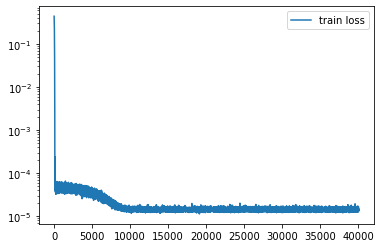

In [76]:
    """利用分割后的数据对neural network进行训练"""
    """这里发现一个问题，由于原文中使用四层隐含层，每层7个Units的简单模型，造成模型的拟合能力较差，
    很多情况下对于训练数据并不能很好收敛，大概5六次中会有一次loss可以正常下降，在最初的尝试中，我们
    以为是由于weights initialization造成的，在尝试了不同的weight initalization之后发现，不同的
    权重初始化对这个简单模型的结果差异不大，即都会出现多数不收敛，少数可以收敛的情况，如果某单次训练Loss
    没有正常收敛，不用灰心，请重新训练"""
    """BP模型实例"""
    Gpu = torch.device("cuda")
    Bp_kalman = BpFilter().to(Gpu)
    # for m in Bp_kalman.modules():
    #     if isinstance(m, nn.Conv2d):
    #         nn.init.xavier_normal_(m.weight.data)
    #     elif isinstance(m, nn.Linear):
    #         nn.init.xavier_normal_(m.weight.data)
    # for m in Bp_kalman.modules():
    #     if isinstance(m, nn.Conv2d):
    #         nn.init.xavier_normal_(m.weight.data)
    #     elif isinstance(m, nn.Linear):
    #         nn.init.xavier_normal_(m.weight.data)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(Bp_kalman.parameters(), lr=0.001)
    train_loss, validation_loss = Fit(Bp_kalman, train_loader, Gpu, optimizer, criterion, 50)
    plt.figure()
    plt.plot(train_loss, label="train loss")
    plt.legend()
    plt.yscale("log")
    plt.show()

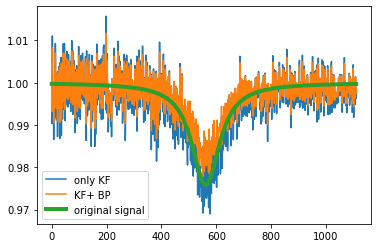

In [75]:
    %matplotlib inline
    test = CH4_KF[500]  # (1111,)
    test = array_to_tensor(test)
    test = test.reshape(1111, 1)
    prediction = Bp_kalman(test)
    prediction = prediction.cpu().detach().numpy()
    test = test.cpu().detach().numpy()
    plt.figure()
    plt.plot(test, alpha=1, label="only KF")
    plt.plot(prediction, alpha=1, label="KF+ BP")
    plt.plot(CH4_no_noise_spectral[500], linewidth=4, label="original signal")
    plt.legend()
    plt.show()

In [77]:
"""保存模型"""
model_save_path = r"D:\PYHTON\python3.7\DeepLearningProgram\深度学习滤波器\滤波模型\透射谱的滤波模型\BP_KF.pt"
torch.save(Bp_kalman.state_dict(), model_save_path)